In [1]:
!pip install -r ../../requirements.txt


You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV1'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.horizontal_and_vertical_flip_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(495000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v1(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        80        
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 16)        16400     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0     

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/436 [..............................] - ETA: 1:30:34 - loss: 2.3979

  2/436 [..............................] - ETA: 25s - loss: 2.3979    

  3/436 [..............................] - ETA: 25s - loss: 2.3979

  4/436 [..............................] - ETA: 25s - loss: 2.3979

  5/436 [..............................] - ETA: 25s - loss: 2.3979

  6/436 [..............................] - ETA: 25s - loss: 2.3979

  7/436 [..............................] - ETA: 25s - loss: 2.3979

  8/436 [..............................] - ETA: 25s - loss: 2.3979

  9/436 [..............................] - ETA: 25s - loss: 2.3979

 10/436 [..............................] - ETA: 25s - loss: 2.3979

 11/436 [..............................] - ETA: 25s - loss: 2.3979

 12/436 [..............................] - ETA: 24s - loss: 2.3979

 13/436 [..............................] - ETA: 24s - loss: 2.3979

 14/436 [..............................] - ETA: 24s - loss: 2.3979

 15/436 [>.............................] - ETA: 24s - loss: 2.3979

 16/436 [>.............................] - ETA: 24s - loss: 2.3979

 17/436 [>.............................] - ETA: 24s - loss: 2.3979

 18/436 [>.............................] - ETA: 24s - loss: 2.3979

 19/436 [>.............................] - ETA: 24s - loss: 2.3979

 20/436 [>.............................] - ETA: 24s - loss: 2.3979

 21/436 [>.............................] - ETA: 24s - loss: 2.3979

 22/436 [>.............................] - ETA: 24s - loss: 2.3979

 23/436 [>.............................] - ETA: 24s - loss: 2.3979

 24/436 [>.............................] - ETA: 24s - loss: 2.3979

 25/436 [>.............................] - ETA: 24s - loss: 2.3979

 26/436 [>.............................] - ETA: 24s - loss: 2.3979

 27/436 [>.............................] - ETA: 24s - loss: 2.3979

 28/436 [>.............................] - ETA: 24s - loss: 2.3979

 29/436 [>.............................] - ETA: 23s - loss: 2.3979

 30/436 [=>............................] - ETA: 23s - loss: 2.3979

 31/436 [=>............................] - ETA: 23s - loss: 2.3979

 32/436 [=>............................] - ETA: 23s - loss: 2.3979

 33/436 [=>............................] - ETA: 23s - loss: 2.3979

 34/436 [=>............................] - ETA: 23s - loss: 2.3979



 35/436 [=>............................] - ETA: 23s - loss: 2.3979

 36/436 [=>............................] - ETA: 23s - loss: 2.3979

 37/436 [=>............................] - ETA: 23s - loss: 2.3979

 38/436 [=>............................] - ETA: 23s - loss: 2.3979

 39/436 [=>............................] - ETA: 23s - loss: 2.3979

 40/436 [=>............................] - ETA: 23s - loss: 2.3979

 41/436 [=>............................] - ETA: 23s - loss: 2.3979

 42/436 [=>............................] - ETA: 23s - loss: 2.3979

 43/436 [=>............................] - ETA: 23s - loss: 2.3979

 44/436 [==>...........................] - ETA: 23s - loss: 2.3979

 45/436 [==>...........................] - ETA: 23s - loss: 2.3979

 46/436 [==>...........................] - ETA: 23s - loss: 2.3979

 47/436 [==>...........................] - ETA: 23s - loss: 2.3979

 48/436 [==>...........................] - ETA: 23s - loss: 2.3979

 49/436 [==>...........................] - ETA: 23s - loss: 2.3979

 50/436 [==>...........................] - ETA: 23s - loss: 2.3979

 51/436 [==>...........................] - ETA: 22s - loss: 2.3979

 52/436 [==>...........................] - ETA: 22s - loss: 2.3979

 53/436 [==>...........................] - ETA: 22s - loss: 2.3979

 54/436 [==>...........................] - ETA: 22s - loss: 2.3979

 55/436 [==>...........................] - ETA: 22s - loss: 2.3979

 56/436 [==>...........................] - ETA: 22s - loss: 2.3979

 57/436 [==>...........................] - ETA: 22s - loss: 2.3979

 58/436 [==>...........................] - ETA: 22s - loss: 2.3979

 59/436 [===>..........................] - ETA: 22s - loss: 2.3979

 60/436 [===>..........................] - ETA: 22s - loss: 2.3979

 61/436 [===>..........................] - ETA: 22s - loss: 2.3979

 62/436 [===>..........................] - ETA: 22s - loss: 2.3979

 63/436 [===>..........................] - ETA: 22s - loss: 2.3979

 64/436 [===>..........................] - ETA: 22s - loss: 2.3979

 65/436 [===>..........................] - ETA: 22s - loss: 2.3979

 66/436 [===>..........................] - ETA: 22s - loss: 2.3979

 67/436 [===>..........................] - ETA: 21s - loss: 2.3979

 68/436 [===>..........................] - ETA: 21s - loss: 2.3979

 69/436 [===>..........................] - ETA: 21s - loss: 2.3979

 70/436 [===>..........................] - ETA: 21s - loss: 2.3979

 71/436 [===>..........................] - ETA: 21s - loss: 2.3979

 72/436 [===>..........................] - ETA: 21s - loss: 2.3979

 73/436 [====>.........................] - ETA: 21s - loss: 2.3979

 74/436 [====>.........................] - ETA: 21s - loss: 2.3979

 75/436 [====>.........................] - ETA: 21s - loss: 2.3979

 76/436 [====>.........................] - ETA: 21s - loss: 2.3979

 77/436 [====>.........................] - ETA: 21s - loss: 2.3979

 78/436 [====>.........................] - ETA: 21s - loss: 2.3979

 79/436 [====>.........................] - ETA: 21s - loss: 2.3979

 80/436 [====>.........................] - ETA: 21s - loss: 2.3978

 81/436 [====>.........................] - ETA: 21s - loss: 2.3978

 82/436 [====>.........................] - ETA: 21s - loss: 2.3978

 83/436 [====>.........................] - ETA: 21s - loss: 2.3978

 84/436 [====>.........................] - ETA: 21s - loss: 2.3978

 85/436 [====>.........................]

 - ETA: 20s - loss: 2.3978

 86/436 [====>.........................] - ETA: 20s - loss: 2.3978

 87/436 [====>.........................] - ETA: 20s - loss: 2.3978

 88/436 [=====>........................] - ETA: 20s - loss: 2.3978

 89/436 [=====>........................] - ETA: 20s - loss: 2.3977

 90/436 [=====>........................] - ETA: 20s - loss: 2.3977

 91/436 [=====>........................] - ETA: 20s - loss: 2.3977

 92/436 [=====>........................] - ETA: 20s - loss: 2.3977

 93/436 [=====>........................] - ETA: 20s - loss: 2.3976

 94/436 [=====>........................] - ETA: 20s - loss: 2.3976

 95/436 [=====>........................] - ETA: 20s - loss: 2.3976

 96/436 [=====>........................] - ETA: 20s - loss: 2.3975

 97/436 [=====>........................] - ETA: 20s - loss: 2.3975

 98/436 [=====>........................] - ETA: 20s - loss: 2.3975

 99/436 [=====>........................] - ETA: 20s - loss: 2.3974

100/436 [=====>........................] - ETA: 20s - loss: 2.3974

101/436 [=====>........................] - ETA: 19s - loss: 2.3973

102/436 [======>.......................] - ETA: 19s - loss: 2.3973

103/436 [======>.......................] - ETA: 19s - loss: 2.3972

104/436 [======>.......................] - ETA: 19s - loss: 2.3972

105/436 [======>.......................] - ETA: 19s - loss: 2.3971

106/436 [======>.......................] - ETA: 19s - loss: 2.3971

107/436 [======>.......................] - ETA: 19s - loss: 2.3970

108/436 [======>.......................] - ETA: 19s - loss: 2.3969

109/436 [======>.......................] - ETA: 19s - loss: 2.3969

110/436 [======>.......................] - ETA: 19s - loss: 2.3968

111/436 [======>.......................] - ETA: 19s - loss: 2.3967

112/436 [======>.......................] - ETA: 19s - loss: 2.3966

113/436 [======>.......................] - ETA: 19s - loss: 2.3965

114/436 [======>.......................] - ETA: 19s - loss: 2.3965

115/436 [======>.......................] - ETA: 19s - loss: 2.3964

116/436 [======>.......................] - ETA: 19s - loss: 2.3963

117/436 [=======>......................] - ETA: 19s - loss: 2.3962

118/436 [=======>......................] - ETA: 18s - loss: 2.3961

119/436 [=======>......................] - ETA: 18s - loss: 2.3960

120/436 [=======>......................] - ETA: 18s - loss: 2.3959

121/436 [=======>......................] - ETA: 18s - loss: 2.3958

122/436 [=======>......................] - ETA: 18s - loss: 2.3957

123/436 [=======>......................] - ETA: 18s - loss: 2.3956

124/436 [=======>......................] - ETA: 18s - loss: 2.3955

125/436 [=======>......................] - ETA: 18s - loss: 2.3954

126/436 [=======>......................] - ETA: 18s - loss: 2.3953

127/436 [=======>......................] - ETA: 18s - loss: 2.3951

128/436 [=======>......................] - ETA: 18s - loss: 2.3950

129/436 [=======>......................] - ETA: 18s - loss: 2.3949

130/436 [=======>......................] - ETA: 18s - loss: 2.3948

131/436 [========>.....................] - ETA: 18s - loss: 2.3947

132/436 [========>.....................] - ETA: 18s - loss: 2.3945

133/436 [========>.....................] - ETA: 18s - loss: 2.3944

134/436 [========>.....................] - ETA: 17s - loss: 2.3943



135/436 [========>.....................] - ETA: 17s - loss: 2.3942

136/436 [========>.....................] - ETA: 17s - loss: 2.3940

137/436 [========>.....................] - ETA: 17s - loss: 2.3939

138/436 [========>.....................] - ETA: 17s - loss: 2.3938

139/436 [========>.....................] - ETA: 17s - loss: 2.3936

140/436 [========>.....................] - ETA: 17s - loss: 2.3935

141/436 [========>.....................] - ETA: 17s - loss: 2.3934

142/436 [========>.....................] - ETA: 17s - loss: 2.3932

143/436 [========>.....................] - ETA: 17s - loss: 2.3931

144/436 [========>.....................] - ETA: 17s - loss: 2.3930

145/436 [========>.....................] - ETA: 17s - loss: 2.3928

146/436 [=========>....................] - ETA: 17s - loss: 2.3927

147/436 [=========>....................] - ETA: 17s - loss: 2.3925

148/436 [=========>....................] - ETA: 17s - loss: 2.3924

149/436 [=========>....................] - ETA: 17s - loss: 2.3923

150/436 [=========>....................] - ETA: 16s - loss: 2.3921

151/436 [=========>....................] - ETA: 16s - loss: 2.3920

152/436 [=========>....................] - ETA: 16s - loss: 2.3918

153/436 [=========>....................] - ETA: 16s - loss: 2.3917

154/436 [=========>....................] - ETA: 16s - loss: 2.3916

155/436 [=========>....................] - ETA: 16s - loss: 2.3914

156/436 [=========>....................] - ETA: 16s - loss: 2.3913

157/436 [=========>....................] - ETA: 16s - loss: 2.3911

158/436 [=========>....................] - ETA: 16s - loss: 2.3910

159/436 [=========>....................] - ETA: 16s - loss: 2.3908

160/436 [==========>...................] - ETA: 16s - loss: 2.3907

161/436 [==========>...................] - ETA: 16s - loss: 2.3905

162/436 [==========>...................] - ETA: 16s - loss: 2.3904

163/436 [==========>...................] - ETA: 16s - loss: 2.3902

164/436 [==========>...................] - ETA: 16s - loss: 2.3901

165/436 [==========>...................] - ETA: 16s - loss: 2.3900

166/436 [==========>...................] - ETA: 16s - loss: 2.3898

167/436 [==========>...................] - ETA: 15s - loss: 2.3897

168/436 [==========>...................] - ETA: 15s - loss: 2.3895

169/436 [==========>...................] - ETA: 15s - loss: 2.3894

170/436 [==========>...................] - ETA: 15s - loss: 2.3892

171/436 [==========>...................] - ETA: 15s - loss: 2.3891

172/436 [==========>...................] - ETA: 15s - loss: 2.3889

173/436 [==========>...................] - ETA: 15s - loss: 2.3888

174/436 [==========>...................] - ETA: 15s - loss: 2.3886

175/436 [===========>..................] - ETA: 15s - loss: 2.3885

176/436 [===========>..................] - ETA: 15s - loss: 2.3883

177/436 [===========>..................] - ETA: 15s - loss: 2.3882

178/436 [===========>..................] - ETA: 15s - loss: 2.3880

179/436 [===========>..................] - ETA: 15s - loss: 2.3879

180/436 [===========>..................] - ETA: 15s - loss: 2.3877

181/436 [===========>..................] - ETA: 15s - loss: 2.3876

182/436 [===========>..................] - ETA: 15s - loss: 2.3874

183/436 [===========>..................] - ETA: 15s - loss: 2.3873

184/436 [===========>..................] - ETA: 14s - loss: 2.3871

185/436 [===========>..................] - ETA: 14s - loss: 2.3870

186/436 [===========>..................] - ETA: 14s - loss: 2.3868

187/436 [===========>..................] - ETA: 14s - loss: 2.3867

188/436 [===========>..................] - ETA: 14s - loss: 2.3865

189/436 [============>.................] - ETA: 14s - loss: 2.3864

190/436 [============>.................] - ETA: 14s - loss: 2.3862

191/436 [============>.................] - ETA: 14s - loss: 2.3861

192/436 [============>.................] - ETA: 14s - loss: 2.3859

193/436 [============>.................] - ETA: 14s - loss: 2.3858

194/436 [============>.................] - ETA: 14s - loss: 2.3856

195/436 [============>.................] - ETA: 14s - loss: 2.3855

196/436 [============>.................] - ETA: 14s - loss: 2.3853

197/436 [============>.................] - ETA: 14s - loss: 2.3852

198/436 [============>.................] - ETA: 14s - loss: 2.3850

199/436 [============>.................] - ETA: 14s - loss: 2.3849

200/436 [============>.................] - ETA: 14s - loss: 2.3847

201/436 [============>.................] - ETA: 13s - loss: 2.3846

202/436 [============>.................] - ETA: 13s - loss: 2.3845

203/436 [============>.................] - ETA: 13s - loss: 2.3843

204/436 [=============>................] - ETA: 13s - loss: 2.3842

205/436 [=============>................] - ETA: 13s - loss: 2.3840

206/436 [=============>................] - ETA: 13s - loss: 2.3839

207/436 [=============>................] - ETA: 13s - loss: 2.3837

208/436 [=============>................] - ETA: 13s - loss: 2.3836

209/436 [=============>................] - ETA: 13s - loss: 2.3835

210/436 [=============>................] - ETA: 13s - loss: 2.3833

211/436 [=============>................] - ETA: 13s - loss: 2.3832

212/436 [=============>................] - ETA: 13s - loss: 2.3830

213/436 [=============>................] - ETA: 13s - loss: 2.3829

214/436 [=============>................] - ETA: 13s - loss: 2.3827

215/436 [=============>................] - ETA: 13s - loss: 2.3826

216/436 [=============>................] - ETA: 13s - loss: 2.3825

217/436 [=============>................] - ETA: 12s - loss: 2.3823

218/436 [==============>...............] - ETA: 12s - loss: 2.3822

219/436 [==============>...............] - ETA: 12s - loss: 2.3820

220/436 [==============>...............] - ETA: 12s - loss: 2.3819

221/436 [==============>...............] - ETA: 12s - loss: 2.3818

222/436 [==============>...............] - ETA: 12s - loss: 2.3816

223/436 [==============>...............] - ETA: 12s - loss: 2.3815

224/436 [==============>...............] - ETA: 12s - loss: 2.3814

225/436 [==============>...............] - ETA: 12s - loss: 2.3812

226/436 [==============>...............] - ETA: 12s - loss: 2.3811

227/436 [==============>...............] - ETA: 12s - loss: 2.3810

228/436 [==============>...............] - ETA: 12s - loss: 2.3808

229/436 [==============>...............] - ETA: 12s - loss: 2.3807

230/436 [==============>...............] - ETA: 12s - loss: 2.3805

231/436 [==============>...............] - ETA: 12s - loss: 2.3804

232/436 [==============>...............] - ETA: 12s - loss: 2.3803

233/436 [===============>..............] - ETA: 12s - loss: 2.3801

234/436 [===============>..............] - ETA: 11s - loss: 2.3800

235/436 [===============>..............] - ETA: 11s - loss: 2.3799

236/436 [===============>..............] - ETA: 11s - loss: 2.3798

237/436 [===============>..............] - ETA: 11s - loss: 2.3796

238/436 [===============>..............] - ETA: 11s - loss: 2.3795

239/436 [===============>..............] - ETA: 11s - loss: 2.3794

240/436 [===============>..............] - ETA: 11s - loss: 2.3792

241/436 [===============>..............] - ETA: 11s - loss: 2.3791

242/436 [===============>..............] - ETA: 11s - loss: 2.3790

243/436 [===============>..............] - ETA: 11s - loss: 2.3788

244/436 [===============>..............] - ETA: 11s - loss: 2.3787

245/436 [===============>..............] - ETA: 11s - loss: 2.3786

246/436 [===============>..............] - ETA: 11s - loss: 2.3785

247/436 [===============>..............] - ETA: 11s - loss: 2.3783

248/436 [================>.............] - ETA: 11s - loss: 2.3782

249/436 [================>.............] - ETA: 11s - loss: 2.3781

250/436 [================>.............] - ETA: 11s - loss: 2.3780

251/436 [================>.............] - ETA: 10s - loss: 2.3778

252/436 [================>.............] - ETA: 10s - loss: 2.3777

253/436 [================>.............] - ETA: 10s - loss: 2.3776

254/436 [================>.............] - ETA: 10s - loss: 2.3775

255/436 [================>.............] - ETA: 10s - loss: 2.3773

256/436 [================>.............] - ETA: 10s - loss: 2.3772

257/436 [================>.............] - ETA: 10s - loss: 2.3771

258/436 [================>.............] - ETA: 10s - loss: 2.3770

259/436 [================>.............] - ETA: 10s - loss: 2.3768

260/436 [================>.............] - ETA: 10s - loss: 2.3767

261/436 [================>.............] - ETA: 10s - loss: 2.3766

262/436 [=================>............] - ETA: 10s - loss: 2.3765

263/436 [=================>............] - ETA: 10s - loss: 2.3764

264/436 [=================>............] - ETA: 10s - loss: 2.3762

265/436 [=================>............] - ETA: 10s - loss: 2.3761

266/436 [=================>............] - ETA: 10s - loss: 2.3760

267/436 [=================>............] - ETA: 10s - loss: 2.3759

268/436 [=================>............] - ETA: 9s - loss: 2.3758 

269/436 [=================>............] - ETA: 9s - loss: 2.3756

270/436 [=================>............] - ETA: 9s - loss: 2.3755

271/436 [=================>............] - ETA: 9s - loss: 2.3754

272/436 [=================>............] - ETA: 9s - loss: 2.3753

273/436 [=================>............] - ETA: 9s - loss: 2.3752

274/436 [=================>............] - ETA: 9s - loss: 2.3750

275/436 [=================>............] - ETA: 9s - loss: 2.3749

276/436 [=================>............] - ETA: 9s - loss: 2.3748

277/436 [==================>...........] - ETA: 9s - loss: 2.3747

278/436 [==================>...........] - ETA: 9s - loss: 2.3746

279/436 [==================>...........] - ETA: 9s - loss: 2.3745

280/436 [==================>...........] - ETA: 9s - loss: 2.3744

281/436 [==================>...........] - ETA: 9s - loss: 2.3742

282/436 [==================>...........] - ETA: 9s - loss: 2.3741

283/436 [==================>...........] - ETA: 9s - loss: 2.3740

284/436 [==================>...........] - ETA: 9s - loss: 2.3739

285/436 [==================>...........] - ETA: 8s - loss: 2.3738

286/436 [==================>...........] - ETA: 8s - loss: 2.3737

287/436 [==================>...........] - ETA: 8s - loss: 2.3736

288/436 [==================>...........] - ETA: 8s - loss: 2.3734

289/436 [==================>...........] - ETA: 8s - loss: 2.3733

290/436 [==================>...........] - ETA: 8s - loss: 2.3732

291/436 [===================>..........] - ETA: 8s - loss: 2.3731

292/436 [===================>..........] - ETA: 8s - loss: 2.3730

293/436 [===================>..........] - ETA: 8s - loss: 2.3729

294/436 [===================>..........] - ETA: 8s - loss: 2.3728

295/436 [===================>..........] - ETA: 8s - loss: 2.3727

296/436 [===================>..........] - ETA: 8s - loss: 2.3726

297/436 [===================>..........] - ETA: 8s - loss: 2.3725

298/436 [===================>..........] - ETA: 8s - loss: 2.3723

299/436 [===================>..........] - ETA: 8s - loss: 2.3722

300/436 [===================>..........] - ETA: 8s - loss: 2.3721

301/436 [===================>..........] - ETA: 8s - loss: 2.3720

302/436 [===================>..........] - ETA: 7s - loss: 2.3719

303/436 [===================>..........] - ETA: 7s - loss: 2.3718

304/436 [===================>..........] - ETA: 7s - loss: 2.3717

305/436 [===================>..........] - ETA: 7s - loss: 2.3716

306/436 [====================>.........] - ETA: 7s - loss: 2.3715

307/436 [====================>.........] - ETA: 7s - loss: 2.3714

308/436 [====================>.........] - ETA: 7s - loss: 2.3713

309/436 [====================>.........] - ETA: 7s - loss: 2.3712

310/436 [====================>.........] - ETA: 7s - loss: 2.3711

311/436 [====================>.........] - ETA: 7s - loss: 2.3710

312/436 [====================>.........] - ETA: 7s - loss: 2.3709

313/436 [====================>.........]

 - ETA: 7s - loss: 2.3708

314/436 [====================>.........] - ETA: 7s - loss: 2.3707

315/436 [====================>.........] - ETA: 7s - loss: 2.3706

316/436 [====================>.........] - ETA: 7s - loss: 2.3705

317/436 [====================>.........] - ETA: 7s - loss: 2.3704

318/436 [====================>.........] - ETA: 7s - loss: 2.3703

319/436 [====================>.........] - ETA: 6s - loss: 2.3702

320/436 [=====================>........] - ETA: 6s - loss: 2.3701



321/436 [=====================>........] - ETA: 6s - loss: 2.3700

322/436 [=====================>........] - ETA: 6s - loss: 2.3698

323/436 [=====================>........] - ETA: 6s - loss: 2.3697

324/436 [=====================>........] - ETA: 6s - loss: 2.3696

325/436 [=====================>........] - ETA: 6s - loss: 2.3695

326/436 [=====================>........] - ETA: 6s - loss: 2.3694

327/436 [=====================>........] - ETA: 6s - loss: 2.3693

328/436 [=====================>........] - ETA: 6s - loss: 2.3692

329/436 [=====================>........] - ETA: 6s - loss: 2.3692

330/436 [=====================>........] - ETA: 6s - loss: 2.3691

331/436 [=====================>........] - ETA: 6s - loss: 2.3690

332/436 [=====================>........] - ETA: 6s - loss: 2.3689

333/436 [=====================>........] - ETA: 6s - loss: 2.3688

334/436 [=====================>........] - ETA: 6s - loss: 2.3687

335/436 [======================>.......] - ETA: 6s - loss: 2.3686

336/436 [======================>.......] - ETA: 5s - loss: 2.3685

337/436 [======================>.......] - ETA: 5s - loss: 2.3684

338/436 [======================>.......] - ETA: 5s - loss: 2.3683

339/436 [======================>.......] - ETA: 5s - loss: 2.3682

340/436 [======================>.......] - ETA: 5s - loss: 2.3681

341/436 [======================>.......] - ETA: 5s - loss: 2.3680

342/436 [======================>.......] - ETA: 5s - loss: 2.3679

343/436 [======================>.......] - ETA: 5s - loss: 2.3678

344/436 [======================>.......] - ETA: 5s - loss: 2.3677

345/436 [======================>.......] - ETA: 5s - loss: 2.3676

346/436 [======================>.......] - ETA: 5s - loss: 2.3675

347/436 [======================>.......] - ETA: 5s - loss: 2.3674

348/436 [======================>.......] - ETA: 5s - loss: 2.3673

349/436 [=======================>......] - ETA: 5s - loss: 2.3672

350/436 [=======================>......] - ETA: 5s - loss: 2.3671

351/436 [=======================>......] - ETA: 5s - loss: 2.3671

352/436 [=======================>......] - ETA: 4s - loss: 2.3670

353/436 [=======================>......] - ETA: 4s - loss: 2.3669

354/436 [=======================>......] - ETA: 4s - loss: 2.3668

355/436 [=======================>......] - ETA: 4s - loss: 2.3667

356/436 [=======================>......] - ETA: 4s - loss: 2.3666

357/436 [=======================>......] - ETA: 4s - loss: 2.3665

358/436 [=======================>......] - ETA: 4s - loss: 2.3664

359/436 [=======================>......] - ETA: 4s - loss: 2.3663

360/436 [=======================>......] - ETA: 4s - loss: 2.3662

361/436 [=======================>......] - ETA: 4s - loss: 2.3662

362/436 [=======================>......] - ETA: 4s - loss: 2.3661

363/436 [=======================>......] - ETA: 4s - loss: 2.3660

364/436 [========================>.....] - ETA: 4s - loss: 2.3659

365/436 [========================>.....] - ETA: 4s - loss: 2.3658

366/436 [========================>.....] - ETA: 4s - loss: 2.3657

367/436 [========================>.....] - ETA: 4s - loss: 2.3656

368/436 [========================>.....] - ETA: 4s - loss: 2.3655

369/436 [========================>.....] - ETA: 3s - loss: 2.3654

370/436 [========================>.....] - ETA: 3s - loss: 2.3654

371/436 [========================>.....] - ETA: 3s - loss: 2.3653

372/436 [========================>.....] - ETA: 3s - loss: 2.3652

373/436 [========================>.....] - ETA: 3s - loss: 2.3651

374/436 [========================>.....] - ETA: 3s - loss: 2.3650

375/436 [========================>.....] - ETA: 3s - loss: 2.3649

376/436 [========================>.....] - ETA: 3s - loss: 2.3648

377/436 [========================>.....] - ETA: 3s - loss: 2.3648

378/436 [=========================>....] - ETA: 3s - loss: 2.3647

379/436 [=========================>....] - ETA: 3s - loss: 2.3646

380/436 [=========================>....] - ETA: 3s - loss: 2.3645

381/436 [=========================>....] - ETA: 3s - loss: 2.3644

382/436 [=========================>....] - ETA: 3s - loss: 2.3643

383/436 [=========================>....] - ETA: 3s - loss: 2.3643

384/436 [=========================>....] - ETA: 3s - loss: 2.3642

385/436 [=========================>....] - ETA: 3s - loss: 2.3641

386/436 [=========================>....] - ETA: 2s - loss: 2.3640

387/436 [=========================>....] - ETA: 2s - loss: 2.3639

388/436 [=========================>....] - ETA: 2s - loss: 2.3638

389/436 [=========================>....] - ETA: 2s - loss: 2.3638

390/436 [=========================>....] - ETA: 2s - loss: 2.3637

391/436 [=========================>....] - ETA: 2s - loss: 2.3636

392/436 [=========================>....] - ETA: 2s - loss: 2.3635

393/436 [==========================>...] - ETA: 2s - loss: 2.3634

394/436 [==========================>...] - ETA: 2s - loss: 2.3633

395/436 [==========================>...] - ETA: 2s - loss: 2.3633

396/436 [==========================>...] - ETA: 2s - loss: 2.3632

397/436 [==========================>...] - ETA: 2s - loss: 2.3631

398/436 [==========================>...] - ETA: 2s - loss: 2.3630

399/436 [==========================>...] - ETA: 2s - loss: 2.3629

400/436 [==========================>...] - ETA: 2s - loss: 2.3629

401/436 [==========================>...] - ETA: 2s - loss: 2.3628

402/436 [==========================>...] - ETA: 2s - loss: 2.3627

403/436 [==========================>...] - ETA: 1s - loss: 2.3626

404/436 [==========================>...] - ETA: 1s - loss: 2.3626

405/436 [==========================>...] - ETA: 1s - loss: 2.3625

406/436 [==========================>...] - ETA: 1s - loss: 2.3624

407/436 [===========================>..] - ETA: 1s - loss: 2.3623

408/436 [===========================>..] - ETA: 1s - loss: 2.3622

409/436 [===========================>..] - ETA: 1s - loss: 2.3622

410/436 [===========================>..] - ETA: 1s - loss: 2.3621



411/436 [===========================>..] - ETA: 1s - loss: 2.3620

412/436 [===========================>..] - ETA: 1s - loss: 2.3619

413/436 [===========================>..] - ETA: 1s - loss: 2.3619

414/436 [===========================>..] - ETA: 1s - loss: 2.3618

415/436 [===========================>..] - ETA: 1s - loss: 2.3617

416/436 [===========================>..] - ETA: 1s - loss: 2.3616

417/436 [===========================>..] - ETA: 1s - loss: 2.3615

418/436 [===========================>..] - ETA: 1s - loss: 2.3615

419/436 [===========================>..] - ETA: 1s - loss: 2.3614



420/436 [===========================>..] - ETA: 0s - loss: 2.3613

421/436 [===========================>..] - ETA: 0s - loss: 2.3612

422/436 [============================>.] - ETA: 0s - loss: 2.3612

423/436 [============================>.] - ETA: 0s - loss: 2.3611

424/436 [============================>.]

 - ETA: 0s - loss: 2.3610

425/436 [============================>.] - ETA: 0s - loss: 2.3609

426/436 [============================>.] - ETA: 0s - loss: 2.3609

427/436 [============================>.] - ETA: 0s - loss: 2.3608

428/436 [============================>.] - ETA: 0s - loss: 2.3607

429/436 [============================>.] - ETA: 0s - loss: 2.3607

430/436 [============================>.] - ETA: 0s - loss: 2.3606

431/436 [============================>.] - ETA: 0s - loss: 2.3605

432/436 [============================>.] - ETA: 0s - loss: 2.3604

433/436 [============================>.] - ETA: 0s - loss: 2.3604

434/436 [============================>.] - ETA: 0s - loss: 2.3603

435/436 [============================>.] - ETA: 0s - loss: 2.3602

436/436 [==============================] - ETA: 0s - loss: 2.3601

436/436 [==============================] - 40s 63ms/step - loss: 2.3601 - val_loss: 2.3028


Epoch 2/100
  1/436 [..............................] - ETA: 25s - loss: 2.3166

  2/436 [..............................] - ETA: 26s - loss: 2.3152

  3/436 [..............................] - ETA: 25s - loss: 2.3116

  4/436 [..............................] - ETA: 26s - loss: 2.3089



  5/436 [..............................] - ETA: 25s - loss: 2.3077



  6/436 [..............................] - ETA: 25s - loss: 2.3069



  7/436 [..............................] - ETA: 26s - loss: 2.3063

  8/436 [..............................] - ETA: 27s - loss: 2.3055

  9/436 [..............................] - ETA: 27s - loss: 2.3049

 10/436 [..............................] - ETA: 27s - loss: 2.3046

 11/436 [..............................] - ETA: 27s - loss: 2.3042

 12/436 [..............................] - ETA: 26s - loss: 2.3039

 13/436 [..............................] - ETA: 26s - loss: 2.3037

 14/436 [..............................] - ETA: 26s - loss: 2.3035

 15/436 [>.............................] - ETA: 26s - loss: 2.3034

 16/436 [>.............................] - ETA: 26s - loss: 2.3033

 17/436 [>.............................] - ETA: 26s - loss: 2.3033

 18/436 [>.............................] - ETA: 25s - loss: 2.3033

 19/436 [>.............................] - ETA: 25s - loss: 2.3032

 20/436 [>.............................] - ETA: 25s - loss: 2.3032

 21/436 [>.............................] - ETA: 25s - loss: 2.3032

 22/436 [>.............................] - ETA: 25s - loss: 2.3032

 23/436 [>.............................] - ETA: 25s - loss: 2.3032

 24/436 [>.............................] - ETA: 25s - loss: 2.3032

 25/436 [>.............................] - ETA: 25s - loss: 2.3032

 26/436 [>.............................] - ETA: 25s - loss: 2.3032

 27/436 [>.............................] - ETA: 24s - loss: 2.3032

 28/436 [>.............................] - ETA: 24s - loss: 2.3032

 29/436 [>.............................] - ETA: 24s - loss: 2.3032

 30/436 [=>............................] - ETA: 24s - loss: 2.3032

 31/436 [=>............................] - ETA: 24s - loss: 2.3032

 32/436 [=>............................] - ETA: 24s - loss: 2.3032

 33/436 [=>............................] - ETA: 24s - loss: 2.3032

 34/436 [=>............................] - ETA: 24s - loss: 2.3031

 35/436 [=>............................] - ETA: 24s - loss: 2.3031

 36/436 [=>............................] - ETA: 24s - loss: 2.3031

 37/436 [=>............................] - ETA: 24s - loss: 2.3031

 38/436 [=>............................] - ETA: 24s - loss: 2.3031

 39/436 [=>............................] - ETA: 23s - loss: 2.3031

 40/436 [=>............................] - ETA: 23s - loss: 2.3031

 41/436 [=>............................] - ETA: 23s - loss: 2.3031

 42/436 [=>............................] - ETA: 23s - loss: 2.3031

 43/436 [=>............................] - ETA: 23s - loss: 2.3031

 44/436 [==>...........................] - ETA: 23s - loss: 2.3031

 45/436 [==>...........................] - ETA: 23s - loss: 2.3031

 46/436 [==>...........................] - ETA: 23s - loss: 2.3031

 47/436 [==>...........................] - ETA: 23s - loss: 2.3031

 48/436 [==>...........................] - ETA: 23s - loss: 2.3030

 49/436 [==>...........................] - ETA: 23s - loss: 2.3030

 50/436 [==>...........................] - ETA: 23s - loss: 2.3030

 51/436 [==>...........................] - ETA: 23s - loss: 2.3030

 52/436 [==>...........................] - ETA: 23s - loss: 2.3030

 53/436 [==>...........................] - ETA: 23s - loss: 2.3030

 54/436 [==>...........................] - ETA: 22s - loss: 2.3030

 55/436 [==>...........................] - ETA: 22s - loss: 2.3030

 56/436 [==>...........................] - ETA: 22s - loss: 2.3030

 57/436 [==>...........................] - ETA: 22s - loss: 2.3030

 58/436 [==>...........................] - ETA: 22s - loss: 2.3030

 59/436 [===>..........................] - ETA: 22s - loss: 2.3030

 60/436 [===>..........................] - ETA: 22s - loss: 2.3030

 61/436 [===>..........................] - ETA: 22s - loss: 2.3030

 62/436 [===>..........................] - ETA: 22s - loss: 2.3030

 63/436 [===>..........................] - ETA: 22s - loss: 2.3030

 64/436 [===>..........................] - ETA: 22s - loss: 2.3029

 65/436 [===>..........................] - ETA: 22s - loss: 2.3029

 66/436 [===>..........................] - ETA: 22s - loss: 2.3029

 67/436 [===>..........................] - ETA: 22s - loss: 2.3029

 68/436 [===>..........................] - ETA: 22s - loss: 2.3029

 69/436 [===>..........................] - ETA: 21s - loss: 2.3029

 70/436 [===>..........................] - ETA: 21s - loss: 2.3028

 71/436 [===>..........................] - ETA: 21s - loss: 2.3028

 72/436 [===>..........................] - ETA: 21s - loss: 2.3028

 73/436 [====>.........................] - ETA: 21s - loss: 2.3028

 74/436 [====>.........................] - ETA: 21s - loss: 2.3028

 75/436 [====>.........................] - ETA: 21s - loss: 2.3027

 76/436 [====>.........................] - ETA: 21s - loss: 2.3027

 77/436 [====>.........................] - ETA: 21s - loss: 2.3027

 78/436 [====>.........................] - ETA: 21s - loss: 2.3027

 79/436 [====>.........................] - ETA: 21s - loss: 2.3027

 80/436 [====>.........................] - ETA: 21s - loss: 2.3027

 81/436 [====>.........................] - ETA: 21s - loss: 2.3026

 82/436 [====>.........................] - ETA: 21s - loss: 2.3026

 83/436 [====>.........................] - ETA: 21s - loss: 2.3026

 84/436 [====>.........................] - ETA: 21s - loss: 2.3026

 85/436 [====>.........................] - ETA: 21s - loss: 2.3026

 86/436 [====>.........................] - ETA: 20s - loss: 2.3025

 87/436 [====>.........................] - ETA: 20s - loss: 2.3025

 88/436 [=====>........................] - ETA: 20s - loss: 2.3025

 89/436 [=====>........................] - ETA: 20s - loss: 2.3025



 90/436 [=====>........................] - ETA: 20s - loss: 2.3025

 91/436 [=====>........................] - ETA: 20s - loss: 2.3025



 92/436 [=====>........................] - ETA: 20s - loss: 2.3025



 93/436 [=====>........................] - ETA: 20s - loss: 2.3025

 94/436 [=====>........................] - ETA: 20s - loss: 2.3025

 95/436 [=====>........................] - ETA: 20s - loss: 2.3024



 96/436 [=====>........................] - ETA: 20s - loss: 2.3024

 97/436 [=====>........................] - ETA: 20s - loss: 2.3024

 98/436 [=====>........................] - ETA: 20s - loss: 2.3024

 99/436 [=====>........................] - ETA: 20s - loss: 2.3024

100/436 [=====>........................] - ETA: 20s - loss: 2.3024

101/436 [=====>........................] - ETA: 20s - loss: 2.3024

102/436 [======>.......................] - ETA: 20s - loss: 2.3024

103/436 [======>.......................] - ETA: 20s - loss: 2.3024

104/436 [======>.......................] - ETA: 19s - loss: 2.3024

105/436 [======>.......................] - ETA: 19s - loss: 2.3024

106/436 [======>.......................] - ETA: 19s - loss: 2.3023

107/436 [======>.......................] - ETA: 19s - loss: 2.3023

108/436 [======>.......................] - ETA: 19s - loss: 2.3023

109/436 [======>.......................] - ETA: 19s - loss: 2.3023

110/436 [======>.......................] - ETA: 19s - loss: 2.3023

111/436 [======>.......................] - ETA: 19s - loss: 2.3023

112/436 [======>.......................] - ETA: 19s - loss: 2.3023

113/436 [======>.......................] - ETA: 19s - loss: 2.3023

114/436 [======>.......................] - ETA: 19s - loss: 2.3023

115/436 [======>.......................] - ETA: 19s - loss: 2.3023

116/436 [======>.......................] - ETA: 19s - loss: 2.3023

117/436 [=======>......................] - ETA: 19s - loss: 2.3023

118/436 [=======>......................] - ETA: 19s - loss: 2.3022

119/436 [=======>......................] - ETA: 19s - loss: 2.3022

120/436 [=======>......................] - ETA: 18s - loss: 2.3022

121/436 [=======>......................] - ETA: 18s - loss: 2.3022

122/436 [=======>......................] - ETA: 18s - loss: 2.3022

123/436 [=======>......................] - ETA: 18s - loss: 2.3022

124/436 [=======>......................] - ETA: 18s - loss: 2.3022

125/436 [=======>......................] - ETA: 18s - loss: 2.3022

126/436 [=======>......................] - ETA: 18s - loss: 2.3021

127/436 [=======>......................] - ETA: 18s - loss: 2.3021

128/436 [=======>......................] - ETA: 18s - loss: 2.3021

129/436 [=======>......................] - ETA: 18s - loss: 2.3021

130/436 [=======>......................]

 - ETA: 18s - loss: 2.3021

131/436 [========>.....................] - ETA: 18s - loss: 2.3021

132/436 [========>.....................] - ETA: 18s - loss: 2.3021

133/436 [========>.....................] - ETA: 18s - loss: 2.3021

134/436 [========>.....................] - ETA: 18s - loss: 2.3021

135/436 [========>.....................] - ETA: 18s - loss: 2.3020

136/436 [========>.....................] - ETA: 18s - loss: 2.3020

137/436 [========>.....................] - ETA: 17s - loss: 2.3020

138/436 [========>.....................] - ETA: 17s - loss: 2.3020

139/436 [========>.....................] - ETA: 17s - loss: 2.3020

140/436 [========>.....................] - ETA: 17s - loss: 2.3020

141/436 [========>.....................] - ETA: 17s - loss: 2.3020

142/436 [========>.....................] - ETA: 17s - loss: 2.3020

143/436 [========>.....................] - ETA: 17s - loss: 2.3020

144/436 [========>.....................] - ETA: 17s - loss: 2.3020

145/436 [========>.....................] - ETA: 17s - loss: 2.3020

146/436 [=========>....................] - ETA: 17s - loss: 2.3020

147/436 [=========>....................] - ETA: 17s - loss: 2.3020

148/436 [=========>....................] - ETA: 17s - loss: 2.3019

149/436 [=========>....................] - ETA: 17s - loss: 2.3019

150/436 [=========>....................] - ETA: 17s - loss: 2.3019

151/436 [=========>....................] - ETA: 17s - loss: 2.3019

152/436 [=========>....................] - ETA: 17s - loss: 2.3019

153/436 [=========>....................] - ETA: 16s - loss: 2.3019

154/436 [=========>....................] - ETA: 16s - loss: 2.3019

155/436 [=========>....................] - ETA: 16s - loss: 2.3019

156/436 [=========>....................] - ETA: 16s - loss: 2.3019

157/436 [=========>....................] - ETA: 16s - loss: 2.3019

158/436 [=========>....................] - ETA: 16s - loss: 2.3019

159/436 [=========>....................] - ETA: 16s - loss: 2.3019

160/436 [==========>...................] - ETA: 16s - loss: 2.3019

161/436 [==========>...................] - ETA: 16s - loss: 2.3019

162/436 [==========>...................] - ETA: 16s - loss: 2.3019

163/436 [==========>...................] - ETA: 16s - loss: 2.3019

164/436 [==========>...................] - ETA: 16s - loss: 2.3019

165/436 [==========>...................] - ETA: 16s - loss: 2.3018

166/436 [==========>...................] - ETA: 16s - loss: 2.3018

167/436 [==========>...................] - ETA: 16s - loss: 2.3018

168/436 [==========>...................] - ETA: 16s - loss: 2.3018

169/436 [==========>...................] - ETA: 16s - loss: 2.3018

170/436 [==========>...................] - ETA: 15s - loss: 2.3018

171/436 [==========>...................] - ETA: 15s - loss: 2.3018

172/436 [==========>...................] - ETA: 15s - loss: 2.3018

173/436 [==========>...................] - ETA: 15s - loss: 2.3018

174/436 [==========>...................] - ETA: 15s - loss: 2.3018

175/436 [===========>..................] - ETA: 15s - loss: 2.3018

176/436 [===========>..................] - ETA: 15s - loss: 2.3018

177/436 [===========>..................] - ETA: 15s - loss: 2.3018

178/436 [===========>..................] - ETA: 15s - loss: 2.3018

179/436 [===========>..................] - ETA: 15s - loss: 2.3017

180/436 [===========>..................] - ETA: 15s - loss: 2.3017

181/436 [===========>..................] - ETA: 15s - loss: 2.3017

182/436 [===========>..................] - ETA: 15s - loss: 2.3017

183/436 [===========>..................] - ETA: 15s - loss: 2.3017



184/436 [===========>..................] - ETA: 15s - loss: 2.3017

185/436 [===========>..................] - ETA: 15s - loss: 2.3017



186/436 [===========>..................] - ETA: 14s - loss: 2.3017

187/436 [===========>..................] - ETA: 14s - loss: 2.3017

188/436 [===========>..................] - ETA: 14s - loss: 2.3017

189/436 [============>.................] - ETA: 14s - loss: 2.3017

190/436 [============>.................] - ETA: 14s - loss: 2.3017

191/436 [============>.................]

 - ETA: 14s - loss: 2.3017

192/436 [============>.................] - ETA: 14s - loss: 2.3017

193/436 [============>.................] - ETA: 14s - loss: 2.3017

194/436 [============>.................] - ETA: 14s - loss: 2.3017

195/436 [============>.................] - ETA: 14s - loss: 2.3017

196/436 [============>.................] - ETA: 14s - loss: 2.3017

197/436 [============>.................] - ETA: 14s - loss: 2.3017

198/436 [============>.................] - ETA: 14s - loss: 2.3017

199/436 [============>.................] - ETA: 14s - loss: 2.3017

200/436 [============>.................] - ETA: 14s - loss: 2.3017

201/436 [============>.................] - ETA: 14s - loss: 2.3017

202/436 [============>.................] - ETA: 14s - loss: 2.3017

203/436 [============>.................] - ETA: 13s - loss: 2.3016

204/436 [=============>................] - ETA: 13s - loss: 2.3016

205/436 [=============>................] - ETA: 13s - loss: 2.3016

206/436 [=============>................] - ETA: 13s - loss: 2.3016

207/436 [=============>................] - ETA: 13s - loss: 2.3016

208/436 [=============>................] - ETA: 13s - loss: 2.3016

209/436 [=============>................] - ETA: 13s - loss: 2.3016

210/436 [=============>................] - ETA: 13s - loss: 2.3016

211/436 [=============>................] - ETA: 13s - loss: 2.3016

212/436 [=============>................] - ETA: 13s - loss: 2.3016



213/436 [=============>................] - ETA: 13s - loss: 2.3016

214/436 [=============>................] - ETA: 13s - loss: 2.3016

215/436 [=============>................] - ETA: 13s - loss: 2.3016

216/436 [=============>................] - ETA: 13s - loss: 2.3016

217/436 [=============>................] - ETA: 13s - loss: 2.3016

218/436 [==============>...............] - ETA: 13s - loss: 2.3016

219/436 [==============>...............] - ETA: 13s - loss: 2.3016

220/436 [==============>...............] - ETA: 12s - loss: 2.3016

221/436 [==============>...............] - ETA: 12s - loss: 2.3016

222/436 [==============>...............] - ETA: 12s - loss: 2.3016

223/436 [==============>...............] - ETA: 12s - loss: 2.3016

224/436 [==============>...............] - ETA: 12s - loss: 2.3016

225/436 [==============>...............] - ETA: 12s - loss: 2.3016

226/436 [==============>...............] - ETA: 12s - loss: 2.3016

227/436 [==============>...............] - ETA: 12s - loss: 2.3016

228/436 [==============>...............] - ETA: 12s - loss: 2.3016

229/436 [==============>...............] - ETA: 12s - loss: 2.3016

230/436 [==============>...............] - ETA: 12s - loss: 2.3016

231/436 [==============>...............] - ETA: 12s - loss: 2.3016

232/436 [==============>...............] - ETA: 12s - loss: 2.3016

233/436 [===============>..............] - ETA: 12s - loss: 2.3016

234/436 [===============>..............] - ETA: 12s - loss: 2.3016



235/436 [===============>..............] - ETA: 12s - loss: 2.3016

236/436 [===============>..............] - ETA: 11s - loss: 2.3016

237/436 [===============>..............] - ETA: 11s - loss: 2.3016

238/436 [===============>..............] - ETA: 11s - loss: 2.3016

239/436 [===============>..............] - ETA: 11s - loss: 2.3016

240/436 [===============>..............] - ETA: 11s - loss: 2.3016

241/436 [===============>..............] - ETA: 11s - loss: 2.3016

242/436 [===============>..............] - ETA: 11s - loss: 2.3016

243/436 [===============>..............] - ETA: 11s - loss: 2.3016

244/436 [===============>..............] - ETA: 11s - loss: 2.3016

245/436 [===============>..............] - ETA: 11s - loss: 2.3016

246/436 [===============>..............] - ETA: 11s - loss: 2.3016

247/436 [===============>..............] - ETA: 11s - loss: 2.3016

248/436 [================>.............] - ETA: 11s - loss: 2.3016

249/436 [================>.............] - ETA: 11s - loss: 2.3016

250/436 [================>.............] - ETA: 11s - loss: 2.3016

251/436 [================>.............] - ETA: 11s - loss: 2.3016

252/436 [================>.............] - ETA: 11s - loss: 2.3016

253/436 [================>.............] - ETA: 10s - loss: 2.3016

254/436 [================>.............] - ETA: 10s - loss: 2.3016

255/436 [================>.............] - ETA: 10s - loss: 2.3016



256/436 [================>.............] - ETA: 10s - loss: 2.3016

257/436 [================>.............] - ETA: 10s - loss: 2.3016

258/436 [================>.............] - ETA: 10s - loss: 2.3016

259/436 [================>.............] - ETA: 10s - loss: 2.3016

260/436 [================>.............] - ETA: 10s - loss: 2.3016

261/436 [================>.............] - ETA: 10s - loss: 2.3016

262/436 [=================>............] - ETA: 10s - loss: 2.3016

263/436 [=================>............] - ETA: 10s - loss: 2.3016

264/436 [=================>............] - ETA: 10s - loss: 2.3016

265/436 [=================>............] - ETA: 10s - loss: 2.3016

266/436 [=================>............] - ETA: 10s - loss: 2.3016

267/436 [=================>............] - ETA: 10s - loss: 2.3016

268/436 [=================>............] - ETA: 10s - loss: 2.3016



269/436 [=================>............] - ETA: 9s - loss: 2.3016 

270/436 [=================>............] - ETA: 9s - loss: 2.3016

271/436 [=================>............] - ETA: 9s - loss: 2.3016

272/436 [=================>............] - ETA: 9s - loss: 2.3016

273/436 [=================>............] - ETA: 9s - loss: 2.3016

274/436 [=================>............] - ETA: 9s - loss: 2.3016

275/436 [=================>............] - ETA: 9s - loss: 2.3016

276/436 [=================>............] - ETA: 9s - loss: 2.3016

277/436 [==================>...........] - ETA: 9s - loss: 2.3016

278/436 [==================>...........] - ETA: 9s - loss: 2.3016

279/436 [==================>...........] - ETA: 9s - loss: 2.3016

280/436 [==================>...........] - ETA: 9s - loss: 2.3016

281/436 [==================>...........] - ETA: 9s - loss: 2.3016

282/436 [==================>...........] - ETA: 9s - loss: 2.3016

283/436 [==================>...........] - ETA: 9s - loss: 2.3016

284/436 [==================>...........] - ETA: 9s - loss: 2.3016

285/436 [==================>...........] - ETA: 9s - loss: 2.3016



286/436 [==================>...........] - ETA: 8s - loss: 2.3016

287/436 [==================>...........] - ETA: 8s - loss: 2.3016

288/436 [==================>...........] - ETA: 8s - loss: 2.3016

289/436 [==================>...........] - ETA: 8s - loss: 2.3016

290/436 [==================>...........] - ETA: 8s - loss: 2.3016

291/436 [===================>..........] - ETA: 8s - loss: 2.3016

292/436 [===================>..........] - ETA: 8s - loss: 2.3016

293/436 [===================>..........] - ETA: 8s - loss: 2.3016

294/436 [===================>..........] - ETA: 8s - loss: 2.3016

295/436 [===================>..........] - ETA: 8s - loss: 2.3016

296/436 [===================>..........] - ETA: 8s - loss: 2.3016

297/436 [===================>..........] - ETA: 8s - loss: 2.3016

298/436 [===================>..........] - ETA: 8s - loss: 2.3016

299/436 [===================>..........] - ETA: 8s - loss: 2.3016

300/436 [===================>..........] - ETA: 8s - loss: 2.3016

301/436 [===================>..........] - ETA: 8s - loss: 2.3016

302/436 [===================>..........] - ETA: 8s - loss: 2.3016

303/436 [===================>..........] - ETA: 8s - loss: 2.3016

304/436 [===================>..........] - ETA: 8s - loss: 2.3016

305/436 [===================>..........] - ETA: 7s - loss: 2.3016

306/436 [====================>.........] - ETA: 7s - loss: 2.3016

307/436 [====================>.........] - ETA: 7s - loss: 2.3016

308/436 [====================>.........] - ETA: 7s - loss: 2.3016

309/436 [====================>.........] - ETA: 7s - loss: 2.3016

310/436 [====================>.........] - ETA: 7s - loss: 2.3016

311/436 [====================>.........] - ETA: 7s - loss: 2.3016

312/436 [====================>.........] - ETA: 7s - loss: 2.3016

313/436 [====================>.........] - ETA: 7s - loss: 2.3016

314/436 [====================>.........] - ETA: 7s - loss: 2.3016

315/436 [====================>.........] - ETA: 7s - loss: 2.3016

316/436 [====================>.........] - ETA: 7s - loss: 2.3016

317/436 [====================>.........] - ETA: 7s - loss: 2.3016

318/436 [====================>.........] - ETA: 7s - loss: 2.3016

319/436 [====================>.........] - ETA: 7s - loss: 2.3016

320/436 [=====================>........] - ETA: 7s - loss: 2.3016

321/436 [=====================>........] - ETA: 7s - loss: 2.3016

322/436 [=====================>........] - ETA: 7s - loss: 2.3016

323/436 [=====================>........] - ETA: 6s - loss: 2.3016

324/436 [=====================>........] - ETA: 6s - loss: 2.3016

325/436 [=====================>........] - ETA: 6s - loss: 2.3016

326/436 [=====================>........] - ETA: 6s - loss: 2.3016

327/436 [=====================>........] - ETA: 6s - loss: 2.3016

328/436 [=====================>........] - ETA: 6s - loss: 2.3016

329/436 [=====================>........] - ETA: 6s - loss: 2.3016

330/436 [=====================>........] - ETA: 6s - loss: 2.3016

331/436 [=====================>........] - ETA: 6s - loss: 2.3016

332/436 [=====================>........] - ETA: 6s - loss: 2.3016

333/436 [=====================>........] - ETA: 6s - loss: 2.3016

334/436 [=====================>........] - ETA: 6s - loss: 2.3016

335/436 [======================>.......] - ETA: 6s - loss: 2.3016

336/436 [======================>.......] - ETA: 6s - loss: 2.3016

337/436 [======================>.......] - ETA: 6s - loss: 2.3017

338/436 [======================>.......] - ETA: 6s - loss: 2.3017

339/436 [======================>.......] - ETA: 6s - loss: 2.3017

340/436 [======================>.......] - ETA: 6s - loss: 2.3017

341/436 [======================>.......] - ETA: 5s - loss: 2.3017

342/436 [======================>.......] - ETA: 5s - loss: 2.3017

343/436 [======================>.......] - ETA: 5s - loss: 2.3017

344/436 [======================>.......] - ETA: 5s - loss: 2.3017



345/436 [======================>.......] - ETA: 5s - loss: 2.3017

346/436 [======================>.......] - ETA: 5s - loss: 2.3017

347/436 [======================>.......] - ETA: 5s - loss: 2.3017

348/436 [======================>.......] - ETA: 5s - loss: 2.3017

349/436 [=======================>......] - ETA: 5s - loss: 2.3017

350/436 [=======================>......] - ETA: 5s - loss: 2.3017

351/436 [=======================>......] - ETA: 5s - loss: 2.3017

352/436 [=======================>......] - ETA: 5s - loss: 2.3017

353/436 [=======================>......] - ETA: 5s - loss: 2.3017

354/436 [=======================>......] - ETA: 5s - loss: 2.3017

355/436 [=======================>......] - ETA: 5s - loss: 2.3017

356/436 [=======================>......] - ETA: 5s - loss: 2.3017

357/436 [=======================>......] - ETA: 4s - loss: 2.3017

358/436 [=======================>......] - ETA: 4s - loss: 2.3017

359/436 [=======================>......] - ETA: 4s - loss: 2.3017

360/436 [=======================>......] - ETA: 4s - loss: 2.3017

361/436 [=======================>......] - ETA: 4s - loss: 2.3017

362/436 [=======================>......] - ETA: 4s - loss: 2.3017

363/436 [=======================>......] - ETA: 4s - loss: 2.3017

364/436 [========================>.....] - ETA: 4s - loss: 2.3017

365/436 [========================>.....] - ETA: 4s - loss: 2.3017

366/436 [========================>.....] - ETA: 4s - loss: 2.3017

367/436 [========================>.....] - ETA: 4s - loss: 2.3017

368/436 [========================>.....] - ETA: 4s - loss: 2.3017

369/436 [========================>.....] - ETA: 4s - loss: 2.3017

370/436 [========================>.....] - ETA: 4s - loss: 2.3017

371/436 [========================>.....] - ETA: 4s - loss: 2.3017

372/436 [========================>.....] - ETA: 4s - loss: 2.3017

373/436 [========================>.....] - ETA: 3s - loss: 2.3017

374/436 [========================>.....] - ETA: 3s - loss: 2.3017

375/436 [========================>.....] - ETA: 3s - loss: 2.3017

376/436 [========================>.....] - ETA: 3s - loss: 2.3017

377/436 [========================>.....] - ETA: 3s - loss: 2.3017

378/436 [=========================>....] - ETA: 3s - loss: 2.3017

379/436 [=========================>....] - ETA: 3s - loss: 2.3017

380/436 [=========================>....] - ETA: 3s - loss: 2.3017

381/436 [=========================>....] - ETA: 3s - loss: 2.3017

382/436 [=========================>....] - ETA: 3s - loss: 2.3017

383/436 [=========================>....] - ETA: 3s - loss: 2.3017

384/436 [=========================>....] - ETA: 3s - loss: 2.3017

385/436 [=========================>....] - ETA: 3s - loss: 2.3017

386/436 [=========================>....] - ETA: 3s - loss: 2.3017

387/436 [=========================>....] - ETA: 3s - loss: 2.3017

388/436 [=========================>....] - ETA: 3s - loss: 2.3017

389/436 [=========================>....] - ETA: 2s - loss: 2.3017

390/436 [=========================>....] - ETA: 2s - loss: 2.3017

391/436 [=========================>....] - ETA: 2s - loss: 2.3017

392/436 [=========================>....] - ETA: 2s - loss: 2.3017

393/436 [==========================>...] - ETA: 2s - loss: 2.3017

394/436 [==========================>...] - ETA: 2s - loss: 2.3017

395/436 [==========================>...] - ETA: 2s - loss: 2.3017

396/436 [==========================>...] - ETA: 2s - loss: 2.3017

397/436 [==========================>...] - ETA: 2s - loss: 2.3017

398/436 [==========================>...] - ETA: 2s - loss: 2.3017

399/436 [==========================>...] - ETA: 2s - loss: 2.3017

400/436 [==========================>...] - ETA: 2s - loss: 2.3017

401/436 [==========================>...] - ETA: 2s - loss: 2.3017

402/436 [==========================>...] - ETA: 2s - loss: 2.3017

403/436 [==========================>...] - ETA: 2s - loss: 2.3017

404/436 [==========================>...] - ETA: 2s - loss: 2.3017

405/436 [==========================>...] - ETA: 1s - loss: 2.3017



406/436 [==========================>...] - ETA: 1s - loss: 2.3017

407/436 [===========================>..] - ETA: 1s - loss: 2.3017

408/436 [===========================>..] - ETA: 1s - loss: 2.3017

409/436 [===========================>..] - ETA: 1s - loss: 2.3017

410/436 [===========================>..] - ETA: 1s - loss: 2.3017

411/436 [===========================>..] - ETA: 1s - loss: 2.3017

412/436 [===========================>..] - ETA: 1s - loss: 2.3017

413/436 [===========================>..] - ETA: 1s - loss: 2.3017

414/436 [===========================>..] - ETA: 1s - loss: 2.3017

415/436 [===========================>..] - ETA: 1s - loss: 2.3017



416/436 [===========================>..] - ETA: 1s - loss: 2.3017

417/436 [===========================>..] - ETA: 1s - loss: 2.3017

418/436 [===========================>..] - ETA: 1s - loss: 2.3017

419/436 [===========================>..] - ETA: 1s - loss: 2.3017

420/436 [===========================>..] - ETA: 1s - loss: 2.3017

421/436 [===========================>..] - ETA: 0s - loss: 2.3017

422/436 [============================>.] - ETA: 0s - loss: 2.3017

423/436 [============================>.] - ETA: 0s - loss: 2.3017

424/436 [============================>.] - ETA: 0s - loss: 2.3017

425/436 [============================>.] - ETA: 0s - loss: 2.3017

426/436 [============================>.] - ETA: 0s - loss: 2.3017

427/436 [============================>.] - ETA: 0s - loss: 2.3017

428/436 [============================>.] - ETA: 0s - loss: 2.3017

429/436 [============================>.] - ETA: 0s - loss: 2.3017

430/436 [============================>.] - ETA: 0s - loss: 2.3017

431/436 [============================>.] - ETA: 0s - loss: 2.3017

432/436 [============================>.] - ETA: 0s - loss: 2.3017

433/436 [============================>.] - ETA: 0s - loss: 2.3017

434/436 [============================>.] - ETA: 0s - loss: 2.3017

435/436 [============================>.] - ETA: 0s - loss: 2.3017

436/436 [==============================] - 28s 65ms/step - loss: 2.3017 - val_loss: 2.3020


Epoch 3/100
  1/436 [..............................] - ETA: 26s - loss: 2.2932

  2/436 [..............................] - ETA: 25s - loss: 2.2985

  3/436 [..............................] - ETA: 25s - loss: 2.3001

  4/436 [..............................] - ETA: 25s - loss: 2.3007

  5/436 [..............................] - ETA: 25s - loss: 2.3014

  6/436 [..............................] - ETA: 25s - loss: 2.3014

  7/436 [..............................] - ETA: 25s - loss: 2.3014

  8/436 [..............................] - ETA: 25s - loss: 2.3015

  9/436 [..............................] - ETA: 25s - loss: 2.3020

 10/436 [..............................] - ETA: 25s - loss: 2.3023

 11/436 [..............................] - ETA: 25s - loss: 2.3026

 12/436 [..............................] - ETA: 25s - loss: 2.3028

 13/436 [..............................] - ETA: 25s - loss: 2.3029

 14/436 [..............................] - ETA: 24s - loss: 2.3030

 15/436 [>.............................] - ETA: 24s - loss: 2.3033

 16/436 [>.............................] - ETA: 24s - loss: 2.3035

 17/436 [>.............................] - ETA: 24s - loss: 2.3037

 18/436 [>.............................] - ETA: 24s - loss: 2.3039

 19/436 [>.............................] - ETA: 24s - loss: 2.3041

 20/436 [>.............................] - ETA: 24s - loss: 2.3042

 21/436 [>.............................] - ETA: 24s - loss: 2.3043

 22/436 [>.............................] - ETA: 24s - loss: 2.3044

 23/436 [>.............................] - ETA: 24s - loss: 2.3045

 24/436 [>.............................] - ETA: 24s - loss: 2.3045

 25/436 [>.............................] - ETA: 24s - loss: 2.3046

 26/436 [>.............................] - ETA: 24s - loss: 2.3046

 27/436 [>.............................] - ETA: 24s - loss: 2.3047

 28/436 [>.............................] - ETA: 24s - loss: 2.3047

 29/436 [>.............................] - ETA: 23s - loss: 2.3047

 30/436 [=>............................] - ETA: 23s - loss: 2.3047

 31/436 [=>............................] - ETA: 23s - loss: 2.3047

 32/436 [=>............................] - ETA: 23s - loss: 2.3047

 33/436 [=>............................] - ETA: 23s - loss: 2.3048

 34/436 [=>............................] - ETA: 23s - loss: 2.3047

 35/436 [=>............................] - ETA: 23s - loss: 2.3047

 36/436 [=>............................] - ETA: 23s - loss: 2.3047

 37/436 [=>............................] - ETA: 23s - loss: 2.3047

 38/436 [=>............................] - ETA: 23s - loss: 2.3047

 39/436 [=>............................] - ETA: 23s - loss: 2.3047

 40/436 [=>............................] - ETA: 23s - loss: 2.3047

 41/436 [=>............................] - ETA: 23s - loss: 2.3047

 42/436 [=>............................] - ETA: 23s - loss: 2.3046

 43/436 [=>............................] - ETA: 23s - loss: 2.3046

 44/436 [==>...........................] - ETA: 23s - loss: 2.3046

 45/436 [==>...........................] - ETA: 22s - loss: 2.3045

 46/436 [==>...........................] - ETA: 22s - loss: 2.3045

 47/436 [==>...........................] - ETA: 22s - loss: 2.3045

 48/436 [==>...........................] - ETA: 22s - loss: 2.3045

 49/436 [==>...........................] - ETA: 22s - loss: 2.3044

 50/436 [==>...........................] - ETA: 22s - loss: 2.3044

 51/436 [==>...........................] - ETA: 22s - loss: 2.3044

 52/436 [==>...........................] - ETA: 22s - loss: 2.3044

 53/436 [==>...........................] - ETA: 22s - loss: 2.3044

 54/436 [==>...........................] - ETA: 22s - loss: 2.3044

 55/436 [==>...........................] - ETA: 22s - loss: 2.3044

 56/436 [==>...........................] - ETA: 22s - loss: 2.3044

 57/436 [==>...........................] - ETA: 22s - loss: 2.3044

 58/436 [==>...........................] - ETA: 22s - loss: 2.3043

 59/436 [===>..........................] - ETA: 22s - loss: 2.3043

 60/436 [===>..........................] - ETA: 22s - loss: 2.3043

 61/436 [===>..........................] - ETA: 22s - loss: 2.3043

 62/436 [===>..........................] - ETA: 21s - loss: 2.3043

 63/436 [===>..........................] - ETA: 21s - loss: 2.3042

 64/436 [===>..........................] - ETA: 21s - loss: 2.3042

 65/436 [===>..........................] - ETA: 21s - loss: 2.3042

 66/436 [===>..........................] - ETA: 21s - loss: 2.3042

 67/436 [===>..........................] - ETA: 21s - loss: 2.3042

 68/436 [===>..........................] - ETA: 21s - loss: 2.3042

 69/436 [===>..........................] - ETA: 21s - loss: 2.3042

 70/436 [===>..........................] - ETA: 21s - loss: 2.3041

 71/436 [===>..........................] - ETA: 21s - loss: 2.3041

 72/436 [===>..........................] - ETA: 21s - loss: 2.3041

 73/436 [====>.........................] - ETA: 21s - loss: 2.3041

 74/436 [====>.........................] - ETA: 21s - loss: 2.3041

 75/436 [====>.........................] - ETA: 21s - loss: 2.3040

 76/436 [====>.........................] - ETA: 21s - loss: 2.3040

 77/436 [====>.........................] - ETA: 21s - loss: 2.3040

 78/436 [====>.........................] - ETA: 21s - loss: 2.3040

 79/436 [====>.........................] - ETA: 21s - loss: 2.3039

 80/436 [====>.........................] - ETA: 20s - loss: 2.3039

 81/436 [====>.........................] - ETA: 20s - loss: 2.3039

 82/436 [====>.........................] - ETA: 20s - loss: 2.3039

 83/436 [====>.........................] - ETA: 20s - loss: 2.3038

 84/436 [====>.........................] - ETA: 20s - loss: 2.3038

 85/436 [====>.........................] - ETA: 20s - loss: 2.3038

 86/436 [====>.........................] - ETA: 20s - loss: 2.3038

 87/436 [====>.........................] - ETA: 20s - loss: 2.3037

 88/436 [=====>........................] - ETA: 20s - loss: 2.3037

 89/436 [=====>........................] - ETA: 20s - loss: 2.3037

 90/436 [=====>........................] - ETA: 20s - loss: 2.3037

 91/436 [=====>........................] - ETA: 20s - loss: 2.3037

 92/436 [=====>........................] - ETA: 20s - loss: 2.3036

 93/436 [=====>........................] - ETA: 20s - loss: 2.3036

 94/436 [=====>........................] - ETA: 20s - loss: 2.3036

 95/436 [=====>........................] - ETA: 20s - loss: 2.3036

 96/436 [=====>........................] - ETA: 20s - loss: 2.3035

 97/436 [=====>........................] - ETA: 19s - loss: 2.3035

 98/436 [=====>........................] - ETA: 19s - loss: 2.3035

 99/436 [=====>........................] - ETA: 19s - loss: 2.3035

100/436 [=====>........................] - ETA: 19s - loss: 2.3035

101/436 [=====>........................] - ETA: 19s - loss: 2.3035

102/436 [======>.......................] - ETA: 19s - loss: 2.3034

103/436 [======>.......................] - ETA: 19s - loss: 2.3034

104/436 [======>.......................] - ETA: 19s - loss: 2.3034

105/436 [======>.......................] - ETA: 19s - loss: 2.3034

106/436 [======>.......................] - ETA: 19s - loss: 2.3034

107/436 [======>.......................] - ETA: 19s - loss: 2.3034

108/436 [======>.......................] - ETA: 19s - loss: 2.3033

109/436 [======>.......................] - ETA: 19s - loss: 2.3033

110/436 [======>.......................] - ETA: 19s - loss: 2.3033

111/436 [======>.......................] - ETA: 19s - loss: 2.3033

112/436 [======>.......................] - ETA: 19s - loss: 2.3033

113/436 [======>.......................] - ETA: 19s - loss: 2.3033

114/436 [======>.......................] - ETA: 19s - loss: 2.3032

115/436 [======>.......................] - ETA: 19s - loss: 2.3032

116/436 [======>.......................] - ETA: 19s - loss: 2.3032

117/436 [=======>......................] - ETA: 19s - loss: 2.3032

118/436 [=======>......................] - ETA: 19s - loss: 2.3032

119/436 [=======>......................] - ETA: 19s - loss: 2.3032

120/436 [=======>......................] - ETA: 19s - loss: 2.3031

121/436 [=======>......................] - ETA: 19s - loss: 2.3031

122/436 [=======>......................] - ETA: 19s - loss: 2.3031

123/436 [=======>......................] - ETA: 19s - loss: 2.3031

124/436 [=======>......................] - ETA: 19s - loss: 2.3031

125/436 [=======>......................] - ETA: 19s - loss: 2.3031

126/436 [=======>......................] - ETA: 19s - loss: 2.3030

127/436 [=======>......................] - ETA: 19s - loss: 2.3030

128/436 [=======>......................] - ETA: 19s - loss: 2.3030

129/436 [=======>......................] - ETA: 19s - loss: 2.3030

130/436 [=======>......................] - ETA: 19s - loss: 2.3030

131/436 [========>.....................] - ETA: 19s - loss: 2.3029

132/436 [========>.....................] - ETA: 19s - loss: 2.3029

133/436 [========>.....................] - ETA: 19s - loss: 2.3029

134/436 [========>.....................] - ETA: 19s - loss: 2.3029

135/436 [========>.....................] - ETA: 19s - loss: 2.3029

136/436 [========>.....................] - ETA: 19s - loss: 2.3029

137/436 [========>.....................] - ETA: 19s - loss: 2.3028

138/436 [========>.....................] - ETA: 19s - loss: 2.3028

139/436 [========>.....................] - ETA: 19s - loss: 2.3028

140/436 [========>.....................] - ETA: 19s - loss: 2.3028

141/436 [========>.....................] - ETA: 19s - loss: 2.3028

142/436 [========>.....................] - ETA: 18s - loss: 2.3028

143/436 [========>.....................] - ETA: 18s - loss: 2.3027

144/436 [========>.....................] - ETA: 18s - loss: 2.3027

145/436 [========>.....................] - ETA: 18s - loss: 2.3027

146/436 [=========>....................] - ETA: 18s - loss: 2.3027

147/436 [=========>....................] - ETA: 18s - loss: 2.3027

148/436 [=========>....................] - ETA: 18s - loss: 2.3027

149/436 [=========>....................] - ETA: 18s - loss: 2.3026

150/436 [=========>....................] - ETA: 18s - loss: 2.3026

151/436 [=========>....................] - ETA: 18s - loss: 2.3026

152/436 [=========>....................] - ETA: 18s - loss: 2.3026

153/436 [=========>....................] - ETA: 18s - loss: 2.3026

154/436 [=========>....................] - ETA: 18s - loss: 2.3026

155/436 [=========>....................] - ETA: 18s - loss: 2.3025

156/436 [=========>....................] - ETA: 18s - loss: 2.3025

157/436 [=========>....................] - ETA: 18s - loss: 2.3025

158/436 [=========>....................] - ETA: 18s - loss: 2.3025

159/436 [=========>....................] - ETA: 18s - loss: 2.3025



160/436 [==========>...................] - ETA: 18s - loss: 2.3025

161/436 [==========>...................] - ETA: 17s - loss: 2.3025

162/436 [==========>...................] - ETA: 17s - loss: 2.3024

163/436 [==========>...................] - ETA: 17s - loss: 2.3024

164/436 [==========>...................] - ETA: 17s - loss: 2.3024

165/436 [==========>...................] - ETA: 17s - loss: 2.3024

166/436 [==========>...................] - ETA: 17s - loss: 2.3024

167/436 [==========>...................] - ETA: 17s - loss: 2.3024

168/436 [==========>...................] - ETA: 17s - loss: 2.3024

169/436 [==========>...................] - ETA: 17s - loss: 2.3024

170/436 [==========>...................] - ETA: 17s - loss: 2.3023

171/436 [==========>...................] - ETA: 17s - loss: 2.3023

172/436 [==========>...................] - ETA: 17s - loss: 2.3023

173/436 [==========>...................] - ETA: 17s - loss: 2.3023

174/436 [==========>...................] - ETA: 17s - loss: 2.3023

175/436 [===========>..................] - ETA: 17s - loss: 2.3023

176/436 [===========>..................] - ETA: 17s - loss: 2.3023

177/436 [===========>..................] - ETA: 17s - loss: 2.3023

178/436 [===========>..................] - ETA: 17s - loss: 2.3022

179/436 [===========>..................] - ETA: 17s - loss: 2.3022

180/436 [===========>..................] - ETA: 17s - loss: 2.3022

181/436 [===========>..................] - ETA: 17s - loss: 2.3022

182/436 [===========>..................] - ETA: 16s - loss: 2.3022

183/436 [===========>..................] - ETA: 16s - loss: 2.3022

184/436 [===========>..................] - ETA: 16s - loss: 2.3022

185/436 [===========>..................] - ETA: 16s - loss: 2.3022

186/436 [===========>..................] - ETA: 16s - loss: 2.3022

187/436 [===========>..................] - ETA: 16s - loss: 2.3022

188/436 [===========>..................] - ETA: 16s - loss: 2.3021

189/436 [============>.................] - ETA: 16s - loss: 2.3021

190/436 [============>.................] - ETA: 16s - loss: 2.3021

191/436 [============>.................] - ETA: 16s - loss: 2.3021

192/436 [============>.................] - ETA: 16s - loss: 2.3021

193/436 [============>.................] - ETA: 16s - loss: 2.3021

194/436 [============>.................] - ETA: 16s - loss: 2.3021

195/436 [============>.................] - ETA: 16s - loss: 2.3021

196/436 [============>.................] - ETA: 16s - loss: 2.3021

197/436 [============>.................] - ETA: 16s - loss: 2.3021

198/436 [============>.................] - ETA: 16s - loss: 2.3021

199/436 [============>.................] - ETA: 16s - loss: 2.3020

200/436 [============>.................] - ETA: 15s - loss: 2.3020

201/436 [============>.................] - ETA: 15s - loss: 2.3020

202/436 [============>.................] - ETA: 15s - loss: 2.3020

203/436 [============>.................] - ETA: 15s - loss: 2.3020

204/436 [=============>................] - ETA: 15s - loss: 2.3020

205/436 [=============>................] - ETA: 15s - loss: 2.3020

206/436 [=============>................] - ETA: 15s - loss: 2.3020

207/436 [=============>................] - ETA: 15s - loss: 2.3020

208/436 [=============>................] - ETA: 15s - loss: 2.3020

209/436 [=============>................] - ETA: 15s - loss: 2.3020

210/436 [=============>................] - ETA: 15s - loss: 2.3019

211/436 [=============>................] - ETA: 15s - loss: 2.3019

212/436 [=============>................] - ETA: 15s - loss: 2.3019

213/436 [=============>................] - ETA: 15s - loss: 2.3019

214/436 [=============>................] - ETA: 15s - loss: 2.3019

215/436 [=============>................] - ETA: 15s - loss: 2.3019

216/436 [=============>................] - ETA: 15s - loss: 2.3019

217/436 [=============>................] - ETA: 15s - loss: 2.3019

218/436 [==============>...............] - ETA: 14s - loss: 2.3019

219/436 [==============>...............] - ETA: 14s - loss: 2.3019

220/436 [==============>...............] - ETA: 14s - loss: 2.3018

221/436 [==============>...............] - ETA: 14s - loss: 2.3018

222/436 [==============>...............] - ETA: 14s - loss: 2.3018



223/436 [==============>...............] - ETA: 14s - loss: 2.3018

224/436 [==============>...............] - ETA: 14s - loss: 2.3018

225/436 [==============>...............] - ETA: 14s - loss: 2.3018



226/436 [==============>...............] - ETA: 14s - loss: 2.3018

227/436 [==============>...............] - ETA: 14s - loss: 2.3018



228/436 [==============>...............] - ETA: 14s - loss: 2.3018

229/436 [==============>...............] - ETA: 14s - loss: 2.3018

230/436 [==============>...............] - ETA: 14s - loss: 2.3017

231/436 [==============>...............] - ETA: 14s - loss: 2.3017

232/436 [==============>...............] - ETA: 13s - loss: 2.3017

233/436 [===============>..............] - ETA: 13s - loss: 2.3017

234/436 [===============>..............] - ETA: 13s - loss: 2.3017

235/436 [===============>..............] - ETA: 13s - loss: 2.3017

236/436 [===============>..............] - ETA: 13s - loss: 2.3017

237/436 [===============>..............] - ETA: 13s - loss: 2.3017

238/436 [===============>..............] - ETA: 13s - loss: 2.3017

239/436 [===============>..............] - ETA: 13s - loss: 2.3017

240/436 [===============>..............] - ETA: 13s - loss: 2.3017

241/436 [===============>..............] - ETA: 13s - loss: 2.3016

242/436 [===============>..............] - ETA: 13s - loss: 2.3016

243/436 [===============>..............] - ETA: 13s - loss: 2.3016

244/436 [===============>..............] - ETA: 13s - loss: 2.3016

245/436 [===============>..............] - ETA: 13s - loss: 2.3016

246/436 [===============>..............] - ETA: 13s - loss: 2.3016

247/436 [===============>..............]

 - ETA: 12s - loss: 2.3016

248/436 [================>.............] - ETA: 12s - loss: 2.3016

249/436 [================>.............] - ETA: 12s - loss: 2.3016

250/436 [================>.............] - ETA: 12s - loss: 2.3016

251/436 [================>.............] - ETA: 12s - loss: 2.3016

252/436 [================>.............] - ETA: 12s - loss: 2.3015

253/436 [================>.............] - ETA: 12s - loss: 2.3015

254/436 [================>.............] - ETA: 12s - loss: 2.3015

255/436 [================>.............] - ETA: 12s - loss: 2.3015

256/436 [================>.............] - ETA: 12s - loss: 2.3015

257/436 [================>.............] - ETA: 12s - loss: 2.3015

258/436 [================>.............] - ETA: 12s - loss: 2.3015

259/436 [================>.............] - ETA: 12s - loss: 2.3015

260/436 [================>.............] - ETA: 12s - loss: 2.3015

261/436 [================>.............] - ETA: 11s - loss: 2.3015

262/436 [=================>............] - ETA: 11s - loss: 2.3015

263/436 [=================>............] - ETA: 11s - loss: 2.3015

264/436 [=================>............] - ETA: 11s - loss: 2.3014

265/436 [=================>............] - ETA: 11s - loss: 2.3014

266/436 [=================>............] - ETA: 11s - loss: 2.3014

267/436 [=================>............] - ETA: 11s - loss: 2.3014

268/436 [=================>............] - ETA: 11s - loss: 2.3014

269/436 [=================>............] - ETA: 11s - loss: 2.3014

270/436 [=================>............] - ETA: 11s - loss: 2.3014

271/436 [=================>............] - ETA: 11s - loss: 2.3014

272/436 [=================>............] - ETA: 11s - loss: 2.3014

273/436 [=================>............] - ETA: 11s - loss: 2.3014

274/436 [=================>............] - ETA: 10s - loss: 2.3014

275/436 [=================>............] - ETA: 10s - loss: 2.3014

276/436 [=================>............] - ETA: 10s - loss: 2.3013

277/436 [==================>...........] - ETA: 10s - loss: 2.3013

278/436 [==================>...........] - ETA: 10s - loss: 2.3013

279/436 [==================>...........] - ETA: 10s - loss: 2.3013

280/436 [==================>...........] - ETA: 10s - loss: 2.3013

281/436 [==================>...........] - ETA: 10s - loss: 2.3013

282/436 [==================>...........] - ETA: 10s - loss: 2.3013

283/436 [==================>...........] - ETA: 10s - loss: 2.3013

284/436 [==================>...........] - ETA: 10s - loss: 2.3013

285/436 [==================>...........] - ETA: 10s - loss: 2.3013



286/436 [==================>...........] - ETA: 10s - loss: 2.3013



287/436 [==================>...........] - ETA: 10s - loss: 2.3013

288/436 [==================>...........] - ETA: 9s - loss: 2.3012 

289/436 [==================>...........] - ETA: 9s - loss: 2.3012

290/436 [==================>...........] - ETA: 9s - loss: 2.3012

291/436 [===================>..........] - ETA: 9s - loss: 2.3012

292/436 [===================>..........] - ETA: 9s - loss: 2.3012

293/436 [===================>..........] - ETA: 9s - loss: 2.3012

294/436 [===================>..........] - ETA: 9s - loss: 2.3012

295/436 [===================>..........] - ETA: 9s - loss: 2.3012

296/436 [===================>..........] - ETA: 9s - loss: 2.3012

297/436 [===================>..........] - ETA: 9s - loss: 2.3012

298/436 [===================>..........] - ETA: 9s - loss: 2.3012

299/436 [===================>..........] - ETA: 9s - loss: 2.3012

300/436 [===================>..........] - ETA: 9s - loss: 2.3012

301/436 [===================>..........] - ETA: 9s - loss: 2.3011

302/436 [===================>..........] - ETA: 8s - loss: 2.3011

303/436 [===================>..........] - ETA: 8s - loss: 2.3011

304/436 [===================>..........] - ETA: 8s - loss: 2.3011

305/436 [===================>..........] - ETA: 8s - loss: 2.3011

306/436 [====================>.........] - ETA: 8s - loss: 2.3011

307/436 [====================>.........] - ETA: 8s - loss: 2.3011

308/436 [====================>.........] - ETA: 8s - loss: 2.3011

309/436 [====================>.........] - ETA: 8s - loss: 2.3011

310/436 [====================>.........] - ETA: 8s - loss: 2.3011

311/436 [====================>.........] - ETA: 8s - loss: 2.3011

312/436 [====================>.........] - ETA: 8s - loss: 2.3011

313/436 [====================>.........] - ETA: 8s - loss: 2.3010

314/436 [====================>.........] - ETA: 8s - loss: 2.3010

315/436 [====================>.........] - ETA: 8s - loss: 2.3010

316/436 [====================>.........] - ETA: 8s - loss: 2.3010

317/436 [====================>.........] - ETA: 7s - loss: 2.3010

318/436 [====================>.........] - ETA: 7s - loss: 2.3010

319/436 [====================>.........] - ETA: 7s - loss: 2.3010

320/436 [=====================>........] - ETA: 7s - loss: 2.3010

321/436 [=====================>........] - ETA: 7s - loss: 2.3010

322/436 [=====================>........] - ETA: 7s - loss: 2.3010

323/436 [=====================>........] - ETA: 7s - loss: 2.3010

324/436 [=====================>........] - ETA: 7s - loss: 2.3009

325/436 [=====================>........] - ETA: 7s - loss: 2.3009

326/436 [=====================>........] - ETA: 7s - loss: 2.3009

327/436 [=====================>........] - ETA: 7s - loss: 2.3009

328/436 [=====================>........] - ETA: 7s - loss: 2.3009

329/436 [=====================>........] - ETA: 7s - loss: 2.3009

330/436 [=====================>........] - ETA: 7s - loss: 2.3009

331/436 [=====================>........] - ETA: 6s - loss: 2.3009

332/436 [=====================>........] - ETA: 6s - loss: 2.3009

333/436 [=====================>........] - ETA: 6s - loss: 2.3009

334/436 [=====================>........] - ETA: 6s - loss: 2.3009

335/436 [======================>.......] - ETA: 6s - loss: 2.3008

336/436 [======================>.......] - ETA: 6s - loss: 2.3008



337/436 [======================>.......] - ETA: 6s - loss: 2.3008

338/436 [======================>.......] - ETA: 6s - loss: 2.3008

339/436 [======================>.......] - ETA: 6s - loss: 2.3008

340/436 [======================>.......] - ETA: 6s - loss: 2.3008

341/436 [======================>.......] - ETA: 6s - loss: 2.3008

342/436 [======================>.......] - ETA: 6s - loss: 2.3008

343/436 [======================>.......] - ETA: 6s - loss: 2.3008

344/436 [======================>.......] - ETA: 6s - loss: 2.3008

345/436 [======================>.......] - ETA: 6s - loss: 2.3008

346/436 [======================>.......] - ETA: 5s - loss: 2.3007

347/436 [======================>.......] - ETA: 5s - loss: 2.3007

348/436 [======================>.......] - ETA: 5s - loss: 2.3007

349/436 [=======================>......] - ETA: 5s - loss: 2.3007

350/436 [=======================>......] - ETA: 5s - loss: 2.3007

351/436 [=======================>......] - ETA: 5s - loss: 2.3007

352/436 [=======================>......] - ETA: 5s - loss: 2.3007

353/436 [=======================>......] - ETA: 5s - loss: 2.3007

354/436 [=======================>......] - ETA: 5s - loss: 2.3007



355/436 [=======================>......] - ETA: 5s - loss: 2.3007

356/436 [=======================>......] - ETA: 5s - loss: 2.3007

357/436 [=======================>......] - ETA: 5s - loss: 2.3006

358/436 [=======================>......] - ETA: 5s - loss: 2.3006

359/436 [=======================>......] - ETA: 5s - loss: 2.3006

360/436 [=======================>......] - ETA: 5s - loss: 2.3006

361/436 [=======================>......] - ETA: 4s - loss: 2.3006

362/436 [=======================>......] - ETA: 4s - loss: 2.3006

363/436 [=======================>......] - ETA: 4s - loss: 2.3006

364/436 [========================>.....] - ETA: 4s - loss: 2.3006

365/436 [========================>.....] - ETA: 4s - loss: 2.3006

366/436 [========================>.....] - ETA: 4s - loss: 2.3006

367/436 [========================>.....] - ETA: 4s - loss: 2.3006

368/436 [========================>.....] - ETA: 4s - loss: 2.3005

369/436 [========================>.....] - ETA: 4s - loss: 2.3005

370/436 [========================>.....] - ETA: 4s - loss: 2.3005

371/436 [========================>.....] - ETA: 4s - loss: 2.3005

372/436 [========================>.....] - ETA: 4s - loss: 2.3005

373/436 [========================>.....] - ETA: 4s - loss: 2.3005

374/436 [========================>.....] - ETA: 4s - loss: 2.3005

375/436 [========================>.....] - ETA: 3s - loss: 2.3005

376/436 [========================>.....] - ETA: 3s - loss: 2.3005

377/436 [========================>.....] - ETA: 3s - loss: 2.3005

378/436 [=========================>....] - ETA: 3s - loss: 2.3004

379/436 [=========================>....] - ETA: 3s - loss: 2.3004

380/436 [=========================>....] - ETA: 3s - loss: 2.3004

381/436 [=========================>....] - ETA: 3s - loss: 2.3004

382/436 [=========================>....] - ETA: 3s - loss: 2.3004

383/436 [=========================>....] - ETA: 3s - loss: 2.3004

384/436 [=========================>....] - ETA: 3s - loss: 2.3004

385/436 [=========================>....] - ETA: 3s - loss: 2.3004

386/436 [=========================>....] - ETA: 3s - loss: 2.3004

387/436 [=========================>....] - ETA: 3s - loss: 2.3004

388/436 [=========================>....] - ETA: 3s - loss: 2.3004

389/436 [=========================>....] - ETA: 3s - loss: 2.3003

390/436 [=========================>....] - ETA: 3s - loss: 2.3003

391/436 [=========================>....] - ETA: 2s - loss: 2.3003

392/436 [=========================>....] - ETA: 2s - loss: 2.3003

393/436 [==========================>...] - ETA: 2s - loss: 2.3003

394/436 [==========================>...] - ETA: 2s - loss: 2.3003

395/436 [==========================>...] - ETA: 2s - loss: 2.3003

396/436 [==========================>...] - ETA: 2s - loss: 2.3003

397/436 [==========================>...] - ETA: 2s - loss: 2.3003

398/436 [==========================>...] - ETA: 2s - loss: 2.3003



399/436 [==========================>...] - ETA: 2s - loss: 2.3002

400/436 [==========================>...] - ETA: 2s - loss: 2.3002

401/436 [==========================>...] - ETA: 2s - loss: 2.3002

402/436 [==========================>...] - ETA: 2s - loss: 2.3002

403/436 [==========================>...] - ETA: 2s - loss: 2.3002

404/436 [==========================>...] - ETA: 2s - loss: 2.3002

405/436 [==========================>...] - ETA: 2s - loss: 2.3002

406/436 [==========================>...] - ETA: 1s - loss: 2.3002

407/436 [===========================>..] - ETA: 1s - loss: 2.3002

408/436 [===========================>..] - ETA: 1s - loss: 2.3002

409/436 [===========================>..] - ETA: 1s - loss: 2.3001

410/436 [===========================>..] - ETA: 1s - loss: 2.3001

411/436 [===========================>..] - ETA: 1s - loss: 2.3001

412/436 [===========================>..] - ETA: 1s - loss: 2.3001

413/436 [===========================>..] - ETA: 1s - loss: 2.3001

414/436 [===========================>..] - ETA: 1s - loss: 2.3001

415/436 [===========================>..] - ETA: 1s - loss: 2.3001

416/436 [===========================>..] - ETA: 1s - loss: 2.3001

417/436 [===========================>..] - ETA: 1s - loss: 2.3001

418/436 [===========================>..] - ETA: 1s - loss: 2.3001

419/436 [===========================>..] - ETA: 1s - loss: 2.3001

420/436 [===========================>..] - ETA: 1s - loss: 2.3000

421/436 [===========================>..] - ETA: 0s - loss: 2.3000



422/436 [============================>.] - ETA: 0s - loss: 2.3000

423/436 [============================>.] - ETA: 0s - loss: 2.3000

424/436 [============================>.] - ETA: 0s - loss: 2.3000

425/436 [============================>.] - ETA: 0s - loss: 2.3000

426/436 [============================>.] - ETA: 0s - loss: 2.3000

427/436 [============================>.] - ETA: 0s - loss: 2.3000

428/436 [============================>.] - ETA: 0s - loss: 2.3000

429/436 [============================>.] - ETA: 0s - loss: 2.3000

430/436 [============================>.] - ETA: 0s - loss: 2.2999

431/436 [============================>.] - ETA: 0s - loss: 2.2999

432/436 [============================>.] - ETA: 0s - loss: 2.2999

433/436 [============================>.] - ETA: 0s - loss: 2.2999

434/436 [============================>.] - ETA: 0s - loss: 2.2999

435/436 [============================>.] - ETA: 0s - loss: 2.2999

436/436 [==============================] - 29s 67ms/step - loss: 2.2999 - val_loss: 2.2962


Epoch 4/100
  1/436 [..............................] - ETA: 24s - loss: 2.2965

  2/436 [..............................] - ETA: 26s - loss: 2.2891

  3/436 [..............................] - ETA: 25s - loss: 2.2854

  4/436 [..............................] - ETA: 25s - loss: 2.2825

  5/436 [..............................] - ETA: 25s - loss: 2.2812

  6/436 [..............................] - ETA: 25s - loss: 2.2802

  7/436 [..............................] - ETA: 25s - loss: 2.2793

  8/436 [..............................] - ETA: 25s - loss: 2.2785

  9/436 [..............................] - ETA: 25s - loss: 2.2779

 10/436 [..............................] - ETA: 25s - loss: 2.2774

 11/436 [..............................] - ETA: 25s - loss: 2.2769

 12/436 [..............................] - ETA: 24s - loss: 2.2763

 13/436 [..............................] - ETA: 24s - loss: 2.2758

 14/436 [..............................] - ETA: 24s - loss: 2.2754

 15/436 [>.............................] - ETA: 24s - loss: 2.2751

 16/436 [>.............................] - ETA: 24s - loss: 2.2749

 17/436 [>.............................] - ETA: 24s - loss: 2.2748

 18/436 [>.............................] - ETA: 24s - loss: 2.2747

 19/436 [>.............................] - ETA: 24s - loss: 2.2746

 20/436 [>.............................] - ETA: 24s - loss: 2.2745

 21/436 [>.............................] - ETA: 24s - loss: 2.2744

 22/436 [>.............................] - ETA: 23s - loss: 2.2744

 23/436 [>.............................] - ETA: 23s - loss: 2.2743

 24/436 [>.............................] - ETA: 23s - loss: 2.2742

 25/436 [>.............................] - ETA: 23s - loss: 2.2741

 26/436 [>.............................] - ETA: 23s - loss: 2.2741

 27/436 [>.............................] - ETA: 23s - loss: 2.2741

 28/436 [>.............................] - ETA: 23s - loss: 2.2740

 29/436 [>.............................] - ETA: 23s - loss: 2.2740

 30/436 [=>............................] - ETA: 23s - loss: 2.2739

 31/436 [=>............................] - ETA: 23s - loss: 2.2739

 32/436 [=>............................] - ETA: 23s - loss: 2.2739

 33/436 [=>............................] - ETA: 23s - loss: 2.2738

 34/436 [=>............................] - ETA: 23s - loss: 2.2738

 35/436 [=>............................] - ETA: 23s - loss: 2.2738

 36/436 [=>............................] - ETA: 22s - loss: 2.2737

 37/436 [=>............................] - ETA: 22s - loss: 2.2737

 38/436 [=>............................] - ETA: 22s - loss: 2.2736

 39/436 [=>............................] - ETA: 22s - loss: 2.2736

 40/436 [=>............................] - ETA: 22s - loss: 2.2735

 41/436 [=>............................] - ETA: 22s - loss: 2.2734

 42/436 [=>............................] - ETA: 22s - loss: 2.2734

 43/436 [=>............................] - ETA: 22s - loss: 2.2733

 44/436 [==>...........................] - ETA: 22s - loss: 2.2732

 45/436 [==>...........................] - ETA: 22s - loss: 2.2731

 46/436 [==>...........................] - ETA: 22s - loss: 2.2731

 47/436 [==>...........................] - ETA: 22s - loss: 2.2730

 48/436 [==>...........................] - ETA: 22s - loss: 2.2729

 49/436 [==>...........................] - ETA: 22s - loss: 2.2728

 50/436 [==>...........................] - ETA: 22s - loss: 2.2727

 51/436 [==>...........................] - ETA: 22s - loss: 2.2727

 52/436 [==>...........................] - ETA: 22s - loss: 2.2726

 53/436 [==>...........................] - ETA: 21s - loss: 2.2725

 54/436 [==>...........................] - ETA: 21s - loss: 2.2724

 55/436 [==>...........................] - ETA: 21s - loss: 2.2723

 56/436 [==>...........................] - ETA: 21s - loss: 2.2722

 57/436 [==>...........................] - ETA: 21s - loss: 2.2721

 58/436 [==>...........................] - ETA: 21s - loss: 2.2720

 59/436 [===>..........................] - ETA: 21s - loss: 2.2719

 60/436 [===>..........................] - ETA: 21s - loss: 2.2717

 61/436 [===>..........................] - ETA: 21s - loss: 2.2716

 62/436 [===>..........................] - ETA: 21s - loss: 2.2715

 63/436 [===>..........................] - ETA: 21s - loss: 2.2714

 64/436 [===>..........................] - ETA: 21s - loss: 2.2712

 65/436 [===>..........................] - ETA: 21s - loss: 2.2711

 66/436 [===>..........................] - ETA: 21s - loss: 2.2710

 67/436 [===>..........................] - ETA: 21s - loss: 2.2708

 68/436 [===>..........................] - ETA: 21s - loss: 2.2707

 69/436 [===>..........................] - ETA: 21s - loss: 2.2706

 70/436 [===>..........................] - ETA: 21s - loss: 2.2704

 71/436 [===>..........................] - ETA: 20s - loss: 2.2703

 72/436 [===>..........................] - ETA: 20s - loss: 2.2702

 73/436 [====>.........................] - ETA: 20s - loss: 2.2700

 74/436 [====>.........................] - ETA: 20s - loss: 2.2699

 75/436 [====>.........................] - ETA: 20s - loss: 2.2697

 76/436 [====>.........................] - ETA: 20s - loss: 2.2696

 77/436 [====>.........................] - ETA: 20s - loss: 2.2694

 78/436 [====>.........................] - ETA: 20s - loss: 2.2693

 79/436 [====>.........................] - ETA: 20s - loss: 2.2691

 80/436 [====>.........................] - ETA: 20s - loss: 2.2689

 81/436 [====>.........................] - ETA: 20s - loss: 2.2688

 82/436 [====>.........................] - ETA: 20s - loss: 2.2686

 83/436 [====>.........................] - ETA: 20s - loss: 2.2684

 84/436 [====>.........................] - ETA: 20s - loss: 2.2683

 85/436 [====>.........................] - ETA: 20s - loss: 2.2681

 86/436 [====>.........................] - ETA: 20s - loss: 2.2679

 87/436 [====>.........................] - ETA: 20s - loss: 2.2678

 88/436 [=====>........................] - ETA: 20s - loss: 2.2676



 89/436 [=====>........................] - ETA: 20s - loss: 2.2674

 90/436 [=====>........................] - ETA: 20s - loss: 2.2672

 91/436 [=====>........................] - ETA: 19s - loss: 2.2671

 92/436 [=====>........................] - ETA: 19s - loss: 2.2669



 93/436 [=====>........................] - ETA: 19s - loss: 2.2667

 94/436 [=====>........................] - ETA: 19s - loss: 2.2665

 95/436 [=====>........................] - ETA: 19s - loss: 2.2663



 96/436 [=====>........................] - ETA: 19s - loss: 2.2661



 97/436 [=====>........................] - ETA: 19s - loss: 2.2659

 98/436 [=====>........................] - ETA: 19s - loss: 2.2658

 99/436 [=====>........................] - ETA: 19s - loss: 2.2656

100/436 [=====>........................] - ETA: 19s - loss: 2.2654

101/436 [=====>........................] - ETA: 19s - loss: 2.2652

102/436 [======>.......................] - ETA: 19s - loss: 2.2649

103/436 [======>.......................] - ETA: 19s - loss: 2.2647

104/436 [======>.......................] - ETA: 19s - loss: 2.2645

105/436 [======>.......................] - ETA: 19s - loss: 2.2643

106/436 [======>.......................] - ETA: 19s - loss: 2.2641

107/436 [======>.......................] - ETA: 19s - loss: 2.2639

108/436 [======>.......................] - ETA: 19s - loss: 2.2637

109/436 [======>.......................] - ETA: 19s - loss: 2.2635

110/436 [======>.......................] - ETA: 19s - loss: 2.2633

111/436 [======>.......................] - ETA: 19s - loss: 2.2631

112/436 [======>.......................] - ETA: 18s - loss: 2.2628

113/436 [======>.......................] - ETA: 18s - loss: 2.2626

114/436 [======>.......................] - ETA: 18s - loss: 2.2624

115/436 [======>.......................] - ETA: 18s - loss: 2.2622

116/436 [======>.......................] - ETA: 18s - loss: 2.2620

117/436 [=======>......................] - ETA: 18s - loss: 2.2618

118/436 [=======>......................] - ETA: 18s - loss: 2.2615

119/436 [=======>......................] - ETA: 18s - loss: 2.2613

120/436 [=======>......................] - ETA: 18s - loss: 2.2611

121/436 [=======>......................] - ETA: 18s - loss: 2.2609

122/436 [=======>......................] - ETA: 18s - loss: 2.2607

123/436 [=======>......................] - ETA: 18s - loss: 2.2604

124/436 [=======>......................] - ETA: 18s - loss: 2.2602

125/436 [=======>......................] - ETA: 18s - loss: 2.2600

126/436 [=======>......................] - ETA: 18s - loss: 2.2598

127/436 [=======>......................] - ETA: 18s - loss: 2.2595

128/436 [=======>......................] - ETA: 18s - loss: 2.2593

129/436 [=======>......................] - ETA: 17s - loss: 2.2591

130/436 [=======>......................] - ETA: 17s - loss: 2.2589

131/436 [========>.....................] - ETA: 17s - loss: 2.2586

132/436 [========>.....................] - ETA: 17s - loss: 2.2584

133/436 [========>.....................] - ETA: 17s - loss: 2.2582

134/436 [========>.....................] - ETA: 17s - loss: 2.2579

135/436 [========>.....................] - ETA: 17s - loss: 2.2577



136/436 [========>.....................] - ETA: 17s - loss: 2.2575

137/436 [========>.....................] - ETA: 17s - loss: 2.2572

138/436 [========>.....................] - ETA: 17s - loss: 2.2570

139/436 [========>.....................] - ETA: 17s - loss: 2.2568

140/436 [========>.....................] - ETA: 17s - loss: 2.2566

141/436 [========>.....................] - ETA: 17s - loss: 2.2563

142/436 [========>.....................] - ETA: 17s - loss: 2.2561

143/436 [========>.....................] - ETA: 17s - loss: 2.2558

144/436 [========>.....................] - ETA: 17s - loss: 2.2556

145/436 [========>.....................] - ETA: 17s - loss: 2.2554

146/436 [=========>....................] - ETA: 16s - loss: 2.2551

147/436 [=========>....................] - ETA: 16s - loss: 2.2549

148/436 [=========>....................] - ETA: 16s - loss: 2.2547

149/436 [=========>....................] - ETA: 16s - loss: 2.2544

150/436 [=========>....................] - ETA: 16s - loss: 2.2542

151/436 [=========>....................] - ETA: 16s - loss: 2.2539

152/436 [=========>....................] - ETA: 16s - loss: 2.2537

153/436 [=========>....................] - ETA: 16s - loss: 2.2535

154/436 [=========>....................] - ETA: 16s - loss: 2.2532

155/436 [=========>....................] - ETA: 16s - loss: 2.2530

156/436 [=========>....................] - ETA: 16s - loss: 2.2527

157/436 [=========>....................] - ETA: 16s - loss: 2.2525

158/436 [=========>....................] - ETA: 16s - loss: 2.2523

159/436 [=========>....................] - ETA: 16s - loss: 2.2520

160/436 [==========>...................] - ETA: 16s - loss: 2.2518

161/436 [==========>...................] - ETA: 16s - loss: 2.2515

162/436 [==========>...................] - ETA: 16s - loss: 2.2513

163/436 [==========>...................] - ETA: 15s - loss: 2.2511

164/436 [==========>...................] - ETA: 15s - loss: 2.2508

165/436 [==========>...................] - ETA: 15s - loss: 2.2506



166/436 [==========>...................] - ETA: 15s - loss: 2.2503

167/436 [==========>...................] - ETA: 15s - loss: 2.2501

168/436 [==========>...................] - ETA: 15s - loss: 2.2499

169/436 [==========>...................] - ETA: 15s - loss: 2.2496

170/436 [==========>...................] - ETA: 15s - loss: 2.2494

171/436 [==========>...................] - ETA: 15s - loss: 2.2492

172/436 [==========>...................] - ETA: 15s - loss: 2.2489

173/436 [==========>...................] - ETA: 15s - loss: 2.2487

174/436 [==========>...................] - ETA: 15s - loss: 2.2485

175/436 [===========>..................] - ETA: 15s - loss: 2.2482

176/436 [===========>..................] - ETA: 15s - loss: 2.2480

177/436 [===========>..................] - ETA: 15s - loss: 2.2477

178/436 [===========>..................] - ETA: 15s - loss: 2.2475

179/436 [===========>..................] - ETA: 15s - loss: 2.2473

180/436 [===========>..................] - ETA: 15s - loss: 2.2470

181/436 [===========>..................] - ETA: 14s - loss: 2.2468

182/436 [===========>..................] - ETA: 14s - loss: 2.2466

183/436 [===========>..................] - ETA: 14s - loss: 2.2463

184/436 [===========>..................] - ETA: 14s - loss: 2.2461

185/436 [===========>..................] - ETA: 14s - loss: 2.2458

186/436 [===========>..................] - ETA: 14s - loss: 2.2456

187/436 [===========>..................] - ETA: 14s - loss: 2.2454

188/436 [===========>..................] - ETA: 14s - loss: 2.2451

189/436 [============>.................] - ETA: 14s - loss: 2.2449

190/436 [============>.................] - ETA: 14s - loss: 2.2446

191/436 [============>.................] - ETA: 14s - loss: 2.2444

192/436 [============>.................] - ETA: 14s - loss: 2.2442

193/436 [============>.................] - ETA: 14s - loss: 2.2439

194/436 [============>.................] - ETA: 14s - loss: 2.2437

195/436 [============>.................] - ETA: 14s - loss: 2.2434

196/436 [============>.................] - ETA: 14s - loss: 2.2432

197/436 [============>.................] - ETA: 14s - loss: 2.2430

198/436 [============>.................] - ETA: 13s - loss: 2.2427

199/436 [============>.................] - ETA: 13s - loss: 2.2425

200/436 [============>.................] - ETA: 13s - loss: 2.2422

201/436 [============>.................] - ETA: 13s - loss: 2.2420

202/436 [============>.................] - ETA: 13s - loss: 2.2418

203/436 [============>.................] - ETA: 13s - loss: 2.2415

204/436 [=============>................] - ETA: 13s - loss: 2.2413

205/436 [=============>................] - ETA: 13s - loss: 2.2410

206/436 [=============>................] - ETA: 13s - loss: 2.2408

207/436 [=============>................] - ETA: 13s - loss: 2.2406

208/436 [=============>................] - ETA: 13s - loss: 2.2403

209/436 [=============>................] - ETA: 13s - loss: 2.2401

210/436 [=============>................] - ETA: 13s - loss: 2.2399

211/436 [=============>................] - ETA: 13s - loss: 2.2396

212/436 [=============>................] - ETA: 13s - loss: 2.2394

213/436 [=============>................] - ETA: 13s - loss: 2.2391

214/436 [=============>................] - ETA: 13s - loss: 2.2389

215/436 [=============>................] - ETA: 12s - loss: 2.2387

216/436 [=============>................] - ETA: 12s - loss: 2.2384

217/436 [=============>................] - ETA: 12s - loss: 2.2382

218/436 [==============>...............] - ETA: 12s - loss: 2.2380

219/436 [==============>...............] - ETA: 12s - loss: 2.2377

220/436 [==============>...............] - ETA: 12s - loss: 2.2375



221/436 [==============>...............] - ETA: 12s - loss: 2.2372

222/436 [==============>...............] - ETA: 12s - loss: 2.2370

223/436 [==============>...............] - ETA: 12s - loss: 2.2368

224/436 [==============>...............] - ETA: 12s - loss: 2.2365

225/436 [==============>...............] - ETA: 12s - loss: 2.2363

226/436 [==============>...............] - ETA: 12s - loss: 2.2361

227/436 [==============>...............] - ETA: 12s - loss: 2.2358

228/436 [==============>...............] - ETA: 12s - loss: 2.2356

229/436 [==============>...............] - ETA: 12s - loss: 2.2354

230/436 [==============>...............] - ETA: 12s - loss: 2.2351

231/436 [==============>...............] - ETA: 12s - loss: 2.2349

232/436 [==============>...............] - ETA: 12s - loss: 2.2347

233/436 [===============>..............] - ETA: 11s - loss: 2.2344

234/436 [===============>..............] - ETA: 11s - loss: 2.2342

235/436 [===============>..............] - ETA: 11s - loss: 2.2340

236/436 [===============>..............] - ETA: 11s - loss: 2.2337

237/436 [===============>..............] - ETA: 11s - loss: 2.2335

238/436 [===============>..............] - ETA: 11s - loss: 2.2333

239/436 [===============>..............] - ETA: 11s - loss: 2.2330

240/436 [===============>..............] - ETA: 11s - loss: 2.2328

241/436 [===============>..............] - ETA: 11s - loss: 2.2325

242/436 [===============>..............] - ETA: 11s - loss: 2.2323

243/436 [===============>..............]

 - ETA: 11s - loss: 2.2321

244/436 [===============>..............] - ETA: 11s - loss: 2.2318

245/436 [===============>..............] - ETA: 11s - loss: 2.2316

246/436 [===============>..............] - ETA: 11s - loss: 2.2314

247/436 [===============>..............] - ETA: 11s - loss: 2.2311

248/436 [================>.............] - ETA: 11s - loss: 2.2309

249/436 [================>.............] - ETA: 11s - loss: 2.2306

250/436 [================>.............] - ETA: 10s - loss: 2.2304

251/436 [================>.............] - ETA: 10s - loss: 2.2301

252/436 [================>.............] - ETA: 10s - loss: 2.2299

253/436 [================>.............] - ETA: 10s - loss: 2.2297

254/436 [================>.............] - ETA: 10s - loss: 2.2294

255/436 [================>.............] - ETA: 10s - loss: 2.2292

256/436 [================>.............] - ETA: 10s - loss: 2.2289

257/436 [================>.............] - ETA: 10s - loss: 2.2287

258/436 [================>.............] - ETA: 10s - loss: 2.2284

259/436 [================>.............] - ETA: 10s - loss: 2.2282

260/436 [================>.............] - ETA: 10s - loss: 2.2279

261/436 [================>.............] - ETA: 10s - loss: 2.2277

262/436 [=================>............] - ETA: 10s - loss: 2.2274

263/436 [=================>............] - ETA: 10s - loss: 2.2272

264/436 [=================>............] - ETA: 10s - loss: 2.2269

265/436 [=================>............] - ETA: 10s - loss: 2.2267

266/436 [=================>............] - ETA: 10s - loss: 2.2264

267/436 [=================>............] - ETA: 9s - loss: 2.2262 

268/436 [=================>............] - ETA: 9s - loss: 2.2259

269/436 [=================>............] - ETA: 9s - loss: 2.2256

270/436 [=================>............] - ETA: 9s - loss: 2.2254

271/436 [=================>............] - ETA: 9s - loss: 2.2251

272/436 [=================>............] - ETA: 9s - loss: 2.2249

273/436 [=================>............] - ETA: 9s - loss: 2.2246

274/436 [=================>............] - ETA: 9s - loss: 2.2243

275/436 [=================>............] - ETA: 9s - loss: 2.2241

276/436 [=================>............] - ETA: 9s - loss: 2.2238

277/436 [==================>...........] - ETA: 9s - loss: 2.2236

278/436 [==================>...........] - ETA: 9s - loss: 2.2233

279/436 [==================>...........] - ETA: 9s - loss: 2.2230

280/436 [==================>...........] - ETA: 9s - loss: 2.2228

281/436 [==================>...........] - ETA: 9s - loss: 2.2225

282/436 [==================>...........] - ETA: 9s - loss: 2.2222

283/436 [==================>...........] - ETA: 9s - loss: 2.2220

284/436 [==================>...........] - ETA: 8s - loss: 2.2217

285/436 [==================>...........] - ETA: 8s - loss: 2.2214

286/436 [==================>...........] - ETA: 8s - loss: 2.2212

287/436 [==================>...........]

 - ETA: 8s - loss: 2.2209

288/436 [==================>...........] - ETA: 8s - loss: 2.2206

289/436 [==================>...........] - ETA: 8s - loss: 2.2203

290/436 [==================>...........] - ETA: 8s - loss: 2.2201

291/436 [===================>..........] - ETA: 8s - loss: 2.2198

292/436 [===================>..........] - ETA: 8s - loss: 2.2195

293/436 [===================>..........] - ETA: 8s - loss: 2.2192

294/436 [===================>..........] - ETA: 8s - loss: 2.2190

295/436 [===================>..........] - ETA: 8s - loss: 2.2187

296/436 [===================>..........] - ETA: 8s - loss: 2.2184

297/436 [===================>..........] - ETA: 8s - loss: 2.2181

298/436 [===================>..........] - ETA: 8s - loss: 2.2179

299/436 [===================>..........] - ETA: 8s - loss: 2.2176

300/436 [===================>..........] - ETA: 8s - loss: 2.2173

301/436 [===================>..........] - ETA: 7s - loss: 2.2170

302/436 [===================>..........] - ETA: 7s - loss: 2.2167

303/436 [===================>..........] - ETA: 7s - loss: 2.2165

304/436 [===================>..........] - ETA: 7s - loss: 2.2162

305/436 [===================>..........] - ETA: 7s - loss: 2.2159

306/436 [====================>.........] - ETA: 7s - loss: 2.2156

307/436 [====================>.........] - ETA: 7s - loss: 2.2153

308/436 [====================>.........] - ETA: 7s - loss: 2.2150

309/436 [====================>.........] - ETA: 7s - loss: 2.2148

310/436 [====================>.........] - ETA: 7s - loss: 2.2145

311/436 [====================>.........] - ETA: 7s - loss: 2.2142

312/436 [====================>.........] - ETA: 7s - loss: 2.2139

313/436 [====================>.........] - ETA: 7s - loss: 2.2136

314/436 [====================>.........] - ETA: 7s - loss: 2.2133

315/436 [====================>.........] - ETA: 7s - loss: 2.2130

316/436 [====================>.........] - ETA: 7s - loss: 2.2127

317/436 [====================>.........] - ETA: 7s - loss: 2.2125

318/436 [====================>.........] - ETA: 6s - loss: 2.2122

319/436 [====================>.........] - ETA: 6s - loss: 2.2119

320/436 [=====================>........] - ETA: 6s - loss: 2.2116

321/436 [=====================>........] - ETA: 6s - loss: 2.2113

322/436 [=====================>........] - ETA: 6s - loss: 2.2110

323/436 [=====================>........] - ETA: 6s - loss: 2.2107

324/436 [=====================>........] - ETA: 6s - loss: 2.2104

325/436 [=====================>........] - ETA: 6s - loss: 2.2101

326/436 [=====================>........] - ETA: 6s - loss: 2.2098

327/436 [=====================>........] - ETA: 6s - loss: 2.2095

328/436 [=====================>........] - ETA: 6s - loss: 2.2092



329/436 [=====================>........] - ETA: 6s - loss: 2.2089

330/436 [=====================>........] - ETA: 6s - loss: 2.2087

331/436 [=====================>........] - ETA: 6s - loss: 2.2084

332/436 [=====================>........] - ETA: 6s - loss: 2.2081

333/436 [=====================>........] - ETA: 6s - loss: 2.2078

334/436 [=====================>........] - ETA: 6s - loss: 2.2075

335/436 [======================>.......] - ETA: 5s - loss: 2.2072

336/436 [======================>.......] - ETA: 5s - loss: 2.2069

337/436 [======================>.......] - ETA: 5s - loss: 2.2066

338/436 [======================>.......] - ETA: 5s - loss: 2.2063

339/436 [======================>.......] - ETA: 5s - loss: 2.2060

340/436 [======================>.......] - ETA: 5s - loss: 2.2057

341/436 [======================>.......] - ETA: 5s - loss: 2.2054

342/436 [======================>.......] - ETA: 5s - loss: 2.2051

343/436 [======================>.......] - ETA: 5s - loss: 2.2048

344/436 [======================>.......] - ETA: 5s - loss: 2.2045

345/436 [======================>.......] - ETA: 5s - loss: 2.2042

346/436 [======================>.......] - ETA: 5s - loss: 2.2039

347/436 [======================>.......] - ETA: 5s - loss: 2.2036

348/436 [======================>.......] - ETA: 5s - loss: 2.2033

349/436 [=======================>......] - ETA: 5s - loss: 2.2030



350/436 [=======================>......] - ETA: 5s - loss: 2.2027



351/436 [=======================>......] - ETA: 5s - loss: 2.2024

352/436 [=======================>......] - ETA: 4s - loss: 2.2021

353/436 [=======================>......] - ETA: 4s - loss: 2.2018

354/436 [=======================>......] - ETA: 4s - loss: 2.2015

355/436 [=======================>......] - ETA: 4s - loss: 2.2012

356/436 [=======================>......] - ETA: 4s - loss: 2.2009

357/436 [=======================>......] - ETA: 4s - loss: 2.2006

358/436 [=======================>......] - ETA: 4s - loss: 2.2003

359/436 [=======================>......] - ETA: 4s - loss: 2.2000

360/436 [=======================>......] - ETA: 4s - loss: 2.1997

361/436 [=======================>......] - ETA: 4s - loss: 2.1994

362/436 [=======================>......] - ETA: 4s - loss: 2.1991

363/436 [=======================>......]

 - ETA: 4s - loss: 2.1987

364/436 [========================>.....] - ETA: 4s - loss: 2.1984



365/436 [========================>.....] - ETA: 4s - loss: 2.1981

366/436 [========================>.....] - ETA: 4s - loss: 2.1978

367/436 [========================>.....] - ETA: 4s - loss: 2.1975

368/436 [========================>.....] - ETA: 4s - loss: 2.1972

369/436 [========================>.....] - ETA: 3s - loss: 2.1969

370/436 [========================>.....] - ETA: 3s - loss: 2.1966

371/436 [========================>.....] - ETA: 3s - loss: 2.1963

372/436 [========================>.....] - ETA: 3s - loss: 2.1960

373/436 [========================>.....] - ETA: 3s - loss: 2.1957

374/436 [========================>.....] - ETA: 3s - loss: 2.1954

375/436 [========================>.....] - ETA: 3s - loss: 2.1951

376/436 [========================>.....] - ETA: 3s - loss: 2.1948

377/436 [========================>.....] - ETA: 3s - loss: 2.1944

378/436 [=========================>....] - ETA: 3s - loss: 2.1941

379/436 [=========================>....] - ETA: 3s - loss: 2.1938



380/436 [=========================>....] - ETA: 3s - loss: 2.1935

381/436 [=========================>....] - ETA: 3s - loss: 2.1932



382/436 [=========================>....] - ETA: 3s - loss: 2.1929

383/436 [=========================>....] - ETA: 3s - loss: 2.1926



384/436 [=========================>....] - ETA: 3s - loss: 2.1923



385/436 [=========================>....] - ETA: 3s - loss: 2.1920

386/436 [=========================>....] - ETA: 2s - loss: 2.1917

387/436 [=========================>....] - ETA: 2s - loss: 2.1913

388/436 [=========================>....] - ETA: 2s - loss: 2.1910

389/436 [=========================>....] - ETA: 2s - loss: 2.1907

390/436 [=========================>....] - ETA: 2s - loss: 2.1904

391/436 [=========================>....] - ETA: 2s - loss: 2.1901

392/436 [=========================>....] - ETA: 2s - loss: 2.1898

393/436 [==========================>...] - ETA: 2s - loss: 2.1895

394/436 [==========================>...] - ETA: 2s - loss: 2.1892

395/436 [==========================>...] - ETA: 2s - loss: 2.1888

396/436 [==========================>...] - ETA: 2s - loss: 2.1885

397/436 [==========================>...] - ETA: 2s - loss: 2.1882

398/436 [==========================>...] - ETA: 2s - loss: 2.1879

399/436 [==========================>...] - ETA: 2s - loss: 2.1876

400/436 [==========================>...] - ETA: 2s - loss: 2.1873

401/436 [==========================>...] - ETA: 2s - loss: 2.1870

402/436 [==========================>...] - ETA: 2s - loss: 2.1867

403/436 [==========================>...] - ETA: 1s - loss: 2.1863

404/436 [==========================>...] - ETA: 1s - loss: 2.1860

405/436 [==========================>...] - ETA: 1s - loss: 2.1857

406/436 [==========================>...] - ETA: 1s - loss: 2.1854

407/436 [===========================>..] - ETA: 1s - loss: 2.1851

408/436 [===========================>..] - ETA: 1s - loss: 2.1848

409/436 [===========================>..] - ETA: 1s - loss: 2.1845

410/436 [===========================>..] - ETA: 1s - loss: 2.1842

411/436 [===========================>..] - ETA: 1s - loss: 2.1838

412/436 [===========================>..] - ETA: 1s - loss: 2.1835

413/436 [===========================>..] - ETA: 1s - loss: 2.1832

414/436 [===========================>..] - ETA: 1s - loss: 2.1829

415/436 [===========================>..] - ETA: 1s - loss: 2.1826

416/436 [===========================>..] - ETA: 1s - loss: 2.1823

417/436 [===========================>..] - ETA: 1s - loss: 2.1820

418/436 [===========================>..] - ETA: 1s - loss: 2.1816

419/436 [===========================>..] - ETA: 1s - loss: 2.1813



420/436 [===========================>..] - ETA: 0s - loss: 2.1810

421/436 [===========================>..] - ETA: 0s - loss: 2.1807

422/436 [============================>.] - ETA: 0s - loss: 2.1804

423/436 [============================>.] - ETA: 0s - loss: 2.1801

424/436 [============================>.] - ETA: 0s - loss: 2.1797

425/436 [============================>.] - ETA: 0s - loss: 2.1794

426/436 [============================>.] - ETA: 0s - loss: 2.1791

427/436 [============================>.] - ETA: 0s - loss: 2.1788

428/436 [============================>.] - ETA: 0s - loss: 2.1785

429/436 [============================>.] - ETA: 0s - loss: 2.1782

430/436 [============================>.] - ETA: 0s - loss: 2.1779

431/436 [============================>.] - ETA: 0s - loss: 2.1775

432/436 [============================>.] - ETA: 0s - loss: 2.1772

433/436 [============================>.] - ETA: 0s - loss: 2.1769

434/436 [============================>.] - ETA: 0s - loss: 2.1766

435/436 [============================>.] - ETA: 0s - loss: 2.1763

436/436 [==============================] - 27s 62ms/step - loss: 2.1756 - val_loss: 1.7588


Epoch 5/100


  1/436 [..............................] - ETA: 28s - loss: 1.7265

  2/436 [..............................] - ETA: 29s - loss: 1.7259

  3/436 [..............................] - ETA: 28s - loss: 1.7315

  4/436 [..............................] - ETA: 28s - loss: 1.7326



  5/436 [..............................] - ETA: 28s - loss: 1.7356

  6/436 [..............................] - ETA: 28s - loss: 1.7374

  7/436 [..............................] - ETA: 28s - loss: 1.7385



  8/436 [..............................] - ETA: 28s - loss: 1.7388

  9/436 [..............................] - ETA: 28s - loss: 1.7389

 10/436 [..............................] - ETA: 28s - loss: 1.7390

 11/436 [..............................] - ETA: 28s - loss: 1.7391

 12/436 [..............................] - ETA: 28s - loss: 1.7393

 13/436 [..............................] - ETA: 27s - loss: 1.7390

 14/436 [..............................] - ETA: 27s - loss: 1.7389

 15/436 [>.............................] - ETA: 27s - loss: 1.7387

 16/436 [>.............................] - ETA: 27s - loss: 1.7386

 17/436 [>.............................] - ETA: 26s - loss: 1.7387

 18/436 [>.............................] - ETA: 26s - loss: 1.7387

 19/436 [>.............................] - ETA: 26s - loss: 1.7386

 20/436 [>.............................] - ETA: 26s - loss: 1.7385

 21/436 [>.............................] - ETA: 26s - loss: 1.7384

 22/436 [>.............................] - ETA: 26s - loss: 1.7383

 23/436 [>.............................] - ETA: 25s - loss: 1.7381

 24/436 [>.............................] - ETA: 25s - loss: 1.7380

 25/436 [>.............................] - ETA: 25s - loss: 1.7378

 26/436 [>.............................] - ETA: 25s - loss: 1.7376

 27/436 [>.............................] - ETA: 25s - loss: 1.7374

 28/436 [>.............................] - ETA: 25s - loss: 1.7372

 29/436 [>.............................] - ETA: 25s - loss: 1.7370

 30/436 [=>............................] - ETA: 25s - loss: 1.7368

 31/436 [=>............................] - ETA: 25s - loss: 1.7366

 32/436 [=>............................] - ETA: 24s - loss: 1.7365

 33/436 [=>............................] - ETA: 24s - loss: 1.7363

 34/436 [=>............................] - ETA: 24s - loss: 1.7361

 35/436 [=>............................] - ETA: 24s - loss: 1.7359

 36/436 [=>............................] - ETA: 24s - loss: 1.7358

 37/436 [=>............................] - ETA: 24s - loss: 1.7355

 38/436 [=>............................] - ETA: 24s - loss: 1.7353

 39/436 [=>............................] - ETA: 24s - loss: 1.7352



 40/436 [=>............................] - ETA: 24s - loss: 1.7350

 41/436 [=>............................] - ETA: 24s - loss: 1.7348

 42/436 [=>............................] - ETA: 24s - loss: 1.7346

 43/436 [=>............................] - ETA: 24s - loss: 1.7344

 44/436 [==>...........................] - ETA: 23s - loss: 1.7342



 45/436 [==>...........................] - ETA: 23s - loss: 1.7340

 46/436 [==>...........................] - ETA: 23s - loss: 1.7338

 47/436 [==>...........................] - ETA: 23s - loss: 1.7336

 48/436 [==>...........................] - ETA: 23s - loss: 1.7334

 49/436 [==>...........................] - ETA: 23s - loss: 1.7332

 50/436 [==>...........................] - ETA: 23s - loss: 1.7330

 51/436 [==>...........................] - ETA: 23s - loss: 1.7328

 52/436 [==>...........................] - ETA: 23s - loss: 1.7326

 53/436 [==>...........................] - ETA: 23s - loss: 1.7323

 54/436 [==>...........................] - ETA: 23s - loss: 1.7321

 55/436 [==>...........................] - ETA: 23s - loss: 1.7319

 56/436 [==>...........................] - ETA: 23s - loss: 1.7317

 57/436 [==>...........................] - ETA: 22s - loss: 1.7315

 58/436 [==>...........................]

 - ETA: 22s - loss: 1.7313

 59/436 [===>..........................] - ETA: 22s - loss: 1.7311

 60/436 [===>..........................] - ETA: 22s - loss: 1.7309

 61/436 [===>..........................] - ETA: 22s - loss: 1.7307

 62/436 [===>..........................] - ETA: 22s - loss: 1.7305

 63/436 [===>..........................] - ETA: 22s - loss: 1.7303

 64/436 [===>..........................] - ETA: 22s - loss: 1.7301

 65/436 [===>..........................] - ETA: 22s - loss: 1.7299

 66/436 [===>..........................] - ETA: 22s - loss: 1.7297

 67/436 [===>..........................] - ETA: 22s - loss: 1.7295

 68/436 [===>..........................] - ETA: 22s - loss: 1.7293

 69/436 [===>..........................] - ETA: 22s - loss: 1.7291

 70/436 [===>..........................] - ETA: 22s - loss: 1.7289

 71/436 [===>..........................] - ETA: 21s - loss: 1.7286

 72/436 [===>..........................] - ETA: 21s - loss: 1.7284

 73/436 [====>.........................] - ETA: 21s - loss: 1.7282

 74/436 [====>.........................] - ETA: 21s - loss: 1.7280

 75/436 [====>.........................] - ETA: 21s - loss: 1.7278

 76/436 [====>.........................] - ETA: 21s - loss: 1.7276

 77/436 [====>.........................] - ETA: 21s - loss: 1.7274

 78/436 [====>.........................] - ETA: 21s - loss: 1.7272

 79/436 [====>.........................] - ETA: 21s - loss: 1.7270

 80/436 [====>.........................] - ETA: 21s - loss: 1.7268

 81/436 [====>.........................] - ETA: 21s - loss: 1.7266

 82/436 [====>.........................] - ETA: 21s - loss: 1.7264



 83/436 [====>.........................] - ETA: 21s - loss: 1.7262

 84/436 [====>.........................] - ETA: 21s - loss: 1.7259

 85/436 [====>.........................] - ETA: 21s - loss: 1.7257

 86/436 [====>.........................] - ETA: 21s - loss: 1.7255

 87/436 [====>.........................] - ETA: 21s - loss: 1.7253

 88/436 [=====>........................] - ETA: 21s - loss: 1.7251

 89/436 [=====>........................] - ETA: 20s - loss: 1.7249

 90/436 [=====>........................] - ETA: 20s - loss: 1.7247

 91/436 [=====>........................] - ETA: 20s - loss: 1.7245



 92/436 [=====>........................] - ETA: 20s - loss: 1.7243

 93/436 [=====>........................] - ETA: 20s - loss: 1.7241

 94/436 [=====>........................] - ETA: 20s - loss: 1.7239

 95/436 [=====>........................] - ETA: 20s - loss: 1.7237

 96/436 [=====>........................] - ETA: 20s - loss: 1.7235

 97/436 [=====>........................] - ETA: 20s - loss: 1.7232

 98/436 [=====>........................] - ETA: 20s - loss: 1.7230

 99/436 [=====>........................] - ETA: 20s - loss: 1.7228

100/436 [=====>........................] - ETA: 20s - loss: 1.7226

101/436 [=====>........................] - ETA: 20s - loss: 1.7224

102/436 [======>.......................] - ETA: 20s - loss: 1.7222

103/436 [======>.......................] - ETA: 20s - loss: 1.7220

104/436 [======>.......................] - ETA: 20s - loss: 1.7218

105/436 [======>.......................] - ETA: 20s - loss: 1.7216

106/436 [======>.......................] - ETA: 19s - loss: 1.7214

107/436 [======>.......................] - ETA: 19s - loss: 1.7212

108/436 [======>.......................] - ETA: 19s - loss: 1.7210

109/436 [======>.......................] - ETA: 19s - loss: 1.7208

110/436 [======>.......................] - ETA: 19s - loss: 1.7206

111/436 [======>.......................] - ETA: 19s - loss: 1.7204



112/436 [======>.......................] - ETA: 19s - loss: 1.7202

113/436 [======>.......................] - ETA: 19s - loss: 1.7201

114/436 [======>.......................] - ETA: 19s - loss: 1.7199



115/436 [======>.......................] - ETA: 19s - loss: 1.7197



116/436 [======>.......................] - ETA: 19s - loss: 1.7195

117/436 [=======>......................] - ETA: 19s - loss: 1.7193

118/436 [=======>......................] - ETA: 19s - loss: 1.7191

119/436 [=======>......................] - ETA: 19s - loss: 1.7189

120/436 [=======>......................] - ETA: 19s - loss: 1.7187

121/436 [=======>......................] - ETA: 19s - loss: 1.7185

122/436 [=======>......................] - ETA: 19s - loss: 1.7183

123/436 [=======>......................] - ETA: 18s - loss: 1.7181

124/436 [=======>......................] - ETA: 18s - loss: 1.7179

125/436 [=======>......................] - ETA: 18s - loss: 1.7177

126/436 [=======>......................] - ETA: 18s - loss: 1.7175

127/436 [=======>......................] - ETA: 18s - loss: 1.7173

128/436 [=======>......................] - ETA: 18s - loss: 1.7172

129/436 [=======>......................] - ETA: 18s - loss: 1.7170

130/436 [=======>......................] - ETA: 18s - loss: 1.7168

131/436 [========>.....................] - ETA: 18s - loss: 1.7166

132/436 [========>.....................] - ETA: 18s - loss: 1.7164

133/436 [========>.....................] - ETA: 18s - loss: 1.7162

134/436 [========>.....................] - ETA: 18s - loss: 1.7160

135/436 [========>.....................] - ETA: 18s - loss: 1.7158

136/436 [========>.....................] - ETA: 18s - loss: 1.7157

137/436 [========>.....................] - ETA: 18s - loss: 1.7155

138/436 [========>.....................] - ETA: 18s - loss: 1.7153

139/436 [========>.....................] - ETA: 17s - loss: 1.7151

140/436 [========>.....................] - ETA: 17s - loss: 1.7149

141/436 [========>.....................] - ETA: 17s - loss: 1.7148

142/436 [========>.....................] - ETA: 17s - loss: 1.7146

143/436 [========>.....................] - ETA: 17s - loss: 1.7144

144/436 [========>.....................] - ETA: 17s - loss: 1.7142

145/436 [========>.....................] - ETA: 17s - loss: 1.7141

146/436 [=========>....................] - ETA: 17s - loss: 1.7139

147/436 [=========>....................] - ETA: 17s - loss: 1.7137

148/436 [=========>....................] - ETA: 17s - loss: 1.7135

149/436 [=========>....................] - ETA: 17s - loss: 1.7134

150/436 [=========>....................] - ETA: 17s - loss: 1.7132

151/436 [=========>....................] - ETA: 17s - loss: 1.7130

152/436 [=========>....................] - ETA: 17s - loss: 1.7128

153/436 [=========>....................] - ETA: 17s - loss: 1.7127

154/436 [=========>....................] - ETA: 17s - loss: 1.7125



155/436 [=========>....................] - ETA: 16s - loss: 1.7123

156/436 [=========>....................] - ETA: 16s - loss: 1.7122

157/436 [=========>....................] - ETA: 16s - loss: 1.7120

158/436 [=========>....................] - ETA: 16s - loss: 1.7118

159/436 [=========>....................] - ETA: 16s - loss: 1.7116

160/436 [==========>...................] - ETA: 16s - loss: 1.7115

161/436 [==========>...................] - ETA: 16s - loss: 1.7113

162/436 [==========>...................] - ETA: 16s - loss: 1.7111

163/436 [==========>...................] - ETA: 16s - loss: 1.7109

164/436 [==========>...................] - ETA: 16s - loss: 1.7108

165/436 [==========>...................] - ETA: 16s - loss: 1.7106

166/436 [==========>...................] - ETA: 16s - loss: 1.7104

167/436 [==========>...................] - ETA: 16s - loss: 1.7103

168/436 [==========>...................] - ETA: 16s - loss: 1.7101

169/436 [==========>...................] - ETA: 16s - loss: 1.7099

170/436 [==========>...................] - ETA: 16s - loss: 1.7097

171/436 [==========>...................] - ETA: 16s - loss: 1.7096

172/436 [==========>...................] - ETA: 15s - loss: 1.7094

173/436 [==========>...................] - ETA: 15s - loss: 1.7092

174/436 [==========>...................] - ETA: 15s - loss: 1.7091

175/436 [===========>..................] - ETA: 15s - loss: 1.7089

176/436 [===========>..................] - ETA: 15s - loss: 1.7087

177/436 [===========>..................] - ETA: 15s - loss: 1.7086

178/436 [===========>..................] - ETA: 15s - loss: 1.7084

179/436 [===========>..................] - ETA: 15s - loss: 1.7082

180/436 [===========>..................] - ETA: 15s - loss: 1.7081

181/436 [===========>..................] - ETA: 15s - loss: 1.7079

182/436 [===========>..................] - ETA: 15s - loss: 1.7077

183/436 [===========>..................] - ETA: 15s - loss: 1.7076

184/436 [===========>..................] - ETA: 15s - loss: 1.7074

185/436 [===========>..................] - ETA: 15s - loss: 1.7072

186/436 [===========>..................] - ETA: 15s - loss: 1.7071

187/436 [===========>..................] - ETA: 15s - loss: 1.7069

188/436 [===========>..................] - ETA: 14s - loss: 1.7068

189/436 [============>.................] - ETA: 14s - loss: 1.7066

190/436 [============>.................] - ETA: 14s - loss: 1.7064

191/436 [============>.................] - ETA: 14s - loss: 1.7063

192/436 [============>.................] - ETA: 14s - loss: 1.7061

193/436 [============>.................] - ETA: 14s - loss: 1.7060

194/436 [============>.................] - ETA: 14s - loss: 1.7058

195/436 [============>.................] - ETA: 14s - loss: 1.7056

196/436 [============>.................] - ETA: 14s - loss: 1.7055

197/436 [============>.................] - ETA: 14s - loss: 1.7053

198/436 [============>.................] - ETA: 14s - loss: 1.7052

199/436 [============>.................] - ETA: 14s - loss: 1.7050

200/436 [============>.................] - ETA: 14s - loss: 1.7049

201/436 [============>.................] - ETA: 14s - loss: 1.7047

202/436 [============>.................] - ETA: 14s - loss: 1.7045

203/436 [============>.................] - ETA: 14s - loss: 1.7044

204/436 [=============>................] - ETA: 13s - loss: 1.7042

205/436 [=============>................] - ETA: 13s - loss: 1.7041

206/436 [=============>................] - ETA: 13s - loss: 1.7039

207/436 [=============>................] - ETA: 13s - loss: 1.7037

208/436 [=============>................] - ETA: 13s - loss: 1.7036

209/436 [=============>................] - ETA: 13s - loss: 1.7034

210/436 [=============>................] - ETA: 13s - loss: 1.7033

211/436 [=============>................] - ETA: 13s - loss: 1.7031

212/436 [=============>................] - ETA: 13s - loss: 1.7030

213/436 [=============>................] - ETA: 13s - loss: 1.7028

214/436 [=============>................] - ETA: 13s - loss: 1.7027

215/436 [=============>................] - ETA: 13s - loss: 1.7025

216/436 [=============>................] - ETA: 13s - loss: 1.7023

217/436 [=============>................] - ETA: 13s - loss: 1.7022



218/436 [==============>...............] - ETA: 13s - loss: 1.7020

219/436 [==============>...............] - ETA: 13s - loss: 1.7019

220/436 [==============>...............] - ETA: 12s - loss: 1.7017

221/436 [==============>...............] - ETA: 12s - loss: 1.7016

222/436 [==============>...............] - ETA: 12s - loss: 1.7014

223/436 [==============>...............] - ETA: 12s - loss: 1.7013

224/436 [==============>...............] - ETA: 12s - loss: 1.7011

225/436 [==============>...............] - ETA: 12s - loss: 1.7010

226/436 [==============>...............] - ETA: 12s - loss: 1.7008

227/436 [==============>...............] - ETA: 12s - loss: 1.7007

228/436 [==============>...............] - ETA: 12s - loss: 1.7005

229/436 [==============>...............] - ETA: 12s - loss: 1.7004

230/436 [==============>...............] - ETA: 12s - loss: 1.7002

231/436 [==============>...............] - ETA: 12s - loss: 1.7001

232/436 [==============>...............] - ETA: 12s - loss: 1.6999

233/436 [===============>..............] - ETA: 12s - loss: 1.6998

234/436 [===============>..............] - ETA: 12s - loss: 1.6996

235/436 [===============>..............] - ETA: 12s - loss: 1.6995

236/436 [===============>..............] - ETA: 12s - loss: 1.6994

237/436 [===============>..............] - ETA: 11s - loss: 1.6992

238/436 [===============>..............] - ETA: 11s - loss: 1.6991

239/436 [===============>..............] - ETA: 11s - loss: 1.6989



240/436 [===============>..............] - ETA: 11s - loss: 1.6988

241/436 [===============>..............] - ETA: 11s - loss: 1.6986

242/436 [===============>..............] - ETA: 11s - loss: 1.6985

243/436 [===============>..............] - ETA: 11s - loss: 1.6983

244/436 [===============>..............] - ETA: 11s - loss: 1.6982

245/436 [===============>..............] - ETA: 11s - loss: 1.6981

246/436 [===============>..............] - ETA: 11s - loss: 1.6979

247/436 [===============>..............] - ETA: 11s - loss: 1.6978

248/436 [================>.............] - ETA: 11s - loss: 1.6976

249/436 [================>.............] - ETA: 11s - loss: 1.6975

250/436 [================>.............] - ETA: 11s - loss: 1.6973

251/436 [================>.............] - ETA: 11s - loss: 1.6972

252/436 [================>.............] - ETA: 11s - loss: 1.6971

253/436 [================>.............] - ETA: 10s - loss: 1.6969

254/436 [================>.............] - ETA: 10s - loss: 1.6968

255/436 [================>.............] - ETA: 10s - loss: 1.6966

256/436 [================>.............] - ETA: 10s - loss: 1.6965

257/436 [================>.............] - ETA: 10s - loss: 1.6963

258/436 [================>.............] - ETA: 10s - loss: 1.6962

259/436 [================>.............] - ETA: 10s - loss: 1.6961

260/436 [================>.............] - ETA: 10s - loss: 1.6959

261/436 [================>.............] - ETA: 10s - loss: 1.6958

262/436 [=================>............] - ETA: 10s - loss: 1.6956

263/436 [=================>............] - ETA: 10s - loss: 1.6955

264/436 [=================>............] - ETA: 10s - loss: 1.6954

265/436 [=================>............] - ETA: 10s - loss: 1.6952

266/436 [=================>............] - ETA: 10s - loss: 1.6951

267/436 [=================>............] - ETA: 10s - loss: 1.6949

268/436 [=================>............] - ETA: 10s - loss: 1.6948

269/436 [=================>............] - ETA: 10s - loss: 1.6947

270/436 [=================>............] - ETA: 9s - loss: 1.6945 

271/436 [=================>............] - ETA: 9s - loss: 1.6944

272/436 [=================>............] - ETA: 9s - loss: 1.6942

273/436 [=================>............] - ETA: 9s - loss: 1.6941

274/436 [=================>............] - ETA: 9s - loss: 1.6940

275/436 [=================>............] - ETA: 9s - loss: 1.6938

276/436 [=================>............] - ETA: 9s - loss: 1.6937

277/436 [==================>...........] - ETA: 9s - loss: 1.6936

278/436 [==================>...........] - ETA: 9s - loss: 1.6934

279/436 [==================>...........] - ETA: 9s - loss: 1.6933

280/436 [==================>...........] - ETA: 9s - loss: 1.6931

281/436 [==================>...........] - ETA: 9s - loss: 1.6930

282/436 [==================>...........] - ETA: 9s - loss: 1.6929

283/436 [==================>...........] - ETA: 9s - loss: 1.6927

284/436 [==================>...........] - ETA: 9s - loss: 1.6926

285/436 [==================>...........] - ETA: 9s - loss: 1.6925

286/436 [==================>...........] - ETA: 8s - loss: 1.6923

287/436 [==================>...........] - ETA: 8s - loss: 1.6922

288/436 [==================>...........] - ETA: 8s - loss: 1.6920

289/436 [==================>...........] - ETA: 8s - loss: 1.6919

290/436 [==================>...........] - ETA: 8s - loss: 1.6918



291/436 [===================>..........] - ETA: 8s - loss: 1.6916

292/436 [===================>..........] - ETA: 8s - loss: 1.6915

293/436 [===================>..........] - ETA: 8s - loss: 1.6914

294/436 [===================>..........] - ETA: 8s - loss: 1.6912

295/436 [===================>..........] - ETA: 8s - loss: 1.6911

296/436 [===================>..........] - ETA: 8s - loss: 1.6910

297/436 [===================>..........] - ETA: 8s - loss: 1.6908

298/436 [===================>..........] - ETA: 8s - loss: 1.6907

299/436 [===================>..........] - ETA: 8s - loss: 1.6906

300/436 [===================>..........] - ETA: 8s - loss: 1.6904

301/436 [===================>..........] - ETA: 8s - loss: 1.6903

302/436 [===================>..........] - ETA: 8s - loss: 1.6902

303/436 [===================>..........] - ETA: 7s - loss: 1.6900



304/436 [===================>..........] - ETA: 7s - loss: 1.6899



305/436 [===================>..........] - ETA: 7s - loss: 1.6898



306/436 [====================>.........] - ETA: 7s - loss: 1.6896

307/436 [====================>.........] - ETA: 7s - loss: 1.6895

308/436 [====================>.........] - ETA: 7s - loss: 1.6894

309/436 [====================>.........] - ETA: 7s - loss: 1.6892

310/436 [====================>.........] - ETA: 7s - loss: 1.6891



311/436 [====================>.........] - ETA: 7s - loss: 1.6890

312/436 [====================>.........] - ETA: 7s - loss: 1.6888

313/436 [====================>.........] - ETA: 7s - loss: 1.6887

314/436 [====================>.........] - ETA: 7s - loss: 1.6886

315/436 [====================>.........] - ETA: 7s - loss: 1.6884

316/436 [====================>.........] - ETA: 7s - loss: 1.6883



317/436 [====================>.........] - ETA: 7s - loss: 1.6882

318/436 [====================>.........] - ETA: 7s - loss: 1.6880

319/436 [====================>.........] - ETA: 7s - loss: 1.6879

320/436 [=====================>........] - ETA: 6s - loss: 1.6878

321/436 [=====================>........] - ETA: 6s - loss: 1.6876

322/436 [=====================>........] - ETA: 6s - loss: 1.6875

323/436 [=====================>........] - ETA: 6s - loss: 1.6874

324/436 [=====================>........] - ETA: 6s - loss: 1.6873

325/436 [=====================>........] - ETA: 6s - loss: 1.6871

326/436 [=====================>........] - ETA: 6s - loss: 1.6870

327/436 [=====================>........] - ETA: 6s - loss: 1.6869

328/436 [=====================>........] - ETA: 6s - loss: 1.6867

329/436 [=====================>........] - ETA: 6s - loss: 1.6866

330/436 [=====================>........] - ETA: 6s - loss: 1.6865

331/436 [=====================>........] - ETA: 6s - loss: 1.6863

332/436 [=====================>........] - ETA: 6s - loss: 1.6862

333/436 [=====================>........] - ETA: 6s - loss: 1.6861

334/436 [=====================>........] - ETA: 6s - loss: 1.6860

335/436 [======================>.......] - ETA: 6s - loss: 1.6858

336/436 [======================>.......] - ETA: 5s - loss: 1.6857

337/436 [======================>.......] - ETA: 5s - loss: 1.6856

338/436 [======================>.......] - ETA: 5s - loss: 1.6854

339/436 [======================>.......] - ETA: 5s - loss: 1.6853

340/436 [======================>.......] - ETA: 5s - loss: 1.6852

341/436 [======================>.......] - ETA: 5s - loss: 1.6850

342/436 [======================>.......] - ETA: 5s - loss: 1.6849



343/436 [======================>.......] - ETA: 5s - loss: 1.6848



344/436 [======================>.......] - ETA: 5s - loss: 1.6847



345/436 [======================>.......] - ETA: 5s - loss: 1.6845

346/436 [======================>.......] - ETA: 5s - loss: 1.6844

347/436 [======================>.......] - ETA: 5s - loss: 1.6843

348/436 [======================>.......] - ETA: 5s - loss: 1.6841

349/436 [=======================>......] - ETA: 5s - loss: 1.6840

350/436 [=======================>......] - ETA: 5s - loss: 1.6839

351/436 [=======================>......] - ETA: 5s - loss: 1.6838

352/436 [=======================>......] - ETA: 5s - loss: 1.6836

353/436 [=======================>......] - ETA: 4s - loss: 1.6835

354/436 [=======================>......] - ETA: 4s - loss: 1.6834

355/436 [=======================>......] - ETA: 4s - loss: 1.6832

356/436 [=======================>......] - ETA: 4s - loss: 1.6831

357/436 [=======================>......] - ETA: 4s - loss: 1.6830

358/436 [=======================>......] - ETA: 4s - loss: 1.6829

359/436 [=======================>......] - ETA: 4s - loss: 1.6827

360/436 [=======================>......] - ETA: 4s - loss: 1.6826



361/436 [=======================>......] - ETA: 4s - loss: 1.6825

362/436 [=======================>......] - ETA: 4s - loss: 1.6824

363/436 [=======================>......] - ETA: 4s - loss: 1.6822

364/436 [========================>.....] - ETA: 4s - loss: 1.6821

365/436 [========================>.....] - ETA: 4s - loss: 1.6820

366/436 [========================>.....] - ETA: 4s - loss: 1.6819

367/436 [========================>.....] - ETA: 4s - loss: 1.6817

368/436 [========================>.....] - ETA: 4s - loss: 1.6816



369/436 [========================>.....] - ETA: 4s - loss: 1.6815

370/436 [========================>.....] - ETA: 3s - loss: 1.6814

371/436 [========================>.....] - ETA: 3s - loss: 1.6812

372/436 [========================>.....] - ETA: 3s - loss: 1.6811

373/436 [========================>.....] - ETA: 3s - loss: 1.6810



374/436 [========================>.....] - ETA: 3s - loss: 1.6808

375/436 [========================>.....] - ETA: 3s - loss: 1.6807

376/436 [========================>.....] - ETA: 3s - loss: 1.6806

377/436 [========================>.....] - ETA: 3s - loss: 1.6805

378/436 [=========================>....] - ETA: 3s - loss: 1.6803

379/436 [=========================>....] - ETA: 3s - loss: 1.6802

380/436 [=========================>....] - ETA: 3s - loss: 1.6801

381/436 [=========================>....] - ETA: 3s - loss: 1.6800

382/436 [=========================>....] - ETA: 3s - loss: 1.6798

383/436 [=========================>....] - ETA: 3s - loss: 1.6797

384/436 [=========================>....] - ETA: 3s - loss: 1.6796

385/436 [=========================>....] - ETA: 3s - loss: 1.6795

386/436 [=========================>....] - ETA: 2s - loss: 1.6793

387/436 [=========================>....] - ETA: 2s - loss: 1.6792

388/436 [=========================>....] - ETA: 2s - loss: 1.6791

389/436 [=========================>....] - ETA: 2s - loss: 1.6790

390/436 [=========================>....] - ETA: 2s - loss: 1.6789

391/436 [=========================>....] - ETA: 2s - loss: 1.6787

392/436 [=========================>....] - ETA: 2s - loss: 1.6786

393/436 [==========================>...] - ETA: 2s - loss: 1.6785

394/436 [==========================>...] - ETA: 2s - loss: 1.6784

395/436 [==========================>...] - ETA: 2s - loss: 1.6782

396/436 [==========================>...] - ETA: 2s - loss: 1.6781

397/436 [==========================>...] - ETA: 2s - loss: 1.6780

398/436 [==========================>...] - ETA: 2s - loss: 1.6779

399/436 [==========================>...] - ETA: 2s - loss: 1.6777

400/436 [==========================>...] - ETA: 2s - loss: 1.6776

401/436 [==========================>...] - ETA: 2s - loss: 1.6775

402/436 [==========================>...] - ETA: 2s - loss: 1.6774

403/436 [==========================>...] - ETA: 1s - loss: 1.6772

404/436 [==========================>...] - ETA: 1s - loss: 1.6771

405/436 [==========================>...] - ETA: 1s - loss: 1.6770

406/436 [==========================>...] - ETA: 1s - loss: 1.6769

407/436 [===========================>..] - ETA: 1s - loss: 1.6768

408/436 [===========================>..] - ETA: 1s - loss: 1.6766

409/436 [===========================>..] - ETA: 1s - loss: 1.6765

410/436 [===========================>..] - ETA: 1s - loss: 1.6764

411/436 [===========================>..] - ETA: 1s - loss: 1.6763

412/436 [===========================>..] - ETA: 1s - loss: 1.6762

413/436 [===========================>..] - ETA: 1s - loss: 1.6760

414/436 [===========================>..] - ETA: 1s - loss: 1.6759

415/436 [===========================>..] - ETA: 1s - loss: 1.6758

416/436 [===========================>..] - ETA: 1s - loss: 1.6757

417/436 [===========================>..] - ETA: 1s - loss: 1.6756

418/436 [===========================>..] - ETA: 1s - loss: 1.6754

419/436 [===========================>..] - ETA: 1s - loss: 1.6753

420/436 [===========================>..] - ETA: 0s - loss: 1.6752

421/436 [===========================>..] - ETA: 0s - loss: 1.6751

422/436 [============================>.] - ETA: 0s - loss: 1.6750

423/436 [============================>.] - ETA: 0s - loss: 1.6748

424/436 [============================>.] - ETA: 0s - loss: 1.6747

425/436 [============================>.] - ETA: 0s - loss: 1.6746

426/436 [============================>.] - ETA: 0s - loss: 1.6745

427/436 [============================>.] - ETA: 0s - loss: 1.6744

428/436 [============================>.] - ETA: 0s - loss: 1.6743

429/436 [============================>.] - ETA: 0s - loss: 1.6741

430/436 [============================>.] - ETA: 0s - loss: 1.6740

431/436 [============================>.] - ETA: 0s - loss: 1.6739

432/436 [============================>.] - ETA: 0s - loss: 1.6738

433/436 [============================>.] - ETA: 0s - loss: 1.6737

434/436 [============================>.] - ETA: 0s - loss: 1.6735

435/436 [============================>.] - ETA: 0s - loss: 1.6734

436/436 [==============================] - 27s 62ms/step - loss: 1.6732 - val_loss: 1.5636


Epoch 6/100
  1/436 [..............................] - ETA: 25s - loss: 1.5192

  2/436 [..............................] - ETA: 27s - loss: 1.5101

  3/436 [..............................] - ETA: 26s - loss: 1.5154

  4/436 [..............................] - ETA: 26s - loss: 1.5171

  5/436 [..............................] - ETA: 26s - loss: 1.5212

  6/436 [..............................] - ETA: 26s - loss: 1.5235

  7/436 [..............................] - ETA: 26s - loss: 1.5256

  8/436 [..............................] - ETA: 26s - loss: 1.5270

  9/436 [..............................] - ETA: 26s - loss: 1.5286

 10/436 [..............................] - ETA: 26s - loss: 1.5298

 11/436 [..............................] - ETA: 25s - loss: 1.5308

 12/436 [..............................] - ETA: 25s - loss: 1.5317

 13/436 [..............................] - ETA: 25s - loss: 1.5325

 14/436 [..............................] - ETA: 25s - loss: 1.5334

 15/436 [>.............................] - ETA: 25s - loss: 1.5342

 16/436 [>.............................] - ETA: 25s - loss: 1.5348

 17/436 [>.............................] - ETA: 25s - loss: 1.5355

 18/436 [>.............................] - ETA: 25s - loss: 1.5363

 19/436 [>.............................] - ETA: 25s - loss: 1.5369

 20/436 [>.............................] - ETA: 25s - loss: 1.5375

 21/436 [>.............................] - ETA: 25s - loss: 1.5380

 22/436 [>.............................] - ETA: 25s - loss: 1.5385

 23/436 [>.............................] - ETA: 25s - loss: 1.5390

 24/436 [>.............................] - ETA: 25s - loss: 1.5393

 25/436 [>.............................] - ETA: 25s - loss: 1.5398



 26/436 [>.............................] - ETA: 25s - loss: 1.5403

 27/436 [>.............................] - ETA: 24s - loss: 1.5406

 28/436 [>.............................] - ETA: 24s - loss: 1.5409

 29/436 [>.............................] - ETA: 24s - loss: 1.5412

 30/436 [=>............................] - ETA: 24s - loss: 1.5414

 31/436 [=>............................] - ETA: 24s - loss: 1.5416

 32/436 [=>............................] - ETA: 24s - loss: 1.5418

 33/436 [=>............................] - ETA: 24s - loss: 1.5419

 34/436 [=>............................] - ETA: 24s - loss: 1.5420

 35/436 [=>............................] - ETA: 24s - loss: 1.5422

 36/436 [=>............................] - ETA: 24s - loss: 1.5423

 37/436 [=>............................] - ETA: 24s - loss: 1.5424

 38/436 [=>............................] - ETA: 24s - loss: 1.5425

 39/436 [=>............................] - ETA: 24s - loss: 1.5426

 40/436 [=>............................] - ETA: 24s - loss: 1.5427

 41/436 [=>............................] - ETA: 23s - loss: 1.5428

 42/436 [=>............................] - ETA: 23s - loss: 1.5428

 43/436 [=>............................] - ETA: 23s - loss: 1.5429

 44/436 [==>...........................] - ETA: 23s - loss: 1.5429

 45/436 [==>...........................] - ETA: 23s - loss: 1.5429

 46/436 [==>...........................] - ETA: 23s - loss: 1.5430

 47/436 [==>...........................] - ETA: 23s - loss: 1.5430

 48/436 [==>...........................] - ETA: 23s - loss: 1.5430

 49/436 [==>...........................] - ETA: 23s - loss: 1.5430

 50/436 [==>...........................] - ETA: 23s - loss: 1.5429

 51/436 [==>...........................] - ETA: 23s - loss: 1.5429

 52/436 [==>...........................] - ETA: 23s - loss: 1.5429

 53/436 [==>...........................] - ETA: 23s - loss: 1.5429

 54/436 [==>...........................] - ETA: 23s - loss: 1.5429

 55/436 [==>...........................] - ETA: 23s - loss: 1.5429

 56/436 [==>...........................] - ETA: 23s - loss: 1.5428

 57/436 [==>...........................] - ETA: 23s - loss: 1.5428

 58/436 [==>...........................] - ETA: 22s - loss: 1.5428



 59/436 [===>..........................] - ETA: 22s - loss: 1.5427

 60/436 [===>..........................] - ETA: 22s - loss: 1.5427

 61/436 [===>..........................] - ETA: 22s - loss: 1.5427

 62/436 [===>..........................] - ETA: 22s - loss: 1.5426

 63/436 [===>..........................] - ETA: 22s - loss: 1.5426

 64/436 [===>..........................] - ETA: 22s - loss: 1.5426

 65/436 [===>..........................] - ETA: 22s - loss: 1.5425

 66/436 [===>..........................] - ETA: 22s - loss: 1.5425

 67/436 [===>..........................] - ETA: 22s - loss: 1.5425

 68/436 [===>..........................] - ETA: 22s - loss: 1.5424

 69/436 [===>..........................] - ETA: 22s - loss: 1.5424

 70/436 [===>..........................] - ETA: 22s - loss: 1.5423

 71/436 [===>..........................] - ETA: 22s - loss: 1.5423

 72/436 [===>..........................] - ETA: 21s - loss: 1.5422

 73/436 [====>.........................] - ETA: 21s - loss: 1.5422

 74/436 [====>.........................] - ETA: 21s - loss: 1.5421

 75/436 [====>.........................] - ETA: 21s - loss: 1.5421

 76/436 [====>.........................] - ETA: 21s - loss: 1.5420

 77/436 [====>.........................] - ETA: 21s - loss: 1.5419

 78/436 [====>.........................] - ETA: 21s - loss: 1.5419

 79/436 [====>.........................] - ETA: 21s - loss: 1.5418

 80/436 [====>.........................] - ETA: 21s - loss: 1.5417

 81/436 [====>.........................] - ETA: 21s - loss: 1.5417

 82/436 [====>.........................] - ETA: 21s - loss: 1.5416

 83/436 [====>.........................] - ETA: 21s - loss: 1.5415

 84/436 [====>.........................] - ETA: 21s - loss: 1.5414

 85/436 [====>.........................] - ETA: 21s - loss: 1.5413

 86/436 [====>.........................] - ETA: 21s - loss: 1.5413



 87/436 [====>.........................] - ETA: 20s - loss: 1.5412

 88/436 [=====>........................] - ETA: 20s - loss: 1.5411

 89/436 [=====>........................] - ETA: 20s - loss: 1.5410

 90/436 [=====>........................] - ETA: 20s - loss: 1.5410



 91/436 [=====>........................] - ETA: 20s - loss: 1.5409

 92/436 [=====>........................] - ETA: 20s - loss: 1.5408

 93/436 [=====>........................] - ETA: 20s - loss: 1.5407

 94/436 [=====>........................] - ETA: 20s - loss: 1.5406

 95/436 [=====>........................] - ETA: 20s - loss: 1.5405

 96/436 [=====>........................] - ETA: 20s - loss: 1.5405



 97/436 [=====>........................] - ETA: 20s - loss: 1.5404

 98/436 [=====>........................] - ETA: 20s - loss: 1.5403

 99/436 [=====>........................] - ETA: 20s - loss: 1.5402

100/436 [=====>........................] - ETA: 20s - loss: 1.5401

101/436 [=====>........................] - ETA: 20s - loss: 1.5401

102/436 [======>.......................] - ETA: 20s - loss: 1.5400

103/436 [======>.......................] - ETA: 19s - loss: 1.5399

104/436 [======>.......................] - ETA: 19s - loss: 1.5399

105/436 [======>.......................] - ETA: 19s - loss: 1.5398

106/436 [======>.......................] - ETA: 19s - loss: 1.5397

107/436 [======>.......................] - ETA: 19s - loss: 1.5397

108/436 [======>.......................] - ETA: 19s - loss: 1.5396

109/436 [======>.......................] - ETA: 19s - loss: 1.5396

110/436 [======>.......................] - ETA: 19s - loss: 1.5395

111/436 [======>.......................] - ETA: 19s - loss: 1.5395

112/436 [======>.......................] - ETA: 19s - loss: 1.5394

113/436 [======>.......................] - ETA: 19s - loss: 1.5393

114/436 [======>.......................] - ETA: 19s - loss: 1.5393

115/436 [======>.......................] - ETA: 19s - loss: 1.5392

116/436 [======>.......................] - ETA: 19s - loss: 1.5392

117/436 [=======>......................] - ETA: 19s - loss: 1.5391

118/436 [=======>......................] - ETA: 19s - loss: 1.5391

119/436 [=======>......................] - ETA: 19s - loss: 1.5390

120/436 [=======>......................] - ETA: 18s - loss: 1.5390

121/436 [=======>......................] - ETA: 18s - loss: 1.5389

122/436 [=======>......................] - ETA: 18s - loss: 1.5389

123/436 [=======>......................] - ETA: 18s - loss: 1.5388

124/436 [=======>......................] - ETA: 18s - loss: 1.5388

125/436 [=======>......................] - ETA: 18s - loss: 1.5387

126/436 [=======>......................] - ETA: 18s - loss: 1.5387

127/436 [=======>......................] - ETA: 18s - loss: 1.5386

128/436 [=======>......................] - ETA: 18s - loss: 1.5386

129/436 [=======>......................] - ETA: 18s - loss: 1.5385

130/436 [=======>......................] - ETA: 18s - loss: 1.5385

131/436 [========>.....................] - ETA: 18s - loss: 1.5384

132/436 [========>.....................] - ETA: 18s - loss: 1.5384

133/436 [========>.....................] - ETA: 18s - loss: 1.5383

134/436 [========>.....................] - ETA: 18s - loss: 1.5383

135/436 [========>.....................] - ETA: 18s - loss: 1.5382

136/436 [========>.....................] - ETA: 17s - loss: 1.5381

137/436 [========>.....................] - ETA: 17s - loss: 1.5381

138/436 [========>.....................] - ETA: 17s - loss: 1.5380

139/436 [========>.....................] - ETA: 17s - loss: 1.5380

140/436 [========>.....................] - ETA: 17s - loss: 1.5379

141/436 [========>.....................] - ETA: 17s - loss: 1.5379

142/436 [========>.....................] - ETA: 17s - loss: 1.5378

143/436 [========>.....................] - ETA: 17s - loss: 1.5378

144/436 [========>.....................] - ETA: 17s - loss: 1.5377

145/436 [========>.....................] - ETA: 17s - loss: 1.5376

146/436 [=========>....................] - ETA: 17s - loss: 1.5376

147/436 [=========>....................] - ETA: 17s - loss: 1.5375

148/436 [=========>....................] - ETA: 17s - loss: 1.5375

149/436 [=========>....................] - ETA: 17s - loss: 1.5374

150/436 [=========>....................] - ETA: 17s - loss: 1.5373

151/436 [=========>....................] - ETA: 17s - loss: 1.5373

152/436 [=========>....................] - ETA: 16s - loss: 1.5372

153/436 [=========>....................] - ETA: 16s - loss: 1.5372

154/436 [=========>....................] - ETA: 16s - loss: 1.5371

155/436 [=========>....................] - ETA: 16s - loss: 1.5370

156/436 [=========>....................] - ETA: 16s - loss: 1.5370

157/436 [=========>....................] - ETA: 16s - loss: 1.5369

158/436 [=========>....................] - ETA: 16s - loss: 1.5369

159/436 [=========>....................] - ETA: 16s - loss: 1.5368

160/436 [==========>...................] - ETA: 16s - loss: 1.5367

161/436 [==========>...................] - ETA: 16s - loss: 1.5367

162/436 [==========>...................] - ETA: 16s - loss: 1.5366

163/436 [==========>...................] - ETA: 16s - loss: 1.5366

164/436 [==========>...................] - ETA: 16s - loss: 1.5365

165/436 [==========>...................] - ETA: 16s - loss: 1.5365

166/436 [==========>...................] - ETA: 16s - loss: 1.5364

167/436 [==========>...................] - ETA: 16s - loss: 1.5364

168/436 [==========>...................] - ETA: 16s - loss: 1.5363



169/436 [==========>...................] - ETA: 16s - loss: 1.5363

170/436 [==========>...................] - ETA: 15s - loss: 1.5362

171/436 [==========>...................] - ETA: 15s - loss: 1.5362

172/436 [==========>...................] - ETA: 15s - loss: 1.5361

173/436 [==========>...................] - ETA: 15s - loss: 1.5361



174/436 [==========>...................] - ETA: 15s - loss: 1.5360



175/436 [===========>..................] - ETA: 15s - loss: 1.5360

176/436 [===========>..................] - ETA: 15s - loss: 1.5359

177/436 [===========>..................] - ETA: 15s - loss: 1.5359

178/436 [===========>..................] - ETA: 15s - loss: 1.5358

179/436 [===========>..................] - ETA: 15s - loss: 1.5358

180/436 [===========>..................] - ETA: 15s - loss: 1.5357

181/436 [===========>..................] - ETA: 15s - loss: 1.5357

182/436 [===========>..................] - ETA: 15s - loss: 1.5356

183/436 [===========>..................] - ETA: 15s - loss: 1.5356

184/436 [===========>..................] - ETA: 15s - loss: 1.5355

185/436 [===========>..................] - ETA: 15s - loss: 1.5355

186/436 [===========>..................] - ETA: 15s - loss: 1.5354

187/436 [===========>..................] - ETA: 14s - loss: 1.5354

188/436 [===========>..................] - ETA: 14s - loss: 1.5353

189/436 [============>.................] - ETA: 14s - loss: 1.5353

190/436 [============>.................] - ETA: 14s - loss: 1.5352

191/436 [============>.................] - ETA: 14s - loss: 1.5351

192/436 [============>.................] - ETA: 14s - loss: 1.5351

193/436 [============>.................] - ETA: 14s - loss: 1.5350

194/436 [============>.................] - ETA: 14s - loss: 1.5350



195/436 [============>.................] - ETA: 14s - loss: 1.5349

196/436 [============>.................] - ETA: 14s - loss: 1.5349



197/436 [============>.................] - ETA: 14s - loss: 1.5348



198/436 [============>.................] - ETA: 14s - loss: 1.5348



199/436 [============>.................] - ETA: 14s - loss: 1.5347



200/436 [============>.................] - ETA: 14s - loss: 1.5347

201/436 [============>.................] - ETA: 14s - loss: 1.5346

202/436 [============>.................] - ETA: 14s - loss: 1.5346

203/436 [============>.................] - ETA: 14s - loss: 1.5345

204/436 [=============>................] - ETA: 13s - loss: 1.5345

205/436 [=============>................] - ETA: 13s - loss: 1.5344

206/436 [=============>................] - ETA: 13s - loss: 1.5344

207/436 [=============>................] - ETA: 13s - loss: 1.5343

208/436 [=============>................] - ETA: 13s - loss: 1.5343

209/436 [=============>................] - ETA: 13s - loss: 1.5342

210/436 [=============>................] - ETA: 13s - loss: 1.5341

211/436 [=============>................] - ETA: 13s - loss: 1.5341

212/436 [=============>................] - ETA: 13s - loss: 1.5340

213/436 [=============>................] - ETA: 13s - loss: 1.5340

214/436 [=============>................] - ETA: 13s - loss: 1.5339

215/436 [=============>................] - ETA: 13s - loss: 1.5339

216/436 [=============>................] - ETA: 13s - loss: 1.5338

217/436 [=============>................] - ETA: 13s - loss: 1.5338

218/436 [==============>...............] - ETA: 13s - loss: 1.5337

219/436 [==============>...............] - ETA: 13s - loss: 1.5337

220/436 [==============>...............] - ETA: 13s - loss: 1.5336

221/436 [==============>...............] - ETA: 12s - loss: 1.5336

222/436 [==============>...............] - ETA: 12s - loss: 1.5335

223/436 [==============>...............] - ETA: 12s - loss: 1.5335

224/436 [==============>...............] - ETA: 12s - loss: 1.5334

225/436 [==============>...............] - ETA: 12s - loss: 1.5334

226/436 [==============>...............] - ETA: 12s - loss: 1.5333

227/436 [==============>...............] - ETA: 12s - loss: 1.5332

228/436 [==============>...............] - ETA: 12s - loss: 1.5332

229/436 [==============>...............] - ETA: 12s - loss: 1.5331

230/436 [==============>...............] - ETA: 12s - loss: 1.5331

231/436 [==============>...............] - ETA: 12s - loss: 1.5330

232/436 [==============>...............] - ETA: 12s - loss: 1.5330

233/436 [===============>..............] - ETA: 12s - loss: 1.5329

234/436 [===============>..............] - ETA: 12s - loss: 1.5329

235/436 [===============>..............] - ETA: 12s - loss: 1.5328

236/436 [===============>..............] - ETA: 12s - loss: 1.5328

237/436 [===============>..............] - ETA: 12s - loss: 1.5327

238/436 [===============>..............] - ETA: 11s - loss: 1.5327



239/436 [===============>..............] - ETA: 11s - loss: 1.5326

240/436 [===============>..............] - ETA: 11s - loss: 1.5325

241/436 [===============>..............]

 - ETA: 11s - loss: 1.5325

242/436 [===============>..............] - ETA: 11s - loss: 1.5324

243/436 [===============>..............] - ETA: 11s - loss: 1.5324

244/436 [===============>..............] - ETA: 11s - loss: 1.5323

245/436 [===============>..............] - ETA: 11s - loss: 1.5323

246/436 [===============>..............] - ETA: 11s - loss: 1.5322

247/436 [===============>..............] - ETA: 11s - loss: 1.5322



248/436 [================>.............] - ETA: 11s - loss: 1.5321

249/436 [================>.............] - ETA: 11s - loss: 1.5321

250/436 [================>.............] - ETA: 11s - loss: 1.5320

251/436 [================>.............] - ETA: 11s - loss: 1.5319

252/436 [================>.............] - ETA: 11s - loss: 1.5319

253/436 [================>.............] - ETA: 11s - loss: 1.5318

254/436 [================>.............] - ETA: 11s - loss: 1.5318

255/436 [================>.............] - ETA: 10s - loss: 1.5317

256/436 [================>.............] - ETA: 10s - loss: 1.5317

257/436 [================>.............] - ETA: 10s - loss: 1.5316

258/436 [================>.............] - ETA: 10s - loss: 1.5315

259/436 [================>.............] - ETA: 10s - loss: 1.5315

260/436 [================>.............] - ETA: 10s - loss: 1.5314

261/436 [================>.............] - ETA: 10s - loss: 1.5314

262/436 [=================>............] - ETA: 10s - loss: 1.5313

263/436 [=================>............] - ETA: 10s - loss: 1.5313

264/436 [=================>............] - ETA: 10s - loss: 1.5312

265/436 [=================>............] - ETA: 10s - loss: 1.5312

266/436 [=================>............] - ETA: 10s - loss: 1.5311

267/436 [=================>............] - ETA: 10s - loss: 1.5311

268/436 [=================>............] - ETA: 10s - loss: 1.5310

269/436 [=================>............] - ETA: 10s - loss: 1.5310

270/436 [=================>............] - ETA: 10s - loss: 1.5309

271/436 [=================>............] - ETA: 9s - loss: 1.5309 

272/436 [=================>............] - ETA: 9s - loss: 1.5308

273/436 [=================>............] - ETA: 9s - loss: 1.5307

274/436 [=================>............] - ETA: 9s - loss: 1.5307

275/436 [=================>............] - ETA: 9s - loss: 1.5306

276/436 [=================>............] - ETA: 9s - loss: 1.5306

277/436 [==================>...........] - ETA: 9s - loss: 1.5305

278/436 [==================>...........] - ETA: 9s - loss: 1.5305

279/436 [==================>...........] - ETA: 9s - loss: 1.5304

280/436 [==================>...........] - ETA: 9s - loss: 1.5304

281/436 [==================>...........] - ETA: 9s - loss: 1.5303

282/436 [==================>...........] - ETA: 9s - loss: 1.5303

283/436 [==================>...........] - ETA: 9s - loss: 1.5302

284/436 [==================>...........] - ETA: 9s - loss: 1.5302

285/436 [==================>...........] - ETA: 9s - loss: 1.5301

286/436 [==================>...........] - ETA: 9s - loss: 1.5301

287/436 [==================>...........] - ETA: 9s - loss: 1.5300

288/436 [==================>...........] - ETA: 8s - loss: 1.5300

289/436 [==================>...........] - ETA: 8s - loss: 1.5299

290/436 [==================>...........] - ETA: 8s - loss: 1.5299

291/436 [===================>..........] - ETA: 8s - loss: 1.5298

292/436 [===================>..........] - ETA: 8s - loss: 1.5298

293/436 [===================>..........] - ETA: 8s - loss: 1.5297

294/436 [===================>..........] - ETA: 8s - loss: 1.5296

295/436 [===================>..........] - ETA: 8s - loss: 1.5296

296/436 [===================>..........] - ETA: 8s - loss: 1.5295

297/436 [===================>..........] - ETA: 8s - loss: 1.5295

298/436 [===================>..........] - ETA: 8s - loss: 1.5294

299/436 [===================>..........] - ETA: 8s - loss: 1.5294

300/436 [===================>..........] - ETA: 8s - loss: 1.5293

301/436 [===================>..........] - ETA: 8s - loss: 1.5293

302/436 [===================>..........] - ETA: 8s - loss: 1.5292

303/436 [===================>..........] - ETA: 8s - loss: 1.5292

304/436 [===================>..........] - ETA: 7s - loss: 1.5291

305/436 [===================>..........] - ETA: 7s - loss: 1.5291

306/436 [====================>.........] - ETA: 7s - loss: 1.5290

307/436 [====================>.........] - ETA: 7s - loss: 1.5290

308/436 [====================>.........] - ETA: 7s - loss: 1.5289

309/436 [====================>.........] - ETA: 7s - loss: 1.5289

310/436 [====================>.........] - ETA: 7s - loss: 1.5288

311/436 [====================>.........] - ETA: 7s - loss: 1.5288

312/436 [====================>.........] - ETA: 7s - loss: 1.5287

313/436 [====================>.........] - ETA: 7s - loss: 1.5287

314/436 [====================>.........] - ETA: 7s - loss: 1.5286

315/436 [====================>.........] - ETA: 7s - loss: 1.5286

316/436 [====================>.........] - ETA: 7s - loss: 1.5285

317/436 [====================>.........] - ETA: 7s - loss: 1.5285

318/436 [====================>.........] - ETA: 7s - loss: 1.5284

319/436 [====================>.........] - ETA: 7s - loss: 1.5284

320/436 [=====================>........] - ETA: 7s - loss: 1.5283

321/436 [=====================>........] - ETA: 6s - loss: 1.5283

322/436 [=====================>........] - ETA: 6s - loss: 1.5282

323/436 [=====================>........] - ETA: 6s - loss: 1.5282

324/436 [=====================>........] - ETA: 6s - loss: 1.5281

325/436 [=====================>........] - ETA: 6s - loss: 1.5281

326/436 [=====================>........] - ETA: 6s - loss: 1.5280

327/436 [=====================>........] - ETA: 6s - loss: 1.5280

328/436 [=====================>........] - ETA: 6s - loss: 1.5279

329/436 [=====================>........] - ETA: 6s - loss: 1.5279

330/436 [=====================>........] - ETA: 6s - loss: 1.5278

331/436 [=====================>........] - ETA: 6s - loss: 1.5278



332/436 [=====================>........] - ETA: 6s - loss: 1.5277

333/436 [=====================>........] - ETA: 6s - loss: 1.5277

334/436 [=====================>........] - ETA: 6s - loss: 1.5277

335/436 [======================>.......] - ETA: 6s - loss: 1.5276

336/436 [======================>.......] - ETA: 6s - loss: 1.5276

337/436 [======================>.......] - ETA: 5s - loss: 1.5275

338/436 [======================>.......] - ETA: 5s - loss: 1.5275

339/436 [======================>.......] - ETA: 5s - loss: 1.5274

340/436 [======================>.......] - ETA: 5s - loss: 1.5274

341/436 [======================>.......] - ETA: 5s - loss: 1.5273

342/436 [======================>.......] - ETA: 5s - loss: 1.5273



343/436 [======================>.......] - ETA: 5s - loss: 1.5272

344/436 [======================>.......] - ETA: 5s - loss: 1.5272

345/436 [======================>.......] - ETA: 5s - loss: 1.5271

346/436 [======================>.......] - ETA: 5s - loss: 1.5271

347/436 [======================>.......] - ETA: 5s - loss: 1.5271

348/436 [======================>.......] - ETA: 5s - loss: 1.5270

349/436 [=======================>......] - ETA: 5s - loss: 1.5270

350/436 [=======================>......] - ETA: 5s - loss: 1.5269

351/436 [=======================>......] - ETA: 5s - loss: 1.5269

352/436 [=======================>......] - ETA: 5s - loss: 1.5268

353/436 [=======================>......] - ETA: 5s - loss: 1.5268

354/436 [=======================>......] - ETA: 4s - loss: 1.5267

355/436 [=======================>......] - ETA: 4s - loss: 1.5267

356/436 [=======================>......] - ETA: 4s - loss: 1.5266

357/436 [=======================>......] - ETA: 4s - loss: 1.5266

358/436 [=======================>......] - ETA: 4s - loss: 1.5266

359/436 [=======================>......] - ETA: 4s - loss: 1.5265



360/436 [=======================>......] - ETA: 4s - loss: 1.5265

361/436 [=======================>......] - ETA: 4s - loss: 1.5264

362/436 [=======================>......] - ETA: 4s - loss: 1.5264

363/436 [=======================>......] - ETA: 4s - loss: 1.5263

364/436 [========================>.....] - ETA: 4s - loss: 1.5263

365/436 [========================>.....] - ETA: 4s - loss: 1.5263

366/436 [========================>.....] - ETA: 4s - loss: 1.5262

367/436 [========================>.....] - ETA: 4s - loss: 1.5262

368/436 [========================>.....] - ETA: 4s - loss: 1.5261

369/436 [========================>.....] - ETA: 4s - loss: 1.5261

370/436 [========================>.....] - ETA: 3s - loss: 1.5260

371/436 [========================>.....] - ETA: 3s - loss: 1.5260

372/436 [========================>.....] - ETA: 3s - loss: 1.5260

373/436 [========================>.....] - ETA: 3s - loss: 1.5259

374/436 [========================>.....] - ETA: 3s - loss: 1.5259

375/436 [========================>.....] - ETA: 3s - loss: 1.5258

376/436 [========================>.....] - ETA: 3s - loss: 1.5258

377/436 [========================>.....] - ETA: 3s - loss: 1.5257

378/436 [=========================>....] - ETA: 3s - loss: 1.5257

379/436 [=========================>....] - ETA: 3s - loss: 1.5257

380/436 [=========================>....] - ETA: 3s - loss: 1.5256

381/436 [=========================>....] - ETA: 3s - loss: 1.5256

382/436 [=========================>....] - ETA: 3s - loss: 1.5255

383/436 [=========================>....] - ETA: 3s - loss: 1.5255

384/436 [=========================>....] - ETA: 3s - loss: 1.5255

385/436 [=========================>....] - ETA: 3s - loss: 1.5254

386/436 [=========================>....] - ETA: 3s - loss: 1.5254

387/436 [=========================>....] - ETA: 2s - loss: 1.5253

388/436 [=========================>....] - ETA: 2s - loss: 1.5253

389/436 [=========================>....] - ETA: 2s - loss: 1.5253

390/436 [=========================>....] - ETA: 2s - loss: 1.5252

391/436 [=========================>....] - ETA: 2s - loss: 1.5252

392/436 [=========================>....] - ETA: 2s - loss: 1.5251

393/436 [==========================>...] - ETA: 2s - loss: 1.5251

394/436 [==========================>...] - ETA: 2s - loss: 1.5251

395/436 [==========================>...] - ETA: 2s - loss: 1.5250

396/436 [==========================>...] - ETA: 2s - loss: 1.5250

397/436 [==========================>...] - ETA: 2s - loss: 1.5249

398/436 [==========================>...] - ETA: 2s - loss: 1.5249

399/436 [==========================>...] - ETA: 2s - loss: 1.5249

400/436 [==========================>...] - ETA: 2s - loss: 1.5248

401/436 [==========================>...] - ETA: 2s - loss: 1.5248

402/436 [==========================>...] - ETA: 2s - loss: 1.5247

403/436 [==========================>...] - ETA: 1s - loss: 1.5247

404/436 [==========================>...] - ETA: 1s - loss: 1.5247

405/436 [==========================>...] - ETA: 1s - loss: 1.5246

406/436 [==========================>...] - ETA: 1s - loss: 1.5246

407/436 [===========================>..] - ETA: 1s - loss: 1.5246

408/436 [===========================>..] - ETA: 1s - loss: 1.5245

409/436 [===========================>..] - ETA: 1s - loss: 1.5245

410/436 [===========================>..] - ETA: 1s - loss: 1.5244

411/436 [===========================>..] - ETA: 1s - loss: 1.5244

412/436 [===========================>..] - ETA: 1s - loss: 1.5244

413/436 [===========================>..] - ETA: 1s - loss: 1.5243

414/436 [===========================>..] - ETA: 1s - loss: 1.5243

415/436 [===========================>..] - ETA: 1s - loss: 1.5243

416/436 [===========================>..] - ETA: 1s - loss: 1.5242

417/436 [===========================>..] - ETA: 1s - loss: 1.5242

418/436 [===========================>..] - ETA: 1s - loss: 1.5241

419/436 [===========================>..] - ETA: 1s - loss: 1.5241

420/436 [===========================>..] - ETA: 0s - loss: 1.5241

421/436 [===========================>..] - ETA: 0s - loss: 1.5240



422/436 [============================>.] - ETA: 0s - loss: 1.5240

423/436 [============================>.] - ETA: 0s - loss: 1.5239

424/436 [============================>.] - ETA: 0s - loss: 1.5239

425/436 [============================>.] - ETA: 0s - loss: 1.5239

426/436 [============================>.] - ETA: 0s - loss: 1.5238

427/436 [============================>.] - ETA: 0s - loss: 1.5238

428/436 [============================>.] - ETA: 0s - loss: 1.5238

429/436 [============================>.] - ETA: 0s - loss: 1.5237

430/436 [============================>.] - ETA: 0s - loss: 1.5237

431/436 [============================>.] - ETA: 0s - loss: 1.5236

432/436 [============================>.] - ETA: 0s - loss: 1.5236



433/436 [============================>.] - ETA: 0s - loss: 1.5236

434/436 [============================>.] - ETA: 0s - loss: 1.5235

435/436 [============================>.] - ETA: 0s - loss: 1.5235

436/436 [==============================] - 27s 63ms/step - loss: 1.5234 - val_loss: 1.5185


Epoch 7/100
  1/436 [..............................] - ETA: 25s - loss: 1.4784

  2/436 [..............................] - ETA: 25s - loss: 1.4772

  3/436 [..............................] - ETA: 25s - loss: 1.4797

  4/436 [..............................] - ETA: 25s - loss: 1.4796

  5/436 [..............................] - ETA: 25s - loss: 1.4791

  6/436 [..............................] - ETA: 25s - loss: 1.4790

  7/436 [..............................] - ETA: 25s - loss: 1.4787

  8/436 [..............................] - ETA: 25s - loss: 1.4788

  9/436 [..............................] - ETA: 25s - loss: 1.4796

 10/436 [..............................] - ETA: 25s - loss: 1.4807

 11/436 [..............................] - ETA: 25s - loss: 1.4815

 12/436 [..............................] - ETA: 25s - loss: 1.4824

 13/436 [..............................] - ETA: 25s - loss: 1.4831

 14/436 [..............................] - ETA: 25s - loss: 1.4833

 15/436 [>.............................] - ETA: 25s - loss: 1.4837

 16/436 [>.............................] - ETA: 25s - loss: 1.4840

 17/436 [>.............................] - ETA: 25s - loss: 1.4843

 18/436 [>.............................] - ETA: 25s - loss: 1.4845

 19/436 [>.............................] - ETA: 25s - loss: 1.4846



 20/436 [>.............................] - ETA: 25s - loss: 1.4847



 21/436 [>.............................] - ETA: 25s - loss: 1.4849

 22/436 [>.............................] - ETA: 24s - loss: 1.4850

 23/436 [>.............................] - ETA: 24s - loss: 1.4852

 24/436 [>.............................] - ETA: 24s - loss: 1.4853

 25/436 [>.............................] - ETA: 24s - loss: 1.4854

 26/436 [>.............................] - ETA: 24s - loss: 1.4855

 27/436 [>.............................] - ETA: 24s - loss: 1.4856

 28/436 [>.............................] - ETA: 24s - loss: 1.4857

 29/436 [>.............................] - ETA: 24s - loss: 1.4858

 30/436 [=>............................] - ETA: 24s - loss: 1.4858

 31/436 [=>............................] - ETA: 24s - loss: 1.4859

 32/436 [=>............................] - ETA: 24s - loss: 1.4859

 33/436 [=>............................] - ETA: 24s - loss: 1.4859

 34/436 [=>............................] - ETA: 24s - loss: 1.4860

 35/436 [=>............................] - ETA: 24s - loss: 1.4860

 36/436 [=>............................] - ETA: 24s - loss: 1.4860

 37/436 [=>............................] - ETA: 24s - loss: 1.4860

 38/436 [=>............................] - ETA: 24s - loss: 1.4860

 39/436 [=>............................] - ETA: 23s - loss: 1.4859

 40/436 [=>............................] - ETA: 23s - loss: 1.4859

 41/436 [=>............................] - ETA: 23s - loss: 1.4858

 42/436 [=>............................] - ETA: 23s - loss: 1.4858



 43/436 [=>............................] - ETA: 23s - loss: 1.4857

 44/436 [==>...........................] - ETA: 23s - loss: 1.4856

 45/436 [==>...........................] - ETA: 23s - loss: 1.4855

 46/436 [==>...........................] - ETA: 23s - loss: 1.4855

 47/436 [==>...........................] - ETA: 23s - loss: 1.4854

 48/436 [==>...........................] - ETA: 23s - loss: 1.4854

 49/436 [==>...........................] - ETA: 23s - loss: 1.4853

 50/436 [==>...........................] - ETA: 23s - loss: 1.4853

 51/436 [==>...........................] - ETA: 23s - loss: 1.4852

 52/436 [==>...........................] - ETA: 23s - loss: 1.4852

 53/436 [==>...........................] - ETA: 23s - loss: 1.4851

 54/436 [==>...........................] - ETA: 23s - loss: 1.4850

 55/436 [==>...........................] - ETA: 22s - loss: 1.4850

 56/436 [==>...........................] - ETA: 22s - loss: 1.4849

 57/436 [==>...........................] - ETA: 22s - loss: 1.4848

 58/436 [==>...........................] - ETA: 22s - loss: 1.4847

 59/436 [===>..........................] - ETA: 22s - loss: 1.4847

 60/436 [===>..........................] - ETA: 22s - loss: 1.4846



 61/436 [===>..........................] - ETA: 22s - loss: 1.4845

 62/436 [===>..........................] - ETA: 22s - loss: 1.4845

 63/436 [===>..........................] - ETA: 22s - loss: 1.4844

 64/436 [===>..........................] - ETA: 22s - loss: 1.4844

 65/436 [===>..........................] - ETA: 22s - loss: 1.4843

 66/436 [===>..........................] - ETA: 22s - loss: 1.4843

 67/436 [===>..........................] - ETA: 22s - loss: 1.4842

 68/436 [===>..........................] - ETA: 22s - loss: 1.4842

 69/436 [===>..........................] - ETA: 22s - loss: 1.4841

 70/436 [===>..........................] - ETA: 22s - loss: 1.4840

 71/436 [===>..........................] - ETA: 22s - loss: 1.4840

 72/436 [===>..........................] - ETA: 22s - loss: 1.4839

 73/436 [====>.........................] - ETA: 22s - loss: 1.4838

 74/436 [====>.........................] - ETA: 21s - loss: 1.4838

 75/436 [====>.........................] - ETA: 21s - loss: 1.4837

 76/436 [====>.........................] - ETA: 21s - loss: 1.4837

 77/436 [====>.........................] - ETA: 21s - loss: 1.4836

 78/436 [====>.........................] - ETA: 21s - loss: 1.4836

 79/436 [====>.........................] - ETA: 21s - loss: 1.4835

 80/436 [====>.........................] - ETA: 21s - loss: 1.4835

 81/436 [====>.........................] - ETA: 21s - loss: 1.4835

 82/436 [====>.........................] - ETA: 21s - loss: 1.4834

 83/436 [====>.........................] - ETA: 21s - loss: 1.4834

 84/436 [====>.........................] - ETA: 21s - loss: 1.4833

 85/436 [====>.........................] - ETA: 21s - loss: 1.4832

 86/436 [====>.........................] - ETA: 21s - loss: 1.4832

 87/436 [====>.........................] - ETA: 21s - loss: 1.4832

 88/436 [=====>........................] - ETA: 21s - loss: 1.4831

 89/436 [=====>........................] - ETA: 21s - loss: 1.4831

 90/436 [=====>........................] - ETA: 20s - loss: 1.4830

 91/436 [=====>........................] - ETA: 20s - loss: 1.4830

 92/436 [=====>........................] - ETA: 20s - loss: 1.4829

 93/436 [=====>........................]

 - ETA: 20s - loss: 1.4829

 94/436 [=====>........................] - ETA: 20s - loss: 1.4828

 95/436 [=====>........................] - ETA: 20s - loss: 1.4828

 96/436 [=====>........................] - ETA: 20s - loss: 1.4827

 97/436 [=====>........................] - ETA: 20s - loss: 1.4827

 98/436 [=====>........................] - ETA: 20s - loss: 1.4826

 99/436 [=====>........................] - ETA: 20s - loss: 1.4826



100/436 [=====>........................] - ETA: 20s - loss: 1.4825

101/436 [=====>........................] - ETA: 20s - loss: 1.4825



102/436 [======>.......................] - ETA: 20s - loss: 1.4824

103/436 [======>.......................] - ETA: 20s - loss: 1.4824

104/436 [======>.......................] - ETA: 20s - loss: 1.4824

105/436 [======>.......................] - ETA: 20s - loss: 1.4823

106/436 [======>.......................] - ETA: 20s - loss: 1.4823

107/436 [======>.......................] - ETA: 19s - loss: 1.4822

108/436 [======>.......................] - ETA: 19s - loss: 1.4822

109/436 [======>.......................] - ETA: 19s - loss: 1.4822

110/436 [======>.......................] - ETA: 19s - loss: 1.4821

111/436 [======>.......................] - ETA: 19s - loss: 1.4821

112/436 [======>.......................] - ETA: 19s - loss: 1.4821

113/436 [======>.......................] - ETA: 19s - loss: 1.4820

114/436 [======>.......................] - ETA: 19s - loss: 1.4820

115/436 [======>.......................] - ETA: 19s - loss: 1.4820

116/436 [======>.......................] - ETA: 19s - loss: 1.4819

117/436 [=======>......................] - ETA: 19s - loss: 1.4819

118/436 [=======>......................] - ETA: 19s - loss: 1.4819

119/436 [=======>......................] - ETA: 19s - loss: 1.4818

120/436 [=======>......................] - ETA: 19s - loss: 1.4818

121/436 [=======>......................] - ETA: 19s - loss: 1.4818

122/436 [=======>......................] - ETA: 19s - loss: 1.4817

123/436 [=======>......................] - ETA: 18s - loss: 1.4817

124/436 [=======>......................] - ETA: 18s - loss: 1.4817

125/436 [=======>......................] - ETA: 18s - loss: 1.4816

126/436 [=======>......................] - ETA: 18s - loss: 1.4816

127/436 [=======>......................] - ETA: 18s - loss: 1.4816

128/436 [=======>......................] - ETA: 18s - loss: 1.4815

129/436 [=======>......................] - ETA: 18s - loss: 1.4815

130/436 [=======>......................] - ETA: 18s - loss: 1.4814

131/436 [========>.....................] - ETA: 18s - loss: 1.4814

132/436 [========>.....................] - ETA: 18s - loss: 1.4814

133/436 [========>.....................] - ETA: 18s - loss: 1.4813

134/436 [========>.....................] - ETA: 18s - loss: 1.4813

135/436 [========>.....................] - ETA: 18s - loss: 1.4812

136/436 [========>.....................]

 - ETA: 18s - loss: 1.4812

137/436 [========>.....................] - ETA: 18s - loss: 1.4812

138/436 [========>.....................] - ETA: 18s - loss: 1.4811

139/436 [========>.....................] - ETA: 17s - loss: 1.4811

140/436 [========>.....................] - ETA: 17s - loss: 1.4810

141/436 [========>.....................] - ETA: 17s - loss: 1.4810

142/436 [========>.....................] - ETA: 17s - loss: 1.4810

143/436 [========>.....................] - ETA: 17s - loss: 1.4809

144/436 [========>.....................] - ETA: 17s - loss: 1.4809

145/436 [========>.....................] - ETA: 17s - loss: 1.4809



146/436 [=========>....................] - ETA: 17s - loss: 1.4809

147/436 [=========>....................] - ETA: 17s - loss: 1.4808

148/436 [=========>....................] - ETA: 17s - loss: 1.4808

149/436 [=========>....................] - ETA: 17s - loss: 1.4808

150/436 [=========>....................] - ETA: 17s - loss: 1.4807

151/436 [=========>....................] - ETA: 17s - loss: 1.4807

152/436 [=========>....................] - ETA: 17s - loss: 1.4807

153/436 [=========>....................] - ETA: 17s - loss: 1.4807

154/436 [=========>....................] - ETA: 17s - loss: 1.4806

155/436 [=========>....................] - ETA: 17s - loss: 1.4806

156/436 [=========>....................] - ETA: 16s - loss: 1.4806

157/436 [=========>....................] - ETA: 16s - loss: 1.4805

158/436 [=========>....................] - ETA: 16s - loss: 1.4805

159/436 [=========>....................] - ETA: 16s - loss: 1.4805

160/436 [==========>...................] - ETA: 16s - loss: 1.4804

161/436 [==========>...................] - ETA: 16s - loss: 1.4804

162/436 [==========>...................] - ETA: 16s - loss: 1.4804

163/436 [==========>...................] - ETA: 16s - loss: 1.4804

164/436 [==========>...................] - ETA: 16s - loss: 1.4803

165/436 [==========>...................] - ETA: 16s - loss: 1.4803

166/436 [==========>...................] - ETA: 16s - loss: 1.4803

167/436 [==========>...................] - ETA: 16s - loss: 1.4802

168/436 [==========>...................] - ETA: 16s - loss: 1.4802

169/436 [==========>...................] - ETA: 16s - loss: 1.4802

170/436 [==========>...................] - ETA: 16s - loss: 1.4802

171/436 [==========>...................] - ETA: 16s - loss: 1.4801

172/436 [==========>...................] - ETA: 16s - loss: 1.4801

173/436 [==========>...................] - ETA: 15s - loss: 1.4801

174/436 [==========>...................] - ETA: 15s - loss: 1.4800

175/436 [===========>..................] - ETA: 15s - loss: 1.4800

176/436 [===========>..................] - ETA: 15s - loss: 1.4800

177/436 [===========>..................] - ETA: 15s - loss: 1.4800

178/436 [===========>..................] - ETA: 15s - loss: 1.4799

179/436 [===========>..................] - ETA: 15s - loss: 1.4799

180/436 [===========>..................] - ETA: 15s - loss: 1.4799

181/436 [===========>..................] - ETA: 15s - loss: 1.4799

182/436 [===========>..................] - ETA: 15s - loss: 1.4798

183/436 [===========>..................] - ETA: 15s - loss: 1.4798

184/436 [===========>..................] - ETA: 15s - loss: 1.4798

185/436 [===========>..................] - ETA: 15s - loss: 1.4797

186/436 [===========>..................] - ETA: 15s - loss: 1.4797

187/436 [===========>..................] - ETA: 15s - loss: 1.4797

188/436 [===========>..................] - ETA: 15s - loss: 1.4797

189/436 [============>.................] - ETA: 14s - loss: 1.4796

190/436 [============>.................] - ETA: 14s - loss: 1.4796

191/436 [============>.................] - ETA: 14s - loss: 1.4796

192/436 [============>.................] - ETA: 14s - loss: 1.4795

193/436 [============>.................] - ETA: 14s - loss: 1.4795

194/436 [============>.................] - ETA: 14s - loss: 1.4795

195/436 [============>.................] - ETA: 14s - loss: 1.4795

196/436 [============>.................] - ETA: 14s - loss: 1.4794

197/436 [============>.................] - ETA: 14s - loss: 1.4794

198/436 [============>.................] - ETA: 14s - loss: 1.4794

199/436 [============>.................] - ETA: 14s - loss: 1.4793

200/436 [============>.................] - ETA: 14s - loss: 1.4793

201/436 [============>.................] - ETA: 14s - loss: 1.4793

202/436 [============>.................] - ETA: 14s - loss: 1.4793

203/436 [============>.................] - ETA: 14s - loss: 1.4792

204/436 [=============>................] - ETA: 14s - loss: 1.4792

205/436 [=============>................] - ETA: 14s - loss: 1.4792

206/436 [=============>................] - ETA: 13s - loss: 1.4792

207/436 [=============>................] - ETA: 13s - loss: 1.4792

208/436 [=============>................] - ETA: 13s - loss: 1.4791

209/436 [=============>................] - ETA: 13s - loss: 1.4791

210/436 [=============>................] - ETA: 13s - loss: 1.4791

211/436 [=============>................] - ETA: 13s - loss: 1.4791

212/436 [=============>................] - ETA: 13s - loss: 1.4790

213/436 [=============>................] - ETA: 13s - loss: 1.4790

214/436 [=============>................] - ETA: 13s - loss: 1.4790

215/436 [=============>................] - ETA: 13s - loss: 1.4790

216/436 [=============>................] - ETA: 13s - loss: 1.4789

217/436 [=============>................] - ETA: 13s - loss: 1.4789

218/436 [==============>...............] - ETA: 13s - loss: 1.4789

219/436 [==============>...............] - ETA: 13s - loss: 1.4789

220/436 [==============>...............] - ETA: 13s - loss: 1.4789

221/436 [==============>...............] - ETA: 13s - loss: 1.4788

222/436 [==============>...............] - ETA: 13s - loss: 1.4788

223/436 [==============>...............] - ETA: 13s - loss: 1.4788

224/436 [==============>...............] - ETA: 12s - loss: 1.4788

225/436 [==============>...............] - ETA: 12s - loss: 1.4788

226/436 [==============>...............] - ETA: 12s - loss: 1.4787

227/436 [==============>...............] - ETA: 12s - loss: 1.4787

228/436 [==============>...............] - ETA: 12s - loss: 1.4787

229/436 [==============>...............] - ETA: 12s - loss: 1.4787

230/436 [==============>...............] - ETA: 12s - loss: 1.4787

231/436 [==============>...............] - ETA: 12s - loss: 1.4786

232/436 [==============>...............] - ETA: 12s - loss: 1.4786

233/436 [===============>..............] - ETA: 12s - loss: 1.4786

234/436 [===============>..............] - ETA: 12s - loss: 1.4786

235/436 [===============>..............] - ETA: 12s - loss: 1.4786

236/436 [===============>..............] - ETA: 12s - loss: 1.4786

237/436 [===============>..............] - ETA: 12s - loss: 1.4785

238/436 [===============>..............] - ETA: 12s - loss: 1.4785

239/436 [===============>..............] - ETA: 12s - loss: 1.4785

240/436 [===============>..............] - ETA: 12s - loss: 1.4785

241/436 [===============>..............] - ETA: 12s - loss: 1.4785

242/436 [===============>..............] - ETA: 12s - loss: 1.4784

243/436 [===============>..............] - ETA: 12s - loss: 1.4784

244/436 [===============>..............] - ETA: 12s - loss: 1.4784

245/436 [===============>..............] - ETA: 11s - loss: 1.4784

246/436 [===============>..............] - ETA: 11s - loss: 1.4784

247/436 [===============>..............] - ETA: 11s - loss: 1.4784

248/436 [================>.............] - ETA: 11s - loss: 1.4783

249/436 [================>.............] - ETA: 11s - loss: 1.4783

250/436 [================>.............] - ETA: 11s - loss: 1.4783

251/436 [================>.............] - ETA: 11s - loss: 1.4783

252/436 [================>.............] - ETA: 11s - loss: 1.4783

253/436 [================>.............] - ETA: 11s - loss: 1.4782

254/436 [================>.............] - ETA: 11s - loss: 1.4782

255/436 [================>.............] - ETA: 11s - loss: 1.4782

256/436 [================>.............] - ETA: 11s - loss: 1.4782

257/436 [================>.............] - ETA: 11s - loss: 1.4782

258/436 [================>.............] - ETA: 11s - loss: 1.4782

259/436 [================>.............] - ETA: 11s - loss: 1.4781

260/436 [================>.............] - ETA: 11s - loss: 1.4781

261/436 [================>.............] - ETA: 11s - loss: 1.4781

262/436 [=================>............] - ETA: 11s - loss: 1.4781

263/436 [=================>............] - ETA: 11s - loss: 1.4781

264/436 [=================>............] - ETA: 10s - loss: 1.4781

265/436 [=================>............] - ETA: 10s - loss: 1.4780

266/436 [=================>............] - ETA: 10s - loss: 1.4780

267/436 [=================>............] - ETA: 10s - loss: 1.4780

268/436 [=================>............] - ETA: 10s - loss: 1.4780

269/436 [=================>............] - ETA: 10s - loss: 1.4780

270/436 [=================>............] - ETA: 10s - loss: 1.4780

271/436 [=================>............] - ETA: 10s - loss: 1.4779

272/436 [=================>............] - ETA: 10s - loss: 1.4779

273/436 [=================>............] - ETA: 10s - loss: 1.4779

274/436 [=================>............] - ETA: 10s - loss: 1.4779

275/436 [=================>............] - ETA: 10s - loss: 1.4779

276/436 [=================>............] - ETA: 10s - loss: 1.4778

277/436 [==================>...........] - ETA: 10s - loss: 1.4778

278/436 [==================>...........] - ETA: 10s - loss: 1.4778

279/436 [==================>...........] - ETA: 10s - loss: 1.4778

280/436 [==================>...........] - ETA: 9s - loss: 1.4778 

281/436 [==================>...........] - ETA: 9s - loss: 1.4778

282/436 [==================>...........] - ETA: 9s - loss: 1.4777

283/436 [==================>...........] - ETA: 9s - loss: 1.4777

284/436 [==================>...........] - ETA: 9s - loss: 1.4777

285/436 [==================>...........] - ETA: 9s - loss: 1.4777

286/436 [==================>...........] - ETA: 9s - loss: 1.4777

287/436 [==================>...........] - ETA: 9s - loss: 1.4777

288/436 [==================>...........] - ETA: 9s - loss: 1.4776

289/436 [==================>...........] - ETA: 9s - loss: 1.4776

290/436 [==================>...........] - ETA: 9s - loss: 1.4776

291/436 [===================>..........] - ETA: 9s - loss: 1.4776

292/436 [===================>..........] - ETA: 9s - loss: 1.4776

293/436 [===================>..........] - ETA: 9s - loss: 1.4775

294/436 [===================>..........] - ETA: 9s - loss: 1.4775

295/436 [===================>..........] - ETA: 9s - loss: 1.4775

296/436 [===================>..........] - ETA: 9s - loss: 1.4775

297/436 [===================>..........] - ETA: 8s - loss: 1.4775

298/436 [===================>..........] - ETA: 8s - loss: 1.4774

299/436 [===================>..........] - ETA: 8s - loss: 1.4774

300/436 [===================>..........] - ETA: 8s - loss: 1.4774

301/436 [===================>..........] - ETA: 8s - loss: 1.4774

302/436 [===================>..........] - ETA: 8s - loss: 1.4774

303/436 [===================>..........] - ETA: 8s - loss: 1.4774

304/436 [===================>..........] - ETA: 8s - loss: 1.4773

305/436 [===================>..........] - ETA: 8s - loss: 1.4773

306/436 [====================>.........] - ETA: 8s - loss: 1.4773

307/436 [====================>.........] - ETA: 8s - loss: 1.4773

308/436 [====================>.........] - ETA: 8s - loss: 1.4773

309/436 [====================>.........] - ETA: 8s - loss: 1.4773

310/436 [====================>.........] - ETA: 8s - loss: 1.4772

311/436 [====================>.........] - ETA: 8s - loss: 1.4772

312/436 [====================>.........] - ETA: 7s - loss: 1.4772

313/436 [====================>.........] - ETA: 7s - loss: 1.4772

314/436 [====================>.........] - ETA: 7s - loss: 1.4772

315/436 [====================>.........] - ETA: 7s - loss: 1.4771

316/436 [====================>.........] - ETA: 7s - loss: 1.4771

317/436 [====================>.........] - ETA: 7s - loss: 1.4771

318/436 [====================>.........] - ETA: 7s - loss: 1.4771

319/436 [====================>.........] - ETA: 7s - loss: 1.4771

320/436 [=====================>........] - ETA: 7s - loss: 1.4770

321/436 [=====================>........] - ETA: 7s - loss: 1.4770

322/436 [=====================>........] - ETA: 7s - loss: 1.4770

323/436 [=====================>........] - ETA: 7s - loss: 1.4770

324/436 [=====================>........] - ETA: 7s - loss: 1.4770

325/436 [=====================>........] - ETA: 7s - loss: 1.4769

326/436 [=====================>........] - ETA: 7s - loss: 1.4769

327/436 [=====================>........] - ETA: 7s - loss: 1.4769

328/436 [=====================>........] - ETA: 6s - loss: 1.4769

329/436 [=====================>........] - ETA: 6s - loss: 1.4769

330/436 [=====================>........] - ETA: 6s - loss: 1.4769

331/436 [=====================>........] - ETA: 6s - loss: 1.4768

332/436 [=====================>........] - ETA: 6s - loss: 1.4768

333/436 [=====================>........] - ETA: 6s - loss: 1.4768

334/436 [=====================>........] - ETA: 6s - loss: 1.4768

335/436 [======================>.......] - ETA: 6s - loss: 1.4768



336/436 [======================>.......] - ETA: 6s - loss: 1.4767

337/436 [======================>.......] - ETA: 6s - loss: 1.4767

338/436 [======================>.......] - ETA: 6s - loss: 1.4767

339/436 [======================>.......] - ETA: 6s - loss: 1.4767

340/436 [======================>.......] - ETA: 6s - loss: 1.4767

341/436 [======================>.......] - ETA: 6s - loss: 1.4767

342/436 [======================>.......] - ETA: 6s - loss: 1.4766

343/436 [======================>.......] - ETA: 5s - loss: 1.4766

344/436 [======================>.......] - ETA: 5s - loss: 1.4766

345/436 [======================>.......] - ETA: 5s - loss: 1.4766

346/436 [======================>.......] - ETA: 5s - loss: 1.4766

347/436 [======================>.......] - ETA: 5s - loss: 1.4766



348/436 [======================>.......] - ETA: 5s - loss: 1.4765

349/436 [=======================>......] - ETA: 5s - loss: 1.4765

350/436 [=======================>......] - ETA: 5s - loss: 1.4765

351/436 [=======================>......] - ETA: 5s - loss: 1.4765

352/436 [=======================>......] - ETA: 5s - loss: 1.4765



353/436 [=======================>......] - ETA: 5s - loss: 1.4765

354/436 [=======================>......] - ETA: 5s - loss: 1.4764

355/436 [=======================>......] - ETA: 5s - loss: 1.4764

356/436 [=======================>......] - ETA: 5s - loss: 1.4764

357/436 [=======================>......] - ETA: 5s - loss: 1.4764

358/436 [=======================>......] - ETA: 4s - loss: 1.4764

359/436 [=======================>......] - ETA: 4s - loss: 1.4764

360/436 [=======================>......] - ETA: 4s - loss: 1.4763

361/436 [=======================>......] - ETA: 4s - loss: 1.4763

362/436 [=======================>......] - ETA: 4s - loss: 1.4763

363/436 [=======================>......] - ETA: 4s - loss: 1.4763

364/436 [========================>.....] - ETA: 4s - loss: 1.4763

365/436 [========================>.....] - ETA: 4s - loss: 1.4763

366/436 [========================>.....] - ETA: 4s - loss: 1.4762

367/436 [========================>.....] - ETA: 4s - loss: 1.4762



368/436 [========================>.....] - ETA: 4s - loss: 1.4762



369/436 [========================>.....] - ETA: 4s - loss: 1.4762

370/436 [========================>.....] - ETA: 4s - loss: 1.4762

371/436 [========================>.....] - ETA: 4s - loss: 1.4762

372/436 [========================>.....] - ETA: 4s - loss: 1.4761

373/436 [========================>.....] - ETA: 4s - loss: 1.4761

374/436 [========================>.....] - ETA: 3s - loss: 1.4761

375/436 [========================>.....] - ETA: 3s - loss: 1.4761

376/436 [========================>.....] - ETA: 3s - loss: 1.4761



377/436 [========================>.....] - ETA: 3s - loss: 1.4761

378/436 [=========================>....] - ETA: 3s - loss: 1.4760

379/436 [=========================>....] - ETA: 3s - loss: 1.4760

380/436 [=========================>....] - ETA: 3s - loss: 1.4760

381/436 [=========================>....] - ETA: 3s - loss: 1.4760

382/436 [=========================>....] - ETA: 3s - loss: 1.4760

383/436 [=========================>....] - ETA: 3s - loss: 1.4760

384/436 [=========================>....] - ETA: 3s - loss: 1.4759

385/436 [=========================>....] - ETA: 3s - loss: 1.4759

386/436 [=========================>....] - ETA: 3s - loss: 1.4759

387/436 [=========================>....] - ETA: 3s - loss: 1.4759



388/436 [=========================>....] - ETA: 3s - loss: 1.4759



389/436 [=========================>....] - ETA: 2s - loss: 1.4758



390/436 [=========================>....] - ETA: 2s - loss: 1.4758

391/436 [=========================>....] - ETA: 2s - loss: 1.4758

392/436 [=========================>....] - ETA: 2s - loss: 1.4758

393/436 [==========================>...] - ETA: 2s - loss: 1.4758



394/436 [==========================>...] - ETA: 2s - loss: 1.4758



395/436 [==========================>...] - ETA: 2s - loss: 1.4757



396/436 [==========================>...] - ETA: 2s - loss: 1.4757

397/436 [==========================>...] - ETA: 2s - loss: 1.4757

398/436 [==========================>...] - ETA: 2s - loss: 1.4757

399/436 [==========================>...] - ETA: 2s - loss: 1.4757



400/436 [==========================>...] - ETA: 2s - loss: 1.4756

401/436 [==========================>...] - ETA: 2s - loss: 1.4756

402/436 [==========================>...] - ETA: 2s - loss: 1.4756

403/436 [==========================>...] - ETA: 2s - loss: 1.4756

404/436 [==========================>...] - ETA: 2s - loss: 1.4756

405/436 [==========================>...] - ETA: 1s - loss: 1.4756

406/436 [==========================>...] - ETA: 1s - loss: 1.4755

407/436 [===========================>..] - ETA: 1s - loss: 1.4755

408/436 [===========================>..] - ETA: 1s - loss: 1.4755

409/436 [===========================>..] - ETA: 1s - loss: 1.4755

410/436 [===========================>..] - ETA: 1s - loss: 1.4755

411/436 [===========================>..] - ETA: 1s - loss: 1.4754

412/436 [===========================>..] - ETA: 1s - loss: 1.4754



413/436 [===========================>..] - ETA: 1s - loss: 1.4754

414/436 [===========================>..] - ETA: 1s - loss: 1.4754

415/436 [===========================>..] - ETA: 1s - loss: 1.4754

416/436 [===========================>..] - ETA: 1s - loss: 1.4754

417/436 [===========================>..] - ETA: 1s - loss: 1.4753

418/436 [===========================>..] - ETA: 1s - loss: 1.4753



419/436 [===========================>..] - ETA: 1s - loss: 1.4753

420/436 [===========================>..] - ETA: 1s - loss: 1.4753

421/436 [===========================>..] - ETA: 0s - loss: 1.4753

422/436 [============================>.] - ETA: 0s - loss: 1.4753

423/436 [============================>.] - ETA: 0s - loss: 1.4752

424/436 [============================>.] - ETA: 0s - loss: 1.4752

425/436 [============================>.] - ETA: 0s - loss: 1.4752

426/436 [============================>.] - ETA: 0s - loss: 1.4752

427/436 [============================>.] - ETA: 0s - loss: 1.4752

428/436 [============================>.] - ETA: 0s - loss: 1.4752

429/436 [============================>.] - ETA: 0s - loss: 1.4751

430/436 [============================>.] - ETA: 0s - loss: 1.4751

431/436 [============================>.] - ETA: 0s - loss: 1.4751

432/436 [============================>.] - ETA: 0s - loss: 1.4751

433/436 [============================>.] - ETA: 0s - loss: 1.4751

434/436 [============================>.] - ETA: 0s - loss: 1.4751

435/436 [============================>.] - ETA: 0s - loss: 1.4750

436/436 [==============================] - 28s 65ms/step - loss: 1.4750 - val_loss: 1.4717


Epoch 8/100
  1/436 [..............................] - ETA: 26s - loss: 1.4027

  2/436 [..............................] - ETA: 25s - loss: 1.4185

  3/436 [..............................] - ETA: 25s - loss: 1.4291

  4/436 [..............................] - ETA: 25s - loss: 1.4360

  5/436 [..............................] - ETA: 25s - loss: 1.4406

  6/436 [..............................] - ETA: 25s - loss: 1.4443

  7/436 [..............................] - ETA: 25s - loss: 1.4471

  8/436 [..............................] - ETA: 25s - loss: 1.4486

  9/436 [..............................] - ETA: 25s - loss: 1.4492

 10/436 [..............................] - ETA: 25s - loss: 1.4501

 11/436 [..............................] - ETA: 25s - loss: 1.4507

 12/436 [..............................] - ETA: 25s - loss: 1.4512

 13/436 [..............................] - ETA: 25s - loss: 1.4515

 14/436 [..............................] - ETA: 25s - loss: 1.4518

 15/436 [>.............................] - ETA: 25s - loss: 1.4519

 16/436 [>.............................] - ETA: 25s - loss: 1.4520

 17/436 [>.............................] - ETA: 24s - loss: 1.4521

 18/436 [>.............................] - ETA: 24s - loss: 1.4522

 19/436 [>.............................] - ETA: 24s - loss: 1.4523

 20/436 [>.............................] - ETA: 24s - loss: 1.4524

 21/436 [>.............................] - ETA: 24s - loss: 1.4526

 22/436 [>.............................] - ETA: 24s - loss: 1.4527

 23/436 [>.............................] - ETA: 24s - loss: 1.4529

 24/436 [>.............................] - ETA: 24s - loss: 1.4530

 25/436 [>.............................] - ETA: 24s - loss: 1.4532

 26/436 [>.............................] - ETA: 24s - loss: 1.4533

 27/436 [>.............................] - ETA: 24s - loss: 1.4534

 28/436 [>.............................] - ETA: 24s - loss: 1.4534

 29/436 [>.............................] - ETA: 24s - loss: 1.4535

 30/436 [=>............................] - ETA: 24s - loss: 1.4536

 31/436 [=>............................] - ETA: 24s - loss: 1.4536

 32/436 [=>............................] - ETA: 24s - loss: 1.4537

 33/436 [=>............................] - ETA: 24s - loss: 1.4537

 34/436 [=>............................] - ETA: 24s - loss: 1.4538

 35/436 [=>............................] - ETA: 24s - loss: 1.4538

 36/436 [=>............................] - ETA: 24s - loss: 1.4538

 37/436 [=>............................] - ETA: 24s - loss: 1.4539

 38/436 [=>............................] - ETA: 23s - loss: 1.4539

 39/436 [=>............................] - ETA: 23s - loss: 1.4539

 40/436 [=>............................] - ETA: 23s - loss: 1.4539

 41/436 [=>............................] - ETA: 23s - loss: 1.4539

 42/436 [=>............................] - ETA: 23s - loss: 1.4539

 43/436 [=>............................] - ETA: 23s - loss: 1.4539

 44/436 [==>...........................] - ETA: 23s - loss: 1.4539

 45/436 [==>...........................] - ETA: 23s - loss: 1.4539

 46/436 [==>...........................] - ETA: 23s - loss: 1.4539

 47/436 [==>...........................] - ETA: 23s - loss: 1.4539

 48/436 [==>...........................] - ETA: 23s - loss: 1.4538

 49/436 [==>...........................] - ETA: 23s - loss: 1.4538

 50/436 [==>...........................] - ETA: 23s - loss: 1.4538

 51/436 [==>...........................] - ETA: 23s - loss: 1.4538

 52/436 [==>...........................] - ETA: 23s - loss: 1.4538

 53/436 [==>...........................] - ETA: 23s - loss: 1.4537

 54/436 [==>...........................] - ETA: 23s - loss: 1.4537

 55/436 [==>...........................] - ETA: 23s - loss: 1.4538

 56/436 [==>...........................] - ETA: 22s - loss: 1.4538

 57/436 [==>...........................] - ETA: 22s - loss: 1.4538



 58/436 [==>...........................] - ETA: 22s - loss: 1.4538



 59/436 [===>..........................] - ETA: 22s - loss: 1.4538



 60/436 [===>..........................] - ETA: 22s - loss: 1.4538



 61/436 [===>..........................] - ETA: 22s - loss: 1.4537



 62/436 [===>..........................] - ETA: 22s - loss: 1.4537

 63/436 [===>..........................] - ETA: 22s - loss: 1.4537

 64/436 [===>..........................] - ETA: 22s - loss: 1.4537

 65/436 [===>..........................] - ETA: 22s - loss: 1.4537

 66/436 [===>..........................] - ETA: 22s - loss: 1.4537

 67/436 [===>..........................] - ETA: 22s - loss: 1.4537

 68/436 [===>..........................] - ETA: 22s - loss: 1.4536

 69/436 [===>..........................] - ETA: 22s - loss: 1.4536

 70/436 [===>..........................] - ETA: 22s - loss: 1.4536

 71/436 [===>..........................] - ETA: 22s - loss: 1.4535



 72/436 [===>..........................] - ETA: 22s - loss: 1.4535

 73/436 [====>.........................] - ETA: 22s - loss: 1.4535

 74/436 [====>.........................] - ETA: 21s - loss: 1.4534

 75/436 [====>.........................] - ETA: 21s - loss: 1.4534

 76/436 [====>.........................] - ETA: 21s - loss: 1.4533

 77/436 [====>.........................] - ETA: 21s - loss: 1.4533

 78/436 [====>.........................] - ETA: 21s - loss: 1.4532

 79/436 [====>.........................] - ETA: 21s - loss: 1.4532

 80/436 [====>.........................] - ETA: 21s - loss: 1.4532

 81/436 [====>.........................] - ETA: 21s - loss: 1.4531

 82/436 [====>.........................] - ETA: 21s - loss: 1.4531

 83/436 [====>.........................] - ETA: 21s - loss: 1.4531

 84/436 [====>.........................] - ETA: 21s - loss: 1.4531

 85/436 [====>.........................] - ETA: 21s - loss: 1.4531

 86/436 [====>.........................] - ETA: 21s - loss: 1.4531

 87/436 [====>.........................] - ETA: 21s - loss: 1.4530

 88/436 [=====>........................] - ETA: 21s - loss: 1.4530

 89/436 [=====>........................] - ETA: 21s - loss: 1.4530

 90/436 [=====>........................] - ETA: 21s - loss: 1.4530

 91/436 [=====>........................] - ETA: 20s - loss: 1.4530

 92/436 [=====>........................] - ETA: 20s - loss: 1.4530

 93/436 [=====>........................] - ETA: 20s - loss: 1.4530

 94/436 [=====>........................] - ETA: 20s - loss: 1.4530

 95/436 [=====>........................] - ETA: 20s - loss: 1.4530

 96/436 [=====>........................] - ETA: 20s - loss: 1.4530

 97/436 [=====>........................] - ETA: 20s - loss: 1.4531

 98/436 [=====>........................] - ETA: 20s - loss: 1.4531

 99/436 [=====>........................] - ETA: 20s - loss: 1.4531



100/436 [=====>........................] - ETA: 20s - loss: 1.4531

101/436 [=====>........................] - ETA: 20s - loss: 1.4531

102/436 [======>.......................] - ETA: 20s - loss: 1.4531



103/436 [======>.......................] - ETA: 20s - loss: 1.4531

104/436 [======>.......................] - ETA: 20s - loss: 1.4531

105/436 [======>.......................] - ETA: 20s - loss: 1.4531

106/436 [======>.......................] - ETA: 20s - loss: 1.4531

107/436 [======>.......................] - ETA: 20s - loss: 1.4531

108/436 [======>.......................] - ETA: 19s - loss: 1.4531

109/436 [======>.......................] - ETA: 19s - loss: 1.4531

110/436 [======>.......................] - ETA: 19s - loss: 1.4531

111/436 [======>.......................] - ETA: 19s - loss: 1.4531

112/436 [======>.......................] - ETA: 19s - loss: 1.4531

113/436 [======>.......................] - ETA: 19s - loss: 1.4531

114/436 [======>.......................] - ETA: 19s - loss: 1.4531

115/436 [======>.......................] - ETA: 19s - loss: 1.4531

116/436 [======>.......................] - ETA: 19s - loss: 1.4531

117/436 [=======>......................] - ETA: 19s - loss: 1.4530

118/436 [=======>......................] - ETA: 19s - loss: 1.4530

119/436 [=======>......................] - ETA: 19s - loss: 1.4530

120/436 [=======>......................] - ETA: 19s - loss: 1.4530

121/436 [=======>......................] - ETA: 19s - loss: 1.4530

122/436 [=======>......................] - ETA: 19s - loss: 1.4530

123/436 [=======>......................] - ETA: 19s - loss: 1.4529

124/436 [=======>......................] - ETA: 18s - loss: 1.4529

125/436 [=======>......................] - ETA: 18s - loss: 1.4529

126/436 [=======>......................] - ETA: 18s - loss: 1.4529

127/436 [=======>......................] - ETA: 18s - loss: 1.4529

128/436 [=======>......................] - ETA: 18s - loss: 1.4529

129/436 [=======>......................] - ETA: 18s - loss: 1.4529

130/436 [=======>......................] - ETA: 18s - loss: 1.4529

131/436 [========>.....................] - ETA: 18s - loss: 1.4528

132/436 [========>.....................] - ETA: 18s - loss: 1.4528

133/436 [========>.....................] - ETA: 18s - loss: 1.4528

134/436 [========>.....................] - ETA: 18s - loss: 1.4528

135/436 [========>.....................] - ETA: 18s - loss: 1.4528

136/436 [========>.....................] - ETA: 18s - loss: 1.4528

137/436 [========>.....................] - ETA: 18s - loss: 1.4528

138/436 [========>.....................] - ETA: 18s - loss: 1.4528

139/436 [========>.....................] - ETA: 18s - loss: 1.4528

140/436 [========>.....................] - ETA: 18s - loss: 1.4527

141/436 [========>.....................] - ETA: 17s - loss: 1.4527

142/436 [========>.....................] - ETA: 17s - loss: 1.4527

143/436 [========>.....................] - ETA: 17s - loss: 1.4527

144/436 [========>.....................] - ETA: 17s - loss: 1.4527



145/436 [========>.....................] - ETA: 17s - loss: 1.4527

146/436 [=========>....................] - ETA: 17s - loss: 1.4528

147/436 [=========>....................] - ETA: 17s - loss: 1.4528

148/436 [=========>....................] - ETA: 17s - loss: 1.4528

149/436 [=========>....................] - ETA: 17s - loss: 1.4528

150/436 [=========>....................] - ETA: 17s - loss: 1.4528

151/436 [=========>....................] - ETA: 17s - loss: 1.4528

152/436 [=========>....................] - ETA: 17s - loss: 1.4528

153/436 [=========>....................] - ETA: 17s - loss: 1.4528

154/436 [=========>....................] - ETA: 17s - loss: 1.4528

155/436 [=========>....................] - ETA: 17s - loss: 1.4528

156/436 [=========>....................] - ETA: 17s - loss: 1.4528

157/436 [=========>....................] - ETA: 16s - loss: 1.4528

158/436 [=========>....................] - ETA: 16s - loss: 1.4528

159/436 [=========>....................] - ETA: 16s - loss: 1.4528

160/436 [==========>...................] - ETA: 16s - loss: 1.4528

161/436 [==========>...................] - ETA: 16s - loss: 1.4528

162/436 [==========>...................] - ETA: 16s - loss: 1.4528

163/436 [==========>...................] - ETA: 16s - loss: 1.4528

164/436 [==========>...................] - ETA: 16s - loss: 1.4528



165/436 [==========>...................] - ETA: 16s - loss: 1.4528

166/436 [==========>...................] - ETA: 16s - loss: 1.4528

167/436 [==========>...................] - ETA: 16s - loss: 1.4528



168/436 [==========>...................] - ETA: 16s - loss: 1.4528

169/436 [==========>...................] - ETA: 16s - loss: 1.4528

170/436 [==========>...................] - ETA: 16s - loss: 1.4528

171/436 [==========>...................] - ETA: 16s - loss: 1.4528

172/436 [==========>...................] - ETA: 16s - loss: 1.4528

173/436 [==========>...................] - ETA: 16s - loss: 1.4528

174/436 [==========>...................] - ETA: 15s - loss: 1.4528

175/436 [===========>..................] - ETA: 15s - loss: 1.4528

176/436 [===========>..................] - ETA: 15s - loss: 1.4528

177/436 [===========>..................] - ETA: 15s - loss: 1.4527

178/436 [===========>..................] - ETA: 15s - loss: 1.4527

179/436 [===========>..................] - ETA: 15s - loss: 1.4527

180/436 [===========>..................] - ETA: 15s - loss: 1.4527

181/436 [===========>..................] - ETA: 15s - loss: 1.4527

182/436 [===========>..................] - ETA: 15s - loss: 1.4527

183/436 [===========>..................] - ETA: 15s - loss: 1.4527

184/436 [===========>..................] - ETA: 15s - loss: 1.4527

185/436 [===========>..................] - ETA: 15s - loss: 1.4527

186/436 [===========>..................] - ETA: 15s - loss: 1.4527

187/436 [===========>..................] - ETA: 15s - loss: 1.4527

188/436 [===========>..................] - ETA: 15s - loss: 1.4527

189/436 [============>.................] - ETA: 15s - loss: 1.4527

190/436 [============>.................] - ETA: 14s - loss: 1.4527

191/436 [============>.................] - ETA: 14s - loss: 1.4527

192/436 [============>.................] - ETA: 14s - loss: 1.4527

193/436 [============>.................] - ETA: 14s - loss: 1.4527

194/436 [============>.................] - ETA: 14s - loss: 1.4527

195/436 [============>.................] - ETA: 14s - loss: 1.4526

196/436 [============>.................] - ETA: 14s - loss: 1.4526



197/436 [============>.................] - ETA: 14s - loss: 1.4526

198/436 [============>.................] - ETA: 14s - loss: 1.4526

199/436 [============>.................] - ETA: 14s - loss: 1.4526



200/436 [============>.................] - ETA: 14s - loss: 1.4526



201/436 [============>.................] - ETA: 14s - loss: 1.4526

202/436 [============>.................] - ETA: 14s - loss: 1.4526

203/436 [============>.................] - ETA: 14s - loss: 1.4525

204/436 [=============>................] - ETA: 14s - loss: 1.4525

205/436 [=============>................] - ETA: 14s - loss: 1.4525

206/436 [=============>................] - ETA: 13s - loss: 1.4525

207/436 [=============>................] - ETA: 13s - loss: 1.4525

208/436 [=============>................] - ETA: 13s - loss: 1.4525

209/436 [=============>................] - ETA: 13s - loss: 1.4525

210/436 [=============>................] - ETA: 13s - loss: 1.4525

211/436 [=============>................] - ETA: 13s - loss: 1.4524

212/436 [=============>................] - ETA: 13s - loss: 1.4524

213/436 [=============>................] - ETA: 13s - loss: 1.4524



214/436 [=============>................] - ETA: 13s - loss: 1.4524

215/436 [=============>................] - ETA: 13s - loss: 1.4524

216/436 [=============>................] - ETA: 13s - loss: 1.4524

217/436 [=============>................] - ETA: 13s - loss: 1.4523

218/436 [==============>...............] - ETA: 13s - loss: 1.4523

219/436 [==============>...............] - ETA: 13s - loss: 1.4523

220/436 [==============>...............] - ETA: 13s - loss: 1.4523

221/436 [==============>...............] - ETA: 13s - loss: 1.4523

222/436 [==============>...............] - ETA: 13s - loss: 1.4523

223/436 [==============>...............] - ETA: 12s - loss: 1.4522

224/436 [==============>...............] - ETA: 12s - loss: 1.4522

225/436 [==============>...............] - ETA: 12s - loss: 1.4522

226/436 [==============>...............] - ETA: 12s - loss: 1.4522

227/436 [==============>...............] - ETA: 12s - loss: 1.4522



228/436 [==============>...............] - ETA: 12s - loss: 1.4522



229/436 [==============>...............] - ETA: 12s - loss: 1.4521

230/436 [==============>...............] - ETA: 12s - loss: 1.4521

231/436 [==============>...............] - ETA: 12s - loss: 1.4521

232/436 [==============>...............] - ETA: 12s - loss: 1.4521

233/436 [===============>..............] - ETA: 12s - loss: 1.4521

234/436 [===============>..............] - ETA: 12s - loss: 1.4520

235/436 [===============>..............] - ETA: 12s - loss: 1.4520

236/436 [===============>..............] - ETA: 12s - loss: 1.4520

237/436 [===============>..............] - ETA: 12s - loss: 1.4520

238/436 [===============>..............] - ETA: 12s - loss: 1.4520



239/436 [===============>..............] - ETA: 11s - loss: 1.4519



240/436 [===============>..............] - ETA: 11s - loss: 1.4519



241/436 [===============>..............] - ETA: 11s - loss: 1.4519

242/436 [===============>..............] - ETA: 11s - loss: 1.4519

243/436 [===============>..............] - ETA: 11s - loss: 1.4519

244/436 [===============>..............] - ETA: 11s - loss: 1.4519

245/436 [===============>..............] - ETA: 11s - loss: 1.4518

246/436 [===============>..............] - ETA: 11s - loss: 1.4518

247/436 [===============>..............] - ETA: 11s - loss: 1.4518

248/436 [================>.............] - ETA: 11s - loss: 1.4518

249/436 [================>.............] - ETA: 11s - loss: 1.4518

250/436 [================>.............] - ETA: 11s - loss: 1.4518

251/436 [================>.............] - ETA: 11s - loss: 1.4517

252/436 [================>.............] - ETA: 11s - loss: 1.4517

253/436 [================>.............] - ETA: 11s - loss: 1.4517

254/436 [================>.............] - ETA: 11s - loss: 1.4517

255/436 [================>.............] - ETA: 11s - loss: 1.4517

256/436 [================>.............] - ETA: 10s - loss: 1.4517

257/436 [================>.............] - ETA: 10s - loss: 1.4517

258/436 [================>.............] - ETA: 10s - loss: 1.4516

259/436 [================>.............] - ETA: 10s - loss: 1.4516

260/436 [================>.............] - ETA: 10s - loss: 1.4516

261/436 [================>.............] - ETA: 10s - loss: 1.4516

262/436 [=================>............] - ETA: 10s - loss: 1.4516

263/436 [=================>............] - ETA: 10s - loss: 1.4516

264/436 [=================>............] - ETA: 10s - loss: 1.4516

265/436 [=================>............] - ETA: 10s - loss: 1.4515

266/436 [=================>............] - ETA: 10s - loss: 1.4515

267/436 [=================>............] - ETA: 10s - loss: 1.4515

268/436 [=================>............] - ETA: 10s - loss: 1.4515

269/436 [=================>............] - ETA: 10s - loss: 1.4515

270/436 [=================>............] - ETA: 10s - loss: 1.4515

271/436 [=================>............] - ETA: 10s - loss: 1.4515

272/436 [=================>............] - ETA: 9s - loss: 1.4514 

273/436 [=================>............] - ETA: 9s - loss: 1.4514

274/436 [=================>............] - ETA: 9s - loss: 1.4514

275/436 [=================>............] - ETA: 9s - loss: 1.4514



276/436 [=================>............] - ETA: 9s - loss: 1.4514

277/436 [==================>...........] - ETA: 9s - loss: 1.4514

278/436 [==================>...........] - ETA: 9s - loss: 1.4514



279/436 [==================>...........] - ETA: 9s - loss: 1.4513

280/436 [==================>...........] - ETA: 9s - loss: 1.4513

281/436 [==================>...........] - ETA: 9s - loss: 1.4513

282/436 [==================>...........] - ETA: 9s - loss: 1.4513

283/436 [==================>...........] - ETA: 9s - loss: 1.4513

284/436 [==================>...........] - ETA: 9s - loss: 1.4513

285/436 [==================>...........] - ETA: 9s - loss: 1.4513



286/436 [==================>...........] - ETA: 9s - loss: 1.4513

287/436 [==================>...........] - ETA: 9s - loss: 1.4512

288/436 [==================>...........] - ETA: 9s - loss: 1.4512

289/436 [==================>...........] - ETA: 8s - loss: 1.4512

290/436 [==================>...........] - ETA: 8s - loss: 1.4512



291/436 [===================>..........] - ETA: 8s - loss: 1.4512

292/436 [===================>..........] - ETA: 8s - loss: 1.4512

293/436 [===================>..........] - ETA: 8s - loss: 1.4512

294/436 [===================>..........] - ETA: 8s - loss: 1.4512

295/436 [===================>..........] - ETA: 8s - loss: 1.4511

296/436 [===================>..........] - ETA: 8s - loss: 1.4511

297/436 [===================>..........] - ETA: 8s - loss: 1.4511

298/436 [===================>..........] - ETA: 8s - loss: 1.4511

299/436 [===================>..........] - ETA: 8s - loss: 1.4511

300/436 [===================>..........] - ETA: 8s - loss: 1.4511

301/436 [===================>..........] - ETA: 8s - loss: 1.4511

302/436 [===================>..........] - ETA: 8s - loss: 1.4511

303/436 [===================>..........] - ETA: 8s - loss: 1.4510

304/436 [===================>..........] - ETA: 8s - loss: 1.4510

305/436 [===================>..........] - ETA: 7s - loss: 1.4510

306/436 [====================>.........] - ETA: 7s - loss: 1.4510

307/436 [====================>.........] - ETA: 7s - loss: 1.4510

308/436 [====================>.........] - ETA: 7s - loss: 1.4510

309/436 [====================>.........] - ETA: 7s - loss: 1.4510

310/436 [====================>.........] - ETA: 7s - loss: 1.4510

311/436 [====================>.........] - ETA: 7s - loss: 1.4510

312/436 [====================>.........] - ETA: 7s - loss: 1.4510

313/436 [====================>.........] - ETA: 7s - loss: 1.4510

314/436 [====================>.........] - ETA: 7s - loss: 1.4509

315/436 [====================>.........] - ETA: 7s - loss: 1.4509

316/436 [====================>.........] - ETA: 7s - loss: 1.4509

317/436 [====================>.........] - ETA: 7s - loss: 1.4509

318/436 [====================>.........] - ETA: 7s - loss: 1.4509

319/436 [====================>.........] - ETA: 7s - loss: 1.4509

320/436 [=====================>........] - ETA: 7s - loss: 1.4509

321/436 [=====================>........] - ETA: 6s - loss: 1.4509

322/436 [=====================>........] - ETA: 6s - loss: 1.4509

323/436 [=====================>........] - ETA: 6s - loss: 1.4509

324/436 [=====================>........] - ETA: 6s - loss: 1.4508

325/436 [=====================>........] - ETA: 6s - loss: 1.4508

326/436 [=====================>........] - ETA: 6s - loss: 1.4508

327/436 [=====================>........] - ETA: 6s - loss: 1.4508

328/436 [=====================>........] - ETA: 6s - loss: 1.4508

329/436 [=====================>........] - ETA: 6s - loss: 1.4508

330/436 [=====================>........] - ETA: 6s - loss: 1.4508

331/436 [=====================>........] - ETA: 6s - loss: 1.4508

332/436 [=====================>........] - ETA: 6s - loss: 1.4508



333/436 [=====================>........] - ETA: 6s - loss: 1.4508

334/436 [=====================>........] - ETA: 6s - loss: 1.4508

335/436 [======================>.......] - ETA: 6s - loss: 1.4508

336/436 [======================>.......] - ETA: 6s - loss: 1.4507

337/436 [======================>.......] - ETA: 6s - loss: 1.4507

338/436 [======================>.......] - ETA: 5s - loss: 1.4507

339/436 [======================>.......] - ETA: 5s - loss: 1.4507

340/436 [======================>.......] - ETA: 5s - loss: 1.4507

341/436 [======================>.......] - ETA: 5s - loss: 1.4507

342/436 [======================>.......] - ETA: 5s - loss: 1.4507

343/436 [======================>.......] - ETA: 5s - loss: 1.4507

344/436 [======================>.......] - ETA: 5s - loss: 1.4507

345/436 [======================>.......] - ETA: 5s - loss: 1.4506

346/436 [======================>.......] - ETA: 5s - loss: 1.4506

347/436 [======================>.......] - ETA: 5s - loss: 1.4506

348/436 [======================>.......] - ETA: 5s - loss: 1.4506

349/436 [=======================>......] - ETA: 5s - loss: 1.4506

350/436 [=======================>......] - ETA: 5s - loss: 1.4506

351/436 [=======================>......] - ETA: 5s - loss: 1.4506

352/436 [=======================>......] - ETA: 5s - loss: 1.4506

353/436 [=======================>......] - ETA: 5s - loss: 1.4506

354/436 [=======================>......] - ETA: 4s - loss: 1.4505

355/436 [=======================>......] - ETA: 4s - loss: 1.4505

356/436 [=======================>......] - ETA: 4s - loss: 1.4505

357/436 [=======================>......] - ETA: 4s - loss: 1.4505

358/436 [=======================>......] - ETA: 4s - loss: 1.4505

359/436 [=======================>......] - ETA: 4s - loss: 1.4505



360/436 [=======================>......] - ETA: 4s - loss: 1.4505

361/436 [=======================>......] - ETA: 4s - loss: 1.4505

362/436 [=======================>......] - ETA: 4s - loss: 1.4505

363/436 [=======================>......] - ETA: 4s - loss: 1.4505

364/436 [========================>.....] - ETA: 4s - loss: 1.4504



365/436 [========================>.....] - ETA: 4s - loss: 1.4504

366/436 [========================>.....] - ETA: 4s - loss: 1.4504

367/436 [========================>.....] - ETA: 4s - loss: 1.4504

368/436 [========================>.....] - ETA: 4s - loss: 1.4504

369/436 [========================>.....] - ETA: 4s - loss: 1.4504

370/436 [========================>.....] - ETA: 4s - loss: 1.4504

371/436 [========================>.....] - ETA: 3s - loss: 1.4504

372/436 [========================>.....] - ETA: 3s - loss: 1.4504

373/436 [========================>.....] - ETA: 3s - loss: 1.4503

374/436 [========================>.....] - ETA: 3s - loss: 1.4503

375/436 [========================>.....] - ETA: 3s - loss: 1.4503

376/436 [========================>.....] - ETA: 3s - loss: 1.4503

377/436 [========================>.....] - ETA: 3s - loss: 1.4503



378/436 [=========================>....] - ETA: 3s - loss: 1.4503

379/436 [=========================>....] - ETA: 3s - loss: 1.4503



380/436 [=========================>....] - ETA: 3s - loss: 1.4503

381/436 [=========================>....] - ETA: 3s - loss: 1.4503

382/436 [=========================>....] - ETA: 3s - loss: 1.4503

383/436 [=========================>....] - ETA: 3s - loss: 1.4502

384/436 [=========================>....] - ETA: 3s - loss: 1.4502

385/436 [=========================>....] - ETA: 3s - loss: 1.4502

386/436 [=========================>....] - ETA: 3s - loss: 1.4502

387/436 [=========================>....] - ETA: 2s - loss: 1.4502

388/436 [=========================>....] - ETA: 2s - loss: 1.4502

389/436 [=========================>....] - ETA: 2s - loss: 1.4502

390/436 [=========================>....] - ETA: 2s - loss: 1.4502

391/436 [=========================>....] - ETA: 2s - loss: 1.4502

392/436 [=========================>....] - ETA: 2s - loss: 1.4501

393/436 [==========================>...] - ETA: 2s - loss: 1.4501

394/436 [==========================>...] - ETA: 2s - loss: 1.4501

395/436 [==========================>...] - ETA: 2s - loss: 1.4501

396/436 [==========================>...] - ETA: 2s - loss: 1.4501

397/436 [==========================>...] - ETA: 2s - loss: 1.4501

398/436 [==========================>...] - ETA: 2s - loss: 1.4501

399/436 [==========================>...] - ETA: 2s - loss: 1.4501

400/436 [==========================>...] - ETA: 2s - loss: 1.4501

401/436 [==========================>...] - ETA: 2s - loss: 1.4501

402/436 [==========================>...] - ETA: 2s - loss: 1.4500

403/436 [==========================>...] - ETA: 2s - loss: 1.4500



404/436 [==========================>...] - ETA: 1s - loss: 1.4500



405/436 [==========================>...] - ETA: 1s - loss: 1.4500

406/436 [==========================>...] - ETA: 1s - loss: 1.4500

407/436 [===========================>..] - ETA: 1s - loss: 1.4500

408/436 [===========================>..] - ETA: 1s - loss: 1.4500

409/436 [===========================>..] - ETA: 1s - loss: 1.4500

410/436 [===========================>..] - ETA: 1s - loss: 1.4500

411/436 [===========================>..] - ETA: 1s - loss: 1.4500

412/436 [===========================>..] - ETA: 1s - loss: 1.4499

413/436 [===========================>..] - ETA: 1s - loss: 1.4499

414/436 [===========================>..] - ETA: 1s - loss: 1.4499

415/436 [===========================>..] - ETA: 1s - loss: 1.4499



416/436 [===========================>..] - ETA: 1s - loss: 1.4499

417/436 [===========================>..] - ETA: 1s - loss: 1.4499

418/436 [===========================>..] - ETA: 1s - loss: 1.4499

419/436 [===========================>..] - ETA: 1s - loss: 1.4499

420/436 [===========================>..] - ETA: 0s - loss: 1.4499

421/436 [===========================>..] - ETA: 0s - loss: 1.4499

422/436 [============================>.] - ETA: 0s - loss: 1.4499

423/436 [============================>.] - ETA: 0s - loss: 1.4498

424/436 [============================>.] - ETA: 0s - loss: 1.4498

425/436 [============================>.] - ETA: 0s - loss: 1.4498

426/436 [============================>.] - ETA: 0s - loss: 1.4498

427/436 [============================>.] - ETA: 0s - loss: 1.4498

428/436 [============================>.] - ETA: 0s - loss: 1.4498

429/436 [============================>.] - ETA: 0s - loss: 1.4498

430/436 [============================>.] - ETA: 0s - loss: 1.4498

431/436 [============================>.] - ETA: 0s - loss: 1.4498

432/436 [============================>.] - ETA: 0s - loss: 1.4497

433/436 [============================>.] - ETA: 0s - loss: 1.4497



434/436 [============================>.] - ETA: 0s - loss: 1.4497

435/436 [============================>.] - ETA: 0s - loss: 1.4497

436/436 [==============================] - 27s 63ms/step - loss: 1.4497 - val_loss: 1.4696


Epoch 9/100
  1/436 [..............................] - ETA: 29s - loss: 1.4518

  2/436 [..............................] - ETA: 29s - loss: 1.4440

  3/436 [..............................] - ETA: 29s - loss: 1.4429

  4/436 [..............................] - ETA: 28s - loss: 1.4416

  5/436 [..............................] - ETA: 27s - loss: 1.4405

  6/436 [..............................] - ETA: 27s - loss: 1.4392

  7/436 [..............................] - ETA: 26s - loss: 1.4375

  8/436 [..............................] - ETA: 26s - loss: 1.4362

  9/436 [..............................] - ETA: 26s - loss: 1.4353

 10/436 [..............................] - ETA: 26s - loss: 1.4345

 11/436 [..............................] - ETA: 25s - loss: 1.4340

 12/436 [..............................] - ETA: 25s - loss: 1.4334

 13/436 [..............................] - ETA: 25s - loss: 1.4329

 14/436 [..............................] - ETA: 25s - loss: 1.4325

 15/436 [>.............................] - ETA: 25s - loss: 1.4323

 16/436 [>.............................] - ETA: 25s - loss: 1.4324

 17/436 [>.............................] - ETA: 25s - loss: 1.4326

 18/436 [>.............................] - ETA: 25s - loss: 1.4327

 19/436 [>.............................] - ETA: 25s - loss: 1.4328

 20/436 [>.............................] - ETA: 25s - loss: 1.4329

 21/436 [>.............................] - ETA: 25s - loss: 1.4330

 22/436 [>.............................] - ETA: 25s - loss: 1.4331



 23/436 [>.............................] - ETA: 25s - loss: 1.4332

 24/436 [>.............................] - ETA: 25s - loss: 1.4334

 25/436 [>.............................] - ETA: 25s - loss: 1.4336

 26/436 [>.............................] - ETA: 25s - loss: 1.4337

 27/436 [>.............................] - ETA: 25s - loss: 1.4338

 28/436 [>.............................] - ETA: 24s - loss: 1.4340

 29/436 [>.............................] - ETA: 24s - loss: 1.4342

 30/436 [=>............................] - ETA: 24s - loss: 1.4343

 31/436 [=>............................] - ETA: 24s - loss: 1.4345

 32/436 [=>............................] - ETA: 24s - loss: 1.4346

 33/436 [=>............................] - ETA: 24s - loss: 1.4347

 34/436 [=>............................] - ETA: 24s - loss: 1.4348

 35/436 [=>............................] - ETA: 24s - loss: 1.4349

 36/436 [=>............................] - ETA: 24s - loss: 1.4350

 37/436 [=>............................] - ETA: 24s - loss: 1.4350

 38/436 [=>............................] - ETA: 24s - loss: 1.4350

 39/436 [=>............................] - ETA: 24s - loss: 1.4350

 40/436 [=>............................] - ETA: 24s - loss: 1.4351

 41/436 [=>............................] - ETA: 24s - loss: 1.4351

 42/436 [=>............................] - ETA: 24s - loss: 1.4351

 43/436 [=>............................] - ETA: 24s - loss: 1.4351

 44/436 [==>...........................] - ETA: 24s - loss: 1.4351

 45/436 [==>...........................] - ETA: 24s - loss: 1.4351

 46/436 [==>...........................] - ETA: 24s - loss: 1.4351

 47/436 [==>...........................] - ETA: 23s - loss: 1.4351

 48/436 [==>...........................] - ETA: 23s - loss: 1.4351

 49/436 [==>...........................] - ETA: 23s - loss: 1.4351

 50/436 [==>...........................] - ETA: 23s - loss: 1.4351

 51/436 [==>...........................] - ETA: 23s - loss: 1.4351

 52/436 [==>...........................] - ETA: 23s - loss: 1.4351

 53/436 [==>...........................] - ETA: 23s - loss: 1.4351

 54/436 [==>...........................] - ETA: 23s - loss: 1.4351

 55/436 [==>...........................] - ETA: 23s - loss: 1.4352

 56/436 [==>...........................] - ETA: 23s - loss: 1.4352

 57/436 [==>...........................] - ETA: 23s - loss: 1.4353

 58/436 [==>...........................] - ETA: 23s - loss: 1.4353

 59/436 [===>..........................] - ETA: 23s - loss: 1.4354

 60/436 [===>..........................] - ETA: 23s - loss: 1.4354

 61/436 [===>..........................] - ETA: 23s - loss: 1.4355

 62/436 [===>..........................] - ETA: 23s - loss: 1.4355

 63/436 [===>..........................] - ETA: 23s - loss: 1.4355

 64/436 [===>..........................] - ETA: 22s - loss: 1.4355

 65/436 [===>..........................] - ETA: 22s - loss: 1.4356

 66/436 [===>..........................] - ETA: 22s - loss: 1.4356

 67/436 [===>..........................] - ETA: 22s - loss: 1.4355

 68/436 [===>..........................] - ETA: 22s - loss: 1.4355

 69/436 [===>..........................] - ETA: 22s - loss: 1.4355

 70/436 [===>..........................] - ETA: 22s - loss: 1.4355

 71/436 [===>..........................] - ETA: 22s - loss: 1.4355

 72/436 [===>..........................] - ETA: 22s - loss: 1.4354

 73/436 [====>.........................] - ETA: 22s - loss: 1.4354

 74/436 [====>.........................] - ETA: 22s - loss: 1.4354

 75/436 [====>.........................] - ETA: 22s - loss: 1.4354

 76/436 [====>.........................] - ETA: 22s - loss: 1.4354

 77/436 [====>.........................] - ETA: 22s - loss: 1.4354

 78/436 [====>.........................] - ETA: 22s - loss: 1.4354

 79/436 [====>.........................] - ETA: 21s - loss: 1.4353

 80/436 [====>.........................] - ETA: 21s - loss: 1.4353

 81/436 [====>.........................] - ETA: 21s - loss: 1.4353

 82/436 [====>.........................] - ETA: 21s - loss: 1.4352

 83/436 [====>.........................] - ETA: 21s - loss: 1.4352

 84/436 [====>.........................] - ETA: 21s - loss: 1.4352



 85/436 [====>.........................] - ETA: 21s - loss: 1.4351

 86/436 [====>.........................] - ETA: 21s - loss: 1.4351

 87/436 [====>.........................] - ETA: 21s - loss: 1.4351

 88/436 [=====>........................] - ETA: 21s - loss: 1.4350

 89/436 [=====>........................] - ETA: 21s - loss: 1.4350

 90/436 [=====>........................] - ETA: 21s - loss: 1.4349

 91/436 [=====>........................] - ETA: 21s - loss: 1.4349

 92/436 [=====>........................] - ETA: 21s - loss: 1.4349

 93/436 [=====>........................] - ETA: 21s - loss: 1.4349

 94/436 [=====>........................] - ETA: 21s - loss: 1.4348

 95/436 [=====>........................] - ETA: 20s - loss: 1.4348

 96/436 [=====>........................] - ETA: 20s - loss: 1.4348



 97/436 [=====>........................] - ETA: 20s - loss: 1.4347

 98/436 [=====>........................] - ETA: 20s - loss: 1.4347

 99/436 [=====>........................] - ETA: 20s - loss: 1.4347

100/436 [=====>........................] - ETA: 20s - loss: 1.4347

101/436 [=====>........................] - ETA: 20s - loss: 1.4347

102/436 [======>.......................] - ETA: 20s - loss: 1.4346

103/436 [======>.......................] - ETA: 20s - loss: 1.4346

104/436 [======>.......................] - ETA: 20s - loss: 1.4346

105/436 [======>.......................] - ETA: 20s - loss: 1.4346

106/436 [======>.......................] - ETA: 20s - loss: 1.4346

107/436 [======>.......................] - ETA: 20s - loss: 1.4345

108/436 [======>.......................] - ETA: 20s - loss: 1.4345



109/436 [======>.......................] - ETA: 20s - loss: 1.4345

110/436 [======>.......................] - ETA: 20s - loss: 1.4345

111/436 [======>.......................] - ETA: 19s - loss: 1.4344

112/436 [======>.......................] - ETA: 19s - loss: 1.4344

113/436 [======>.......................] - ETA: 19s - loss: 1.4344

114/436 [======>.......................] - ETA: 19s - loss: 1.4344

115/436 [======>.......................] - ETA: 19s - loss: 1.4343

116/436 [======>.......................] - ETA: 19s - loss: 1.4343

117/436 [=======>......................] - ETA: 19s - loss: 1.4343

118/436 [=======>......................] - ETA: 19s - loss: 1.4342

119/436 [=======>......................] - ETA: 19s - loss: 1.4342

120/436 [=======>......................] - ETA: 19s - loss: 1.4342

121/436 [=======>......................] - ETA: 19s - loss: 1.4341

122/436 [=======>......................] - ETA: 19s - loss: 1.4341

123/436 [=======>......................] - ETA: 19s - loss: 1.4341

124/436 [=======>......................] - ETA: 19s - loss: 1.4341

125/436 [=======>......................] - ETA: 19s - loss: 1.4340

126/436 [=======>......................] - ETA: 18s - loss: 1.4340

127/436 [=======>......................] - ETA: 18s - loss: 1.4340

128/436 [=======>......................] - ETA: 18s - loss: 1.4340

129/436 [=======>......................] - ETA: 18s - loss: 1.4340

130/436 [=======>......................] - ETA: 18s - loss: 1.4340

131/436 [========>.....................] - ETA: 18s - loss: 1.4340

132/436 [========>.....................] - ETA: 18s - loss: 1.4340

133/436 [========>.....................] - ETA: 18s - loss: 1.4340



134/436 [========>.....................] - ETA: 18s - loss: 1.4340



135/436 [========>.....................] - ETA: 18s - loss: 1.4340



136/436 [========>.....................] - ETA: 18s - loss: 1.4340

137/436 [========>.....................] - ETA: 18s - loss: 1.4340

138/436 [========>.....................] - ETA: 18s - loss: 1.4340

139/436 [========>.....................] - ETA: 18s - loss: 1.4340

140/436 [========>.....................] - ETA: 18s - loss: 1.4340

141/436 [========>.....................] - ETA: 18s - loss: 1.4340

142/436 [========>.....................] - ETA: 17s - loss: 1.4340

143/436 [========>.....................] - ETA: 17s - loss: 1.4340

144/436 [========>.....................] - ETA: 17s - loss: 1.4340

145/436 [========>.....................] - ETA: 17s - loss: 1.4340

146/436 [=========>....................] - ETA: 17s - loss: 1.4340

147/436 [=========>....................] - ETA: 17s - loss: 1.4340

148/436 [=========>....................] - ETA: 17s - loss: 1.4340

149/436 [=========>....................] - ETA: 17s - loss: 1.4340

150/436 [=========>....................] - ETA: 17s - loss: 1.4340



151/436 [=========>....................] - ETA: 17s - loss: 1.4340

152/436 [=========>....................] - ETA: 17s - loss: 1.4340

153/436 [=========>....................] - ETA: 17s - loss: 1.4340

154/436 [=========>....................] - ETA: 17s - loss: 1.4340

155/436 [=========>....................] - ETA: 17s - loss: 1.4340

156/436 [=========>....................] - ETA: 17s - loss: 1.4340

157/436 [=========>....................] - ETA: 17s - loss: 1.4340

158/436 [=========>....................] - ETA: 16s - loss: 1.4340

159/436 [=========>....................] - ETA: 16s - loss: 1.4339

160/436 [==========>...................] - ETA: 16s - loss: 1.4339

161/436 [==========>...................] - ETA: 16s - loss: 1.4339

162/436 [==========>...................] - ETA: 16s - loss: 1.4339

163/436 [==========>...................] - ETA: 16s - loss: 1.4339

164/436 [==========>...................] - ETA: 16s - loss: 1.4339

165/436 [==========>...................] - ETA: 16s - loss: 1.4339

166/436 [==========>...................] - ETA: 16s - loss: 1.4339

167/436 [==========>...................] - ETA: 16s - loss: 1.4339

168/436 [==========>...................] - ETA: 16s - loss: 1.4339

169/436 [==========>...................] - ETA: 16s - loss: 1.4339

170/436 [==========>...................]

 - ETA: 16s - loss: 1.4339

171/436 [==========>...................] - ETA: 16s - loss: 1.4339

172/436 [==========>...................] - ETA: 16s - loss: 1.4339

173/436 [==========>...................] - ETA: 16s - loss: 1.4339

174/436 [==========>...................] - ETA: 15s - loss: 1.4339

175/436 [===========>..................] - ETA: 15s - loss: 1.4339

176/436 [===========>..................] - ETA: 15s - loss: 1.4339

177/436 [===========>..................] - ETA: 15s - loss: 1.4339

178/436 [===========>..................] - ETA: 15s - loss: 1.4339

179/436 [===========>..................] - ETA: 15s - loss: 1.4339

180/436 [===========>..................] - ETA: 15s - loss: 1.4339

181/436 [===========>..................] - ETA: 15s - loss: 1.4339

182/436 [===========>..................] - ETA: 15s - loss: 1.4339



183/436 [===========>..................] - ETA: 15s - loss: 1.4339

184/436 [===========>..................] - ETA: 15s - loss: 1.4339

185/436 [===========>..................] - ETA: 15s - loss: 1.4339

186/436 [===========>..................] - ETA: 15s - loss: 1.4339

187/436 [===========>..................] - ETA: 15s - loss: 1.4339

188/436 [===========>..................] - ETA: 15s - loss: 1.4339

189/436 [============>.................] - ETA: 15s - loss: 1.4339

190/436 [============>.................] - ETA: 15s - loss: 1.4339

191/436 [============>.................] - ETA: 14s - loss: 1.4339

192/436 [============>.................] - ETA: 14s - loss: 1.4338

193/436 [============>.................] - ETA: 14s - loss: 1.4338

194/436 [============>.................] - ETA: 14s - loss: 1.4338

195/436 [============>.................] - ETA: 14s - loss: 1.4338

196/436 [============>.................] - ETA: 14s - loss: 1.4338

197/436 [============>.................] - ETA: 14s - loss: 1.4338

198/436 [============>.................] - ETA: 14s - loss: 1.4338

199/436 [============>.................] - ETA: 14s - loss: 1.4338

200/436 [============>.................] - ETA: 14s - loss: 1.4338

201/436 [============>.................] - ETA: 14s - loss: 1.4338

202/436 [============>.................] - ETA: 14s - loss: 1.4338

203/436 [============>.................] - ETA: 14s - loss: 1.4338

204/436 [=============>................] - ETA: 14s - loss: 1.4338

205/436 [=============>................] - ETA: 14s - loss: 1.4338

206/436 [=============>................] - ETA: 14s - loss: 1.4338

207/436 [=============>................] - ETA: 13s - loss: 1.4338



208/436 [=============>................] - ETA: 13s - loss: 1.4337

209/436 [=============>................] - ETA: 13s - loss: 1.4337



210/436 [=============>................] - ETA: 13s - loss: 1.4337

211/436 [=============>................] - ETA: 13s - loss: 1.4337

212/436 [=============>................] - ETA: 13s - loss: 1.4337

213/436 [=============>................] - ETA: 13s - loss: 1.4337

214/436 [=============>................] - ETA: 13s - loss: 1.4337



215/436 [=============>................] - ETA: 13s - loss: 1.4337



216/436 [=============>................] - ETA: 13s - loss: 1.4337

217/436 [=============>................] - ETA: 13s - loss: 1.4337

218/436 [==============>...............] - ETA: 13s - loss: 1.4337

219/436 [==============>...............] - ETA: 13s - loss: 1.4337

220/436 [==============>...............] - ETA: 13s - loss: 1.4336

221/436 [==============>...............] - ETA: 13s - loss: 1.4336

222/436 [==============>...............] - ETA: 13s - loss: 1.4336

223/436 [==============>...............] - ETA: 13s - loss: 1.4336

224/436 [==============>...............] - ETA: 12s - loss: 1.4336

225/436 [==============>...............] - ETA: 12s - loss: 1.4336

226/436 [==============>...............] - ETA: 12s - loss: 1.4336

227/436 [==============>...............] - ETA: 12s - loss: 1.4336

228/436 [==============>...............] - ETA: 12s - loss: 1.4336

229/436 [==============>...............] - ETA: 12s - loss: 1.4336

230/436 [==============>...............] - ETA: 12s - loss: 1.4336

231/436 [==============>...............] - ETA: 12s - loss: 1.4335

232/436 [==============>...............] - ETA: 12s - loss: 1.4335

233/436 [===============>..............] - ETA: 12s - loss: 1.4335

234/436 [===============>..............] - ETA: 12s - loss: 1.4335

235/436 [===============>..............] - ETA: 12s - loss: 1.4335

236/436 [===============>..............] - ETA: 12s - loss: 1.4335

237/436 [===============>..............] - ETA: 12s - loss: 1.4335

238/436 [===============>..............] - ETA: 12s - loss: 1.4335

239/436 [===============>..............] - ETA: 12s - loss: 1.4335

240/436 [===============>..............] - ETA: 11s - loss: 1.4334

241/436 [===============>..............] - ETA: 11s - loss: 1.4334

242/436 [===============>..............] - ETA: 11s - loss: 1.4334

243/436 [===============>..............] - ETA: 11s - loss: 1.4334

244/436 [===============>..............] - ETA: 11s - loss: 1.4334

245/436 [===============>..............] - ETA: 11s - loss: 1.4334

246/436 [===============>..............] - ETA: 11s - loss: 1.4334

247/436 [===============>..............] - ETA: 11s - loss: 1.4334

248/436 [================>.............] - ETA: 11s - loss: 1.4333

249/436 [================>.............] - ETA: 11s - loss: 1.4333

250/436 [================>.............] - ETA: 11s - loss: 1.4333

251/436 [================>.............] - ETA: 11s - loss: 1.4333

252/436 [================>.............] - ETA: 11s - loss: 1.4333

253/436 [================>.............] - ETA: 11s - loss: 1.4333

254/436 [================>.............] - ETA: 11s - loss: 1.4333

255/436 [================>.............] - ETA: 11s - loss: 1.4332

256/436 [================>.............] - ETA: 10s - loss: 1.4332

257/436 [================>.............] - ETA: 10s - loss: 1.4332

258/436 [================>.............] - ETA: 10s - loss: 1.4332

259/436 [================>.............] - ETA: 10s - loss: 1.4332

260/436 [================>.............] - ETA: 10s - loss: 1.4332

261/436 [================>.............] - ETA: 10s - loss: 1.4332

262/436 [=================>............] - ETA: 10s - loss: 1.4332

263/436 [=================>............] - ETA: 10s - loss: 1.4331



264/436 [=================>............] - ETA: 10s - loss: 1.4331



265/436 [=================>............] - ETA: 10s - loss: 1.4331

266/436 [=================>............] - ETA: 10s - loss: 1.4331

267/436 [=================>............] - ETA: 10s - loss: 1.4331

268/436 [=================>............] - ETA: 10s - loss: 1.4331

269/436 [=================>............] - ETA: 10s - loss: 1.4331

270/436 [=================>............] - ETA: 10s - loss: 1.4330

271/436 [=================>............] - ETA: 10s - loss: 1.4330

272/436 [=================>............] - ETA: 10s - loss: 1.4330

273/436 [=================>............] - ETA: 9s - loss: 1.4330 

274/436 [=================>............] - ETA: 9s - loss: 1.4330

275/436 [=================>............] - ETA: 9s - loss: 1.4330

276/436 [=================>............] - ETA: 9s - loss: 1.4330

277/436 [==================>...........] - ETA: 9s - loss: 1.4330

278/436 [==================>...........] - ETA: 9s - loss: 1.4329

279/436 [==================>...........] - ETA: 9s - loss: 1.4329

280/436 [==================>...........] - ETA: 9s - loss: 1.4329

281/436 [==================>...........] - ETA: 9s - loss: 1.4329

282/436 [==================>...........] - ETA: 9s - loss: 1.4329

283/436 [==================>...........] - ETA: 9s - loss: 1.4329

284/436 [==================>...........] - ETA: 9s - loss: 1.4329

285/436 [==================>...........] - ETA: 9s - loss: 1.4329

286/436 [==================>...........] - ETA: 9s - loss: 1.4329

287/436 [==================>...........] - ETA: 9s - loss: 1.4328

288/436 [==================>...........] - ETA: 9s - loss: 1.4328

289/436 [==================>...........] - ETA: 8s - loss: 1.4328

290/436 [==================>...........] - ETA: 8s - loss: 1.4328

291/436 [===================>..........] - ETA: 8s - loss: 1.4328

292/436 [===================>..........] - ETA: 8s - loss: 1.4328

293/436 [===================>..........] - ETA: 8s - loss: 1.4328

294/436 [===================>..........] - ETA: 8s - loss: 1.4328

295/436 [===================>..........] - ETA: 8s - loss: 1.4328

296/436 [===================>..........] - ETA: 8s - loss: 1.4327

297/436 [===================>..........] - ETA: 8s - loss: 1.4327

298/436 [===================>..........] - ETA: 8s - loss: 1.4327

299/436 [===================>..........] - ETA: 8s - loss: 1.4327



300/436 [===================>..........] - ETA: 8s - loss: 1.4327



301/436 [===================>..........] - ETA: 8s - loss: 1.4327

302/436 [===================>..........] - ETA: 8s - loss: 1.4327



303/436 [===================>..........] - ETA: 8s - loss: 1.4327



304/436 [===================>..........] - ETA: 8s - loss: 1.4327

305/436 [===================>..........] - ETA: 7s - loss: 1.4327

306/436 [====================>.........] - ETA: 7s - loss: 1.4327

307/436 [====================>.........] - ETA: 7s - loss: 1.4327

308/436 [====================>.........] - ETA: 7s - loss: 1.4326

309/436 [====================>.........] - ETA: 7s - loss: 1.4326

310/436 [====================>.........] - ETA: 7s - loss: 1.4326

311/436 [====================>.........] - ETA: 7s - loss: 1.4326

312/436 [====================>.........] - ETA: 7s - loss: 1.4326

313/436 [====================>.........] - ETA: 7s - loss: 1.4326

314/436 [====================>.........] - ETA: 7s - loss: 1.4326

315/436 [====================>.........] - ETA: 7s - loss: 1.4326

316/436 [====================>.........] - ETA: 7s - loss: 1.4326

317/436 [====================>.........] - ETA: 7s - loss: 1.4326

318/436 [====================>.........] - ETA: 7s - loss: 1.4326

319/436 [====================>.........] - ETA: 7s - loss: 1.4326

320/436 [=====================>........] - ETA: 7s - loss: 1.4326

321/436 [=====================>........] - ETA: 6s - loss: 1.4325

322/436 [=====================>........] - ETA: 6s - loss: 1.4325

323/436 [=====================>........] - ETA: 6s - loss: 1.4325



324/436 [=====================>........] - ETA: 6s - loss: 1.4325

325/436 [=====================>........] - ETA: 6s - loss: 1.4325

326/436 [=====================>........] - ETA: 6s - loss: 1.4325

327/436 [=====================>........] - ETA: 6s - loss: 1.4325

328/436 [=====================>........] - ETA: 6s - loss: 1.4325

329/436 [=====================>........] - ETA: 6s - loss: 1.4325

330/436 [=====================>........] - ETA: 6s - loss: 1.4325

331/436 [=====================>........] - ETA: 6s - loss: 1.4325

332/436 [=====================>........] - ETA: 6s - loss: 1.4325

333/436 [=====================>........] - ETA: 6s - loss: 1.4324

334/436 [=====================>........] - ETA: 6s - loss: 1.4324

335/436 [======================>.......] - ETA: 6s - loss: 1.4324

336/436 [======================>.......] - ETA: 6s - loss: 1.4324

337/436 [======================>.......] - ETA: 6s - loss: 1.4324

338/436 [======================>.......] - ETA: 5s - loss: 1.4324

339/436 [======================>.......] - ETA: 5s - loss: 1.4324

340/436 [======================>.......] - ETA: 5s - loss: 1.4324

341/436 [======================>.......] - ETA: 5s - loss: 1.4324

342/436 [======================>.......] - ETA: 5s - loss: 1.4324

343/436 [======================>.......] - ETA: 5s - loss: 1.4324

344/436 [======================>.......] - ETA: 5s - loss: 1.4323

345/436 [======================>.......] - ETA: 5s - loss: 1.4323

346/436 [======================>.......] - ETA: 5s - loss: 1.4323

347/436 [======================>.......] - ETA: 5s - loss: 1.4323

348/436 [======================>.......] - ETA: 5s - loss: 1.4323

349/436 [=======================>......] - ETA: 5s - loss: 1.4323

350/436 [=======================>......] - ETA: 5s - loss: 1.4323

351/436 [=======================>......] - ETA: 5s - loss: 1.4323

352/436 [=======================>......] - ETA: 5s - loss: 1.4323

353/436 [=======================>......] - ETA: 5s - loss: 1.4323

354/436 [=======================>......] - ETA: 4s - loss: 1.4323

355/436 [=======================>......] - ETA: 4s - loss: 1.4323

356/436 [=======================>......] - ETA: 4s - loss: 1.4322

357/436 [=======================>......] - ETA: 4s - loss: 1.4322

358/436 [=======================>......] - ETA: 4s - loss: 1.4322

359/436 [=======================>......] - ETA: 4s - loss: 1.4322

360/436 [=======================>......] - ETA: 4s - loss: 1.4322

361/436 [=======================>......] - ETA: 4s - loss: 1.4322

362/436 [=======================>......] - ETA: 4s - loss: 1.4322

363/436 [=======================>......] - ETA: 4s - loss: 1.4322

364/436 [========================>.....] - ETA: 4s - loss: 1.4322

365/436 [========================>.....] - ETA: 4s - loss: 1.4322

366/436 [========================>.....] - ETA: 4s - loss: 1.4322

367/436 [========================>.....] - ETA: 4s - loss: 1.4322

368/436 [========================>.....] - ETA: 4s - loss: 1.4321

369/436 [========================>.....] - ETA: 4s - loss: 1.4321

370/436 [========================>.....] - ETA: 4s - loss: 1.4321

371/436 [========================>.....] - ETA: 3s - loss: 1.4321

372/436 [========================>.....] - ETA: 3s - loss: 1.4321

373/436 [========================>.....] - ETA: 3s - loss: 1.4321

374/436 [========================>.....] - ETA: 3s - loss: 1.4321

375/436 [========================>.....] - ETA: 3s - loss: 1.4321

376/436 [========================>.....] - ETA: 3s - loss: 1.4321

377/436 [========================>.....] - ETA: 3s - loss: 1.4321

378/436 [=========================>....] - ETA: 3s - loss: 1.4321

379/436 [=========================>....] - ETA: 3s - loss: 1.4321

380/436 [=========================>....] - ETA: 3s - loss: 1.4321

381/436 [=========================>....] - ETA: 3s - loss: 1.4320

382/436 [=========================>....] - ETA: 3s - loss: 1.4320

383/436 [=========================>....] - ETA: 3s - loss: 1.4320

384/436 [=========================>....] - ETA: 3s - loss: 1.4320

385/436 [=========================>....] - ETA: 3s - loss: 1.4320

386/436 [=========================>....] - ETA: 3s - loss: 1.4320

387/436 [=========================>....] - ETA: 2s - loss: 1.4320

388/436 [=========================>....] - ETA: 2s - loss: 1.4320

389/436 [=========================>....] - ETA: 2s - loss: 1.4320

390/436 [=========================>....] - ETA: 2s - loss: 1.4320

391/436 [=========================>....] - ETA: 2s - loss: 1.4320

392/436 [=========================>....] - ETA: 2s - loss: 1.4320

393/436 [==========================>...] - ETA: 2s - loss: 1.4320

394/436 [==========================>...] - ETA: 2s - loss: 1.4320

395/436 [==========================>...] - ETA: 2s - loss: 1.4319

396/436 [==========================>...] - ETA: 2s - loss: 1.4319

397/436 [==========================>...] - ETA: 2s - loss: 1.4319

398/436 [==========================>...] - ETA: 2s - loss: 1.4319

399/436 [==========================>...] - ETA: 2s - loss: 1.4319

400/436 [==========================>...] - ETA: 2s - loss: 1.4319

401/436 [==========================>...] - ETA: 2s - loss: 1.4319

402/436 [==========================>...] - ETA: 2s - loss: 1.4319

403/436 [==========================>...] - ETA: 2s - loss: 1.4319

404/436 [==========================>...] - ETA: 1s - loss: 1.4319

405/436 [==========================>...] - ETA: 1s - loss: 1.4319

406/436 [==========================>...] - ETA: 1s - loss: 1.4319



407/436 [===========================>..] - ETA: 1s - loss: 1.4319

408/436 [===========================>..] - ETA: 1s - loss: 1.4319

409/436 [===========================>..] - ETA: 1s - loss: 1.4319

410/436 [===========================>..] - ETA: 1s - loss: 1.4319

411/436 [===========================>..] - ETA: 1s - loss: 1.4318

412/436 [===========================>..] - ETA: 1s - loss: 1.4318

413/436 [===========================>..] - ETA: 1s - loss: 1.4318

414/436 [===========================>..] - ETA: 1s - loss: 1.4318

415/436 [===========================>..] - ETA: 1s - loss: 1.4318

416/436 [===========================>..] - ETA: 1s - loss: 1.4318

417/436 [===========================>..] - ETA: 1s - loss: 1.4318

418/436 [===========================>..] - ETA: 1s - loss: 1.4318

419/436 [===========================>..] - ETA: 1s - loss: 1.4318

420/436 [===========================>..] - ETA: 0s - loss: 1.4318

421/436 [===========================>..] - ETA: 0s - loss: 1.4318

422/436 [============================>.] - ETA: 0s - loss: 1.4318

423/436 [============================>.] - ETA: 0s - loss: 1.4318

424/436 [============================>.] - ETA: 0s - loss: 1.4318

425/436 [============================>.] - ETA: 0s - loss: 1.4318

426/436 [============================>.] - ETA: 0s - loss: 1.4318

427/436 [============================>.] - ETA: 0s - loss: 1.4318

428/436 [============================>.] - ETA: 0s - loss: 1.4317

429/436 [============================>.] - ETA: 0s - loss: 1.4317

430/436 [============================>.] - ETA: 0s - loss: 1.4317

431/436 [============================>.] - ETA: 0s - loss: 1.4317

432/436 [============================>.] - ETA: 0s - loss: 1.4317

433/436 [============================>.] - ETA: 0s - loss: 1.4317

434/436 [============================>.] - ETA: 0s - loss: 1.4317

435/436 [============================>.] - ETA: 0s - loss: 1.4317

436/436 [==============================] - 28s 65ms/step - loss: 1.4317 - val_loss: 1.4645


Epoch 10/100
  1/436 [..............................] - ETA: 34s - loss: 1.4187

  2/436 [..............................] - ETA: 32s - loss: 1.4179

  3/436 [..............................] - ETA: 33s - loss: 1.4215

  4/436 [..............................] - ETA: 33s - loss: 1.4240

  5/436 [..............................] - ETA: 33s - loss: 1.4236

  6/436 [..............................] - ETA: 33s - loss: 1.4235

  7/436 [..............................] - ETA: 33s - loss: 1.4234

  8/436 [..............................] - ETA: 33s - loss: 1.4229

  9/436 [..............................] - ETA: 33s - loss: 1.4229

 10/436 [..............................] - ETA: 33s - loss: 1.4229

 11/436 [..............................] - ETA: 33s - loss: 1.4225

 12/436 [..............................] - ETA: 32s - loss: 1.4226

 13/436 [..............................] - ETA: 32s - loss: 1.4228

 14/436 [..............................] - ETA: 32s - loss: 1.4230

 15/436 [>.............................] - ETA: 32s - loss: 1.4231

 16/436 [>.............................] - ETA: 32s - loss: 1.4232

 17/436 [>.............................] - ETA: 32s - loss: 1.4233

 18/436 [>.............................] - ETA: 32s - loss: 1.4235

 19/436 [>.............................] - ETA: 32s - loss: 1.4236

 20/436 [>.............................] - ETA: 32s - loss: 1.4237

 21/436 [>.............................] - ETA: 32s - loss: 1.4238

 22/436 [>.............................] - ETA: 32s - loss: 1.4239

 23/436 [>.............................] - ETA: 31s - loss: 1.4240

 24/436 [>.............................] - ETA: 31s - loss: 1.4241

 25/436 [>.............................] - ETA: 31s - loss: 1.4241

 26/436 [>.............................] - ETA: 30s - loss: 1.4242

 27/436 [>.............................] - ETA: 30s - loss: 1.4242

 28/436 [>.............................] - ETA: 30s - loss: 1.4241

 29/436 [>.............................] - ETA: 29s - loss: 1.4241

 30/436 [=>............................] - ETA: 29s - loss: 1.4241

 31/436 [=>............................] - ETA: 29s - loss: 1.4241

 32/436 [=>............................] - ETA: 29s - loss: 1.4242

 33/436 [=>............................] - ETA: 29s - loss: 1.4242

 34/436 [=>............................] - ETA: 29s - loss: 1.4242

 35/436 [=>............................] - ETA: 29s - loss: 1.4243

 36/436 [=>............................] - ETA: 29s - loss: 1.4243

 37/436 [=>............................] - ETA: 29s - loss: 1.4244

 38/436 [=>............................] - ETA: 29s - loss: 1.4244

 39/436 [=>............................] - ETA: 29s - loss: 1.4244

 40/436 [=>............................] - ETA: 29s - loss: 1.4245

 41/436 [=>............................] - ETA: 29s - loss: 1.4245

 42/436 [=>............................] - ETA: 29s - loss: 1.4245

 43/436 [=>............................] - ETA: 28s - loss: 1.4245

 44/436 [==>...........................] - ETA: 28s - loss: 1.4246

 45/436 [==>...........................] - ETA: 28s - loss: 1.4246

 46/436 [==>...........................] - ETA: 28s - loss: 1.4247

 47/436 [==>...........................] - ETA: 28s - loss: 1.4247

 48/436 [==>...........................] - ETA: 28s - loss: 1.4247

 49/436 [==>...........................] - ETA: 28s - loss: 1.4248

 50/436 [==>...........................] - ETA: 28s - loss: 1.4248

 51/436 [==>...........................] - ETA: 28s - loss: 1.4249

 52/436 [==>...........................] - ETA: 27s - loss: 1.4249

 53/436 [==>...........................] - ETA: 27s - loss: 1.4249

 54/436 [==>...........................] - ETA: 27s - loss: 1.4250

 55/436 [==>...........................] - ETA: 27s - loss: 1.4250



 56/436 [==>...........................] - ETA: 27s - loss: 1.4250

 57/436 [==>...........................] - ETA: 27s - loss: 1.4250

 58/436 [==>...........................] - ETA: 27s - loss: 1.4250

 59/436 [===>..........................] - ETA: 27s - loss: 1.4251

 60/436 [===>..........................] - ETA: 26s - loss: 1.4251

 61/436 [===>..........................] - ETA: 26s - loss: 1.4251

 62/436 [===>..........................] - ETA: 26s - loss: 1.4252

 63/436 [===>..........................] - ETA: 26s - loss: 1.4252

 64/436 [===>..........................] - ETA: 26s - loss: 1.4252

 65/436 [===>..........................] - ETA: 26s - loss: 1.4252

 66/436 [===>..........................] - ETA: 26s - loss: 1.4252

 67/436 [===>..........................] - ETA: 26s - loss: 1.4252

 68/436 [===>..........................] - ETA: 25s - loss: 1.4252

 69/436 [===>..........................] - ETA: 25s - loss: 1.4252

 70/436 [===>..........................] - ETA: 25s - loss: 1.4252

 71/436 [===>..........................] - ETA: 25s - loss: 1.4252

 72/436 [===>..........................] - ETA: 25s - loss: 1.4252

 73/436 [====>.........................] - ETA: 25s - loss: 1.4252

 74/436 [====>.........................] - ETA: 25s - loss: 1.4251

 75/436 [====>.........................] - ETA: 24s - loss: 1.4251

 76/436 [====>.........................] - ETA: 24s - loss: 1.4251

 77/436 [====>.........................] - ETA: 24s - loss: 1.4251

 78/436 [====>.........................] - ETA: 24s - loss: 1.4251

 79/436 [====>.........................] - ETA: 24s - loss: 1.4251

 80/436 [====>.........................] - ETA: 24s - loss: 1.4251

 81/436 [====>.........................] - ETA: 24s - loss: 1.4251

 82/436 [====>.........................] - ETA: 24s - loss: 1.4251

 83/436 [====>.........................] - ETA: 24s - loss: 1.4251

 84/436 [====>.........................] - ETA: 23s - loss: 1.4250

 85/436 [====>.........................] - ETA: 23s - loss: 1.4250

 86/436 [====>.........................] - ETA: 23s - loss: 1.4250

 87/436 [====>.........................] - ETA: 23s - loss: 1.4250

 88/436 [=====>........................] - ETA: 23s - loss: 1.4250

 89/436 [=====>........................] - ETA: 23s - loss: 1.4249

 90/436 [=====>........................] - ETA: 23s - loss: 1.4249

 91/436 [=====>........................] - ETA: 23s - loss: 1.4249

 92/436 [=====>........................] - ETA: 23s - loss: 1.4248

 93/436 [=====>........................] - ETA: 23s - loss: 1.4248

 94/436 [=====>........................] - ETA: 22s - loss: 1.4247

 95/436 [=====>........................] - ETA: 22s - loss: 1.4247

 96/436 [=====>........................] - ETA: 22s - loss: 1.4247

 97/436 [=====>........................] - ETA: 22s - loss: 1.4246

 98/436 [=====>........................] - ETA: 22s - loss: 1.4246

 99/436 [=====>........................] - ETA: 22s - loss: 1.4246

100/436 [=====>........................] - ETA: 22s - loss: 1.4245

101/436 [=====>........................] - ETA: 22s - loss: 1.4245

102/436 [======>.......................] - ETA: 22s - loss: 1.4244

103/436 [======>.......................] - ETA: 22s - loss: 1.4244

104/436 [======>.......................] - ETA: 22s - loss: 1.4244

105/436 [======>.......................] - ETA: 21s - loss: 1.4243

106/436 [======>.......................] - ETA: 21s - loss: 1.4243

107/436 [======>.......................] - ETA: 21s - loss: 1.4243

108/436 [======>.......................] - ETA: 21s - loss: 1.4242

109/436 [======>.......................] - ETA: 21s - loss: 1.4242

110/436 [======>.......................]

 - ETA: 21s - loss: 1.4241

111/436 [======>.......................] - ETA: 21s - loss: 1.4241

112/436 [======>.......................] - ETA: 21s - loss: 1.4240

113/436 [======>.......................] - ETA: 21s - loss: 1.4240

114/436 [======>.......................] - ETA: 21s - loss: 1.4240

115/436 [======>.......................] - ETA: 21s - loss: 1.4239

116/436 [======>.......................] - ETA: 20s - loss: 1.4239

117/436 [=======>......................] - ETA: 20s - loss: 1.4238

118/436 [=======>......................] - ETA: 20s - loss: 1.4238

119/436 [=======>......................] - ETA: 20s - loss: 1.4238

120/436 [=======>......................] - ETA: 20s - loss: 1.4237

121/436 [=======>......................] - ETA: 20s - loss: 1.4237

122/436 [=======>......................] - ETA: 20s - loss: 1.4237

123/436 [=======>......................] - ETA: 20s - loss: 1.4236

124/436 [=======>......................] - ETA: 20s - loss: 1.4236

125/436 [=======>......................] - ETA: 20s - loss: 1.4236

126/436 [=======>......................] - ETA: 20s - loss: 1.4235

127/436 [=======>......................] - ETA: 20s - loss: 1.4235

128/436 [=======>......................] - ETA: 20s - loss: 1.4235

129/436 [=======>......................] - ETA: 19s - loss: 1.4234

130/436 [=======>......................] - ETA: 19s - loss: 1.4234

131/436 [========>.....................] - ETA: 19s - loss: 1.4234

132/436 [========>.....................] - ETA: 19s - loss: 1.4233

133/436 [========>.....................] - ETA: 19s - loss: 1.4233

134/436 [========>.....................] - ETA: 19s - loss: 1.4232

135/436 [========>.....................] - ETA: 19s - loss: 1.4232

136/436 [========>.....................] - ETA: 19s - loss: 1.4232



137/436 [========>.....................] - ETA: 19s - loss: 1.4231

138/436 [========>.....................] - ETA: 19s - loss: 1.4231

139/436 [========>.....................] - ETA: 19s - loss: 1.4231

140/436 [========>.....................] - ETA: 19s - loss: 1.4231

141/436 [========>.....................] - ETA: 18s - loss: 1.4230

142/436 [========>.....................] - ETA: 18s - loss: 1.4230

143/436 [========>.....................] - ETA: 18s - loss: 1.4230

144/436 [========>.....................] - ETA: 18s - loss: 1.4230

145/436 [========>.....................] - ETA: 18s - loss: 1.4229

146/436 [=========>....................] - ETA: 18s - loss: 1.4229

147/436 [=========>....................] - ETA: 18s - loss: 1.4229

148/436 [=========>....................] - ETA: 18s - loss: 1.4229

149/436 [=========>....................] - ETA: 18s - loss: 1.4229

150/436 [=========>....................] - ETA: 18s - loss: 1.4228

151/436 [=========>....................] - ETA: 18s - loss: 1.4228

152/436 [=========>....................] - ETA: 18s - loss: 1.4228

153/436 [=========>....................] - ETA: 18s - loss: 1.4228

154/436 [=========>....................] - ETA: 18s - loss: 1.4227

155/436 [=========>....................] - ETA: 17s - loss: 1.4227

156/436 [=========>....................] - ETA: 17s - loss: 1.4227

157/436 [=========>....................] - ETA: 17s - loss: 1.4227

158/436 [=========>....................] - ETA: 17s - loss: 1.4227

159/436 [=========>....................] - ETA: 17s - loss: 1.4227

160/436 [==========>...................] - ETA: 17s - loss: 1.4226

161/436 [==========>...................] - ETA: 17s - loss: 1.4226

162/436 [==========>...................] - ETA: 17s - loss: 1.4226

163/436 [==========>...................] - ETA: 17s - loss: 1.4226

164/436 [==========>...................] - ETA: 17s - loss: 1.4226

165/436 [==========>...................] - ETA: 17s - loss: 1.4225

166/436 [==========>...................] - ETA: 17s - loss: 1.4225



167/436 [==========>...................] - ETA: 17s - loss: 1.4225

168/436 [==========>...................] - ETA: 17s - loss: 1.4225

169/436 [==========>...................] - ETA: 16s - loss: 1.4225

170/436 [==========>...................] - ETA: 16s - loss: 1.4224

171/436 [==========>...................] - ETA: 16s - loss: 1.4224

172/436 [==========>...................] - ETA: 16s - loss: 1.4224

173/436 [==========>...................] - ETA: 16s - loss: 1.4224

174/436 [==========>...................] - ETA: 16s - loss: 1.4224

175/436 [===========>..................] - ETA: 16s - loss: 1.4223

176/436 [===========>..................] - ETA: 16s - loss: 1.4223

177/436 [===========>..................] - ETA: 16s - loss: 1.4223

178/436 [===========>..................] - ETA: 16s - loss: 1.4223

179/436 [===========>..................] - ETA: 16s - loss: 1.4222

180/436 [===========>..................] - ETA: 16s - loss: 1.4222

181/436 [===========>..................] - ETA: 16s - loss: 1.4222

182/436 [===========>..................] - ETA: 16s - loss: 1.4222

183/436 [===========>..................] - ETA: 15s - loss: 1.4222

184/436 [===========>..................] - ETA: 15s - loss: 1.4221

185/436 [===========>..................] - ETA: 15s - loss: 1.4221

186/436 [===========>..................] - ETA: 15s - loss: 1.4221

187/436 [===========>..................] - ETA: 15s - loss: 1.4221

188/436 [===========>..................] - ETA: 15s - loss: 1.4220

189/436 [============>.................] - ETA: 15s - loss: 1.4220

190/436 [============>.................] - ETA: 15s - loss: 1.4220

191/436 [============>.................] - ETA: 15s - loss: 1.4220

192/436 [============>.................] - ETA: 15s - loss: 1.4219

193/436 [============>.................] - ETA: 15s - loss: 1.4219

194/436 [============>.................] - ETA: 15s - loss: 1.4219

195/436 [============>.................] - ETA: 15s - loss: 1.4219

196/436 [============>.................] - ETA: 15s - loss: 1.4218

197/436 [============>.................] - ETA: 15s - loss: 1.4218

198/436 [============>.................] - ETA: 14s - loss: 1.4218

199/436 [============>.................] - ETA: 14s - loss: 1.4218

200/436 [============>.................] - ETA: 14s - loss: 1.4218

201/436 [============>.................] - ETA: 14s - loss: 1.4217

202/436 [============>.................] - ETA: 14s - loss: 1.4217

203/436 [============>.................]

 - ETA: 14s - loss: 1.4217

204/436 [=============>................] - ETA: 14s - loss: 1.4217

205/436 [=============>................] - ETA: 14s - loss: 1.4216

206/436 [=============>................] - ETA: 14s - loss: 1.4216

207/436 [=============>................] - ETA: 14s - loss: 1.4216

208/436 [=============>................] - ETA: 14s - loss: 1.4216

209/436 [=============>................] - ETA: 14s - loss: 1.4215

210/436 [=============>................] - ETA: 14s - loss: 1.4215

211/436 [=============>................] - ETA: 14s - loss: 1.4215

212/436 [=============>................] - ETA: 14s - loss: 1.4215

213/436 [=============>................] - ETA: 13s - loss: 1.4215

214/436 [=============>................] - ETA: 13s - loss: 1.4214

215/436 [=============>................] - ETA: 13s - loss: 1.4214

216/436 [=============>................] - ETA: 13s - loss: 1.4214

217/436 [=============>................] - ETA: 13s - loss: 1.4214

218/436 [==============>...............] - ETA: 13s - loss: 1.4213

219/436 [==============>...............] - ETA: 13s - loss: 1.4213

220/436 [==============>...............] - ETA: 13s - loss: 1.4213

221/436 [==============>...............] - ETA: 13s - loss: 1.4213

222/436 [==============>...............] - ETA: 13s - loss: 1.4213

223/436 [==============>...............] - ETA: 13s - loss: 1.4212

224/436 [==============>...............] - ETA: 13s - loss: 1.4212

225/436 [==============>...............] - ETA: 13s - loss: 1.4212

226/436 [==============>...............] - ETA: 13s - loss: 1.4212

227/436 [==============>...............] - ETA: 13s - loss: 1.4212

228/436 [==============>...............] - ETA: 12s - loss: 1.4211

229/436 [==============>...............] - ETA: 12s - loss: 1.4211

230/436 [==============>...............] - ETA: 12s - loss: 1.4211

231/436 [==============>...............] - ETA: 12s - loss: 1.4211

232/436 [==============>...............] - ETA: 12s - loss: 1.4211

233/436 [===============>..............] - ETA: 12s - loss: 1.4210

234/436 [===============>..............] - ETA: 12s - loss: 1.4210

235/436 [===============>..............] - ETA: 12s - loss: 1.4210

236/436 [===============>..............] - ETA: 12s - loss: 1.4210

237/436 [===============>..............] - ETA: 12s - loss: 1.4210

238/436 [===============>..............] - ETA: 12s - loss: 1.4209

239/436 [===============>..............] - ETA: 12s - loss: 1.4209

240/436 [===============>..............] - ETA: 12s - loss: 1.4209

241/436 [===============>..............] - ETA: 12s - loss: 1.4209

242/436 [===============>..............] - ETA: 12s - loss: 1.4209

243/436 [===============>..............] - ETA: 11s - loss: 1.4208

244/436 [===============>..............] - ETA: 11s - loss: 1.4208

245/436 [===============>..............] - ETA: 11s - loss: 1.4208



246/436 [===============>..............] - ETA: 11s - loss: 1.4208

247/436 [===============>..............] - ETA: 11s - loss: 1.4208

248/436 [================>.............] - ETA: 11s - loss: 1.4207

249/436 [================>.............] - ETA: 11s - loss: 1.4207

250/436 [================>.............] - ETA: 11s - loss: 1.4207

251/436 [================>.............] - ETA: 11s - loss: 1.4207

252/436 [================>.............] - ETA: 11s - loss: 1.4207

253/436 [================>.............] - ETA: 11s - loss: 1.4206

254/436 [================>.............] - ETA: 11s - loss: 1.4206

255/436 [================>.............] - ETA: 11s - loss: 1.4206

256/436 [================>.............] - ETA: 11s - loss: 1.4206

257/436 [================>.............] - ETA: 11s - loss: 1.4206

258/436 [================>.............] - ETA: 11s - loss: 1.4206

259/436 [================>.............] - ETA: 10s - loss: 1.4205

260/436 [================>.............] - ETA: 10s - loss: 1.4205

261/436 [================>.............] - ETA: 10s - loss: 1.4205

262/436 [=================>............] - ETA: 10s - loss: 1.4205

263/436 [=================>............] - ETA: 10s - loss: 1.4205

264/436 [=================>............] - ETA: 10s - loss: 1.4204

265/436 [=================>............] - ETA: 10s - loss: 1.4204

266/436 [=================>............] - ETA: 10s - loss: 1.4204

267/436 [=================>............] - ETA: 10s - loss: 1.4204



268/436 [=================>............] - ETA: 10s - loss: 1.4204



269/436 [=================>............] - ETA: 10s - loss: 1.4204

270/436 [=================>............] - ETA: 10s - loss: 1.4203

271/436 [=================>............] - ETA: 10s - loss: 1.4203

272/436 [=================>............] - ETA: 10s - loss: 1.4203

273/436 [=================>............] - ETA: 10s - loss: 1.4203

274/436 [=================>............] - ETA: 10s - loss: 1.4203

275/436 [=================>............] - ETA: 9s - loss: 1.4203 

276/436 [=================>............] - ETA: 9s - loss: 1.4202

277/436 [==================>...........] - ETA: 9s - loss: 1.4202

278/436 [==================>...........] - ETA: 9s - loss: 1.4202

279/436 [==================>...........] - ETA: 9s - loss: 1.4202

280/436 [==================>...........] - ETA: 9s - loss: 1.4202

281/436 [==================>...........] - ETA: 9s - loss: 1.4202

282/436 [==================>...........] - ETA: 9s - loss: 1.4202

283/436 [==================>...........] - ETA: 9s - loss: 1.4201

284/436 [==================>...........] - ETA: 9s - loss: 1.4201

285/436 [==================>...........] - ETA: 9s - loss: 1.4201

286/436 [==================>...........] - ETA: 9s - loss: 1.4201



287/436 [==================>...........] - ETA: 9s - loss: 1.4201

288/436 [==================>...........] - ETA: 9s - loss: 1.4201

289/436 [==================>...........] - ETA: 9s - loss: 1.4201

290/436 [==================>...........] - ETA: 8s - loss: 1.4200

291/436 [===================>..........] - ETA: 8s - loss: 1.4200

292/436 [===================>..........] - ETA: 8s - loss: 1.4200

293/436 [===================>..........] - ETA: 8s - loss: 1.4200

294/436 [===================>..........] - ETA: 8s - loss: 1.4200

295/436 [===================>..........] - ETA: 8s - loss: 1.4200

296/436 [===================>..........] - ETA: 8s - loss: 1.4200

297/436 [===================>..........] - ETA: 8s - loss: 1.4199

298/436 [===================>..........] - ETA: 8s - loss: 1.4199

299/436 [===================>..........] - ETA: 8s - loss: 1.4199

300/436 [===================>..........] - ETA: 8s - loss: 1.4199

301/436 [===================>..........] - ETA: 8s - loss: 1.4199

302/436 [===================>..........] - ETA: 8s - loss: 1.4199

303/436 [===================>..........] - ETA: 8s - loss: 1.4199

304/436 [===================>..........] - ETA: 8s - loss: 1.4199

305/436 [===================>..........] - ETA: 8s - loss: 1.4199

306/436 [====================>.........] - ETA: 7s - loss: 1.4198

307/436 [====================>.........] - ETA: 7s - loss: 1.4198

308/436 [====================>.........] - ETA: 7s - loss: 1.4198

309/436 [====================>.........] - ETA: 7s - loss: 1.4198

310/436 [====================>.........] - ETA: 7s - loss: 1.4198

311/436 [====================>.........] - ETA: 7s - loss: 1.4198

312/436 [====================>.........] - ETA: 7s - loss: 1.4198

313/436 [====================>.........] - ETA: 7s - loss: 1.4198

314/436 [====================>.........] - ETA: 7s - loss: 1.4198

315/436 [====================>.........] - ETA: 7s - loss: 1.4197

316/436 [====================>.........] - ETA: 7s - loss: 1.4197

317/436 [====================>.........] - ETA: 7s - loss: 1.4197

318/436 [====================>.........] - ETA: 7s - loss: 1.4197

319/436 [====================>.........] - ETA: 7s - loss: 1.4197

320/436 [=====================>........] - ETA: 7s - loss: 1.4197

321/436 [=====================>........] - ETA: 7s - loss: 1.4197

322/436 [=====================>........] - ETA: 6s - loss: 1.4197

323/436 [=====================>........] - ETA: 6s - loss: 1.4196

324/436 [=====================>........] - ETA: 6s - loss: 1.4196

325/436 [=====================>........] - ETA: 6s - loss: 1.4196

326/436 [=====================>........] - ETA: 6s - loss: 1.4196

327/436 [=====================>........] - ETA: 6s - loss: 1.4196

328/436 [=====================>........] - ETA: 6s - loss: 1.4196

329/436 [=====================>........] - ETA: 6s - loss: 1.4196

330/436 [=====================>........] - ETA: 6s - loss: 1.4196

331/436 [=====================>........] - ETA: 6s - loss: 1.4196

332/436 [=====================>........] - ETA: 6s - loss: 1.4195

333/436 [=====================>........] - ETA: 6s - loss: 1.4195

334/436 [=====================>........] - ETA: 6s - loss: 1.4195

335/436 [======================>.......] - ETA: 6s - loss: 1.4195

336/436 [======================>.......] - ETA: 6s - loss: 1.4195

337/436 [======================>.......] - ETA: 6s - loss: 1.4195

338/436 [======================>.......] - ETA: 5s - loss: 1.4195

339/436 [======================>.......] - ETA: 5s - loss: 1.4195

340/436 [======================>.......] - ETA: 5s - loss: 1.4194

341/436 [======================>.......] - ETA: 5s - loss: 1.4194

342/436 [======================>.......] - ETA: 5s - loss: 1.4194

343/436 [======================>.......] - ETA: 5s - loss: 1.4194

344/436 [======================>.......] - ETA: 5s - loss: 1.4194

345/436 [======================>.......] - ETA: 5s - loss: 1.4194

346/436 [======================>.......] - ETA: 5s - loss: 1.4194

347/436 [======================>.......] - ETA: 5s - loss: 1.4193

348/436 [======================>.......] - ETA: 5s - loss: 1.4193

349/436 [=======================>......] - ETA: 5s - loss: 1.4193

350/436 [=======================>......] - ETA: 5s - loss: 1.4193

351/436 [=======================>......] - ETA: 5s - loss: 1.4193

352/436 [=======================>......] - ETA: 5s - loss: 1.4193

353/436 [=======================>......] - ETA: 5s - loss: 1.4193

354/436 [=======================>......] - ETA: 5s - loss: 1.4193

355/436 [=======================>......] - ETA: 4s - loss: 1.4193

356/436 [=======================>......] - ETA: 4s - loss: 1.4192

357/436 [=======================>......] - ETA: 4s - loss: 1.4192

358/436 [=======================>......] - ETA: 4s - loss: 1.4192

359/436 [=======================>......] - ETA: 4s - loss: 1.4192

360/436 [=======================>......] - ETA: 4s - loss: 1.4192

361/436 [=======================>......] - ETA: 4s - loss: 1.4192

362/436 [=======================>......] - ETA: 4s - loss: 1.4192

363/436 [=======================>......] - ETA: 4s - loss: 1.4192

364/436 [========================>.....] - ETA: 4s - loss: 1.4191

365/436 [========================>.....] - ETA: 4s - loss: 1.4191

366/436 [========================>.....] - ETA: 4s - loss: 1.4191

367/436 [========================>.....] - ETA: 4s - loss: 1.4191

368/436 [========================>.....] - ETA: 4s - loss: 1.4191

369/436 [========================>.....] - ETA: 4s - loss: 1.4191

370/436 [========================>.....] - ETA: 4s - loss: 1.4191

371/436 [========================>.....] - ETA: 3s - loss: 1.4191

372/436 [========================>.....] - ETA: 3s - loss: 1.4190

373/436 [========================>.....] - ETA: 3s - loss: 1.4190

374/436 [========================>.....] - ETA: 3s - loss: 1.4190

375/436 [========================>.....] - ETA: 3s - loss: 1.4190

376/436 [========================>.....] - ETA: 3s - loss: 1.4190

377/436 [========================>.....] - ETA: 3s - loss: 1.4190

378/436 [=========================>....] - ETA: 3s - loss: 1.4190

379/436 [=========================>....] - ETA: 3s - loss: 1.4190

380/436 [=========================>....] - ETA: 3s - loss: 1.4189

381/436 [=========================>....] - ETA: 3s - loss: 1.4189

382/436 [=========================>....] - ETA: 3s - loss: 1.4189

383/436 [=========================>....] - ETA: 3s - loss: 1.4189

384/436 [=========================>....] - ETA: 3s - loss: 1.4189

385/436 [=========================>....] - ETA: 3s - loss: 1.4189

386/436 [=========================>....] - ETA: 3s - loss: 1.4189

387/436 [=========================>....] - ETA: 3s - loss: 1.4189

388/436 [=========================>....] - ETA: 2s - loss: 1.4188

389/436 [=========================>....] - ETA: 2s - loss: 1.4188

390/436 [=========================>....] - ETA: 2s - loss: 1.4188

391/436 [=========================>....] - ETA: 2s - loss: 1.4188

392/436 [=========================>....] - ETA: 2s - loss: 1.4188

393/436 [==========================>...] - ETA: 2s - loss: 1.4188

394/436 [==========================>...] - ETA: 2s - loss: 1.4188

395/436 [==========================>...] - ETA: 2s - loss: 1.4188

396/436 [==========================>...] - ETA: 2s - loss: 1.4188

397/436 [==========================>...] - ETA: 2s - loss: 1.4187

398/436 [==========================>...] - ETA: 2s - loss: 1.4187

399/436 [==========================>...] - ETA: 2s - loss: 1.4187

400/436 [==========================>...] - ETA: 2s - loss: 1.4187

401/436 [==========================>...] - ETA: 2s - loss: 1.4187

402/436 [==========================>...] - ETA: 2s - loss: 1.4187

403/436 [==========================>...] - ETA: 2s - loss: 1.4187

404/436 [==========================>...] - ETA: 2s - loss: 1.4187

405/436 [==========================>...] - ETA: 1s - loss: 1.4187

406/436 [==========================>...] - ETA: 1s - loss: 1.4187

407/436 [===========================>..] - ETA: 1s - loss: 1.4186

408/436 [===========================>..] - ETA: 1s - loss: 1.4186

409/436 [===========================>..] - ETA: 1s - loss: 1.4186

410/436 [===========================>..] - ETA: 1s - loss: 1.4186

411/436 [===========================>..] - ETA: 1s - loss: 1.4186

412/436 [===========================>..] - ETA: 1s - loss: 1.4186

413/436 [===========================>..] - ETA: 1s - loss: 1.4186

414/436 [===========================>..] - ETA: 1s - loss: 1.4186

415/436 [===========================>..] - ETA: 1s - loss: 1.4186

416/436 [===========================>..] - ETA: 1s - loss: 1.4185

417/436 [===========================>..] - ETA: 1s - loss: 1.4185

418/436 [===========================>..] - ETA: 1s - loss: 1.4185

419/436 [===========================>..] - ETA: 1s - loss: 1.4185

420/436 [===========================>..] - ETA: 1s - loss: 1.4185

421/436 [===========================>..] - ETA: 0s - loss: 1.4185

422/436 [============================>.] - ETA: 0s - loss: 1.4185

423/436 [============================>.] - ETA: 0s - loss: 1.4185

424/436 [============================>.] - ETA: 0s - loss: 1.4185

425/436 [============================>.] - ETA: 0s - loss: 1.4184

426/436 [============================>.] - ETA: 0s - loss: 1.4184

427/436 [============================>.] - ETA: 0s - loss: 1.4184

428/436 [============================>.] - ETA: 0s - loss: 1.4184

429/436 [============================>.] - ETA: 0s - loss: 1.4184

430/436 [============================>.] - ETA: 0s - loss: 1.4184

431/436 [============================>.] - ETA: 0s - loss: 1.4184

432/436 [============================>.] - ETA: 0s - loss: 1.4184

433/436 [============================>.] - ETA: 0s - loss: 1.4184

434/436 [============================>.] - ETA: 0s - loss: 1.4184

435/436 [============================>.] - ETA: 0s - loss: 1.4183

436/436 [==============================] - 29s 66ms/step - loss: 1.4183 - val_loss: 1.4868


Epoch 11/100
  1/436 [..............................] - ETA: 25s - loss: 1.3955

  2/436 [..............................] - ETA: 25s - loss: 1.4154



  3/436 [..............................] - ETA: 25s - loss: 1.4171

  4/436 [..............................] - ETA: 27s - loss: 1.4184



  5/436 [..............................] - ETA: 28s - loss: 1.4175

  6/436 [..............................] - ETA: 28s - loss: 1.4178



  7/436 [..............................] - ETA: 27s - loss: 1.4179

  8/436 [..............................] - ETA: 27s - loss: 1.4179

  9/436 [..............................] - ETA: 26s - loss: 1.4175

 10/436 [..............................] - ETA: 26s - loss: 1.4173

 11/436 [..............................] - ETA: 26s - loss: 1.4171

 12/436 [..............................] - ETA: 26s - loss: 1.4167



 13/436 [..............................] - ETA: 26s - loss: 1.4162

 14/436 [..............................] - ETA: 25s - loss: 1.4157

 15/436 [>.............................] - ETA: 25s - loss: 1.4151

 16/436 [>.............................] - ETA: 25s - loss: 1.4147

 17/436 [>.............................] - ETA: 25s - loss: 1.4143

 18/436 [>.............................] - ETA: 25s - loss: 1.4138

 19/436 [>.............................] - ETA: 25s - loss: 1.4133

 20/436 [>.............................] - ETA: 25s - loss: 1.4128

 21/436 [>.............................] - ETA: 25s - loss: 1.4122

 22/436 [>.............................] - ETA: 25s - loss: 1.4116

 23/436 [>.............................] - ETA: 24s - loss: 1.4111

 24/436 [>.............................] - ETA: 24s - loss: 1.4107

 25/436 [>.............................] - ETA: 24s - loss: 1.4103

 26/436 [>.............................] - ETA: 24s - loss: 1.4100

 27/436 [>.............................] - ETA: 24s - loss: 1.4098

 28/436 [>.............................] - ETA: 24s - loss: 1.4097

 29/436 [>.............................] - ETA: 24s - loss: 1.4097

 30/436 [=>............................] - ETA: 24s - loss: 1.4097

 31/436 [=>............................] - ETA: 24s - loss: 1.4097

 32/436 [=>............................] - ETA: 24s - loss: 1.4096

 33/436 [=>............................] - ETA: 24s - loss: 1.4096

 34/436 [=>............................] - ETA: 24s - loss: 1.4095

 35/436 [=>............................] - ETA: 24s - loss: 1.4094

 36/436 [=>............................] - ETA: 23s - loss: 1.4094

 37/436 [=>............................] - ETA: 23s - loss: 1.4093

 38/436 [=>............................] - ETA: 23s - loss: 1.4093

 39/436 [=>............................] - ETA: 23s - loss: 1.4092

 40/436 [=>............................] - ETA: 23s - loss: 1.4092

 41/436 [=>............................] - ETA: 23s - loss: 1.4091

 42/436 [=>............................] - ETA: 23s - loss: 1.4091

 43/436 [=>............................] - ETA: 23s - loss: 1.4090

 44/436 [==>...........................] - ETA: 23s - loss: 1.4090

 45/436 [==>...........................] - ETA: 23s - loss: 1.4090

 46/436 [==>...........................] - ETA: 23s - loss: 1.4089

 47/436 [==>...........................] - ETA: 23s - loss: 1.4089

 48/436 [==>...........................] - ETA: 23s - loss: 1.4089

 49/436 [==>...........................] - ETA: 23s - loss: 1.4088

 50/436 [==>...........................] - ETA: 23s - loss: 1.4088

 51/436 [==>...........................] - ETA: 22s - loss: 1.4088

 52/436 [==>...........................] - ETA: 22s - loss: 1.4087

 53/436 [==>...........................] - ETA: 22s - loss: 1.4087

 54/436 [==>...........................] - ETA: 22s - loss: 1.4087

 55/436 [==>...........................] - ETA: 22s - loss: 1.4087



 56/436 [==>...........................] - ETA: 22s - loss: 1.4086

 57/436 [==>...........................] - ETA: 22s - loss: 1.4086

 58/436 [==>...........................] - ETA: 22s - loss: 1.4086

 59/436 [===>..........................] - ETA: 22s - loss: 1.4086

 60/436 [===>..........................] - ETA: 22s - loss: 1.4086

 61/436 [===>..........................] - ETA: 22s - loss: 1.4085

 62/436 [===>..........................] - ETA: 22s - loss: 1.4085

 63/436 [===>..........................] - ETA: 22s - loss: 1.4085



 64/436 [===>..........................] - ETA: 22s - loss: 1.4085

 65/436 [===>..........................] - ETA: 22s - loss: 1.4084

 66/436 [===>..........................] - ETA: 22s - loss: 1.4084

 67/436 [===>..........................] - ETA: 21s - loss: 1.4083

 68/436 [===>..........................] - ETA: 21s - loss: 1.4083

 69/436 [===>..........................] - ETA: 21s - loss: 1.4083

 70/436 [===>..........................] - ETA: 21s - loss: 1.4082

 71/436 [===>..........................] - ETA: 21s - loss: 1.4082

 72/436 [===>..........................] - ETA: 21s - loss: 1.4082

 73/436 [====>.........................] - ETA: 21s - loss: 1.4082

 74/436 [====>.........................] - ETA: 21s - loss: 1.4081

 75/436 [====>.........................] - ETA: 21s - loss: 1.4081

 76/436 [====>.........................] - ETA: 21s - loss: 1.4081

 77/436 [====>.........................] - ETA: 21s - loss: 1.4081

 78/436 [====>.........................] - ETA: 21s - loss: 1.4081

 79/436 [====>.........................] - ETA: 21s - loss: 1.4081

 80/436 [====>.........................] - ETA: 21s - loss: 1.4080

 81/436 [====>.........................] - ETA: 21s - loss: 1.4080

 82/436 [====>.........................] - ETA: 21s - loss: 1.4080

 83/436 [====>.........................] - ETA: 20s - loss: 1.4080

 84/436 [====>.........................] - ETA: 20s - loss: 1.4080

 85/436 [====>.........................] - ETA: 20s - loss: 1.4079

 86/436 [====>.........................] - ETA: 20s - loss: 1.4079

 87/436 [====>.........................] - ETA: 20s - loss: 1.4078

 88/436 [=====>........................] - ETA: 20s - loss: 1.4078

 89/436 [=====>........................] - ETA: 20s - loss: 1.4078

 90/436 [=====>........................] - ETA: 20s - loss: 1.4077

 91/436 [=====>........................] - ETA: 20s - loss: 1.4077

 92/436 [=====>........................] - ETA: 20s - loss: 1.4077

 93/436 [=====>........................] - ETA: 20s - loss: 1.4076

 94/436 [=====>........................] - ETA: 20s - loss: 1.4076

 95/436 [=====>........................] - ETA: 20s - loss: 1.4075

 96/436 [=====>........................] - ETA: 20s - loss: 1.4075

 97/436 [=====>........................] - ETA: 20s - loss: 1.4074

 98/436 [=====>........................] - ETA: 20s - loss: 1.4074

 99/436 [=====>........................] - ETA: 19s - loss: 1.4074

100/436 [=====>........................] - ETA: 19s - loss: 1.4073

101/436 [=====>........................] - ETA: 19s - loss: 1.4073

102/436 [======>.......................] - ETA: 19s - loss: 1.4072

103/436 [======>.......................] - ETA: 19s - loss: 1.4072

104/436 [======>.......................] - ETA: 19s - loss: 1.4072

105/436 [======>.......................] - ETA: 19s - loss: 1.4071

106/436 [======>.......................] - ETA: 19s - loss: 1.4071

107/436 [======>.......................] - ETA: 19s - loss: 1.4070



108/436 [======>.......................] - ETA: 19s - loss: 1.4070

109/436 [======>.......................] - ETA: 19s - loss: 1.4069

110/436 [======>.......................] - ETA: 19s - loss: 1.4069

111/436 [======>.......................] - ETA: 19s - loss: 1.4069

112/436 [======>.......................] - ETA: 19s - loss: 1.4068

113/436 [======>.......................] - ETA: 19s - loss: 1.4068

114/436 [======>.......................] - ETA: 18s - loss: 1.4068

115/436 [======>.......................] - ETA: 18s - loss: 1.4067

116/436 [======>.......................] - ETA: 18s - loss: 1.4067

117/436 [=======>......................] - ETA: 18s - loss: 1.4066

118/436 [=======>......................] - ETA: 18s - loss: 1.4066

119/436 [=======>......................] - ETA: 18s - loss: 1.4066

120/436 [=======>......................] - ETA: 18s - loss: 1.4065

121/436 [=======>......................] - ETA: 18s - loss: 1.4065

122/436 [=======>......................] - ETA: 18s - loss: 1.4064

123/436 [=======>......................] - ETA: 18s - loss: 1.4064

124/436 [=======>......................] - ETA: 18s - loss: 1.4064

125/436 [=======>......................] - ETA: 18s - loss: 1.4063

126/436 [=======>......................] - ETA: 18s - loss: 1.4063

127/436 [=======>......................] - ETA: 18s - loss: 1.4063

128/436 [=======>......................] - ETA: 18s - loss: 1.4062

129/436 [=======>......................] - ETA: 18s - loss: 1.4062

130/436 [=======>......................] - ETA: 17s - loss: 1.4061

131/436 [========>.....................] - ETA: 17s - loss: 1.4061

132/436 [========>.....................] - ETA: 17s - loss: 1.4061

133/436 [========>.....................] - ETA: 17s - loss: 1.4060

134/436 [========>.....................] - ETA: 17s - loss: 1.4060

135/436 [========>.....................] - ETA: 17s - loss: 1.4059

136/436 [========>.....................] - ETA: 17s - loss: 1.4059

137/436 [========>.....................] - ETA: 17s - loss: 1.4058

138/436 [========>.....................] - ETA: 17s - loss: 1.4058

139/436 [========>.....................] - ETA: 17s - loss: 1.4057

140/436 [========>.....................] - ETA: 17s - loss: 1.4057

141/436 [========>.....................] - ETA: 17s - loss: 1.4056

142/436 [========>.....................] - ETA: 17s - loss: 1.4056

143/436 [========>.....................] - ETA: 17s - loss: 1.4056

144/436 [========>.....................] - ETA: 17s - loss: 1.4055

145/436 [========>.....................] - ETA: 17s - loss: 1.4055

146/436 [=========>....................] - ETA: 17s - loss: 1.4055

147/436 [=========>....................] - ETA: 16s - loss: 1.4054

148/436 [=========>....................] - ETA: 16s - loss: 1.4054



149/436 [=========>....................] - ETA: 16s - loss: 1.4054

150/436 [=========>....................] - ETA: 16s - loss: 1.4053

151/436 [=========>....................] - ETA: 16s - loss: 1.4053

152/436 [=========>....................] - ETA: 16s - loss: 1.4053

153/436 [=========>....................] - ETA: 16s - loss: 1.4053

154/436 [=========>....................] - ETA: 16s - loss: 1.4052

155/436 [=========>....................] - ETA: 16s - loss: 1.4052

156/436 [=========>....................] - ETA: 16s - loss: 1.4052

157/436 [=========>....................] - ETA: 16s - loss: 1.4052

158/436 [=========>....................] - ETA: 16s - loss: 1.4051

159/436 [=========>....................] - ETA: 16s - loss: 1.4051

160/436 [==========>...................] - ETA: 16s - loss: 1.4051

161/436 [==========>...................] - ETA: 16s - loss: 1.4051

162/436 [==========>...................] - ETA: 16s - loss: 1.4050

163/436 [==========>...................] - ETA: 15s - loss: 1.4050

164/436 [==========>...................] - ETA: 15s - loss: 1.4050

165/436 [==========>...................] - ETA: 15s - loss: 1.4050

166/436 [==========>...................] - ETA: 15s - loss: 1.4050

167/436 [==========>...................] - ETA: 15s - loss: 1.4049

168/436 [==========>...................] - ETA: 15s - loss: 1.4049

169/436 [==========>...................] - ETA: 15s - loss: 1.4049

170/436 [==========>...................] - ETA: 15s - loss: 1.4049

171/436 [==========>...................] - ETA: 15s - loss: 1.4049

172/436 [==========>...................] - ETA: 15s - loss: 1.4048

173/436 [==========>...................] - ETA: 15s - loss: 1.4048

174/436 [==========>...................] - ETA: 15s - loss: 1.4048

175/436 [===========>..................] - ETA: 15s - loss: 1.4048

176/436 [===========>..................] - ETA: 15s - loss: 1.4048

177/436 [===========>..................] - ETA: 15s - loss: 1.4048

178/436 [===========>..................] - ETA: 15s - loss: 1.4048

179/436 [===========>..................] - ETA: 15s - loss: 1.4047

180/436 [===========>..................] - ETA: 15s - loss: 1.4047

181/436 [===========>..................] - ETA: 15s - loss: 1.4047

182/436 [===========>..................] - ETA: 14s - loss: 1.4047

183/436 [===========>..................] - ETA: 14s - loss: 1.4047

184/436 [===========>..................] - ETA: 14s - loss: 1.4047

185/436 [===========>..................] - ETA: 14s - loss: 1.4047

186/436 [===========>..................] - ETA: 14s - loss: 1.4047

187/436 [===========>..................] - ETA: 14s - loss: 1.4046

188/436 [===========>..................] - ETA: 14s - loss: 1.4046

189/436 [============>.................] - ETA: 14s - loss: 1.4046

190/436 [============>.................] - ETA: 14s - loss: 1.4046

191/436 [============>.................] - ETA: 14s - loss: 1.4046

192/436 [============>.................] - ETA: 14s - loss: 1.4046



193/436 [============>.................] - ETA: 14s - loss: 1.4046

194/436 [============>.................] - ETA: 14s - loss: 1.4046

195/436 [============>.................] - ETA: 14s - loss: 1.4046

196/436 [============>.................] - ETA: 14s - loss: 1.4046

197/436 [============>.................] - ETA: 14s - loss: 1.4045

198/436 [============>.................] - ETA: 14s - loss: 1.4045

199/436 [============>.................] - ETA: 14s - loss: 1.4045

200/436 [============>.................] - ETA: 13s - loss: 1.4045

201/436 [============>.................] - ETA: 13s - loss: 1.4045

202/436 [============>.................] - ETA: 13s - loss: 1.4045

203/436 [============>.................] - ETA: 13s - loss: 1.4045

204/436 [=============>................] - ETA: 13s - loss: 1.4045

205/436 [=============>................] - ETA: 13s - loss: 1.4045

206/436 [=============>................] - ETA: 13s - loss: 1.4045

207/436 [=============>................] - ETA: 13s - loss: 1.4045

208/436 [=============>................] - ETA: 13s - loss: 1.4044

209/436 [=============>................] - ETA: 13s - loss: 1.4044

210/436 [=============>................] - ETA: 13s - loss: 1.4044

211/436 [=============>................] - ETA: 13s - loss: 1.4044

212/436 [=============>................] - ETA: 13s - loss: 1.4044

213/436 [=============>................] - ETA: 13s - loss: 1.4044

214/436 [=============>................] - ETA: 13s - loss: 1.4044

215/436 [=============>................] - ETA: 13s - loss: 1.4044

216/436 [=============>................] - ETA: 12s - loss: 1.4044

217/436 [=============>................] - ETA: 12s - loss: 1.4044

218/436 [==============>...............] - ETA: 12s - loss: 1.4044

219/436 [==============>...............] - ETA: 12s - loss: 1.4044

220/436 [==============>...............] - ETA: 12s - loss: 1.4044

221/436 [==============>...............] - ETA: 12s - loss: 1.4044

222/436 [==============>...............] - ETA: 12s - loss: 1.4044

223/436 [==============>...............] - ETA: 12s - loss: 1.4043

224/436 [==============>...............] - ETA: 12s - loss: 1.4043

225/436 [==============>...............] - ETA: 12s - loss: 1.4043

226/436 [==============>...............] - ETA: 12s - loss: 1.4043

227/436 [==============>...............] - ETA: 12s - loss: 1.4043

228/436 [==============>...............] - ETA: 12s - loss: 1.4043

229/436 [==============>...............] - ETA: 12s - loss: 1.4043

230/436 [==============>...............] - ETA: 12s - loss: 1.4043

231/436 [==============>...............] - ETA: 12s - loss: 1.4043

232/436 [==============>...............] - ETA: 12s - loss: 1.4043

233/436 [===============>..............] - ETA: 12s - loss: 1.4043

234/436 [===============>..............] - ETA: 11s - loss: 1.4043

235/436 [===============>..............] - ETA: 11s - loss: 1.4043

236/436 [===============>..............] - ETA: 11s - loss: 1.4043

237/436 [===============>..............] - ETA: 11s - loss: 1.4043

238/436 [===============>..............] - ETA: 11s - loss: 1.4042

239/436 [===============>..............] - ETA: 11s - loss: 1.4042

240/436 [===============>..............] - ETA: 11s - loss: 1.4042

241/436 [===============>..............] - ETA: 11s - loss: 1.4042

242/436 [===============>..............] - ETA: 11s - loss: 1.4042

243/436 [===============>..............] - ETA: 11s - loss: 1.4042

244/436 [===============>..............] - ETA: 11s - loss: 1.4042

245/436 [===============>..............] - ETA: 11s - loss: 1.4042

246/436 [===============>..............] - ETA: 11s - loss: 1.4042

247/436 [===============>..............] - ETA: 11s - loss: 1.4042

248/436 [================>.............] - ETA: 11s - loss: 1.4042

249/436 [================>.............] - ETA: 11s - loss: 1.4042

250/436 [================>.............] - ETA: 11s - loss: 1.4041

251/436 [================>.............] - ETA: 10s - loss: 1.4041

252/436 [================>.............] - ETA: 10s - loss: 1.4041

253/436 [================>.............] - ETA: 10s - loss: 1.4041

254/436 [================>.............] - ETA: 10s - loss: 1.4041

255/436 [================>.............] - ETA: 10s - loss: 1.4041

256/436 [================>.............] - ETA: 10s - loss: 1.4041

257/436 [================>.............] - ETA: 10s - loss: 1.4041

258/436 [================>.............] - ETA: 10s - loss: 1.4041

259/436 [================>.............] - ETA: 10s - loss: 1.4041

260/436 [================>.............] - ETA: 10s - loss: 1.4041

261/436 [================>.............] - ETA: 10s - loss: 1.4040

262/436 [=================>............] - ETA: 10s - loss: 1.4040

263/436 [=================>............] - ETA: 10s - loss: 1.4040

264/436 [=================>............] - ETA: 10s - loss: 1.4040

265/436 [=================>............] - ETA: 10s - loss: 1.4040

266/436 [=================>............] - ETA: 10s - loss: 1.4040

267/436 [=================>............] - ETA: 10s - loss: 1.4040

268/436 [=================>............] - ETA: 10s - loss: 1.4040

269/436 [=================>............] - ETA: 10s - loss: 1.4040

270/436 [=================>............] - ETA: 9s - loss: 1.4040 

271/436 [=================>............] - ETA: 9s - loss: 1.4039

272/436 [=================>............] - ETA: 9s - loss: 1.4039

273/436 [=================>............] - ETA: 9s - loss: 1.4039

274/436 [=================>............] - ETA: 9s - loss: 1.4039

275/436 [=================>............] - ETA: 9s - loss: 1.4039

276/436 [=================>............] - ETA: 9s - loss: 1.4039

277/436 [==================>...........] - ETA: 9s - loss: 1.4039

278/436 [==================>...........] - ETA: 9s - loss: 1.4039

279/436 [==================>...........] - ETA: 9s - loss: 1.4039

280/436 [==================>...........] - ETA: 9s - loss: 1.4039

281/436 [==================>...........] - ETA: 9s - loss: 1.4039

282/436 [==================>...........] - ETA: 9s - loss: 1.4038

283/436 [==================>...........] - ETA: 9s - loss: 1.4038

284/436 [==================>...........] - ETA: 9s - loss: 1.4038



285/436 [==================>...........] - ETA: 9s - loss: 1.4038

286/436 [==================>...........] - ETA: 9s - loss: 1.4038

287/436 [==================>...........] - ETA: 8s - loss: 1.4038

288/436 [==================>...........] - ETA: 8s - loss: 1.4038

289/436 [==================>...........] - ETA: 8s - loss: 1.4038

290/436 [==================>...........] - ETA: 8s - loss: 1.4038

291/436 [===================>..........] - ETA: 8s - loss: 1.4038

292/436 [===================>..........] - ETA: 8s - loss: 1.4038

293/436 [===================>..........] - ETA: 8s - loss: 1.4037

294/436 [===================>..........] - ETA: 8s - loss: 1.4037

295/436 [===================>..........] - ETA: 8s - loss: 1.4037

296/436 [===================>..........] - ETA: 8s - loss: 1.4037

297/436 [===================>..........] - ETA: 8s - loss: 1.4037

298/436 [===================>..........] - ETA: 8s - loss: 1.4037

299/436 [===================>..........] - ETA: 8s - loss: 1.4037

300/436 [===================>..........] - ETA: 8s - loss: 1.4037

301/436 [===================>..........] - ETA: 8s - loss: 1.4037

302/436 [===================>..........] - ETA: 8s - loss: 1.4037

303/436 [===================>..........] - ETA: 8s - loss: 1.4037

304/436 [===================>..........] - ETA: 8s - loss: 1.4037

305/436 [===================>..........] - ETA: 7s - loss: 1.4037

306/436 [====================>.........] - ETA: 7s - loss: 1.4037

307/436 [====================>.........] - ETA: 7s - loss: 1.4036

308/436 [====================>.........] - ETA: 7s - loss: 1.4036

309/436 [====================>.........] - ETA: 7s - loss: 1.4036

310/436 [====================>.........] - ETA: 7s - loss: 1.4036

311/436 [====================>.........] - ETA: 7s - loss: 1.4036

312/436 [====================>.........] - ETA: 7s - loss: 1.4036

313/436 [====================>.........] - ETA: 7s - loss: 1.4036

314/436 [====================>.........] - ETA: 7s - loss: 1.4036

315/436 [====================>.........] - ETA: 7s - loss: 1.4036

316/436 [====================>.........] - ETA: 7s - loss: 1.4036

317/436 [====================>.........] - ETA: 7s - loss: 1.4036

318/436 [====================>.........] - ETA: 7s - loss: 1.4036

319/436 [====================>.........] - ETA: 7s - loss: 1.4036

320/436 [=====================>........] - ETA: 7s - loss: 1.4036

321/436 [=====================>........] - ETA: 6s - loss: 1.4035

322/436 [=====================>........] - ETA: 6s - loss: 1.4035

323/436 [=====================>........] - ETA: 6s - loss: 1.4035

324/436 [=====================>........] - ETA: 6s - loss: 1.4035

325/436 [=====================>........] - ETA: 6s - loss: 1.4035

326/436 [=====================>........] - ETA: 6s - loss: 1.4035

327/436 [=====================>........] - ETA: 6s - loss: 1.4035

328/436 [=====================>........] - ETA: 6s - loss: 1.4035

329/436 [=====================>........] - ETA: 6s - loss: 1.4035

330/436 [=====================>........] - ETA: 6s - loss: 1.4035

331/436 [=====================>........] - ETA: 6s - loss: 1.4035

332/436 [=====================>........] - ETA: 6s - loss: 1.4035

333/436 [=====================>........] - ETA: 6s - loss: 1.4035

334/436 [=====================>........] - ETA: 6s - loss: 1.4035

335/436 [======================>.......] - ETA: 6s - loss: 1.4035

336/436 [======================>.......] - ETA: 6s - loss: 1.4035

337/436 [======================>.......] - ETA: 6s - loss: 1.4035

338/436 [======================>.......] - ETA: 5s - loss: 1.4035

339/436 [======================>.......] - ETA: 5s - loss: 1.4035

340/436 [======================>.......] - ETA: 5s - loss: 1.4035

341/436 [======================>.......] - ETA: 5s - loss: 1.4034

342/436 [======================>.......] - ETA: 5s - loss: 1.4034

343/436 [======================>.......] - ETA: 5s - loss: 1.4034

344/436 [======================>.......] - ETA: 5s - loss: 1.4034

345/436 [======================>.......] - ETA: 5s - loss: 1.4034

346/436 [======================>.......] - ETA: 5s - loss: 1.4034

347/436 [======================>.......] - ETA: 5s - loss: 1.4034

348/436 [======================>.......] - ETA: 5s - loss: 1.4034

349/436 [=======================>......] - ETA: 5s - loss: 1.4034

350/436 [=======================>......] - ETA: 5s - loss: 1.4034

351/436 [=======================>......] - ETA: 5s - loss: 1.4034

352/436 [=======================>......] - ETA: 5s - loss: 1.4034

353/436 [=======================>......] - ETA: 5s - loss: 1.4034

354/436 [=======================>......] - ETA: 4s - loss: 1.4034

355/436 [=======================>......] - ETA: 4s - loss: 1.4034

356/436 [=======================>......] - ETA: 4s - loss: 1.4034

357/436 [=======================>......] - ETA: 4s - loss: 1.4034

358/436 [=======================>......] - ETA: 4s - loss: 1.4034



359/436 [=======================>......] - ETA: 4s - loss: 1.4034

360/436 [=======================>......] - ETA: 4s - loss: 1.4034



361/436 [=======================>......] - ETA: 4s - loss: 1.4034

362/436 [=======================>......] - ETA: 4s - loss: 1.4034

363/436 [=======================>......] - ETA: 4s - loss: 1.4033

364/436 [========================>.....] - ETA: 4s - loss: 1.4033

365/436 [========================>.....] - ETA: 4s - loss: 1.4033

366/436 [========================>.....] - ETA: 4s - loss: 1.4033

367/436 [========================>.....] - ETA: 4s - loss: 1.4033

368/436 [========================>.....] - ETA: 4s - loss: 1.4033

369/436 [========================>.....] - ETA: 4s - loss: 1.4033

370/436 [========================>.....] - ETA: 4s - loss: 1.4033

371/436 [========================>.....] - ETA: 3s - loss: 1.4033

372/436 [========================>.....] - ETA: 3s - loss: 1.4033

373/436 [========================>.....] - ETA: 3s - loss: 1.4033

374/436 [========================>.....] - ETA: 3s - loss: 1.4033

375/436 [========================>.....] - ETA: 3s - loss: 1.4033

376/436 [========================>.....] - ETA: 3s - loss: 1.4033

377/436 [========================>.....] - ETA: 3s - loss: 1.4033



378/436 [=========================>....] - ETA: 3s - loss: 1.4033

379/436 [=========================>....] - ETA: 3s - loss: 1.4033

380/436 [=========================>....] - ETA: 3s - loss: 1.4033

381/436 [=========================>....] - ETA: 3s - loss: 1.4033

382/436 [=========================>....] - ETA: 3s - loss: 1.4033

383/436 [=========================>....] - ETA: 3s - loss: 1.4032

384/436 [=========================>....] - ETA: 3s - loss: 1.4032

385/436 [=========================>....] - ETA: 3s - loss: 1.4032

386/436 [=========================>....] - ETA: 3s - loss: 1.4032

387/436 [=========================>....] - ETA: 2s - loss: 1.4032

388/436 [=========================>....] - ETA: 2s - loss: 1.4032

389/436 [=========================>....] - ETA: 2s - loss: 1.4032

390/436 [=========================>....] - ETA: 2s - loss: 1.4032

391/436 [=========================>....] - ETA: 2s - loss: 1.4032

392/436 [=========================>....] - ETA: 2s - loss: 1.4032

393/436 [==========================>...] - ETA: 2s - loss: 1.4032

394/436 [==========================>...] - ETA: 2s - loss: 1.4032

395/436 [==========================>...] - ETA: 2s - loss: 1.4032

396/436 [==========================>...] - ETA: 2s - loss: 1.4032

397/436 [==========================>...] - ETA: 2s - loss: 1.4032

398/436 [==========================>...] - ETA: 2s - loss: 1.4032

399/436 [==========================>...] - ETA: 2s - loss: 1.4032

400/436 [==========================>...] - ETA: 2s - loss: 1.4032

401/436 [==========================>...] - ETA: 2s - loss: 1.4032

402/436 [==========================>...] - ETA: 2s - loss: 1.4032

403/436 [==========================>...] - ETA: 2s - loss: 1.4032

404/436 [==========================>...] - ETA: 1s - loss: 1.4031

405/436 [==========================>...] - ETA: 1s - loss: 1.4031

406/436 [==========================>...] - ETA: 1s - loss: 1.4031

407/436 [===========================>..] - ETA: 1s - loss: 1.4031

408/436 [===========================>..] - ETA: 1s - loss: 1.4031

409/436 [===========================>..] - ETA: 1s - loss: 1.4031

410/436 [===========================>..] - ETA: 1s - loss: 1.4031

411/436 [===========================>..] - ETA: 1s - loss: 1.4031

412/436 [===========================>..] - ETA: 1s - loss: 1.4031

413/436 [===========================>..] - ETA: 1s - loss: 1.4031

414/436 [===========================>..] - ETA: 1s - loss: 1.4031

415/436 [===========================>..] - ETA: 1s - loss: 1.4031

416/436 [===========================>..] - ETA: 1s - loss: 1.4031

417/436 [===========================>..] - ETA: 1s - loss: 1.4031

418/436 [===========================>..] - ETA: 1s - loss: 1.4031

419/436 [===========================>..] - ETA: 1s - loss: 1.4031

420/436 [===========================>..] - ETA: 0s - loss: 1.4031

421/436 [===========================>..] - ETA: 0s - loss: 1.4031



422/436 [============================>.] - ETA: 0s - loss: 1.4031

423/436 [============================>.] - ETA: 0s - loss: 1.4031

424/436 [============================>.] - ETA: 0s - loss: 1.4031



425/436 [============================>.] - ETA: 0s - loss: 1.4030

426/436 [============================>.] - ETA: 0s - loss: 1.4030

427/436 [============================>.] - ETA: 0s - loss: 1.4030

428/436 [============================>.] - ETA: 0s - loss: 1.4030

429/436 [============================>.] - ETA: 0s - loss: 1.4030

430/436 [============================>.] - ETA: 0s - loss: 1.4030

431/436 [============================>.] - ETA: 0s - loss: 1.4030

432/436 [============================>.] - ETA: 0s - loss: 1.4030

433/436 [============================>.] - ETA: 0s - loss: 1.4030

434/436 [============================>.] - ETA: 0s - loss: 1.4030

435/436 [============================>.] - ETA: 0s - loss: 1.4030

436/436 [==============================] - 27s 63ms/step - loss: 1.4030 - val_loss: 1.4372


Epoch 12/100
  1/436 [..............................] - ETA: 25s - loss: 1.3958

  2/436 [..............................] - ETA: 24s - loss: 1.3926

  3/436 [..............................] - ETA: 24s - loss: 1.3889

  4/436 [..............................] - ETA: 27s - loss: 1.3871

  5/436 [..............................] - ETA: 28s - loss: 1.3876

  6/436 [..............................] - ETA: 29s - loss: 1.3887

  7/436 [..............................] - ETA: 30s - loss: 1.3899

  8/436 [..............................] - ETA: 30s - loss: 1.3901

  9/436 [..............................] - ETA: 31s - loss: 1.3897

 10/436 [..............................] - ETA: 31s - loss: 1.3898

 11/436 [..............................] - ETA: 32s - loss: 1.3901

 12/436 [..............................] - ETA: 32s - loss: 1.3905

 13/436 [..............................] - ETA: 32s - loss: 1.3907

 14/436 [..............................] - ETA: 32s - loss: 1.3908

 15/436 [>.............................] - ETA: 32s - loss: 1.3911

 16/436 [>.............................] - ETA: 32s - loss: 1.3913

 17/436 [>.............................] - ETA: 32s - loss: 1.3916

 18/436 [>.............................] - ETA: 32s - loss: 1.3919

 19/436 [>.............................] - ETA: 32s - loss: 1.3922

 20/436 [>.............................] - ETA: 32s - loss: 1.3926

 21/436 [>.............................] - ETA: 32s - loss: 1.3929

 22/436 [>.............................] - ETA: 32s - loss: 1.3931

 23/436 [>.............................] - ETA: 32s - loss: 1.3933



 24/436 [>.............................] - ETA: 31s - loss: 1.3934



 25/436 [>.............................] - ETA: 31s - loss: 1.3935



 26/436 [>.............................] - ETA: 31s - loss: 1.3935



 27/436 [>.............................] - ETA: 30s - loss: 1.3935



 28/436 [>.............................] - ETA: 30s - loss: 1.3935

 29/436 [>.............................] - ETA: 30s - loss: 1.3936

 30/436 [=>............................] - ETA: 29s - loss: 1.3936



 31/436 [=>............................] - ETA: 29s - loss: 1.3936



 32/436 [=>............................] - ETA: 29s - loss: 1.3936



 33/436 [=>............................] - ETA: 29s - loss: 1.3935



 34/436 [=>............................] - ETA: 29s - loss: 1.3934



 35/436 [=>............................] - ETA: 29s - loss: 1.3934



 36/436 [=>............................] - ETA: 29s - loss: 1.3933

 37/436 [=>............................] - ETA: 29s - loss: 1.3932

 38/436 [=>............................] - ETA: 28s - loss: 1.3931

 39/436 [=>............................] - ETA: 29s - loss: 1.3930

 40/436 [=>............................] - ETA: 29s - loss: 1.3929

 41/436 [=>............................] - ETA: 29s - loss: 1.3928

 42/436 [=>............................] - ETA: 29s - loss: 1.3928

 43/436 [=>............................] - ETA: 29s - loss: 1.3927

 44/436 [==>...........................] - ETA: 28s - loss: 1.3926



 45/436 [==>...........................] - ETA: 28s - loss: 1.3925



 46/436 [==>...........................] - ETA: 28s - loss: 1.3925



 47/436 [==>...........................] - ETA: 28s - loss: 1.3924



 48/436 [==>...........................] - ETA: 28s - loss: 1.3923



 49/436 [==>...........................] - ETA: 28s - loss: 1.3922

 50/436 [==>...........................] - ETA: 28s - loss: 1.3921

 51/436 [==>...........................] - ETA: 27s - loss: 1.3920

 52/436 [==>...........................] - ETA: 27s - loss: 1.3920



 53/436 [==>...........................] - ETA: 27s - loss: 1.3919



 54/436 [==>...........................] - ETA: 27s - loss: 1.3918



 55/436 [==>...........................] - ETA: 27s - loss: 1.3918

 56/436 [==>...........................] - ETA: 27s - loss: 1.3917

 57/436 [==>...........................] - ETA: 27s - loss: 1.3917



 58/436 [==>...........................] - ETA: 27s - loss: 1.3917

 59/436 [===>..........................] - ETA: 27s - loss: 1.3916

 60/436 [===>..........................] - ETA: 26s - loss: 1.3916

 61/436 [===>..........................] - ETA: 26s - loss: 1.3916

 62/436 [===>..........................] - ETA: 26s - loss: 1.3915

 63/436 [===>..........................] - ETA: 26s - loss: 1.3915

 64/436 [===>..........................] - ETA: 26s - loss: 1.3915

 65/436 [===>..........................] - ETA: 26s - loss: 1.3914

 66/436 [===>..........................] - ETA: 26s - loss: 1.3914

 67/436 [===>..........................] - ETA: 25s - loss: 1.3914



 68/436 [===>..........................] - ETA: 25s - loss: 1.3914



 69/436 [===>..........................] - ETA: 25s - loss: 1.3913

 70/436 [===>..........................] - ETA: 25s - loss: 1.3913

 71/436 [===>..........................] - ETA: 25s - loss: 1.3913

 72/436 [===>..........................] - ETA: 25s - loss: 1.3913

 73/436 [====>.........................] - ETA: 25s - loss: 1.3913

 74/436 [====>.........................] - ETA: 25s - loss: 1.3913

 75/436 [====>.........................] - ETA: 24s - loss: 1.3913

 76/436 [====>.........................] - ETA: 24s - loss: 1.3913

 77/436 [====>.........................] - ETA: 24s - loss: 1.3913

 78/436 [====>.........................] - ETA: 24s - loss: 1.3913

 79/436 [====>.........................] - ETA: 24s - loss: 1.3913

 80/436 [====>.........................] - ETA: 24s - loss: 1.3913

 81/436 [====>.........................] - ETA: 24s - loss: 1.3913



 82/436 [====>.........................] - ETA: 24s - loss: 1.3914



 83/436 [====>.........................] - ETA: 24s - loss: 1.3914

 84/436 [====>.........................] - ETA: 23s - loss: 1.3914

 85/436 [====>.........................] - ETA: 23s - loss: 1.3914

 86/436 [====>.........................] - ETA: 23s - loss: 1.3914

 87/436 [====>.........................] - ETA: 23s - loss: 1.3914



 88/436 [=====>........................] - ETA: 23s - loss: 1.3915

 89/436 [=====>........................] - ETA: 23s - loss: 1.3915

 90/436 [=====>........................] - ETA: 23s - loss: 1.3915

 91/436 [=====>........................] - ETA: 23s - loss: 1.3915

 92/436 [=====>........................] - ETA: 23s - loss: 1.3915

 93/436 [=====>........................] - ETA: 23s - loss: 1.3915

 94/436 [=====>........................] - ETA: 22s - loss: 1.3915

 95/436 [=====>........................] - ETA: 22s - loss: 1.3915

 96/436 [=====>........................] - ETA: 22s - loss: 1.3915

 97/436 [=====>........................] - ETA: 22s - loss: 1.3915

 98/436 [=====>........................] - ETA: 22s - loss: 1.3915

 99/436 [=====>........................] - ETA: 22s - loss: 1.3915

100/436 [=====>........................] - ETA: 22s - loss: 1.3915

101/436 [=====>........................] - ETA: 22s - loss: 1.3915

102/436 [======>.......................] - ETA: 22s - loss: 1.3915

103/436 [======>.......................] - ETA: 22s - loss: 1.3915

104/436 [======>.......................] - ETA: 21s - loss: 1.3915

105/436 [======>.......................] - ETA: 21s - loss: 1.3914

106/436 [======>.......................] - ETA: 21s - loss: 1.3914

107/436 [======>.......................] - ETA: 21s - loss: 1.3914

108/436 [======>.......................] - ETA: 21s - loss: 1.3914

109/436 [======>.......................] - ETA: 21s - loss: 1.3914

110/436 [======>.......................] - ETA: 21s - loss: 1.3914

111/436 [======>.......................] - ETA: 21s - loss: 1.3914

112/436 [======>.......................] - ETA: 21s - loss: 1.3914

113/436 [======>.......................] - ETA: 21s - loss: 1.3914

114/436 [======>.......................] - ETA: 21s - loss: 1.3914

115/436 [======>.......................] - ETA: 20s - loss: 1.3913



116/436 [======>.......................] - ETA: 20s - loss: 1.3913



117/436 [=======>......................] - ETA: 20s - loss: 1.3913

118/436 [=======>......................] - ETA: 20s - loss: 1.3913

119/436 [=======>......................] - ETA: 20s - loss: 1.3913

120/436 [=======>......................] - ETA: 20s - loss: 1.3913

121/436 [=======>......................] - ETA: 20s - loss: 1.3913

122/436 [=======>......................] - ETA: 20s - loss: 1.3913

123/436 [=======>......................] - ETA: 20s - loss: 1.3913

124/436 [=======>......................] - ETA: 20s - loss: 1.3913

125/436 [=======>......................] - ETA: 20s - loss: 1.3913

126/436 [=======>......................] - ETA: 20s - loss: 1.3913

127/436 [=======>......................] - ETA: 19s - loss: 1.3913

128/436 [=======>......................] - ETA: 19s - loss: 1.3913

129/436 [=======>......................] - ETA: 19s - loss: 1.3913

130/436 [=======>......................] - ETA: 19s - loss: 1.3913

131/436 [========>.....................] - ETA: 19s - loss: 1.3913

132/436 [========>.....................] - ETA: 19s - loss: 1.3913

133/436 [========>.....................] - ETA: 19s - loss: 1.3913

134/436 [========>.....................] - ETA: 19s - loss: 1.3912

135/436 [========>.....................] - ETA: 19s - loss: 1.3912



136/436 [========>.....................] - ETA: 19s - loss: 1.3912

137/436 [========>.....................] - ETA: 19s - loss: 1.3912

138/436 [========>.....................] - ETA: 19s - loss: 1.3912

139/436 [========>.....................] - ETA: 19s - loss: 1.3912

140/436 [========>.....................] - ETA: 18s - loss: 1.3912

141/436 [========>.....................] - ETA: 18s - loss: 1.3912

142/436 [========>.....................] - ETA: 18s - loss: 1.3912

143/436 [========>.....................] - ETA: 18s - loss: 1.3912

144/436 [========>.....................] - ETA: 18s - loss: 1.3912

145/436 [========>.....................] - ETA: 18s - loss: 1.3912

146/436 [=========>....................] - ETA: 18s - loss: 1.3912

147/436 [=========>....................] - ETA: 18s - loss: 1.3911

148/436 [=========>....................] - ETA: 18s - loss: 1.3911

149/436 [=========>....................] - ETA: 18s - loss: 1.3911

150/436 [=========>....................] - ETA: 18s - loss: 1.3911

151/436 [=========>....................] - ETA: 18s - loss: 1.3911

152/436 [=========>....................] - ETA: 18s - loss: 1.3911

153/436 [=========>....................] - ETA: 17s - loss: 1.3911

154/436 [=========>....................] - ETA: 17s - loss: 1.3911

155/436 [=========>....................] - ETA: 17s - loss: 1.3911

156/436 [=========>....................] - ETA: 17s - loss: 1.3911

157/436 [=========>....................] - ETA: 17s - loss: 1.3911

158/436 [=========>....................] - ETA: 17s - loss: 1.3911

159/436 [=========>....................] - ETA: 17s - loss: 1.3911

160/436 [==========>...................] - ETA: 17s - loss: 1.3911

161/436 [==========>...................] - ETA: 17s - loss: 1.3911

162/436 [==========>...................] - ETA: 17s - loss: 1.3911

163/436 [==========>...................] - ETA: 17s - loss: 1.3911

164/436 [==========>...................] - ETA: 17s - loss: 1.3911

165/436 [==========>...................] - ETA: 17s - loss: 1.3911

166/436 [==========>...................] - ETA: 17s - loss: 1.3911

167/436 [==========>...................] - ETA: 16s - loss: 1.3911

168/436 [==========>...................] - ETA: 16s - loss: 1.3911

169/436 [==========>...................] - ETA: 16s - loss: 1.3911

170/436 [==========>...................] - ETA: 16s - loss: 1.3911

171/436 [==========>...................] - ETA: 16s - loss: 1.3911

172/436 [==========>...................] - ETA: 16s - loss: 1.3910

173/436 [==========>...................] - ETA: 16s - loss: 1.3910

174/436 [==========>...................] - ETA: 16s - loss: 1.3910

175/436 [===========>..................] - ETA: 16s - loss: 1.3910

176/436 [===========>..................] - ETA: 16s - loss: 1.3910

177/436 [===========>..................] - ETA: 16s - loss: 1.3910

178/436 [===========>..................] - ETA: 16s - loss: 1.3910

179/436 [===========>..................] - ETA: 16s - loss: 1.3910

180/436 [===========>..................] - ETA: 16s - loss: 1.3910

181/436 [===========>..................] - ETA: 15s - loss: 1.3910

182/436 [===========>..................] - ETA: 15s - loss: 1.3910

183/436 [===========>..................] - ETA: 15s - loss: 1.3910

184/436 [===========>..................] - ETA: 15s - loss: 1.3910

185/436 [===========>..................] - ETA: 15s - loss: 1.3910

186/436 [===========>..................] - ETA: 15s - loss: 1.3910

187/436 [===========>..................] - ETA: 15s - loss: 1.3910

188/436 [===========>..................] - ETA: 15s - loss: 1.3910

189/436 [============>.................] - ETA: 15s - loss: 1.3910

190/436 [============>.................] - ETA: 15s - loss: 1.3910

191/436 [============>.................] - ETA: 15s - loss: 1.3910

192/436 [============>.................] - ETA: 15s - loss: 1.3910

193/436 [============>.................] - ETA: 15s - loss: 1.3910

194/436 [============>.................] - ETA: 15s - loss: 1.3910

195/436 [============>.................] - ETA: 15s - loss: 1.3910

196/436 [============>.................] - ETA: 14s - loss: 1.3910

197/436 [============>.................] - ETA: 14s - loss: 1.3909

198/436 [============>.................] - ETA: 14s - loss: 1.3909

199/436 [============>.................] - ETA: 14s - loss: 1.3909

200/436 [============>.................] - ETA: 14s - loss: 1.3909

201/436 [============>.................] - ETA: 14s - loss: 1.3909

202/436 [============>.................] - ETA: 14s - loss: 1.3909

203/436 [============>.................] - ETA: 14s - loss: 1.3909

204/436 [=============>................] - ETA: 14s - loss: 1.3909

205/436 [=============>................] - ETA: 14s - loss: 1.3909

206/436 [=============>................] - ETA: 14s - loss: 1.3909

207/436 [=============>................] - ETA: 14s - loss: 1.3909

208/436 [=============>................] - ETA: 14s - loss: 1.3909

209/436 [=============>................] - ETA: 14s - loss: 1.3909

210/436 [=============>................] - ETA: 13s - loss: 1.3909

211/436 [=============>................] - ETA: 13s - loss: 1.3909

212/436 [=============>................] - ETA: 13s - loss: 1.3909

213/436 [=============>................] - ETA: 13s - loss: 1.3909

214/436 [=============>................] - ETA: 13s - loss: 1.3908

215/436 [=============>................] - ETA: 13s - loss: 1.3908

216/436 [=============>................] - ETA: 13s - loss: 1.3908

217/436 [=============>................] - ETA: 13s - loss: 1.3908

218/436 [==============>...............] - ETA: 13s - loss: 1.3908

219/436 [==============>...............] - ETA: 13s - loss: 1.3908

220/436 [==============>...............] - ETA: 13s - loss: 1.3908

221/436 [==============>...............] - ETA: 13s - loss: 1.3908

222/436 [==============>...............] - ETA: 13s - loss: 1.3908

223/436 [==============>...............] - ETA: 13s - loss: 1.3908

224/436 [==============>...............] - ETA: 13s - loss: 1.3908

225/436 [==============>...............] - ETA: 12s - loss: 1.3908

226/436 [==============>...............] - ETA: 12s - loss: 1.3908

227/436 [==============>...............] - ETA: 12s - loss: 1.3908

228/436 [==============>...............] - ETA: 12s - loss: 1.3908

229/436 [==============>...............] - ETA: 12s - loss: 1.3908

230/436 [==============>...............] - ETA: 12s - loss: 1.3908

231/436 [==============>...............] - ETA: 12s - loss: 1.3908

232/436 [==============>...............] - ETA: 12s - loss: 1.3908

233/436 [===============>..............] - ETA: 12s - loss: 1.3908

234/436 [===============>..............] - ETA: 12s - loss: 1.3908

235/436 [===============>..............] - ETA: 12s - loss: 1.3908

236/436 [===============>..............] - ETA: 12s - loss: 1.3908

237/436 [===============>..............] - ETA: 12s - loss: 1.3908

238/436 [===============>..............] - ETA: 12s - loss: 1.3908

239/436 [===============>..............] - ETA: 12s - loss: 1.3908

240/436 [===============>..............] - ETA: 12s - loss: 1.3908

241/436 [===============>..............] - ETA: 11s - loss: 1.3908

242/436 [===============>..............] - ETA: 11s - loss: 1.3907

243/436 [===============>..............] - ETA: 11s - loss: 1.3907

244/436 [===============>..............] - ETA: 11s - loss: 1.3907

245/436 [===============>..............] - ETA: 11s - loss: 1.3907

246/436 [===============>..............] - ETA: 11s - loss: 1.3907

247/436 [===============>..............] - ETA: 11s - loss: 1.3907

248/436 [================>.............] - ETA: 11s - loss: 1.3907

249/436 [================>.............] - ETA: 11s - loss: 1.3907

250/436 [================>.............] - ETA: 11s - loss: 1.3907

251/436 [================>.............] - ETA: 11s - loss: 1.3907

252/436 [================>.............] - ETA: 11s - loss: 1.3907

253/436 [================>.............] - ETA: 11s - loss: 1.3907

254/436 [================>.............] - ETA: 11s - loss: 1.3907

255/436 [================>.............] - ETA: 11s - loss: 1.3907

256/436 [================>.............] - ETA: 10s - loss: 1.3907

257/436 [================>.............] - ETA: 10s - loss: 1.3907

258/436 [================>.............] - ETA: 10s - loss: 1.3907

259/436 [================>.............] - ETA: 10s - loss: 1.3907

260/436 [================>.............] - ETA: 10s - loss: 1.3907

261/436 [================>.............] - ETA: 10s - loss: 1.3907

262/436 [=================>............] - ETA: 10s - loss: 1.3907

263/436 [=================>............] - ETA: 10s - loss: 1.3907

264/436 [=================>............] - ETA: 10s - loss: 1.3907

265/436 [=================>............] - ETA: 10s - loss: 1.3907

266/436 [=================>............] - ETA: 10s - loss: 1.3907

267/436 [=================>............] - ETA: 10s - loss: 1.3907

268/436 [=================>............] - ETA: 10s - loss: 1.3907

269/436 [=================>............] - ETA: 10s - loss: 1.3907

270/436 [=================>............] - ETA: 10s - loss: 1.3907

271/436 [=================>............] - ETA: 10s - loss: 1.3907

272/436 [=================>............] - ETA: 9s - loss: 1.3907 

273/436 [=================>............] - ETA: 9s - loss: 1.3907

274/436 [=================>............] - ETA: 9s - loss: 1.3907

275/436 [=================>............] - ETA: 9s - loss: 1.3907

276/436 [=================>............] - ETA: 9s - loss: 1.3907

277/436 [==================>...........] - ETA: 9s - loss: 1.3907

278/436 [==================>...........] - ETA: 9s - loss: 1.3907

279/436 [==================>...........] - ETA: 9s - loss: 1.3907

280/436 [==================>...........] - ETA: 9s - loss: 1.3907

281/436 [==================>...........] - ETA: 9s - loss: 1.3907

282/436 [==================>...........] - ETA: 9s - loss: 1.3907

283/436 [==================>...........] - ETA: 9s - loss: 1.3907

284/436 [==================>...........] - ETA: 9s - loss: 1.3907

285/436 [==================>...........] - ETA: 9s - loss: 1.3907

286/436 [==================>...........] - ETA: 9s - loss: 1.3907

287/436 [==================>...........] - ETA: 9s - loss: 1.3907

288/436 [==================>...........] - ETA: 8s - loss: 1.3907

289/436 [==================>...........] - ETA: 8s - loss: 1.3907

290/436 [==================>...........] - ETA: 8s - loss: 1.3907

291/436 [===================>..........] - ETA: 8s - loss: 1.3907

292/436 [===================>..........] - ETA: 8s - loss: 1.3907

293/436 [===================>..........] - ETA: 8s - loss: 1.3907

294/436 [===================>..........] - ETA: 8s - loss: 1.3907

295/436 [===================>..........] - ETA: 8s - loss: 1.3907

296/436 [===================>..........] - ETA: 8s - loss: 1.3907

297/436 [===================>..........] - ETA: 8s - loss: 1.3907

298/436 [===================>..........] - ETA: 8s - loss: 1.3906

299/436 [===================>..........] - ETA: 8s - loss: 1.3906

300/436 [===================>..........] - ETA: 8s - loss: 1.3906

301/436 [===================>..........] - ETA: 8s - loss: 1.3906

302/436 [===================>..........] - ETA: 8s - loss: 1.3906

303/436 [===================>..........] - ETA: 8s - loss: 1.3906

304/436 [===================>..........] - ETA: 7s - loss: 1.3906

305/436 [===================>..........] - ETA: 7s - loss: 1.3906

306/436 [====================>.........] - ETA: 7s - loss: 1.3906

307/436 [====================>.........] - ETA: 7s - loss: 1.3906

308/436 [====================>.........] - ETA: 7s - loss: 1.3906

309/436 [====================>.........] - ETA: 7s - loss: 1.3906

310/436 [====================>.........] - ETA: 7s - loss: 1.3906

311/436 [====================>.........] - ETA: 7s - loss: 1.3906

312/436 [====================>.........] - ETA: 7s - loss: 1.3906

313/436 [====================>.........] - ETA: 7s - loss: 1.3906

314/436 [====================>.........] - ETA: 7s - loss: 1.3906

315/436 [====================>.........] - ETA: 7s - loss: 1.3906

316/436 [====================>.........] - ETA: 7s - loss: 1.3906

317/436 [====================>.........] - ETA: 7s - loss: 1.3905

318/436 [====================>.........] - ETA: 7s - loss: 1.3905

319/436 [====================>.........] - ETA: 7s - loss: 1.3905

320/436 [=====================>........] - ETA: 7s - loss: 1.3905

321/436 [=====================>........] - ETA: 6s - loss: 1.3905

322/436 [=====================>........] - ETA: 6s - loss: 1.3905

323/436 [=====================>........] - ETA: 6s - loss: 1.3905

324/436 [=====================>........] - ETA: 6s - loss: 1.3905



325/436 [=====================>........] - ETA: 6s - loss: 1.3905

326/436 [=====================>........] - ETA: 6s - loss: 1.3905

327/436 [=====================>........] - ETA: 6s - loss: 1.3905

328/436 [=====================>........] - ETA: 6s - loss: 1.3905

329/436 [=====================>........] - ETA: 6s - loss: 1.3905

330/436 [=====================>........] - ETA: 6s - loss: 1.3904

331/436 [=====================>........] - ETA: 6s - loss: 1.3904

332/436 [=====================>........] - ETA: 6s - loss: 1.3904

333/436 [=====================>........] - ETA: 6s - loss: 1.3904

334/436 [=====================>........] - ETA: 6s - loss: 1.3904

335/436 [======================>.......] - ETA: 6s - loss: 1.3904

336/436 [======================>.......] - ETA: 6s - loss: 1.3904

337/436 [======================>.......] - ETA: 5s - loss: 1.3904

338/436 [======================>.......] - ETA: 5s - loss: 1.3904

339/436 [======================>.......] - ETA: 5s - loss: 1.3904

340/436 [======================>.......] - ETA: 5s - loss: 1.3904

341/436 [======================>.......] - ETA: 5s - loss: 1.3904

342/436 [======================>.......] - ETA: 5s - loss: 1.3903

343/436 [======================>.......] - ETA: 5s - loss: 1.3903

344/436 [======================>.......] - ETA: 5s - loss: 1.3903

345/436 [======================>.......] - ETA: 5s - loss: 1.3903

346/436 [======================>.......] - ETA: 5s - loss: 1.3903

347/436 [======================>.......] - ETA: 5s - loss: 1.3903

348/436 [======================>.......] - ETA: 5s - loss: 1.3903

349/436 [=======================>......] - ETA: 5s - loss: 1.3903

350/436 [=======================>......] - ETA: 5s - loss: 1.3903

351/436 [=======================>......] - ETA: 5s - loss: 1.3903

352/436 [=======================>......] - ETA: 5s - loss: 1.3903

353/436 [=======================>......] - ETA: 5s - loss: 1.3903

354/436 [=======================>......] - ETA: 4s - loss: 1.3902

355/436 [=======================>......] - ETA: 4s - loss: 1.3902

356/436 [=======================>......] - ETA: 4s - loss: 1.3902

357/436 [=======================>......] - ETA: 4s - loss: 1.3902

358/436 [=======================>......] - ETA: 4s - loss: 1.3902

359/436 [=======================>......] - ETA: 4s - loss: 1.3902

360/436 [=======================>......] - ETA: 4s - loss: 1.3902

361/436 [=======================>......] - ETA: 4s - loss: 1.3902

362/436 [=======================>......] - ETA: 4s - loss: 1.3902

363/436 [=======================>......] - ETA: 4s - loss: 1.3902

364/436 [========================>.....] - ETA: 4s - loss: 1.3902

365/436 [========================>.....] - ETA: 4s - loss: 1.3901

366/436 [========================>.....] - ETA: 4s - loss: 1.3901

367/436 [========================>.....] - ETA: 4s - loss: 1.3901

368/436 [========================>.....] - ETA: 4s - loss: 1.3901



369/436 [========================>.....] - ETA: 4s - loss: 1.3901

370/436 [========================>.....] - ETA: 3s - loss: 1.3901

371/436 [========================>.....] - ETA: 3s - loss: 1.3901

372/436 [========================>.....] - ETA: 3s - loss: 1.3901



373/436 [========================>.....] - ETA: 3s - loss: 1.3901

374/436 [========================>.....] - ETA: 3s - loss: 1.3901

375/436 [========================>.....] - ETA: 3s - loss: 1.3901

376/436 [========================>.....] - ETA: 3s - loss: 1.3900

377/436 [========================>.....] - ETA: 3s - loss: 1.3900

378/436 [=========================>....] - ETA: 3s - loss: 1.3900

379/436 [=========================>....] - ETA: 3s - loss: 1.3900

380/436 [=========================>....] - ETA: 3s - loss: 1.3900

381/436 [=========================>....] - ETA: 3s - loss: 1.3900

382/436 [=========================>....] - ETA: 3s - loss: 1.3900

383/436 [=========================>....] - ETA: 3s - loss: 1.3900

384/436 [=========================>....] - ETA: 3s - loss: 1.3900

385/436 [=========================>....] - ETA: 3s - loss: 1.3900

386/436 [=========================>....] - ETA: 3s - loss: 1.3900

387/436 [=========================>....] - ETA: 2s - loss: 1.3899



388/436 [=========================>....] - ETA: 2s - loss: 1.3899



389/436 [=========================>....] - ETA: 2s - loss: 1.3899



390/436 [=========================>....] - ETA: 2s - loss: 1.3899

391/436 [=========================>....] - ETA: 2s - loss: 1.3899

392/436 [=========================>....] - ETA: 2s - loss: 1.3899

393/436 [==========================>...] - ETA: 2s - loss: 1.3899

394/436 [==========================>...] - ETA: 2s - loss: 1.3899

395/436 [==========================>...] - ETA: 2s - loss: 1.3899

396/436 [==========================>...] - ETA: 2s - loss: 1.3899

397/436 [==========================>...] - ETA: 2s - loss: 1.3899

398/436 [==========================>...] - ETA: 2s - loss: 1.3898

399/436 [==========================>...] - ETA: 2s - loss: 1.3898

400/436 [==========================>...] - ETA: 2s - loss: 1.3898

401/436 [==========================>...] - ETA: 2s - loss: 1.3898

402/436 [==========================>...] - ETA: 2s - loss: 1.3898

403/436 [==========================>...] - ETA: 1s - loss: 1.3898

404/436 [==========================>...] - ETA: 1s - loss: 1.3898

405/436 [==========================>...] - ETA: 1s - loss: 1.3898

406/436 [==========================>...] - ETA: 1s - loss: 1.3898

407/436 [===========================>..] - ETA: 1s - loss: 1.3898

408/436 [===========================>..] - ETA: 1s - loss: 1.3898

409/436 [===========================>..] - ETA: 1s - loss: 1.3898

410/436 [===========================>..] - ETA: 1s - loss: 1.3897

411/436 [===========================>..] - ETA: 1s - loss: 1.3897

412/436 [===========================>..] - ETA: 1s - loss: 1.3897

413/436 [===========================>..] - ETA: 1s - loss: 1.3897

414/436 [===========================>..] - ETA: 1s - loss: 1.3897

415/436 [===========================>..] - ETA: 1s - loss: 1.3897

416/436 [===========================>..] - ETA: 1s - loss: 1.3897

417/436 [===========================>..] - ETA: 1s - loss: 1.3897

418/436 [===========================>..] - ETA: 1s - loss: 1.3897

419/436 [===========================>..] - ETA: 1s - loss: 1.3897

420/436 [===========================>..] - ETA: 0s - loss: 1.3897

421/436 [===========================>..] - ETA: 0s - loss: 1.3897

422/436 [============================>.] - ETA: 0s - loss: 1.3897

423/436 [============================>.] - ETA: 0s - loss: 1.3897

424/436 [============================>.] - ETA: 0s - loss: 1.3896

425/436 [============================>.] - ETA: 0s - loss: 1.3896

426/436 [============================>.] - ETA: 0s - loss: 1.3896

427/436 [============================>.] - ETA: 0s - loss: 1.3896

428/436 [============================>.] - ETA: 0s - loss: 1.3896

429/436 [============================>.] - ETA: 0s - loss: 1.3896

430/436 [============================>.] - ETA: 0s - loss: 1.3896

431/436 [============================>.] - ETA: 0s - loss: 1.3896

432/436 [============================>.] - ETA: 0s - loss: 1.3896

433/436 [============================>.] - ETA: 0s - loss: 1.3896



434/436 [============================>.] - ETA: 0s - loss: 1.3896

435/436 [============================>.] - ETA: 0s - loss: 1.3896

436/436 [==============================] - 27s 62ms/step - loss: 1.3896 - val_loss: 1.4306


Epoch 13/100
  1/436 [..............................] - ETA: 24s - loss: 1.3410



  2/436 [..............................] - ETA: 24s - loss: 1.3368

  3/436 [..............................] - ETA: 24s - loss: 1.3333

  4/436 [..............................] - ETA: 24s - loss: 1.3370

  5/436 [..............................] - ETA: 24s - loss: 1.3412

  6/436 [..............................] - ETA: 24s - loss: 1.3436

  7/436 [..............................] - ETA: 24s - loss: 1.3465

  8/436 [..............................] - ETA: 24s - loss: 1.3482

  9/436 [..............................] - ETA: 24s - loss: 1.3500

 10/436 [..............................] - ETA: 24s - loss: 1.3518

 11/436 [..............................] - ETA: 24s - loss: 1.3531

 12/436 [..............................] - ETA: 24s - loss: 1.3542

 13/436 [..............................] - ETA: 24s - loss: 1.3551

 14/436 [..............................] - ETA: 24s - loss: 1.3559

 15/436 [>.............................] - ETA: 24s - loss: 1.3565

 16/436 [>.............................] - ETA: 24s - loss: 1.3569

 17/436 [>.............................] - ETA: 24s - loss: 1.3575

 18/436 [>.............................] - ETA: 23s - loss: 1.3580

 19/436 [>.............................] - ETA: 23s - loss: 1.3585

 20/436 [>.............................] - ETA: 23s - loss: 1.3589

 21/436 [>.............................] - ETA: 23s - loss: 1.3592

 22/436 [>.............................] - ETA: 23s - loss: 1.3595

 23/436 [>.............................] - ETA: 23s - loss: 1.3599

 24/436 [>.............................] - ETA: 23s - loss: 1.3603

 25/436 [>.............................] - ETA: 23s - loss: 1.3607

 26/436 [>.............................] - ETA: 23s - loss: 1.3610

 27/436 [>.............................] - ETA: 23s - loss: 1.3613

 28/436 [>.............................] - ETA: 23s - loss: 1.3615

 29/436 [>.............................] - ETA: 23s - loss: 1.3618

 30/436 [=>............................] - ETA: 23s - loss: 1.3619

 31/436 [=>............................] - ETA: 23s - loss: 1.3622

 32/436 [=>............................] - ETA: 23s - loss: 1.3623

 33/436 [=>............................] - ETA: 23s - loss: 1.3624

 34/436 [=>............................] - ETA: 23s - loss: 1.3626

 35/436 [=>............................] - ETA: 22s - loss: 1.3627

 36/436 [=>............................] - ETA: 22s - loss: 1.3628

 37/436 [=>............................] - ETA: 22s - loss: 1.3629

 38/436 [=>............................] - ETA: 22s - loss: 1.3629

 39/436 [=>............................] - ETA: 22s - loss: 1.3630

 40/436 [=>............................] - ETA: 22s - loss: 1.3631

 41/436 [=>............................] - ETA: 22s - loss: 1.3632

 42/436 [=>............................] - ETA: 22s - loss: 1.3632

 43/436 [=>............................] - ETA: 22s - loss: 1.3633

 44/436 [==>...........................] - ETA: 22s - loss: 1.3633

 45/436 [==>...........................] - ETA: 22s - loss: 1.3634

 46/436 [==>...........................] - ETA: 22s - loss: 1.3634

 47/436 [==>...........................] - ETA: 22s - loss: 1.3635

 48/436 [==>...........................] - ETA: 22s - loss: 1.3635

 49/436 [==>...........................] - ETA: 22s - loss: 1.3636

 50/436 [==>...........................] - ETA: 22s - loss: 1.3636

 51/436 [==>...........................] - ETA: 22s - loss: 1.3637

 52/436 [==>...........................] - ETA: 21s - loss: 1.3638

 53/436 [==>...........................] - ETA: 21s - loss: 1.3638

 54/436 [==>...........................] - ETA: 21s - loss: 1.3639

 55/436 [==>...........................] - ETA: 21s - loss: 1.3640

 56/436 [==>...........................] - ETA: 21s - loss: 1.3640

 57/436 [==>...........................] - ETA: 21s - loss: 1.3641

 58/436 [==>...........................] - ETA: 21s - loss: 1.3641

 59/436 [===>..........................] - ETA: 21s - loss: 1.3642

 60/436 [===>..........................] - ETA: 21s - loss: 1.3642

 61/436 [===>..........................] - ETA: 21s - loss: 1.3643

 62/436 [===>..........................] - ETA: 21s - loss: 1.3644

 63/436 [===>..........................] - ETA: 21s - loss: 1.3644

 64/436 [===>..........................] - ETA: 21s - loss: 1.3645

 65/436 [===>..........................] - ETA: 21s - loss: 1.3645

 66/436 [===>..........................] - ETA: 21s - loss: 1.3645

 67/436 [===>..........................] - ETA: 21s - loss: 1.3646

 68/436 [===>..........................] - ETA: 21s - loss: 1.3647

 69/436 [===>..........................] - ETA: 20s - loss: 1.3647

 70/436 [===>..........................] - ETA: 20s - loss: 1.3648

 71/436 [===>..........................] - ETA: 20s - loss: 1.3649

 72/436 [===>..........................] - ETA: 20s - loss: 1.3649

 73/436 [====>.........................]

 - ETA: 20s - loss: 1.3650

 74/436 [====>.........................] - ETA: 20s - loss: 1.3650

 75/436 [====>.........................] - ETA: 20s - loss: 1.3651

 76/436 [====>.........................] - ETA: 20s - loss: 1.3651

 77/436 [====>.........................] - ETA: 20s - loss: 1.3652

 78/436 [====>.........................] - ETA: 20s - loss: 1.3652

 79/436 [====>.........................] - ETA: 20s - loss: 1.3652

 80/436 [====>.........................] - ETA: 20s - loss: 1.3653

 81/436 [====>.........................] - ETA: 20s - loss: 1.3653

 82/436 [====>.........................] - ETA: 20s - loss: 1.3653

 83/436 [====>.........................] - ETA: 20s - loss: 1.3654

 84/436 [====>.........................] - ETA: 20s - loss: 1.3654

 85/436 [====>.........................] - ETA: 20s - loss: 1.3654

 86/436 [====>.........................] - ETA: 20s - loss: 1.3655

 87/436 [====>.........................] - ETA: 19s - loss: 1.3655

 88/436 [=====>........................] - ETA: 19s - loss: 1.3655

 89/436 [=====>........................] - ETA: 19s - loss: 1.3656

 90/436 [=====>........................] - ETA: 19s - loss: 1.3656

 91/436 [=====>........................] - ETA: 19s - loss: 1.3657

 92/436 [=====>........................] - ETA: 19s - loss: 1.3657

 93/436 [=====>........................] - ETA: 19s - loss: 1.3658

 94/436 [=====>........................] - ETA: 19s - loss: 1.3658

 95/436 [=====>........................] - ETA: 19s - loss: 1.3659

 96/436 [=====>........................] - ETA: 19s - loss: 1.3659

 97/436 [=====>........................] - ETA: 19s - loss: 1.3659

 98/436 [=====>........................] - ETA: 19s - loss: 1.3660

 99/436 [=====>........................] - ETA: 19s - loss: 1.3660

100/436 [=====>........................] - ETA: 19s - loss: 1.3661

101/436 [=====>........................] - ETA: 19s - loss: 1.3661

102/436 [======>.......................] - ETA: 19s - loss: 1.3661

103/436 [======>.......................] - ETA: 19s - loss: 1.3662

104/436 [======>.......................] - ETA: 18s - loss: 1.3662

105/436 [======>.......................] - ETA: 18s - loss: 1.3662

106/436 [======>.......................] - ETA: 18s - loss: 1.3663

107/436 [======>.......................] - ETA: 18s - loss: 1.3663

108/436 [======>.......................] - ETA: 18s - loss: 1.3663

109/436 [======>.......................] - ETA: 18s - loss: 1.3664

110/436 [======>.......................] - ETA: 18s - loss: 1.3664

111/436 [======>.......................] - ETA: 18s - loss: 1.3664

112/436 [======>.......................] - ETA: 18s - loss: 1.3664

113/436 [======>.......................] - ETA: 18s - loss: 1.3665

114/436 [======>.......................] - ETA: 18s - loss: 1.3665

115/436 [======>.......................] - ETA: 18s - loss: 1.3665

116/436 [======>.......................] - ETA: 18s - loss: 1.3666

117/436 [=======>......................] - ETA: 18s - loss: 1.3666

118/436 [=======>......................] - ETA: 18s - loss: 1.3666

119/436 [=======>......................] - ETA: 18s - loss: 1.3666

120/436 [=======>......................] - ETA: 18s - loss: 1.3667

121/436 [=======>......................] - ETA: 18s - loss: 1.3667

122/436 [=======>......................] - ETA: 17s - loss: 1.3667

123/436 [=======>......................] - ETA: 17s - loss: 1.3667

124/436 [=======>......................] - ETA: 17s - loss: 1.3668

125/436 [=======>......................] - ETA: 17s - loss: 1.3668

126/436 [=======>......................] - ETA: 17s - loss: 1.3668

127/436 [=======>......................] - ETA: 17s - loss: 1.3668

128/436 [=======>......................] - ETA: 17s - loss: 1.3668

129/436 [=======>......................] - ETA: 17s - loss: 1.3668

130/436 [=======>......................] - ETA: 17s - loss: 1.3669

131/436 [========>.....................] - ETA: 17s - loss: 1.3669

132/436 [========>.....................] - ETA: 17s - loss: 1.3669

133/436 [========>.....................] - ETA: 17s - loss: 1.3669

134/436 [========>.....................] - ETA: 17s - loss: 1.3669

135/436 [========>.....................] - ETA: 17s - loss: 1.3669

136/436 [========>.....................] - ETA: 17s - loss: 1.3669

137/436 [========>.....................] - ETA: 17s - loss: 1.3670

138/436 [========>.....................] - ETA: 17s - loss: 1.3670

139/436 [========>.....................] - ETA: 16s - loss: 1.3670

140/436 [========>.....................] - ETA: 16s - loss: 1.3670

141/436 [========>.....................] - ETA: 16s - loss: 1.3670

142/436 [========>.....................] - ETA: 16s - loss: 1.3670

143/436 [========>.....................] - ETA: 16s - loss: 1.3670

144/436 [========>.....................] - ETA: 16s - loss: 1.3671

145/436 [========>.....................] - ETA: 16s - loss: 1.3671

146/436 [=========>....................] - ETA: 16s - loss: 1.3671

147/436 [=========>....................] - ETA: 16s - loss: 1.3671

148/436 [=========>....................] - ETA: 16s - loss: 1.3671

149/436 [=========>....................] - ETA: 16s - loss: 1.3671

150/436 [=========>....................] - ETA: 16s - loss: 1.3671

151/436 [=========>....................] - ETA: 16s - loss: 1.3671

152/436 [=========>....................] - ETA: 16s - loss: 1.3671

153/436 [=========>....................] - ETA: 16s - loss: 1.3671

154/436 [=========>....................] - ETA: 16s - loss: 1.3671

155/436 [=========>....................] - ETA: 16s - loss: 1.3671

156/436 [=========>....................] - ETA: 16s - loss: 1.3671

157/436 [=========>....................] - ETA: 15s - loss: 1.3671

158/436 [=========>....................] - ETA: 15s - loss: 1.3671

159/436 [=========>....................] - ETA: 15s - loss: 1.3671

160/436 [==========>...................] - ETA: 15s - loss: 1.3671

161/436 [==========>...................] - ETA: 15s - loss: 1.3670

162/436 [==========>...................] - ETA: 15s - loss: 1.3670

163/436 [==========>...................] - ETA: 15s - loss: 1.3670

164/436 [==========>...................] - ETA: 15s - loss: 1.3670

165/436 [==========>...................] - ETA: 15s - loss: 1.3670

166/436 [==========>...................] - ETA: 15s - loss: 1.3670

167/436 [==========>...................] - ETA: 15s - loss: 1.3670

168/436 [==========>...................] - ETA: 15s - loss: 1.3670

169/436 [==========>...................] - ETA: 15s - loss: 1.3670

170/436 [==========>...................] - ETA: 15s - loss: 1.3670

171/436 [==========>...................] - ETA: 15s - loss: 1.3670

172/436 [==========>...................] - ETA: 15s - loss: 1.3669

173/436 [==========>...................] - ETA: 15s - loss: 1.3669

174/436 [==========>...................] - ETA: 14s - loss: 1.3669

175/436 [===========>..................] - ETA: 14s - loss: 1.3669

176/436 [===========>..................] - ETA: 14s - loss: 1.3669

177/436 [===========>..................] - ETA: 14s - loss: 1.3669

178/436 [===========>..................] - ETA: 14s - loss: 1.3669

179/436 [===========>..................] - ETA: 14s - loss: 1.3669

180/436 [===========>..................] - ETA: 14s - loss: 1.3669

181/436 [===========>..................] - ETA: 14s - loss: 1.3669

182/436 [===========>..................] - ETA: 14s - loss: 1.3669

183/436 [===========>..................] - ETA: 14s - loss: 1.3669

184/436 [===========>..................] - ETA: 14s - loss: 1.3668

185/436 [===========>..................] - ETA: 14s - loss: 1.3668

186/436 [===========>..................] - ETA: 14s - loss: 1.3668

187/436 [===========>..................] - ETA: 14s - loss: 1.3668

188/436 [===========>..................] - ETA: 14s - loss: 1.3668

189/436 [============>.................] - ETA: 14s - loss: 1.3668

190/436 [============>.................] - ETA: 14s - loss: 1.3668

191/436 [============>.................] - ETA: 14s - loss: 1.3668

192/436 [============>.................] - ETA: 13s - loss: 1.3668

193/436 [============>.................] - ETA: 13s - loss: 1.3668

194/436 [============>.................] - ETA: 13s - loss: 1.3668

195/436 [============>.................] - ETA: 13s - loss: 1.3668

196/436 [============>.................] - ETA: 13s - loss: 1.3668

197/436 [============>.................] - ETA: 13s - loss: 1.3668

198/436 [============>.................] - ETA: 13s - loss: 1.3668

199/436 [============>.................] - ETA: 13s - loss: 1.3668

200/436 [============>.................] - ETA: 13s - loss: 1.3668

201/436 [============>.................] - ETA: 13s - loss: 1.3668

202/436 [============>.................] - ETA: 13s - loss: 1.3668

203/436 [============>.................] - ETA: 13s - loss: 1.3668

204/436 [=============>................] - ETA: 13s - loss: 1.3668

205/436 [=============>................] - ETA: 13s - loss: 1.3668

206/436 [=============>................] - ETA: 13s - loss: 1.3668

207/436 [=============>................] - ETA: 13s - loss: 1.3668

208/436 [=============>................] - ETA: 13s - loss: 1.3668

209/436 [=============>................] - ETA: 12s - loss: 1.3668

210/436 [=============>................] - ETA: 12s - loss: 1.3667

211/436 [=============>................] - ETA: 12s - loss: 1.3667

212/436 [=============>................] - ETA: 12s - loss: 1.3667

213/436 [=============>................] - ETA: 12s - loss: 1.3667

214/436 [=============>................] - ETA: 12s - loss: 1.3667

215/436 [=============>................] - ETA: 12s - loss: 1.3667

216/436 [=============>................] - ETA: 12s - loss: 1.3667

217/436 [=============>................] - ETA: 12s - loss: 1.3667

218/436 [==============>...............] - ETA: 12s - loss: 1.3667

219/436 [==============>...............] - ETA: 12s - loss: 1.3667

220/436 [==============>...............] - ETA: 12s - loss: 1.3667

221/436 [==============>...............] - ETA: 12s - loss: 1.3667

222/436 [==============>...............] - ETA: 12s - loss: 1.3667

223/436 [==============>...............] - ETA: 12s - loss: 1.3667

224/436 [==============>...............] - ETA: 12s - loss: 1.3667

225/436 [==============>...............] - ETA: 12s - loss: 1.3667

226/436 [==============>...............] - ETA: 12s - loss: 1.3667

227/436 [==============>...............] - ETA: 11s - loss: 1.3667

228/436 [==============>...............] - ETA: 11s - loss: 1.3667

229/436 [==============>...............] - ETA: 11s - loss: 1.3667

230/436 [==============>...............] - ETA: 11s - loss: 1.3667

231/436 [==============>...............] - ETA: 11s - loss: 1.3667

232/436 [==============>...............] - ETA: 11s - loss: 1.3667

233/436 [===============>..............] - ETA: 11s - loss: 1.3667

234/436 [===============>..............] - ETA: 11s - loss: 1.3667

235/436 [===============>..............] - ETA: 11s - loss: 1.3667

236/436 [===============>..............] - ETA: 11s - loss: 1.3667

237/436 [===============>..............] - ETA: 11s - loss: 1.3667

238/436 [===============>..............] - ETA: 11s - loss: 1.3666

239/436 [===============>..............] - ETA: 11s - loss: 1.3666

240/436 [===============>..............] - ETA: 11s - loss: 1.3666

241/436 [===============>..............] - ETA: 11s - loss: 1.3666

242/436 [===============>..............] - ETA: 11s - loss: 1.3666

243/436 [===============>..............] - ETA: 11s - loss: 1.3666

244/436 [===============>..............] - ETA: 11s - loss: 1.3666

245/436 [===============>..............] - ETA: 10s - loss: 1.3666

246/436 [===============>..............] - ETA: 10s - loss: 1.3666

247/436 [===============>..............] - ETA: 10s - loss: 1.3666

248/436 [================>.............] - ETA: 10s - loss: 1.3666

249/436 [================>.............] - ETA: 10s - loss: 1.3665

250/436 [================>.............] - ETA: 10s - loss: 1.3665

251/436 [================>.............] - ETA: 10s - loss: 1.3665

252/436 [================>.............] - ETA: 10s - loss: 1.3665

253/436 [================>.............] - ETA: 10s - loss: 1.3665

254/436 [================>.............] - ETA: 10s - loss: 1.3665

255/436 [================>.............] - ETA: 10s - loss: 1.3665

256/436 [================>.............] - ETA: 10s - loss: 1.3665

257/436 [================>.............] - ETA: 10s - loss: 1.3665

258/436 [================>.............] - ETA: 10s - loss: 1.3665

259/436 [================>.............] - ETA: 10s - loss: 1.3664

260/436 [================>.............] - ETA: 10s - loss: 1.3664

261/436 [================>.............] - ETA: 10s - loss: 1.3664

262/436 [=================>............] - ETA: 9s - loss: 1.3664 

263/436 [=================>............] - ETA: 9s - loss: 1.3664

264/436 [=================>............] - ETA: 9s - loss: 1.3664

265/436 [=================>............] - ETA: 9s - loss: 1.3664

266/436 [=================>............] - ETA: 9s - loss: 1.3664

267/436 [=================>............] - ETA: 9s - loss: 1.3664

268/436 [=================>............] - ETA: 9s - loss: 1.3664

269/436 [=================>............] - ETA: 9s - loss: 1.3664

270/436 [=================>............] - ETA: 9s - loss: 1.3664

271/436 [=================>............] - ETA: 9s - loss: 1.3664

272/436 [=================>............] - ETA: 9s - loss: 1.3664

273/436 [=================>............] - ETA: 9s - loss: 1.3664

274/436 [=================>............] - ETA: 9s - loss: 1.3664

275/436 [=================>............] - ETA: 9s - loss: 1.3663

276/436 [=================>............] - ETA: 9s - loss: 1.3663

277/436 [==================>...........] - ETA: 9s - loss: 1.3663

278/436 [==================>...........] - ETA: 9s - loss: 1.3663

279/436 [==================>...........] - ETA: 9s - loss: 1.3663

280/436 [==================>...........] - ETA: 8s - loss: 1.3663

281/436 [==================>...........] - ETA: 8s - loss: 1.3663

282/436 [==================>...........] - ETA: 8s - loss: 1.3663

283/436 [==================>...........] - ETA: 8s - loss: 1.3663

284/436 [==================>...........] - ETA: 8s - loss: 1.3663

285/436 [==================>...........] - ETA: 8s - loss: 1.3663

286/436 [==================>...........] - ETA: 8s - loss: 1.3663

287/436 [==================>...........] - ETA: 8s - loss: 1.3663

288/436 [==================>...........] - ETA: 8s - loss: 1.3663

289/436 [==================>...........] - ETA: 8s - loss: 1.3663

290/436 [==================>...........] - ETA: 8s - loss: 1.3663

291/436 [===================>..........] - ETA: 8s - loss: 1.3663

292/436 [===================>..........] - ETA: 8s - loss: 1.3663

293/436 [===================>..........] - ETA: 8s - loss: 1.3663

294/436 [===================>..........] - ETA: 8s - loss: 1.3663

295/436 [===================>..........] - ETA: 8s - loss: 1.3663

296/436 [===================>..........] - ETA: 8s - loss: 1.3663

297/436 [===================>..........] - ETA: 7s - loss: 1.3663

298/436 [===================>..........] - ETA: 7s - loss: 1.3663

299/436 [===================>..........] - ETA: 7s - loss: 1.3662

300/436 [===================>..........] - ETA: 7s - loss: 1.3662

301/436 [===================>..........] - ETA: 7s - loss: 1.3662

302/436 [===================>..........] - ETA: 7s - loss: 1.3662

303/436 [===================>..........] - ETA: 7s - loss: 1.3662

304/436 [===================>..........] - ETA: 7s - loss: 1.3662

305/436 [===================>..........] - ETA: 7s - loss: 1.3662

306/436 [====================>.........] - ETA: 7s - loss: 1.3662

307/436 [====================>.........] - ETA: 7s - loss: 1.3662

308/436 [====================>.........] - ETA: 7s - loss: 1.3662

309/436 [====================>.........] - ETA: 7s - loss: 1.3662

310/436 [====================>.........] - ETA: 7s - loss: 1.3662

311/436 [====================>.........] - ETA: 7s - loss: 1.3662

312/436 [====================>.........] - ETA: 7s - loss: 1.3662

313/436 [====================>.........] - ETA: 7s - loss: 1.3662

314/436 [====================>.........] - ETA: 7s - loss: 1.3661

315/436 [====================>.........] - ETA: 6s - loss: 1.3661

316/436 [====================>.........] - ETA: 6s - loss: 1.3661

317/436 [====================>.........] - ETA: 6s - loss: 1.3661

318/436 [====================>.........] - ETA: 6s - loss: 1.3661

319/436 [====================>.........] - ETA: 6s - loss: 1.3661

320/436 [=====================>........] - ETA: 6s - loss: 1.3661

321/436 [=====================>........] - ETA: 6s - loss: 1.3661

322/436 [=====================>........] - ETA: 6s - loss: 1.3661

323/436 [=====================>........] - ETA: 6s - loss: 1.3661

324/436 [=====================>........] - ETA: 6s - loss: 1.3660

325/436 [=====================>........] - ETA: 6s - loss: 1.3660

326/436 [=====================>........] - ETA: 6s - loss: 1.3660

327/436 [=====================>........] - ETA: 6s - loss: 1.3660

328/436 [=====================>........] - ETA: 6s - loss: 1.3660

329/436 [=====================>........] - ETA: 6s - loss: 1.3660

330/436 [=====================>........] - ETA: 6s - loss: 1.3660

331/436 [=====================>........] - ETA: 6s - loss: 1.3660

332/436 [=====================>........] - ETA: 5s - loss: 1.3660

333/436 [=====================>........] - ETA: 5s - loss: 1.3660

334/436 [=====================>........] - ETA: 5s - loss: 1.3659

335/436 [======================>.......] - ETA: 5s - loss: 1.3659

336/436 [======================>.......] - ETA: 5s - loss: 1.3659

337/436 [======================>.......] - ETA: 5s - loss: 1.3659

338/436 [======================>.......] - ETA: 5s - loss: 1.3659

339/436 [======================>.......] - ETA: 5s - loss: 1.3659

340/436 [======================>.......] - ETA: 5s - loss: 1.3659

341/436 [======================>.......] - ETA: 5s - loss: 1.3659

342/436 [======================>.......] - ETA: 5s - loss: 1.3659

343/436 [======================>.......] - ETA: 5s - loss: 1.3659

344/436 [======================>.......] - ETA: 5s - loss: 1.3658

345/436 [======================>.......] - ETA: 5s - loss: 1.3658

346/436 [======================>.......] - ETA: 5s - loss: 1.3658

347/436 [======================>.......] - ETA: 5s - loss: 1.3658

348/436 [======================>.......] - ETA: 5s - loss: 1.3658

349/436 [=======================>......] - ETA: 4s - loss: 1.3658

350/436 [=======================>......] - ETA: 4s - loss: 1.3658

351/436 [=======================>......] - ETA: 4s - loss: 1.3658

352/436 [=======================>......] - ETA: 4s - loss: 1.3657

353/436 [=======================>......] - ETA: 4s - loss: 1.3657

354/436 [=======================>......] - ETA: 4s - loss: 1.3657

355/436 [=======================>......] - ETA: 4s - loss: 1.3657

356/436 [=======================>......] - ETA: 4s - loss: 1.3657

357/436 [=======================>......] - ETA: 4s - loss: 1.3657

358/436 [=======================>......] - ETA: 4s - loss: 1.3657

359/436 [=======================>......] - ETA: 4s - loss: 1.3657

360/436 [=======================>......] - ETA: 4s - loss: 1.3656

361/436 [=======================>......] - ETA: 4s - loss: 1.3656

362/436 [=======================>......] - ETA: 4s - loss: 1.3656

363/436 [=======================>......] - ETA: 4s - loss: 1.3656

364/436 [========================>.....] - ETA: 4s - loss: 1.3656

365/436 [========================>.....] - ETA: 4s - loss: 1.3656

366/436 [========================>.....] - ETA: 4s - loss: 1.3656

367/436 [========================>.....] - ETA: 3s - loss: 1.3655

368/436 [========================>.....] - ETA: 3s - loss: 1.3655

369/436 [========================>.....] - ETA: 3s - loss: 1.3655

370/436 [========================>.....] - ETA: 3s - loss: 1.3655

371/436 [========================>.....] - ETA: 3s - loss: 1.3655

372/436 [========================>.....] - ETA: 3s - loss: 1.3655

373/436 [========================>.....] - ETA: 3s - loss: 1.3655

374/436 [========================>.....] - ETA: 3s - loss: 1.3655

375/436 [========================>.....] - ETA: 3s - loss: 1.3654

376/436 [========================>.....] - ETA: 3s - loss: 1.3654

377/436 [========================>.....] - ETA: 3s - loss: 1.3654

378/436 [=========================>....] - ETA: 3s - loss: 1.3654

379/436 [=========================>....] - ETA: 3s - loss: 1.3654

380/436 [=========================>....] - ETA: 3s - loss: 1.3654

381/436 [=========================>....] - ETA: 3s - loss: 1.3654

382/436 [=========================>....] - ETA: 3s - loss: 1.3653

383/436 [=========================>....] - ETA: 3s - loss: 1.3653



384/436 [=========================>....] - ETA: 2s - loss: 1.3653

385/436 [=========================>....] - ETA: 2s - loss: 1.3653

386/436 [=========================>....] - ETA: 2s - loss: 1.3653

387/436 [=========================>....] - ETA: 2s - loss: 1.3653

388/436 [=========================>....] - ETA: 2s - loss: 1.3653

389/436 [=========================>....] - ETA: 2s - loss: 1.3652

390/436 [=========================>....] - ETA: 2s - loss: 1.3652

391/436 [=========================>....] - ETA: 2s - loss: 1.3652

392/436 [=========================>....] - ETA: 2s - loss: 1.3652

393/436 [==========================>...] - ETA: 2s - loss: 1.3652

394/436 [==========================>...] - ETA: 2s - loss: 1.3652

395/436 [==========================>...] - ETA: 2s - loss: 1.3651

396/436 [==========================>...] - ETA: 2s - loss: 1.3651

397/436 [==========================>...] - ETA: 2s - loss: 1.3651

398/436 [==========================>...] - ETA: 2s - loss: 1.3651

399/436 [==========================>...] - ETA: 2s - loss: 1.3651

400/436 [==========================>...] - ETA: 2s - loss: 1.3651

401/436 [==========================>...] - ETA: 2s - loss: 1.3651

402/436 [==========================>...] - ETA: 1s - loss: 1.3650

403/436 [==========================>...] - ETA: 1s - loss: 1.3650

404/436 [==========================>...] - ETA: 1s - loss: 1.3650

405/436 [==========================>...] - ETA: 1s - loss: 1.3650

406/436 [==========================>...] - ETA: 1s - loss: 1.3650

407/436 [===========================>..] - ETA: 1s - loss: 1.3650

408/436 [===========================>..] - ETA: 1s - loss: 1.3649

409/436 [===========================>..] - ETA: 1s - loss: 1.3649

410/436 [===========================>..] - ETA: 1s - loss: 1.3649

411/436 [===========================>..] - ETA: 1s - loss: 1.3649

412/436 [===========================>..] - ETA: 1s - loss: 1.3649

413/436 [===========================>..] - ETA: 1s - loss: 1.3649

414/436 [===========================>..] - ETA: 1s - loss: 1.3649

415/436 [===========================>..] - ETA: 1s - loss: 1.3648

416/436 [===========================>..] - ETA: 1s - loss: 1.3648

417/436 [===========================>..] - ETA: 1s - loss: 1.3648

418/436 [===========================>..] - ETA: 1s - loss: 1.3648

419/436 [===========================>..] - ETA: 0s - loss: 1.3648

420/436 [===========================>..] - ETA: 0s - loss: 1.3648

421/436 [===========================>..] - ETA: 0s - loss: 1.3648

422/436 [============================>.] - ETA: 0s - loss: 1.3647

423/436 [============================>.] - ETA: 0s - loss: 1.3647

424/436 [============================>.] - ETA: 0s - loss: 1.3647

425/436 [============================>.] - ETA: 0s - loss: 1.3647

426/436 [============================>.] - ETA: 0s - loss: 1.3647

427/436 [============================>.] - ETA: 0s - loss: 1.3647

428/436 [============================>.] - ETA: 0s - loss: 1.3646

429/436 [============================>.] - ETA: 0s - loss: 1.3646

430/436 [============================>.] - ETA: 0s - loss: 1.3646

431/436 [============================>.] - ETA: 0s - loss: 1.3646

432/436 [============================>.] - ETA: 0s - loss: 1.3646

433/436 [============================>.] - ETA: 0s - loss: 1.3646

434/436 [============================>.] - ETA: 0s - loss: 1.3646

435/436 [============================>.] - ETA: 0s - loss: 1.3645

436/436 [==============================] - 26s 60ms/step - loss: 1.3645 - val_loss: 1.4120


Epoch 14/100
  1/436 [..............................] - ETA: 24s - loss: 1.3133

  2/436 [..............................] - ETA: 25s - loss: 1.3069

  3/436 [..............................] - ETA: 25s - loss: 1.3095

  4/436 [..............................] - ETA: 25s - loss: 1.3111

  5/436 [..............................] - ETA: 25s - loss: 1.3150

  6/436 [..............................] - ETA: 25s - loss: 1.3183

  7/436 [..............................] - ETA: 25s - loss: 1.3200

  8/436 [..............................] - ETA: 24s - loss: 1.3212

  9/436 [..............................] - ETA: 24s - loss: 1.3227

 10/436 [..............................] - ETA: 24s - loss: 1.3236

 11/436 [..............................] - ETA: 24s - loss: 1.3239

 12/436 [..............................] - ETA: 24s - loss: 1.3240

 13/436 [..............................] - ETA: 24s - loss: 1.3244

 14/436 [..............................] - ETA: 24s - loss: 1.3248

 15/436 [>.............................] - ETA: 24s - loss: 1.3251

 16/436 [>.............................] - ETA: 24s - loss: 1.3254

 17/436 [>.............................] - ETA: 24s - loss: 1.3256

 18/436 [>.............................] - ETA: 24s - loss: 1.3259

 19/436 [>.............................] - ETA: 24s - loss: 1.3261

 20/436 [>.............................] - ETA: 24s - loss: 1.3264

 21/436 [>.............................] - ETA: 24s - loss: 1.3266

 22/436 [>.............................] - ETA: 24s - loss: 1.3269

 23/436 [>.............................] - ETA: 23s - loss: 1.3271



 24/436 [>.............................] - ETA: 23s - loss: 1.3273

 25/436 [>.............................] - ETA: 23s - loss: 1.3275

 26/436 [>.............................] - ETA: 23s - loss: 1.3276

 27/436 [>.............................] - ETA: 23s - loss: 1.3278

 28/436 [>.............................] - ETA: 23s - loss: 1.3279

 29/436 [>.............................] - ETA: 23s - loss: 1.3279

 30/436 [=>............................] - ETA: 23s - loss: 1.3280

 31/436 [=>............................] - ETA: 23s - loss: 1.3280

 32/436 [=>............................] - ETA: 23s - loss: 1.3280

 33/436 [=>............................] - ETA: 23s - loss: 1.3280

 34/436 [=>............................] - ETA: 23s - loss: 1.3281

 35/436 [=>............................] - ETA: 23s - loss: 1.3281

 36/436 [=>............................] - ETA: 23s - loss: 1.3282

 37/436 [=>............................] - ETA: 23s - loss: 1.3282

 38/436 [=>............................] - ETA: 23s - loss: 1.3283

 39/436 [=>............................] - ETA: 23s - loss: 1.3283

 40/436 [=>............................] - ETA: 22s - loss: 1.3283

 41/436 [=>............................] - ETA: 22s - loss: 1.3284

 42/436 [=>............................] - ETA: 22s - loss: 1.3284

 43/436 [=>............................] - ETA: 22s - loss: 1.3284

 44/436 [==>...........................] - ETA: 22s - loss: 1.3284

 45/436 [==>...........................] - ETA: 22s - loss: 1.3284

 46/436 [==>...........................] - ETA: 22s - loss: 1.3284

 47/436 [==>...........................] - ETA: 22s - loss: 1.3283

 48/436 [==>...........................] - ETA: 22s - loss: 1.3283

 49/436 [==>...........................] - ETA: 22s - loss: 1.3283

 50/436 [==>...........................] - ETA: 22s - loss: 1.3283

 51/436 [==>...........................] - ETA: 22s - loss: 1.3283

 52/436 [==>...........................] - ETA: 22s - loss: 1.3283

 53/436 [==>...........................] - ETA: 22s - loss: 1.3282

 54/436 [==>...........................] - ETA: 22s - loss: 1.3282

 55/436 [==>...........................] - ETA: 22s - loss: 1.3282

 56/436 [==>...........................] - ETA: 21s - loss: 1.3282

 57/436 [==>...........................] - ETA: 21s - loss: 1.3281

 58/436 [==>...........................] - ETA: 21s - loss: 1.3281

 59/436 [===>..........................] - ETA: 21s - loss: 1.3281

 60/436 [===>..........................] - ETA: 21s - loss: 1.3281

 61/436 [===>..........................] - ETA: 21s - loss: 1.3281

 62/436 [===>..........................] - ETA: 21s - loss: 1.3281

 63/436 [===>..........................] - ETA: 21s - loss: 1.3281

 64/436 [===>..........................] - ETA: 21s - loss: 1.3281

 65/436 [===>..........................] - ETA: 21s - loss: 1.3281

 66/436 [===>..........................] - ETA: 21s - loss: 1.3281

 67/436 [===>..........................] - ETA: 21s - loss: 1.3281

 68/436 [===>..........................] - ETA: 21s - loss: 1.3281

 69/436 [===>..........................] - ETA: 21s - loss: 1.3281

 70/436 [===>..........................] - ETA: 21s - loss: 1.3281

 71/436 [===>..........................] - ETA: 21s - loss: 1.3281

 72/436 [===>..........................] - ETA: 21s - loss: 1.3281

 73/436 [====>.........................] - ETA: 20s - loss: 1.3281

 74/436 [====>.........................] - ETA: 20s - loss: 1.3281

 75/436 [====>.........................] - ETA: 20s - loss: 1.3281

 76/436 [====>.........................] - ETA: 20s - loss: 1.3281

 77/436 [====>.........................] - ETA: 20s - loss: 1.3280

 78/436 [====>.........................] - ETA: 20s - loss: 1.3280

 79/436 [====>.........................] - ETA: 20s - loss: 1.3280

 80/436 [====>.........................] - ETA: 20s - loss: 1.3280

 81/436 [====>.........................] - ETA: 20s - loss: 1.3279

 82/436 [====>.........................] - ETA: 20s - loss: 1.3279

 83/436 [====>.........................] - ETA: 20s - loss: 1.3279

 84/436 [====>.........................] - ETA: 20s - loss: 1.3278

 85/436 [====>.........................] - ETA: 20s - loss: 1.3278

 86/436 [====>.........................] - ETA: 20s - loss: 1.3278

 87/436 [====>.........................] - ETA: 20s - loss: 1.3277

 88/436 [=====>........................] - ETA: 20s - loss: 1.3277

 89/436 [=====>........................] - ETA: 20s - loss: 1.3277

 90/436 [=====>........................] - ETA: 19s - loss: 1.3276

 91/436 [=====>........................] - ETA: 19s - loss: 1.3276

 92/436 [=====>........................] - ETA: 19s - loss: 1.3276

 93/436 [=====>........................] - ETA: 19s - loss: 1.3275

 94/436 [=====>........................] - ETA: 19s - loss: 1.3275

 95/436 [=====>........................] - ETA: 19s - loss: 1.3275

 96/436 [=====>........................] - ETA: 19s - loss: 1.3274

 97/436 [=====>........................] - ETA: 19s - loss: 1.3274

 98/436 [=====>........................] - ETA: 19s - loss: 1.3274

 99/436 [=====>........................] - ETA: 19s - loss: 1.3274

100/436 [=====>........................] - ETA: 19s - loss: 1.3274

101/436 [=====>........................] - ETA: 19s - loss: 1.3274

102/436 [======>.......................] - ETA: 19s - loss: 1.3274

103/436 [======>.......................] - ETA: 19s - loss: 1.3273

104/436 [======>.......................] - ETA: 19s - loss: 1.3273

105/436 [======>.......................] - ETA: 19s - loss: 1.3273

106/436 [======>.......................] - ETA: 19s - loss: 1.3273

107/436 [======>.......................] - ETA: 18s - loss: 1.3273

108/436 [======>.......................] - ETA: 18s - loss: 1.3273

109/436 [======>.......................] - ETA: 18s - loss: 1.3273

110/436 [======>.......................] - ETA: 18s - loss: 1.3273

111/436 [======>.......................] - ETA: 18s - loss: 1.3273

112/436 [======>.......................] - ETA: 18s - loss: 1.3273

113/436 [======>.......................] - ETA: 18s - loss: 1.3273

114/436 [======>.......................] - ETA: 18s - loss: 1.3273

115/436 [======>.......................] - ETA: 18s - loss: 1.3273

116/436 [======>.......................] - ETA: 18s - loss: 1.3273

117/436 [=======>......................] - ETA: 18s - loss: 1.3273

118/436 [=======>......................] - ETA: 18s - loss: 1.3273

119/436 [=======>......................] - ETA: 18s - loss: 1.3273

120/436 [=======>......................] - ETA: 18s - loss: 1.3273

121/436 [=======>......................] - ETA: 18s - loss: 1.3272

122/436 [=======>......................] - ETA: 18s - loss: 1.3272

123/436 [=======>......................] - ETA: 18s - loss: 1.3272

124/436 [=======>......................] - ETA: 17s - loss: 1.3272

125/436 [=======>......................] - ETA: 17s - loss: 1.3272

126/436 [=======>......................] - ETA: 17s - loss: 1.3272

127/436 [=======>......................] - ETA: 17s - loss: 1.3272

128/436 [=======>......................] - ETA: 17s - loss: 1.3272

129/436 [=======>......................] - ETA: 17s - loss: 1.3272

130/436 [=======>......................] - ETA: 17s - loss: 1.3272

131/436 [========>.....................] - ETA: 17s - loss: 1.3272

132/436 [========>.....................] - ETA: 17s - loss: 1.3272

133/436 [========>.....................] - ETA: 17s - loss: 1.3272

134/436 [========>.....................] - ETA: 17s - loss: 1.3272

135/436 [========>.....................] - ETA: 17s - loss: 1.3272

136/436 [========>.....................] - ETA: 17s - loss: 1.3272

137/436 [========>.....................] - ETA: 17s - loss: 1.3272

138/436 [========>.....................] - ETA: 17s - loss: 1.3272

139/436 [========>.....................] - ETA: 17s - loss: 1.3272

140/436 [========>.....................] - ETA: 17s - loss: 1.3272

141/436 [========>.....................] - ETA: 17s - loss: 1.3273

142/436 [========>.....................] - ETA: 16s - loss: 1.3273

143/436 [========>.....................] - ETA: 16s - loss: 1.3273

144/436 [========>.....................] - ETA: 16s - loss: 1.3273

145/436 [========>.....................] - ETA: 16s - loss: 1.3273

146/436 [=========>....................] - ETA: 16s - loss: 1.3274

147/436 [=========>....................] - ETA: 16s - loss: 1.3274

148/436 [=========>....................] - ETA: 16s - loss: 1.3274

149/436 [=========>....................] - ETA: 16s - loss: 1.3274

150/436 [=========>....................] - ETA: 16s - loss: 1.3275

151/436 [=========>....................] - ETA: 16s - loss: 1.3275

152/436 [=========>....................] - ETA: 16s - loss: 1.3275

153/436 [=========>....................] - ETA: 16s - loss: 1.3275

154/436 [=========>....................] - ETA: 16s - loss: 1.3276

155/436 [=========>....................] - ETA: 16s - loss: 1.3276

156/436 [=========>....................] - ETA: 16s - loss: 1.3276

157/436 [=========>....................] - ETA: 16s - loss: 1.3276

158/436 [=========>....................] - ETA: 16s - loss: 1.3277

159/436 [=========>....................] - ETA: 15s - loss: 1.3277

160/436 [==========>...................] - ETA: 15s - loss: 1.3277

161/436 [==========>...................] - ETA: 15s - loss: 1.3277

162/436 [==========>...................] - ETA: 15s - loss: 1.3278

163/436 [==========>...................] - ETA: 15s - loss: 1.3278

164/436 [==========>...................] - ETA: 15s - loss: 1.3278

165/436 [==========>...................] - ETA: 15s - loss: 1.3278

166/436 [==========>...................] - ETA: 15s - loss: 1.3278

167/436 [==========>...................] - ETA: 15s - loss: 1.3278

168/436 [==========>...................] - ETA: 15s - loss: 1.3279

169/436 [==========>...................] - ETA: 15s - loss: 1.3279

170/436 [==========>...................] - ETA: 15s - loss: 1.3279

171/436 [==========>...................] - ETA: 15s - loss: 1.3279

172/436 [==========>...................] - ETA: 15s - loss: 1.3279

173/436 [==========>...................] - ETA: 15s - loss: 1.3279

174/436 [==========>...................] - ETA: 15s - loss: 1.3279

175/436 [===========>..................] - ETA: 15s - loss: 1.3279

176/436 [===========>..................] - ETA: 15s - loss: 1.3279

177/436 [===========>..................] - ETA: 14s - loss: 1.3280

178/436 [===========>..................] - ETA: 14s - loss: 1.3280

179/436 [===========>..................] - ETA: 14s - loss: 1.3280

180/436 [===========>..................] - ETA: 14s - loss: 1.3280

181/436 [===========>..................] - ETA: 14s - loss: 1.3280

182/436 [===========>..................] - ETA: 14s - loss: 1.3280

183/436 [===========>..................] - ETA: 14s - loss: 1.3280

184/436 [===========>..................] - ETA: 14s - loss: 1.3280

185/436 [===========>..................] - ETA: 14s - loss: 1.3280

186/436 [===========>..................] - ETA: 14s - loss: 1.3280

187/436 [===========>..................] - ETA: 14s - loss: 1.3281

188/436 [===========>..................] - ETA: 14s - loss: 1.3281

189/436 [============>.................] - ETA: 14s - loss: 1.3281

190/436 [============>.................] - ETA: 14s - loss: 1.3281

191/436 [============>.................] - ETA: 14s - loss: 1.3281

192/436 [============>.................] - ETA: 14s - loss: 1.3281

193/436 [============>.................] - ETA: 14s - loss: 1.3281

194/436 [============>.................] - ETA: 13s - loss: 1.3281

195/436 [============>.................] - ETA: 13s - loss: 1.3281

196/436 [============>.................] - ETA: 13s - loss: 1.3281

197/436 [============>.................] - ETA: 13s - loss: 1.3281

198/436 [============>.................] - ETA: 13s - loss: 1.3281

199/436 [============>.................] - ETA: 13s - loss: 1.3281

200/436 [============>.................] - ETA: 13s - loss: 1.3281

201/436 [============>.................] - ETA: 13s - loss: 1.3281

202/436 [============>.................] - ETA: 13s - loss: 1.3281

203/436 [============>.................] - ETA: 13s - loss: 1.3281

204/436 [=============>................] - ETA: 13s - loss: 1.3281

205/436 [=============>................] - ETA: 13s - loss: 1.3281

206/436 [=============>................] - ETA: 13s - loss: 1.3281

207/436 [=============>................] - ETA: 13s - loss: 1.3281

208/436 [=============>................] - ETA: 13s - loss: 1.3281

209/436 [=============>................] - ETA: 13s - loss: 1.3281

210/436 [=============>................] - ETA: 13s - loss: 1.3281

211/436 [=============>................] - ETA: 12s - loss: 1.3281

212/436 [=============>................] - ETA: 12s - loss: 1.3281

213/436 [=============>................] - ETA: 12s - loss: 1.3281

214/436 [=============>................] - ETA: 12s - loss: 1.3281

215/436 [=============>................] - ETA: 12s - loss: 1.3281

216/436 [=============>................] - ETA: 12s - loss: 1.3281

217/436 [=============>................] - ETA: 12s - loss: 1.3281

218/436 [==============>...............] - ETA: 12s - loss: 1.3281

219/436 [==============>...............] - ETA: 12s - loss: 1.3281

220/436 [==============>...............] - ETA: 12s - loss: 1.3281

221/436 [==============>...............] - ETA: 12s - loss: 1.3281

222/436 [==============>...............] - ETA: 12s - loss: 1.3281

223/436 [==============>...............] - ETA: 12s - loss: 1.3281

224/436 [==============>...............] - ETA: 12s - loss: 1.3281

225/436 [==============>...............] - ETA: 12s - loss: 1.3281

226/436 [==============>...............] - ETA: 12s - loss: 1.3281

227/436 [==============>...............] - ETA: 12s - loss: 1.3281

228/436 [==============>...............] - ETA: 11s - loss: 1.3281

229/436 [==============>...............] - ETA: 11s - loss: 1.3281

230/436 [==============>...............] - ETA: 11s - loss: 1.3281

231/436 [==============>...............] - ETA: 11s - loss: 1.3281

232/436 [==============>...............] - ETA: 11s - loss: 1.3281

233/436 [===============>..............] - ETA: 11s - loss: 1.3281

234/436 [===============>..............] - ETA: 11s - loss: 1.3281

235/436 [===============>..............] - ETA: 11s - loss: 1.3281

236/436 [===============>..............] - ETA: 11s - loss: 1.3281

237/436 [===============>..............] - ETA: 11s - loss: 1.3281

238/436 [===============>..............] - ETA: 11s - loss: 1.3281

239/436 [===============>..............] - ETA: 11s - loss: 1.3281

240/436 [===============>..............] - ETA: 11s - loss: 1.3281

241/436 [===============>..............] - ETA: 11s - loss: 1.3281

242/436 [===============>..............] - ETA: 11s - loss: 1.3281

243/436 [===============>..............] - ETA: 11s - loss: 1.3281

244/436 [===============>..............] - ETA: 11s - loss: 1.3281

245/436 [===============>..............] - ETA: 11s - loss: 1.3281

246/436 [===============>..............] - ETA: 10s - loss: 1.3281

247/436 [===============>..............] - ETA: 10s - loss: 1.3281

248/436 [================>.............] - ETA: 10s - loss: 1.3281

249/436 [================>.............] - ETA: 10s - loss: 1.3281

250/436 [================>.............] - ETA: 10s - loss: 1.3281

251/436 [================>.............] - ETA: 10s - loss: 1.3280

252/436 [================>.............] - ETA: 10s - loss: 1.3280

253/436 [================>.............] - ETA: 10s - loss: 1.3280

254/436 [================>.............] - ETA: 10s - loss: 1.3280

255/436 [================>.............] - ETA: 10s - loss: 1.3280

256/436 [================>.............] - ETA: 10s - loss: 1.3280

257/436 [================>.............] - ETA: 10s - loss: 1.3280

258/436 [================>.............] - ETA: 10s - loss: 1.3280

259/436 [================>.............] - ETA: 10s - loss: 1.3280

260/436 [================>.............] - ETA: 10s - loss: 1.3280

261/436 [================>.............] - ETA: 10s - loss: 1.3280

262/436 [=================>............] - ETA: 10s - loss: 1.3280

263/436 [=================>............] - ETA: 9s - loss: 1.3280 

264/436 [=================>............] - ETA: 9s - loss: 1.3280

265/436 [=================>............] - ETA: 9s - loss: 1.3280

266/436 [=================>............] - ETA: 9s - loss: 1.3280

267/436 [=================>............] - ETA: 9s - loss: 1.3280

268/436 [=================>............] - ETA: 9s - loss: 1.3279

269/436 [=================>............] - ETA: 9s - loss: 1.3279

270/436 [=================>............] - ETA: 9s - loss: 1.3279

271/436 [=================>............] - ETA: 9s - loss: 1.3279

272/436 [=================>............] - ETA: 9s - loss: 1.3279

273/436 [=================>............] - ETA: 9s - loss: 1.3279

274/436 [=================>............] - ETA: 9s - loss: 1.3279

275/436 [=================>............] - ETA: 9s - loss: 1.3279

276/436 [=================>............] - ETA: 9s - loss: 1.3279

277/436 [==================>...........] - ETA: 9s - loss: 1.3279

278/436 [==================>...........] - ETA: 9s - loss: 1.3279

279/436 [==================>...........] - ETA: 9s - loss: 1.3279

280/436 [==================>...........] - ETA: 8s - loss: 1.3279

281/436 [==================>...........] - ETA: 8s - loss: 1.3279

282/436 [==================>...........] - ETA: 8s - loss: 1.3278

283/436 [==================>...........] - ETA: 8s - loss: 1.3278

284/436 [==================>...........] - ETA: 8s - loss: 1.3278

285/436 [==================>...........] - ETA: 8s - loss: 1.3278

286/436 [==================>...........] - ETA: 8s - loss: 1.3278

287/436 [==================>...........] - ETA: 8s - loss: 1.3278

288/436 [==================>...........] - ETA: 8s - loss: 1.3278

289/436 [==================>...........] - ETA: 8s - loss: 1.3278

290/436 [==================>...........] - ETA: 8s - loss: 1.3278

291/436 [===================>..........] - ETA: 8s - loss: 1.3278

292/436 [===================>..........] - ETA: 8s - loss: 1.3278

293/436 [===================>..........] - ETA: 8s - loss: 1.3277

294/436 [===================>..........] - ETA: 8s - loss: 1.3277

295/436 [===================>..........] - ETA: 8s - loss: 1.3277

296/436 [===================>..........] - ETA: 8s - loss: 1.3277

297/436 [===================>..........] - ETA: 8s - loss: 1.3277

298/436 [===================>..........] - ETA: 7s - loss: 1.3277

299/436 [===================>..........] - ETA: 7s - loss: 1.3277

300/436 [===================>..........] - ETA: 7s - loss: 1.3277

301/436 [===================>..........] - ETA: 7s - loss: 1.3276

302/436 [===================>..........] - ETA: 7s - loss: 1.3276

303/436 [===================>..........] - ETA: 7s - loss: 1.3276

304/436 [===================>..........] - ETA: 7s - loss: 1.3276

305/436 [===================>..........]

 - ETA: 7s - loss: 1.3276

306/436 [====================>.........]

 - ETA: 7s - loss: 1.3276

307/436 [====================>.........] - ETA: 7s - loss: 1.3276

308/436 [====================>.........] - ETA: 7s - loss: 1.3276

309/436 [====================>.........] - ETA: 7s - loss: 1.3276

310/436 [====================>.........] - ETA: 7s - loss: 1.3276

311/436 [====================>.........] - ETA: 7s - loss: 1.3275

312/436 [====================>.........] - ETA: 7s - loss: 1.3275

313/436 [====================>.........] - ETA: 7s - loss: 1.3275

314/436 [====================>.........] - ETA: 7s - loss: 1.3275

315/436 [====================>.........] - ETA: 6s - loss: 1.3275

316/436 [====================>.........] - ETA: 6s - loss: 1.3275

317/436 [====================>.........] - ETA: 6s - loss: 1.3275

318/436 [====================>.........] - ETA: 6s - loss: 1.3275

319/436 [====================>.........] - ETA: 6s - loss: 1.3274

320/436 [=====================>........] - ETA: 6s - loss: 1.3274

321/436 [=====================>........] - ETA: 6s - loss: 1.3274

322/436 [=====================>........] - ETA: 6s - loss: 1.3274

323/436 [=====================>........] - ETA: 6s - loss: 1.3274

324/436 [=====================>........] - ETA: 6s - loss: 1.3274

325/436 [=====================>........] - ETA: 6s - loss: 1.3274

326/436 [=====================>........] - ETA: 6s - loss: 1.3274

327/436 [=====================>........] - ETA: 6s - loss: 1.3274

328/436 [=====================>........] - ETA: 6s - loss: 1.3273

329/436 [=====================>........] - ETA: 6s - loss: 1.3273

330/436 [=====================>........] - ETA: 6s - loss: 1.3273

331/436 [=====================>........] - ETA: 6s - loss: 1.3273

332/436 [=====================>........] - ETA: 5s - loss: 1.3273



333/436 [=====================>........] - ETA: 5s - loss: 1.3273

334/436 [=====================>........] - ETA: 5s - loss: 1.3273

335/436 [======================>.......] - ETA: 5s - loss: 1.3273

336/436 [======================>.......] - ETA: 5s - loss: 1.3273

337/436 [======================>.......] - ETA: 5s - loss: 1.3272

338/436 [======================>.......] - ETA: 5s - loss: 1.3272

339/436 [======================>.......] - ETA: 5s - loss: 1.3272

340/436 [======================>.......] - ETA: 5s - loss: 1.3272

341/436 [======================>.......] - ETA: 5s - loss: 1.3272

342/436 [======================>.......] - ETA: 5s - loss: 1.3272

343/436 [======================>.......] - ETA: 5s - loss: 1.3272

344/436 [======================>.......] - ETA: 5s - loss: 1.3272

345/436 [======================>.......] - ETA: 5s - loss: 1.3272

346/436 [======================>.......] - ETA: 5s - loss: 1.3272

347/436 [======================>.......] - ETA: 5s - loss: 1.3271

348/436 [======================>.......] - ETA: 5s - loss: 1.3271

349/436 [=======================>......] - ETA: 5s - loss: 1.3271

350/436 [=======================>......] - ETA: 4s - loss: 1.3271

351/436 [=======================>......] - ETA: 4s - loss: 1.3271

352/436 [=======================>......] - ETA: 4s - loss: 1.3271

353/436 [=======================>......] - ETA: 4s - loss: 1.3271

354/436 [=======================>......] - ETA: 4s - loss: 1.3271

355/436 [=======================>......] - ETA: 4s - loss: 1.3271

356/436 [=======================>......] - ETA: 4s - loss: 1.3271

357/436 [=======================>......] - ETA: 4s - loss: 1.3271

358/436 [=======================>......] - ETA: 4s - loss: 1.3270

359/436 [=======================>......] - ETA: 4s - loss: 1.3270

360/436 [=======================>......] - ETA: 4s - loss: 1.3270

361/436 [=======================>......] - ETA: 4s - loss: 1.3270

362/436 [=======================>......] - ETA: 4s - loss: 1.3270

363/436 [=======================>......] - ETA: 4s - loss: 1.3270

364/436 [========================>.....] - ETA: 4s - loss: 1.3270

365/436 [========================>.....] - ETA: 4s - loss: 1.3270

366/436 [========================>.....] - ETA: 4s - loss: 1.3270

367/436 [========================>.....] - ETA: 3s - loss: 1.3270

368/436 [========================>.....] - ETA: 3s - loss: 1.3269

369/436 [========================>.....] - ETA: 3s - loss: 1.3269

370/436 [========================>.....] - ETA: 3s - loss: 1.3269

371/436 [========================>.....] - ETA: 3s - loss: 1.3269

372/436 [========================>.....] - ETA: 3s - loss: 1.3269

373/436 [========================>.....] - ETA: 3s - loss: 1.3269

374/436 [========================>.....] - ETA: 3s - loss: 1.3269

375/436 [========================>.....] - ETA: 3s - loss: 1.3269

376/436 [========================>.....] - ETA: 3s - loss: 1.3269

377/436 [========================>.....] - ETA: 3s - loss: 1.3269

378/436 [=========================>....] - ETA: 3s - loss: 1.3268

379/436 [=========================>....] - ETA: 3s - loss: 1.3268

380/436 [=========================>....] - ETA: 3s - loss: 1.3268

381/436 [=========================>....] - ETA: 3s - loss: 1.3268

382/436 [=========================>....] - ETA: 3s - loss: 1.3268

383/436 [=========================>....] - ETA: 3s - loss: 1.3268

384/436 [=========================>....] - ETA: 3s - loss: 1.3268

385/436 [=========================>....] - ETA: 2s - loss: 1.3268

386/436 [=========================>....] - ETA: 2s - loss: 1.3268

387/436 [=========================>....] - ETA: 2s - loss: 1.3268

388/436 [=========================>....] - ETA: 2s - loss: 1.3267

389/436 [=========================>....] - ETA: 2s - loss: 1.3267

390/436 [=========================>....] - ETA: 2s - loss: 1.3267

391/436 [=========================>....] - ETA: 2s - loss: 1.3267

392/436 [=========================>....] - ETA: 2s - loss: 1.3267

393/436 [==========================>...] - ETA: 2s - loss: 1.3267

394/436 [==========================>...] - ETA: 2s - loss: 1.3267

395/436 [==========================>...] - ETA: 2s - loss: 1.3267

396/436 [==========================>...] - ETA: 2s - loss: 1.3267

397/436 [==========================>...] - ETA: 2s - loss: 1.3267

398/436 [==========================>...] - ETA: 2s - loss: 1.3267

399/436 [==========================>...] - ETA: 2s - loss: 1.3267

400/436 [==========================>...] - ETA: 2s - loss: 1.3266

401/436 [==========================>...] - ETA: 2s - loss: 1.3266

402/436 [==========================>...] - ETA: 1s - loss: 1.3266

403/436 [==========================>...] - ETA: 1s - loss: 1.3266

404/436 [==========================>...] - ETA: 1s - loss: 1.3266

405/436 [==========================>...] - ETA: 1s - loss: 1.3266

406/436 [==========================>...] - ETA: 1s - loss: 1.3266

407/436 [===========================>..] - ETA: 1s - loss: 1.3266

408/436 [===========================>..] - ETA: 1s - loss: 1.3266

409/436 [===========================>..]

 - ETA: 1s - loss: 1.3266

410/436 [===========================>..] - ETA: 1s - loss: 1.3266

411/436 [===========================>..] - ETA: 1s - loss: 1.3265

412/436 [===========================>..] - ETA: 1s - loss: 1.3265

413/436 [===========================>..] - ETA: 1s - loss: 1.3265

414/436 [===========================>..] - ETA: 1s - loss: 1.3265

415/436 [===========================>..] - ETA: 1s - loss: 1.3265

416/436 [===========================>..] - ETA: 1s - loss: 1.3265

417/436 [===========================>..] - ETA: 1s - loss: 1.3265

418/436 [===========================>..] - ETA: 1s - loss: 1.3265

419/436 [===========================>..] - ETA: 0s - loss: 1.3265

420/436 [===========================>..] - ETA: 0s - loss: 1.3265

421/436 [===========================>..] - ETA: 0s - loss: 1.3265

422/436 [============================>.] - ETA: 0s - loss: 1.3264

423/436 [============================>.] - ETA: 0s - loss: 1.3264

424/436 [============================>.] - ETA: 0s - loss: 1.3264

425/436 [============================>.] - ETA: 0s - loss: 1.3264

426/436 [============================>.] - ETA: 0s - loss: 1.3264

427/436 [============================>.] - ETA: 0s - loss: 1.3264

428/436 [============================>.] - ETA: 0s - loss: 1.3264

429/436 [============================>.] - ETA: 0s - loss: 1.3264

430/436 [============================>.] - ETA: 0s - loss: 1.3264

431/436 [============================>.] - ETA: 0s - loss: 1.3264

432/436 [============================>.] - ETA: 0s - loss: 1.3264

433/436 [============================>.] - ETA: 0s - loss: 1.3264

434/436 [============================>.] - ETA: 0s - loss: 1.3263

435/436 [============================>.] - ETA: 0s - loss: 1.3263

436/436 [==============================] - 26s 60ms/step - loss: 1.3263 - val_loss: 1.3752


Epoch 15/100
  1/436 [..............................] - ETA: 24s - loss: 1.3033

  2/436 [..............................] - ETA: 25s - loss: 1.3086

  3/436 [..............................] - ETA: 25s - loss: 1.3038

  4/436 [..............................] - ETA: 24s - loss: 1.2981

  5/436 [..............................] - ETA: 24s - loss: 1.2950

  6/436 [..............................] - ETA: 24s - loss: 1.2942

  7/436 [..............................] - ETA: 24s - loss: 1.2944

  8/436 [..............................] - ETA: 24s - loss: 1.2938

  9/436 [..............................] - ETA: 24s - loss: 1.2933

 10/436 [..............................] - ETA: 24s - loss: 1.2928

 11/436 [..............................] - ETA: 24s - loss: 1.2928

 12/436 [..............................] - ETA: 24s - loss: 1.2926

 13/436 [..............................] - ETA: 24s - loss: 1.2922

 14/436 [..............................] - ETA: 24s - loss: 1.2920

 15/436 [>.............................] - ETA: 24s - loss: 1.2917

 16/436 [>.............................] - ETA: 24s - loss: 1.2915

 17/436 [>.............................] - ETA: 24s - loss: 1.2915

 18/436 [>.............................] - ETA: 24s - loss: 1.2915

 19/436 [>.............................] - ETA: 24s - loss: 1.2916

 20/436 [>.............................] - ETA: 23s - loss: 1.2916

 21/436 [>.............................] - ETA: 23s - loss: 1.2917

 22/436 [>.............................] - ETA: 23s - loss: 1.2918

 23/436 [>.............................] - ETA: 23s - loss: 1.2919

 24/436 [>.............................] - ETA: 23s - loss: 1.2920

 25/436 [>.............................] - ETA: 23s - loss: 1.2922

 26/436 [>.............................] - ETA: 23s - loss: 1.2923

 27/436 [>.............................] - ETA: 23s - loss: 1.2924

 28/436 [>.............................] - ETA: 23s - loss: 1.2926

 29/436 [>.............................] - ETA: 23s - loss: 1.2927

 30/436 [=>............................] - ETA: 23s - loss: 1.2927

 31/436 [=>............................] - ETA: 23s - loss: 1.2928

 32/436 [=>............................] - ETA: 23s - loss: 1.2928

 33/436 [=>............................] - ETA: 23s - loss: 1.2928

 34/436 [=>............................] - ETA: 23s - loss: 1.2928

 35/436 [=>............................] - ETA: 23s - loss: 1.2927

 36/436 [=>............................] - ETA: 23s - loss: 1.2927

 37/436 [=>............................] - ETA: 22s - loss: 1.2927

 38/436 [=>............................] - ETA: 22s - loss: 1.2927

 39/436 [=>............................] - ETA: 22s - loss: 1.2927

 40/436 [=>............................] - ETA: 22s - loss: 1.2927

 41/436 [=>............................] - ETA: 22s - loss: 1.2926

 42/436 [=>............................] - ETA: 22s - loss: 1.2927

 43/436 [=>............................] - ETA: 22s - loss: 1.2927

 44/436 [==>...........................] - ETA: 22s - loss: 1.2927

 45/436 [==>...........................] - ETA: 22s - loss: 1.2927

 46/436 [==>...........................] - ETA: 22s - loss: 1.2928

 47/436 [==>...........................] - ETA: 22s - loss: 1.2928

 48/436 [==>...........................] - ETA: 22s - loss: 1.2929

 49/436 [==>...........................] - ETA: 22s - loss: 1.2929

 50/436 [==>...........................] - ETA: 22s - loss: 1.2930

 51/436 [==>...........................] - ETA: 22s - loss: 1.2930

 52/436 [==>...........................] - ETA: 22s - loss: 1.2931

 53/436 [==>...........................] - ETA: 22s - loss: 1.2931

 54/436 [==>...........................] - ETA: 21s - loss: 1.2931

 55/436 [==>...........................] - ETA: 21s - loss: 1.2932

 56/436 [==>...........................] - ETA: 21s - loss: 1.2932

 57/436 [==>...........................] - ETA: 21s - loss: 1.2932

 58/436 [==>...........................] - ETA: 21s - loss: 1.2933

 59/436 [===>..........................] - ETA: 21s - loss: 1.2933

 60/436 [===>..........................] - ETA: 21s - loss: 1.2933

 61/436 [===>..........................] - ETA: 21s - loss: 1.2933

 62/436 [===>..........................] - ETA: 21s - loss: 1.2934

 63/436 [===>..........................] - ETA: 21s - loss: 1.2934

 64/436 [===>..........................] - ETA: 21s - loss: 1.2934

 65/436 [===>..........................] - ETA: 21s - loss: 1.2934

 66/436 [===>..........................] - ETA: 21s - loss: 1.2934

 67/436 [===>..........................] - ETA: 21s - loss: 1.2934

 68/436 [===>..........................] - ETA: 21s - loss: 1.2934

 69/436 [===>..........................] - ETA: 21s - loss: 1.2935

 70/436 [===>..........................] - ETA: 21s - loss: 1.2935

 71/436 [===>..........................] - ETA: 20s - loss: 1.2935

 72/436 [===>..........................] - ETA: 20s - loss: 1.2936

 73/436 [====>.........................] - ETA: 20s - loss: 1.2936

 74/436 [====>.........................] - ETA: 20s - loss: 1.2936

 75/436 [====>.........................] - ETA: 20s - loss: 1.2937

 76/436 [====>.........................] - ETA: 20s - loss: 1.2937

 77/436 [====>.........................] - ETA: 20s - loss: 1.2937

 78/436 [====>.........................] - ETA: 20s - loss: 1.2938

 79/436 [====>.........................] - ETA: 20s - loss: 1.2938

 80/436 [====>.........................] - ETA: 20s - loss: 1.2938

 81/436 [====>.........................] - ETA: 20s - loss: 1.2938

 82/436 [====>.........................] - ETA: 20s - loss: 1.2939

 83/436 [====>.........................] - ETA: 20s - loss: 1.2939

 84/436 [====>.........................] - ETA: 20s - loss: 1.2939

 85/436 [====>.........................] - ETA: 20s - loss: 1.2940

 86/436 [====>.........................] - ETA: 20s - loss: 1.2940

 87/436 [====>.........................] - ETA: 20s - loss: 1.2940

 88/436 [=====>........................] - ETA: 20s - loss: 1.2940

 89/436 [=====>........................] - ETA: 19s - loss: 1.2940

 90/436 [=====>........................] - ETA: 19s - loss: 1.2941

 91/436 [=====>........................] - ETA: 19s - loss: 1.2941

 92/436 [=====>........................] - ETA: 19s - loss: 1.2941

 93/436 [=====>........................] - ETA: 19s - loss: 1.2941

 94/436 [=====>........................] - ETA: 19s - loss: 1.2942

 95/436 [=====>........................] - ETA: 19s - loss: 1.2942

 96/436 [=====>........................] - ETA: 19s - loss: 1.2942

 97/436 [=====>........................] - ETA: 19s - loss: 1.2943

 98/436 [=====>........................] - ETA: 19s - loss: 1.2943

 99/436 [=====>........................] - ETA: 19s - loss: 1.2943

100/436 [=====>........................] - ETA: 19s - loss: 1.2944

101/436 [=====>........................] - ETA: 19s - loss: 1.2944

102/436 [======>.......................] - ETA: 19s - loss: 1.2944

103/436 [======>.......................] - ETA: 19s - loss: 1.2944

104/436 [======>.......................] - ETA: 19s - loss: 1.2945

105/436 [======>.......................] - ETA: 19s - loss: 1.2945

106/436 [======>.......................] - ETA: 18s - loss: 1.2945

107/436 [======>.......................] - ETA: 18s - loss: 1.2946

108/436 [======>.......................] - ETA: 18s - loss: 1.2946

109/436 [======>.......................] - ETA: 18s - loss: 1.2946

110/436 [======>.......................] - ETA: 18s - loss: 1.2946

111/436 [======>.......................] - ETA: 18s - loss: 1.2947

112/436 [======>.......................] - ETA: 18s - loss: 1.2947

113/436 [======>.......................] - ETA: 18s - loss: 1.2947

114/436 [======>.......................] - ETA: 18s - loss: 1.2947

115/436 [======>.......................] - ETA: 18s - loss: 1.2948

116/436 [======>.......................] - ETA: 18s - loss: 1.2948

117/436 [=======>......................] - ETA: 18s - loss: 1.2948

118/436 [=======>......................] - ETA: 18s - loss: 1.2948

119/436 [=======>......................] - ETA: 18s - loss: 1.2948

120/436 [=======>......................] - ETA: 18s - loss: 1.2948

121/436 [=======>......................] - ETA: 18s - loss: 1.2948

122/436 [=======>......................] - ETA: 18s - loss: 1.2949

123/436 [=======>......................] - ETA: 18s - loss: 1.2949

124/436 [=======>......................] - ETA: 17s - loss: 1.2949

125/436 [=======>......................] - ETA: 17s - loss: 1.2949

126/436 [=======>......................] - ETA: 17s - loss: 1.2949

127/436 [=======>......................] - ETA: 17s - loss: 1.2949

128/436 [=======>......................] - ETA: 17s - loss: 1.2949

129/436 [=======>......................] - ETA: 17s - loss: 1.2949

130/436 [=======>......................] - ETA: 17s - loss: 1.2949

131/436 [========>.....................] - ETA: 17s - loss: 1.2949

132/436 [========>.....................] - ETA: 17s - loss: 1.2949

133/436 [========>.....................] - ETA: 17s - loss: 1.2949

134/436 [========>.....................] - ETA: 17s - loss: 1.2949

135/436 [========>.....................] - ETA: 17s - loss: 1.2949

136/436 [========>.....................] - ETA: 17s - loss: 1.2949

137/436 [========>.....................] - ETA: 17s - loss: 1.2949

138/436 [========>.....................] - ETA: 17s - loss: 1.2949

139/436 [========>.....................] - ETA: 17s - loss: 1.2949

140/436 [========>.....................] - ETA: 17s - loss: 1.2949

141/436 [========>.....................] - ETA: 16s - loss: 1.2949

142/436 [========>.....................] - ETA: 16s - loss: 1.2949

143/436 [========>.....................] - ETA: 16s - loss: 1.2949

144/436 [========>.....................] - ETA: 16s - loss: 1.2949

145/436 [========>.....................] - ETA: 16s - loss: 1.2949

146/436 [=========>....................] - ETA: 16s - loss: 1.2949

147/436 [=========>....................] - ETA: 16s - loss: 1.2949

148/436 [=========>....................] - ETA: 16s - loss: 1.2949

149/436 [=========>....................] - ETA: 16s - loss: 1.2949

150/436 [=========>....................] - ETA: 16s - loss: 1.2949

151/436 [=========>....................] - ETA: 16s - loss: 1.2949

152/436 [=========>....................] - ETA: 16s - loss: 1.2949

153/436 [=========>....................] - ETA: 16s - loss: 1.2949

154/436 [=========>....................] - ETA: 16s - loss: 1.2949

155/436 [=========>....................] - ETA: 16s - loss: 1.2950

156/436 [=========>....................] - ETA: 16s - loss: 1.2950

157/436 [=========>....................] - ETA: 16s - loss: 1.2950

158/436 [=========>....................] - ETA: 15s - loss: 1.2950

159/436 [=========>....................] - ETA: 15s - loss: 1.2950

160/436 [==========>...................] - ETA: 15s - loss: 1.2950

161/436 [==========>...................] - ETA: 15s - loss: 1.2950

162/436 [==========>...................] - ETA: 15s - loss: 1.2950

163/436 [==========>...................] - ETA: 15s - loss: 1.2950

164/436 [==========>...................] - ETA: 15s - loss: 1.2950

165/436 [==========>...................] - ETA: 15s - loss: 1.2950

166/436 [==========>...................] - ETA: 15s - loss: 1.2950

167/436 [==========>...................] - ETA: 15s - loss: 1.2950

168/436 [==========>...................] - ETA: 15s - loss: 1.2950

169/436 [==========>...................] - ETA: 15s - loss: 1.2950

170/436 [==========>...................] - ETA: 15s - loss: 1.2950

171/436 [==========>...................] - ETA: 15s - loss: 1.2950

172/436 [==========>...................] - ETA: 15s - loss: 1.2950

173/436 [==========>...................] - ETA: 15s - loss: 1.2950

174/436 [==========>...................] - ETA: 15s - loss: 1.2950

175/436 [===========>..................] - ETA: 15s - loss: 1.2950

176/436 [===========>..................] - ETA: 14s - loss: 1.2950

177/436 [===========>..................] - ETA: 14s - loss: 1.2950

178/436 [===========>..................] - ETA: 14s - loss: 1.2950

179/436 [===========>..................] - ETA: 14s - loss: 1.2950

180/436 [===========>..................] - ETA: 14s - loss: 1.2950

181/436 [===========>..................] - ETA: 14s - loss: 1.2950



182/436 [===========>..................] - ETA: 14s - loss: 1.2950

183/436 [===========>..................] - ETA: 14s - loss: 1.2950

184/436 [===========>..................] - ETA: 14s - loss: 1.2950

185/436 [===========>..................] - ETA: 14s - loss: 1.2950

186/436 [===========>..................] - ETA: 14s - loss: 1.2950

187/436 [===========>..................] - ETA: 14s - loss: 1.2950

188/436 [===========>..................] - ETA: 14s - loss: 1.2950

189/436 [============>.................] - ETA: 14s - loss: 1.2950

190/436 [============>.................] - ETA: 14s - loss: 1.2950

191/436 [============>.................] - ETA: 14s - loss: 1.2950

192/436 [============>.................] - ETA: 14s - loss: 1.2950

193/436 [============>.................] - ETA: 13s - loss: 1.2950

194/436 [============>.................] - ETA: 13s - loss: 1.2950

195/436 [============>.................] - ETA: 13s - loss: 1.2951

196/436 [============>.................] - ETA: 13s - loss: 1.2951

197/436 [============>.................] - ETA: 13s - loss: 1.2951

198/436 [============>.................] - ETA: 13s - loss: 1.2951

199/436 [============>.................] - ETA: 13s - loss: 1.2951

200/436 [============>.................] - ETA: 13s - loss: 1.2951

201/436 [============>.................] - ETA: 13s - loss: 1.2951

202/436 [============>.................] - ETA: 13s - loss: 1.2951

203/436 [============>.................] - ETA: 13s - loss: 1.2951

204/436 [=============>................] - ETA: 13s - loss: 1.2951

205/436 [=============>................] - ETA: 13s - loss: 1.2951

206/436 [=============>................] - ETA: 13s - loss: 1.2951

207/436 [=============>................] - ETA: 13s - loss: 1.2952

208/436 [=============>................] - ETA: 13s - loss: 1.2952

209/436 [=============>................] - ETA: 13s - loss: 1.2952

210/436 [=============>................] - ETA: 13s - loss: 1.2952

211/436 [=============>................] - ETA: 12s - loss: 1.2952

212/436 [=============>................] - ETA: 12s - loss: 1.2952



213/436 [=============>................] - ETA: 12s - loss: 1.2952

214/436 [=============>................] - ETA: 12s - loss: 1.2952

215/436 [=============>................] - ETA: 12s - loss: 1.2952

216/436 [=============>................] - ETA: 12s - loss: 1.2952

217/436 [=============>................] - ETA: 12s - loss: 1.2952

218/436 [==============>...............] - ETA: 12s - loss: 1.2952

219/436 [==============>...............] - ETA: 12s - loss: 1.2952

220/436 [==============>...............] - ETA: 12s - loss: 1.2953

221/436 [==============>...............] - ETA: 12s - loss: 1.2953

222/436 [==============>...............] - ETA: 12s - loss: 1.2953

223/436 [==============>...............] - ETA: 12s - loss: 1.2953

224/436 [==============>...............] - ETA: 12s - loss: 1.2953

225/436 [==============>...............] - ETA: 12s - loss: 1.2953

226/436 [==============>...............] - ETA: 12s - loss: 1.2953

227/436 [==============>...............] - ETA: 12s - loss: 1.2953

228/436 [==============>...............] - ETA: 11s - loss: 1.2953

229/436 [==============>...............] - ETA: 11s - loss: 1.2953

230/436 [==============>...............] - ETA: 11s - loss: 1.2953

231/436 [==============>...............] - ETA: 11s - loss: 1.2953

232/436 [==============>...............] - ETA: 11s - loss: 1.2953

233/436 [===============>..............] - ETA: 11s - loss: 1.2953

234/436 [===============>..............] - ETA: 11s - loss: 1.2953

235/436 [===============>..............] - ETA: 11s - loss: 1.2953

236/436 [===============>..............] - ETA: 11s - loss: 1.2954

237/436 [===============>..............] - ETA: 11s - loss: 1.2954

238/436 [===============>..............] - ETA: 11s - loss: 1.2954

239/436 [===============>..............] - ETA: 11s - loss: 1.2954

240/436 [===============>..............] - ETA: 11s - loss: 1.2954

241/436 [===============>..............] - ETA: 11s - loss: 1.2954

242/436 [===============>..............] - ETA: 11s - loss: 1.2954

243/436 [===============>..............] - ETA: 11s - loss: 1.2954

244/436 [===============>..............] - ETA: 11s - loss: 1.2954

245/436 [===============>..............] - ETA: 11s - loss: 1.2954

246/436 [===============>..............] - ETA: 10s - loss: 1.2954

247/436 [===============>..............] - ETA: 10s - loss: 1.2954

248/436 [================>.............] - ETA: 10s - loss: 1.2954

249/436 [================>.............] - ETA: 10s - loss: 1.2954

250/436 [================>.............] - ETA: 10s - loss: 1.2954

251/436 [================>.............] - ETA: 10s - loss: 1.2954

252/436 [================>.............] - ETA: 10s - loss: 1.2954

253/436 [================>.............] - ETA: 10s - loss: 1.2954

254/436 [================>.............] - ETA: 10s - loss: 1.2954

255/436 [================>.............] - ETA: 10s - loss: 1.2954

256/436 [================>.............] - ETA: 10s - loss: 1.2954

257/436 [================>.............] - ETA: 10s - loss: 1.2954

258/436 [================>.............] - ETA: 10s - loss: 1.2954

259/436 [================>.............] - ETA: 10s - loss: 1.2954

260/436 [================>.............] - ETA: 10s - loss: 1.2954

261/436 [================>.............] - ETA: 10s - loss: 1.2955

262/436 [=================>............] - ETA: 10s - loss: 1.2955

263/436 [=================>............] - ETA: 9s - loss: 1.2955 

264/436 [=================>............] - ETA: 9s - loss: 1.2955

265/436 [=================>............] - ETA: 9s - loss: 1.2955

266/436 [=================>............] - ETA: 9s - loss: 1.2955

267/436 [=================>............] - ETA: 9s - loss: 1.2955

268/436 [=================>............] - ETA: 9s - loss: 1.2955

269/436 [=================>............] - ETA: 9s - loss: 1.2955

270/436 [=================>............] - ETA: 9s - loss: 1.2955

271/436 [=================>............] - ETA: 9s - loss: 1.2955

272/436 [=================>............] - ETA: 9s - loss: 1.2955

273/436 [=================>............] - ETA: 9s - loss: 1.2955

274/436 [=================>............] - ETA: 9s - loss: 1.2955

275/436 [=================>............] - ETA: 9s - loss: 1.2955

276/436 [=================>............] - ETA: 9s - loss: 1.2955

277/436 [==================>...........] - ETA: 9s - loss: 1.2955

278/436 [==================>...........] - ETA: 9s - loss: 1.2955

279/436 [==================>...........] - ETA: 9s - loss: 1.2955

280/436 [==================>...........] - ETA: 8s - loss: 1.2955

281/436 [==================>...........] - ETA: 8s - loss: 1.2955

282/436 [==================>...........] - ETA: 8s - loss: 1.2955

283/436 [==================>...........] - ETA: 8s - loss: 1.2955

284/436 [==================>...........] - ETA: 8s - loss: 1.2955

285/436 [==================>...........] - ETA: 8s - loss: 1.2955

286/436 [==================>...........] - ETA: 8s - loss: 1.2955

287/436 [==================>...........] - ETA: 8s - loss: 1.2956

288/436 [==================>...........] - ETA: 8s - loss: 1.2956

289/436 [==================>...........] - ETA: 8s - loss: 1.2956

290/436 [==================>...........] - ETA: 8s - loss: 1.2956

291/436 [===================>..........] - ETA: 8s - loss: 1.2956

292/436 [===================>..........] - ETA: 8s - loss: 1.2956

293/436 [===================>..........] - ETA: 8s - loss: 1.2956

294/436 [===================>..........] - ETA: 8s - loss: 1.2956

295/436 [===================>..........] - ETA: 8s - loss: 1.2956

296/436 [===================>..........] - ETA: 8s - loss: 1.2956

297/436 [===================>..........] - ETA: 8s - loss: 1.2956

298/436 [===================>..........] - ETA: 7s - loss: 1.2956

299/436 [===================>..........] - ETA: 7s - loss: 1.2956

300/436 [===================>..........] - ETA: 7s - loss: 1.2956

301/436 [===================>..........] - ETA: 7s - loss: 1.2956

302/436 [===================>..........] - ETA: 7s - loss: 1.2956

303/436 [===================>..........] - ETA: 7s - loss: 1.2956

304/436 [===================>..........] - ETA: 7s - loss: 1.2956

305/436 [===================>..........] - ETA: 7s - loss: 1.2956

306/436 [====================>.........] - ETA: 7s - loss: 1.2956

307/436 [====================>.........] - ETA: 7s - loss: 1.2956

308/436 [====================>.........] - ETA: 7s - loss: 1.2956

309/436 [====================>.........] - ETA: 7s - loss: 1.2956

310/436 [====================>.........] - ETA: 7s - loss: 1.2956

311/436 [====================>.........] - ETA: 7s - loss: 1.2956

312/436 [====================>.........] - ETA: 7s - loss: 1.2956

313/436 [====================>.........] - ETA: 7s - loss: 1.2956

314/436 [====================>.........] - ETA: 7s - loss: 1.2956

315/436 [====================>.........] - ETA: 6s - loss: 1.2956

316/436 [====================>.........] - ETA: 6s - loss: 1.2956

317/436 [====================>.........] - ETA: 6s - loss: 1.2956

318/436 [====================>.........] - ETA: 6s - loss: 1.2956

319/436 [====================>.........] - ETA: 6s - loss: 1.2956

320/436 [=====================>........] - ETA: 6s - loss: 1.2956

321/436 [=====================>........] - ETA: 6s - loss: 1.2957

322/436 [=====================>........] - ETA: 6s - loss: 1.2957

323/436 [=====================>........] - ETA: 6s - loss: 1.2957

324/436 [=====================>........] - ETA: 6s - loss: 1.2957

325/436 [=====================>........] - ETA: 6s - loss: 1.2957

326/436 [=====================>........] - ETA: 6s - loss: 1.2957

327/436 [=====================>........] - ETA: 6s - loss: 1.2957

328/436 [=====================>........] - ETA: 6s - loss: 1.2957

329/436 [=====================>........] - ETA: 6s - loss: 1.2957

330/436 [=====================>........] - ETA: 6s - loss: 1.2957

331/436 [=====================>........] - ETA: 6s - loss: 1.2957

332/436 [=====================>........] - ETA: 5s - loss: 1.2957

333/436 [=====================>........] - ETA: 5s - loss: 1.2957

334/436 [=====================>........] - ETA: 5s - loss: 1.2957

335/436 [======================>.......] - ETA: 5s - loss: 1.2957

336/436 [======================>.......] - ETA: 5s - loss: 1.2957

337/436 [======================>.......] - ETA: 5s - loss: 1.2957

338/436 [======================>.......] - ETA: 5s - loss: 1.2957

339/436 [======================>.......] - ETA: 5s - loss: 1.2957

340/436 [======================>.......] - ETA: 5s - loss: 1.2957

341/436 [======================>.......] - ETA: 5s - loss: 1.2957

342/436 [======================>.......] - ETA: 5s - loss: 1.2958

343/436 [======================>.......] - ETA: 5s - loss: 1.2958

344/436 [======================>.......] - ETA: 5s - loss: 1.2958

345/436 [======================>.......] - ETA: 5s - loss: 1.2958

346/436 [======================>.......] - ETA: 5s - loss: 1.2958

347/436 [======================>.......] - ETA: 5s - loss: 1.2958

348/436 [======================>.......] - ETA: 5s - loss: 1.2958

349/436 [=======================>......] - ETA: 5s - loss: 1.2958

350/436 [=======================>......] - ETA: 4s - loss: 1.2958

351/436 [=======================>......] - ETA: 4s - loss: 1.2958

352/436 [=======================>......] - ETA: 4s - loss: 1.2958



353/436 [=======================>......] - ETA: 4s - loss: 1.2958

354/436 [=======================>......] - ETA: 4s - loss: 1.2958

355/436 [=======================>......] - ETA: 4s - loss: 1.2958

356/436 [=======================>......] - ETA: 4s - loss: 1.2958

357/436 [=======================>......] - ETA: 4s - loss: 1.2958

358/436 [=======================>......] - ETA: 4s - loss: 1.2958

359/436 [=======================>......] - ETA: 4s - loss: 1.2958

360/436 [=======================>......] - ETA: 4s - loss: 1.2958

361/436 [=======================>......] - ETA: 4s - loss: 1.2958

362/436 [=======================>......] - ETA: 4s - loss: 1.2958

363/436 [=======================>......] - ETA: 4s - loss: 1.2958

364/436 [========================>.....] - ETA: 4s - loss: 1.2958

365/436 [========================>.....] - ETA: 4s - loss: 1.2958

366/436 [========================>.....] - ETA: 4s - loss: 1.2958

367/436 [========================>.....] - ETA: 3s - loss: 1.2959

368/436 [========================>.....] - ETA: 3s - loss: 1.2959

369/436 [========================>.....] - ETA: 3s - loss: 1.2959

370/436 [========================>.....] - ETA: 3s - loss: 1.2959

371/436 [========================>.....] - ETA: 3s - loss: 1.2959

372/436 [========================>.....] - ETA: 3s - loss: 1.2959

373/436 [========================>.....] - ETA: 3s - loss: 1.2959

374/436 [========================>.....] - ETA: 3s - loss: 1.2959

375/436 [========================>.....] - ETA: 3s - loss: 1.2959

376/436 [========================>.....] - ETA: 3s - loss: 1.2959

377/436 [========================>.....] - ETA: 3s - loss: 1.2959

378/436 [=========================>....] - ETA: 3s - loss: 1.2959

379/436 [=========================>....] - ETA: 3s - loss: 1.2959

380/436 [=========================>....] - ETA: 3s - loss: 1.2959

381/436 [=========================>....] - ETA: 3s - loss: 1.2959

382/436 [=========================>....] - ETA: 3s - loss: 1.2959

383/436 [=========================>....] - ETA: 3s - loss: 1.2959

384/436 [=========================>....] - ETA: 2s - loss: 1.2959

385/436 [=========================>....] - ETA: 2s - loss: 1.2959

386/436 [=========================>....] - ETA: 2s - loss: 1.2959

387/436 [=========================>....] - ETA: 2s - loss: 1.2959

388/436 [=========================>....] - ETA: 2s - loss: 1.2959

389/436 [=========================>....] - ETA: 2s - loss: 1.2959

390/436 [=========================>....] - ETA: 2s - loss: 1.2959

391/436 [=========================>....] - ETA: 2s - loss: 1.2959

392/436 [=========================>....] - ETA: 2s - loss: 1.2959

393/436 [==========================>...] - ETA: 2s - loss: 1.2959

394/436 [==========================>...] - ETA: 2s - loss: 1.2959

395/436 [==========================>...] - ETA: 2s - loss: 1.2959

396/436 [==========================>...] - ETA: 2s - loss: 1.2959

397/436 [==========================>...] - ETA: 2s - loss: 1.2959

398/436 [==========================>...] - ETA: 2s - loss: 1.2959

399/436 [==========================>...] - ETA: 2s - loss: 1.2959

400/436 [==========================>...] - ETA: 2s - loss: 1.2959

401/436 [==========================>...] - ETA: 2s - loss: 1.2959

402/436 [==========================>...] - ETA: 1s - loss: 1.2959

403/436 [==========================>...] - ETA: 1s - loss: 1.2959

404/436 [==========================>...] - ETA: 1s - loss: 1.2959

405/436 [==========================>...] - ETA: 1s - loss: 1.2959

406/436 [==========================>...] - ETA: 1s - loss: 1.2959

407/436 [===========================>..] - ETA: 1s - loss: 1.2959

408/436 [===========================>..] - ETA: 1s - loss: 1.2959

409/436 [===========================>..] - ETA: 1s - loss: 1.2959

410/436 [===========================>..] - ETA: 1s - loss: 1.2959

411/436 [===========================>..] - ETA: 1s - loss: 1.2959

412/436 [===========================>..] - ETA: 1s - loss: 1.2959

413/436 [===========================>..] - ETA: 1s - loss: 1.2959

414/436 [===========================>..] - ETA: 1s - loss: 1.2959

415/436 [===========================>..] - ETA: 1s - loss: 1.2959

416/436 [===========================>..] - ETA: 1s - loss: 1.2959

417/436 [===========================>..] - ETA: 1s - loss: 1.2959

418/436 [===========================>..] - ETA: 1s - loss: 1.2959

419/436 [===========================>..] - ETA: 0s - loss: 1.2959

420/436 [===========================>..] - ETA: 0s - loss: 1.2959

421/436 [===========================>..] - ETA: 0s - loss: 1.2959

422/436 [============================>.] - ETA: 0s - loss: 1.2959

423/436 [============================>.] - ETA: 0s - loss: 1.2959

424/436 [============================>.] - ETA: 0s - loss: 1.2959

425/436 [============================>.] - ETA: 0s - loss: 1.2959

426/436 [============================>.] - ETA: 0s - loss: 1.2959

427/436 [============================>.] - ETA: 0s - loss: 1.2959

428/436 [============================>.] - ETA: 0s - loss: 1.2959

429/436 [============================>.] - ETA: 0s - loss: 1.2959

430/436 [============================>.] - ETA: 0s - loss: 1.2959

431/436 [============================>.] - ETA: 0s - loss: 1.2960

432/436 [============================>.] - ETA: 0s - loss: 1.2960

433/436 [============================>.] - ETA: 0s - loss: 1.2960

434/436 [============================>.] - ETA: 0s - loss: 1.2960

435/436 [============================>.] - ETA: 0s - loss: 1.2960

436/436 [==============================] - 26s 60ms/step - loss: 1.2960 - val_loss: 1.3634


Epoch 16/100
  1/436 [..............................] - ETA: 24s - loss: 1.3117

  2/436 [..............................] - ETA: 26s - loss: 1.3021

  3/436 [..............................] - ETA: 25s - loss: 1.2973

  4/436 [..............................] - ETA: 25s - loss: 1.3001

  5/436 [..............................] - ETA: 24s - loss: 1.3017

  6/436 [..............................] - ETA: 24s - loss: 1.3032

  7/436 [..............................] - ETA: 24s - loss: 1.3023

  8/436 [..............................] - ETA: 24s - loss: 1.3020

  9/436 [..............................] - ETA: 24s - loss: 1.3024

 10/436 [..............................] - ETA: 24s - loss: 1.3027

 11/436 [..............................] - ETA: 24s - loss: 1.3033

 12/436 [..............................] - ETA: 24s - loss: 1.3042

 13/436 [..............................] - ETA: 24s - loss: 1.3048

 14/436 [..............................] - ETA: 24s - loss: 1.3050

 15/436 [>.............................] - ETA: 24s - loss: 1.3047

 16/436 [>.............................] - ETA: 24s - loss: 1.3044

 17/436 [>.............................] - ETA: 24s - loss: 1.3044

 18/436 [>.............................] - ETA: 23s - loss: 1.3044

 19/436 [>.............................] - ETA: 23s - loss: 1.3043

 20/436 [>.............................] - ETA: 23s - loss: 1.3041

 21/436 [>.............................] - ETA: 23s - loss: 1.3041

 22/436 [>.............................] - ETA: 23s - loss: 1.3040

 23/436 [>.............................] - ETA: 23s - loss: 1.3040

 24/436 [>.............................] - ETA: 23s - loss: 1.3039

 25/436 [>.............................] - ETA: 23s - loss: 1.3037

 26/436 [>.............................] - ETA: 23s - loss: 1.3033

 27/436 [>.............................] - ETA: 23s - loss: 1.3030

 28/436 [>.............................] - ETA: 23s - loss: 1.3027

 29/436 [>.............................] - ETA: 23s - loss: 1.3024

 30/436 [=>............................] - ETA: 23s - loss: 1.3021

 31/436 [=>............................] - ETA: 23s - loss: 1.3019

 32/436 [=>............................] - ETA: 23s - loss: 1.3016

 33/436 [=>............................] - ETA: 23s - loss: 1.3014

 34/436 [=>............................] - ETA: 23s - loss: 1.3012

 35/436 [=>............................] - ETA: 23s - loss: 1.3011

 36/436 [=>............................] - ETA: 23s - loss: 1.3009

 37/436 [=>............................] - ETA: 23s - loss: 1.3008

 38/436 [=>............................] - ETA: 22s - loss: 1.3006

 39/436 [=>............................] - ETA: 22s - loss: 1.3005

 40/436 [=>............................] - ETA: 22s - loss: 1.3003

 41/436 [=>............................] - ETA: 22s - loss: 1.3002

 42/436 [=>............................] - ETA: 22s - loss: 1.3000

 43/436 [=>............................] - ETA: 22s - loss: 1.2999

 44/436 [==>...........................] - ETA: 22s - loss: 1.2997

 45/436 [==>...........................] - ETA: 22s - loss: 1.2996

 46/436 [==>...........................] - ETA: 22s - loss: 1.2995

 47/436 [==>...........................] - ETA: 22s - loss: 1.2993

 48/436 [==>...........................] - ETA: 22s - loss: 1.2992

 49/436 [==>...........................] - ETA: 22s - loss: 1.2990

 50/436 [==>...........................] - ETA: 22s - loss: 1.2989

 51/436 [==>...........................] - ETA: 22s - loss: 1.2988

 52/436 [==>...........................] - ETA: 22s - loss: 1.2986

 53/436 [==>...........................] - ETA: 22s - loss: 1.2985

 54/436 [==>...........................] - ETA: 21s - loss: 1.2984

 55/436 [==>...........................] - ETA: 21s - loss: 1.2983

 56/436 [==>...........................] - ETA: 21s - loss: 1.2982

 57/436 [==>...........................] - ETA: 21s - loss: 1.2981

 58/436 [==>...........................] - ETA: 21s - loss: 1.2980

 59/436 [===>..........................] - ETA: 21s - loss: 1.2978

 60/436 [===>..........................] - ETA: 21s - loss: 1.2977

 61/436 [===>..........................] - ETA: 21s - loss: 1.2976

 62/436 [===>..........................] - ETA: 21s - loss: 1.2975

 63/436 [===>..........................] - ETA: 21s - loss: 1.2974

 64/436 [===>..........................] - ETA: 21s - loss: 1.2973

 65/436 [===>..........................] - ETA: 21s - loss: 1.2972

 66/436 [===>..........................] - ETA: 21s - loss: 1.2971

 67/436 [===>..........................] - ETA: 21s - loss: 1.2970

 68/436 [===>..........................] - ETA: 21s - loss: 1.2969

 69/436 [===>..........................] - ETA: 21s - loss: 1.2968

 70/436 [===>..........................] - ETA: 21s - loss: 1.2967

 71/436 [===>..........................] - ETA: 21s - loss: 1.2966

 72/436 [===>..........................] - ETA: 20s - loss: 1.2965

 73/436 [====>.........................] - ETA: 20s - loss: 1.2965

 74/436 [====>.........................] - ETA: 20s - loss: 1.2964

 75/436 [====>.........................] - ETA: 20s - loss: 1.2963

 76/436 [====>.........................] - ETA: 20s - loss: 1.2962

 77/436 [====>.........................] - ETA: 20s - loss: 1.2962

 78/436 [====>.........................] - ETA: 20s - loss: 1.2961

 79/436 [====>.........................] - ETA: 20s - loss: 1.2960

 80/436 [====>.........................] - ETA: 20s - loss: 1.2959

 81/436 [====>.........................] - ETA: 20s - loss: 1.2959

 82/436 [====>.........................] - ETA: 20s - loss: 1.2958

 83/436 [====>.........................] - ETA: 20s - loss: 1.2957

 84/436 [====>.........................] - ETA: 20s - loss: 1.2956

 85/436 [====>.........................] - ETA: 20s - loss: 1.2956

 86/436 [====>.........................] - ETA: 20s - loss: 1.2955

 87/436 [====>.........................] - ETA: 20s - loss: 1.2954

 88/436 [=====>........................] - ETA: 20s - loss: 1.2953

 89/436 [=====>........................] - ETA: 19s - loss: 1.2952

 90/436 [=====>........................] - ETA: 19s - loss: 1.2952

 91/436 [=====>........................] - ETA: 19s - loss: 1.2951

 92/436 [=====>........................] - ETA: 19s - loss: 1.2950

 93/436 [=====>........................] - ETA: 19s - loss: 1.2949

 94/436 [=====>........................] - ETA: 19s - loss: 1.2949

 95/436 [=====>........................] - ETA: 19s - loss: 1.2948

 96/436 [=====>........................] - ETA: 19s - loss: 1.2947

 97/436 [=====>........................] - ETA: 19s - loss: 1.2946

 98/436 [=====>........................] - ETA: 19s - loss: 1.2946

 99/436 [=====>........................] - ETA: 19s - loss: 1.2945

100/436 [=====>........................] - ETA: 19s - loss: 1.2944

101/436 [=====>........................] - ETA: 19s - loss: 1.2944

102/436 [======>.......................] - ETA: 19s - loss: 1.2943

103/436 [======>.......................] - ETA: 19s - loss: 1.2942

104/436 [======>.......................] - ETA: 19s - loss: 1.2941

105/436 [======>.......................] - ETA: 19s - loss: 1.2941

106/436 [======>.......................] - ETA: 18s - loss: 1.2940

107/436 [======>.......................] - ETA: 18s - loss: 1.2939

108/436 [======>.......................] - ETA: 18s - loss: 1.2939

109/436 [======>.......................] - ETA: 18s - loss: 1.2938

110/436 [======>.......................] - ETA: 18s - loss: 1.2937

111/436 [======>.......................] - ETA: 18s - loss: 1.2936

112/436 [======>.......................] - ETA: 18s - loss: 1.2936

113/436 [======>.......................] - ETA: 18s - loss: 1.2935

114/436 [======>.......................] - ETA: 18s - loss: 1.2934



115/436 [======>.......................] - ETA: 18s - loss: 1.2934



116/436 [======>.......................] - ETA: 18s - loss: 1.2933

117/436 [=======>......................] - ETA: 18s - loss: 1.2932

118/436 [=======>......................] - ETA: 18s - loss: 1.2931

119/436 [=======>......................] - ETA: 18s - loss: 1.2931

120/436 [=======>......................] - ETA: 18s - loss: 1.2930



121/436 [=======>......................] - ETA: 18s - loss: 1.2929

122/436 [=======>......................] - ETA: 18s - loss: 1.2928



123/436 [=======>......................] - ETA: 18s - loss: 1.2928

124/436 [=======>......................] - ETA: 18s - loss: 1.2927

125/436 [=======>......................] - ETA: 17s - loss: 1.2926

126/436 [=======>......................] - ETA: 17s - loss: 1.2926

127/436 [=======>......................] - ETA: 17s - loss: 1.2925

128/436 [=======>......................] - ETA: 17s - loss: 1.2924

129/436 [=======>......................] - ETA: 17s - loss: 1.2924

130/436 [=======>......................] - ETA: 17s - loss: 1.2923

131/436 [========>.....................] - ETA: 17s - loss: 1.2922

132/436 [========>.....................] - ETA: 17s - loss: 1.2922

133/436 [========>.....................] - ETA: 17s - loss: 1.2921

134/436 [========>.....................] - ETA: 17s - loss: 1.2920

135/436 [========>.....................] - ETA: 17s - loss: 1.2920

136/436 [========>.....................] - ETA: 17s - loss: 1.2919

137/436 [========>.....................] - ETA: 17s - loss: 1.2919

138/436 [========>.....................] - ETA: 17s - loss: 1.2918

139/436 [========>.....................] - ETA: 17s - loss: 1.2917

140/436 [========>.....................] - ETA: 17s - loss: 1.2917

141/436 [========>.....................] - ETA: 17s - loss: 1.2916

142/436 [========>.....................] - ETA: 16s - loss: 1.2916

143/436 [========>.....................] - ETA: 16s - loss: 1.2915

144/436 [========>.....................] - ETA: 16s - loss: 1.2915

145/436 [========>.....................] - ETA: 16s - loss: 1.2914

146/436 [=========>....................] - ETA: 16s - loss: 1.2914

147/436 [=========>....................] - ETA: 16s - loss: 1.2913

148/436 [=========>....................] - ETA: 16s - loss: 1.2913

149/436 [=========>....................] - ETA: 16s - loss: 1.2912

150/436 [=========>....................] - ETA: 16s - loss: 1.2912

151/436 [=========>....................] - ETA: 16s - loss: 1.2911

152/436 [=========>....................] - ETA: 16s - loss: 1.2911

153/436 [=========>....................] - ETA: 16s - loss: 1.2910

154/436 [=========>....................] - ETA: 16s - loss: 1.2910

155/436 [=========>....................] - ETA: 16s - loss: 1.2910

156/436 [=========>....................] - ETA: 16s - loss: 1.2909

157/436 [=========>....................] - ETA: 16s - loss: 1.2909

158/436 [=========>....................] - ETA: 16s - loss: 1.2908

159/436 [=========>....................] - ETA: 15s - loss: 1.2908

160/436 [==========>...................] - ETA: 15s - loss: 1.2907

161/436 [==========>...................] - ETA: 15s - loss: 1.2907

162/436 [==========>...................] - ETA: 15s - loss: 1.2907

163/436 [==========>...................] - ETA: 15s - loss: 1.2906

164/436 [==========>...................] - ETA: 15s - loss: 1.2906

165/436 [==========>...................] - ETA: 15s - loss: 1.2905

166/436 [==========>...................] - ETA: 15s - loss: 1.2905

167/436 [==========>...................] - ETA: 15s - loss: 1.2905

168/436 [==========>...................] - ETA: 15s - loss: 1.2904

169/436 [==========>...................] - ETA: 15s - loss: 1.2904

170/436 [==========>...................] - ETA: 15s - loss: 1.2904

171/436 [==========>...................] - ETA: 15s - loss: 1.2903

172/436 [==========>...................] - ETA: 15s - loss: 1.2903

173/436 [==========>...................] - ETA: 15s - loss: 1.2903

174/436 [==========>...................] - ETA: 15s - loss: 1.2902

175/436 [===========>..................] - ETA: 15s - loss: 1.2902

176/436 [===========>..................] - ETA: 14s - loss: 1.2902

177/436 [===========>..................] - ETA: 14s - loss: 1.2901

178/436 [===========>..................] - ETA: 14s - loss: 1.2901

179/436 [===========>..................] - ETA: 14s - loss: 1.2901

180/436 [===========>..................] - ETA: 14s - loss: 1.2901

181/436 [===========>..................] - ETA: 14s - loss: 1.2900

182/436 [===========>..................] - ETA: 14s - loss: 1.2900

183/436 [===========>..................] - ETA: 14s - loss: 1.2900

184/436 [===========>..................] - ETA: 14s - loss: 1.2899

185/436 [===========>..................] - ETA: 14s - loss: 1.2899

186/436 [===========>..................] - ETA: 14s - loss: 1.2899

187/436 [===========>..................] - ETA: 14s - loss: 1.2899

188/436 [===========>..................] - ETA: 14s - loss: 1.2898

189/436 [============>.................] - ETA: 14s - loss: 1.2898

190/436 [============>.................] - ETA: 14s - loss: 1.2898

191/436 [============>.................] - ETA: 14s - loss: 1.2897

192/436 [============>.................] - ETA: 14s - loss: 1.2897

193/436 [============>.................] - ETA: 14s - loss: 1.2897

194/436 [============>.................] - ETA: 13s - loss: 1.2896

195/436 [============>.................] - ETA: 13s - loss: 1.2896

196/436 [============>.................] - ETA: 13s - loss: 1.2896

197/436 [============>.................] - ETA: 13s - loss: 1.2896

198/436 [============>.................] - ETA: 13s - loss: 1.2895

199/436 [============>.................] - ETA: 13s - loss: 1.2895

200/436 [============>.................] - ETA: 13s - loss: 1.2895

201/436 [============>.................] - ETA: 13s - loss: 1.2894

202/436 [============>.................] - ETA: 13s - loss: 1.2894

203/436 [============>.................] - ETA: 13s - loss: 1.2894

204/436 [=============>................] - ETA: 13s - loss: 1.2893

205/436 [=============>................] - ETA: 13s - loss: 1.2893

206/436 [=============>................] - ETA: 13s - loss: 1.2893

207/436 [=============>................] - ETA: 13s - loss: 1.2892

208/436 [=============>................] - ETA: 13s - loss: 1.2892

209/436 [=============>................] - ETA: 13s - loss: 1.2892

210/436 [=============>................] - ETA: 13s - loss: 1.2891

211/436 [=============>................] - ETA: 12s - loss: 1.2891

212/436 [=============>................] - ETA: 12s - loss: 1.2891

213/436 [=============>................] - ETA: 12s - loss: 1.2891

214/436 [=============>................] - ETA: 12s - loss: 1.2890

215/436 [=============>................] - ETA: 12s - loss: 1.2890

216/436 [=============>................] - ETA: 12s - loss: 1.2890

217/436 [=============>................] - ETA: 12s - loss: 1.2889

218/436 [==============>...............] - ETA: 12s - loss: 1.2889

219/436 [==============>...............] - ETA: 12s - loss: 1.2889

220/436 [==============>...............] - ETA: 12s - loss: 1.2889

221/436 [==============>...............] - ETA: 12s - loss: 1.2888

222/436 [==============>...............] - ETA: 12s - loss: 1.2888

223/436 [==============>...............] - ETA: 12s - loss: 1.2888

224/436 [==============>...............] - ETA: 12s - loss: 1.2888

225/436 [==============>...............] - ETA: 12s - loss: 1.2887

226/436 [==============>...............] - ETA: 12s - loss: 1.2887

227/436 [==============>...............] - ETA: 12s - loss: 1.2887

228/436 [==============>...............] - ETA: 11s - loss: 1.2887

229/436 [==============>...............] - ETA: 11s - loss: 1.2887

230/436 [==============>...............] - ETA: 11s - loss: 1.2886

231/436 [==============>...............] - ETA: 11s - loss: 1.2886

232/436 [==============>...............] - ETA: 11s - loss: 1.2886

233/436 [===============>..............] - ETA: 11s - loss: 1.2886

234/436 [===============>..............] - ETA: 11s - loss: 1.2885

235/436 [===============>..............] - ETA: 11s - loss: 1.2885

236/436 [===============>..............] - ETA: 11s - loss: 1.2885

237/436 [===============>..............] - ETA: 11s - loss: 1.2885

238/436 [===============>..............] - ETA: 11s - loss: 1.2884

239/436 [===============>..............] - ETA: 11s - loss: 1.2884

240/436 [===============>..............] - ETA: 11s - loss: 1.2884

241/436 [===============>..............] - ETA: 11s - loss: 1.2884

242/436 [===============>..............] - ETA: 11s - loss: 1.2884

243/436 [===============>..............] - ETA: 11s - loss: 1.2883

244/436 [===============>..............] - ETA: 11s - loss: 1.2883

245/436 [===============>..............] - ETA: 11s - loss: 1.2883

246/436 [===============>..............] - ETA: 10s - loss: 1.2883

247/436 [===============>..............] - ETA: 10s - loss: 1.2883

248/436 [================>.............] - ETA: 10s - loss: 1.2882

249/436 [================>.............] - ETA: 10s - loss: 1.2882

250/436 [================>.............] - ETA: 10s - loss: 1.2882

251/436 [================>.............] - ETA: 10s - loss: 1.2882

252/436 [================>.............] - ETA: 10s - loss: 1.2882

253/436 [================>.............] - ETA: 10s - loss: 1.2881

254/436 [================>.............] - ETA: 10s - loss: 1.2881

255/436 [================>.............] - ETA: 10s - loss: 1.2881

256/436 [================>.............] - ETA: 10s - loss: 1.2881

257/436 [================>.............] - ETA: 10s - loss: 1.2881

258/436 [================>.............] - ETA: 10s - loss: 1.2880

259/436 [================>.............] - ETA: 10s - loss: 1.2880

260/436 [================>.............] - ETA: 10s - loss: 1.2880

261/436 [================>.............] - ETA: 10s - loss: 1.2880

262/436 [=================>............] - ETA: 10s - loss: 1.2880

263/436 [=================>............] - ETA: 9s - loss: 1.2880 

264/436 [=================>............] - ETA: 9s - loss: 1.2879

265/436 [=================>............] - ETA: 9s - loss: 1.2879

266/436 [=================>............] - ETA: 9s - loss: 1.2879

267/436 [=================>............] - ETA: 9s - loss: 1.2879

268/436 [=================>............] - ETA: 9s - loss: 1.2879

269/436 [=================>............] - ETA: 9s - loss: 1.2879

270/436 [=================>............] - ETA: 9s - loss: 1.2878

271/436 [=================>............] - ETA: 9s - loss: 1.2878

272/436 [=================>............] - ETA: 9s - loss: 1.2878

273/436 [=================>............] - ETA: 9s - loss: 1.2878

274/436 [=================>............] - ETA: 9s - loss: 1.2878

275/436 [=================>............] - ETA: 9s - loss: 1.2878

276/436 [=================>............] - ETA: 9s - loss: 1.2877

277/436 [==================>...........] - ETA: 9s - loss: 1.2877

278/436 [==================>...........] - ETA: 9s - loss: 1.2877

279/436 [==================>...........] - ETA: 9s - loss: 1.2877

280/436 [==================>...........] - ETA: 8s - loss: 1.2877

281/436 [==================>...........] - ETA: 8s - loss: 1.2877

282/436 [==================>...........] - ETA: 8s - loss: 1.2876

283/436 [==================>...........] - ETA: 8s - loss: 1.2876

284/436 [==================>...........] - ETA: 8s - loss: 1.2876

285/436 [==================>...........] - ETA: 8s - loss: 1.2876

286/436 [==================>...........] - ETA: 8s - loss: 1.2876

287/436 [==================>...........] - ETA: 8s - loss: 1.2876

288/436 [==================>...........] - ETA: 8s - loss: 1.2875

289/436 [==================>...........] - ETA: 8s - loss: 1.2875

290/436 [==================>...........] - ETA: 8s - loss: 1.2875

291/436 [===================>..........] - ETA: 8s - loss: 1.2875

292/436 [===================>..........] - ETA: 8s - loss: 1.2875



293/436 [===================>..........] - ETA: 8s - loss: 1.2875

294/436 [===================>..........] - ETA: 8s - loss: 1.2875

295/436 [===================>..........] - ETA: 8s - loss: 1.2874

296/436 [===================>..........] - ETA: 8s - loss: 1.2874

297/436 [===================>..........] - ETA: 8s - loss: 1.2874

298/436 [===================>..........] - ETA: 7s - loss: 1.2874

299/436 [===================>..........] - ETA: 7s - loss: 1.2874

300/436 [===================>..........] - ETA: 7s - loss: 1.2874

301/436 [===================>..........] - ETA: 7s - loss: 1.2874

302/436 [===================>..........] - ETA: 7s - loss: 1.2873

303/436 [===================>..........] - ETA: 7s - loss: 1.2873

304/436 [===================>..........] - ETA: 7s - loss: 1.2873

305/436 [===================>..........] - ETA: 7s - loss: 1.2873

306/436 [====================>.........] - ETA: 7s - loss: 1.2873

307/436 [====================>.........] - ETA: 7s - loss: 1.2873

308/436 [====================>.........] - ETA: 7s - loss: 1.2872

309/436 [====================>.........] - ETA: 7s - loss: 1.2872

310/436 [====================>.........] - ETA: 7s - loss: 1.2872



311/436 [====================>.........] - ETA: 7s - loss: 1.2872

312/436 [====================>.........] - ETA: 7s - loss: 1.2872

313/436 [====================>.........] - ETA: 7s - loss: 1.2872

314/436 [====================>.........] - ETA: 7s - loss: 1.2872

315/436 [====================>.........] - ETA: 6s - loss: 1.2871

316/436 [====================>.........] - ETA: 6s - loss: 1.2871

317/436 [====================>.........] - ETA: 6s - loss: 1.2871

318/436 [====================>.........] - ETA: 6s - loss: 1.2871

319/436 [====================>.........] - ETA: 6s - loss: 1.2871

320/436 [=====================>........] - ETA: 6s - loss: 1.2871

321/436 [=====================>........] - ETA: 6s - loss: 1.2871

322/436 [=====================>........] - ETA: 6s - loss: 1.2870

323/436 [=====================>........] - ETA: 6s - loss: 1.2870

324/436 [=====================>........] - ETA: 6s - loss: 1.2870

325/436 [=====================>........] - ETA: 6s - loss: 1.2870

326/436 [=====================>........] - ETA: 6s - loss: 1.2870

327/436 [=====================>........] - ETA: 6s - loss: 1.2870

328/436 [=====================>........] - ETA: 6s - loss: 1.2869

329/436 [=====================>........] - ETA: 6s - loss: 1.2869

330/436 [=====================>........] - ETA: 6s - loss: 1.2869

331/436 [=====================>........] - ETA: 6s - loss: 1.2869

332/436 [=====================>........] - ETA: 5s - loss: 1.2869

333/436 [=====================>........] - ETA: 5s - loss: 1.2869

334/436 [=====================>........] - ETA: 5s - loss: 1.2868

335/436 [======================>.......] - ETA: 5s - loss: 1.2868

336/436 [======================>.......] - ETA: 5s - loss: 1.2868

337/436 [======================>.......] - ETA: 5s - loss: 1.2868

338/436 [======================>.......] - ETA: 5s - loss: 1.2868

339/436 [======================>.......] - ETA: 5s - loss: 1.2868

340/436 [======================>.......] - ETA: 5s - loss: 1.2867

341/436 [======================>.......] - ETA: 5s - loss: 1.2867

342/436 [======================>.......] - ETA: 5s - loss: 1.2867

343/436 [======================>.......] - ETA: 5s - loss: 1.2867

344/436 [======================>.......] - ETA: 5s - loss: 1.2867

345/436 [======================>.......] - ETA: 5s - loss: 1.2867

346/436 [======================>.......] - ETA: 5s - loss: 1.2866

347/436 [======================>.......] - ETA: 5s - loss: 1.2866

348/436 [======================>.......] - ETA: 5s - loss: 1.2866

349/436 [=======================>......] - ETA: 5s - loss: 1.2866

350/436 [=======================>......] - ETA: 4s - loss: 1.2866

351/436 [=======================>......] - ETA: 4s - loss: 1.2866

352/436 [=======================>......] - ETA: 4s - loss: 1.2866

353/436 [=======================>......] - ETA: 4s - loss: 1.2865

354/436 [=======================>......] - ETA: 4s - loss: 1.2865

355/436 [=======================>......] - ETA: 4s - loss: 1.2865

356/436 [=======================>......] - ETA: 4s - loss: 1.2865

357/436 [=======================>......] - ETA: 4s - loss: 1.2865

358/436 [=======================>......] - ETA: 4s - loss: 1.2865

359/436 [=======================>......] - ETA: 4s - loss: 1.2865

360/436 [=======================>......] - ETA: 4s - loss: 1.2865

361/436 [=======================>......] - ETA: 4s - loss: 1.2864

362/436 [=======================>......] - ETA: 4s - loss: 1.2864

363/436 [=======================>......] - ETA: 4s - loss: 1.2864

364/436 [========================>.....] - ETA: 4s - loss: 1.2864

365/436 [========================>.....] - ETA: 4s - loss: 1.2864

366/436 [========================>.....] - ETA: 4s - loss: 1.2864

367/436 [========================>.....] - ETA: 3s - loss: 1.2864

368/436 [========================>.....] - ETA: 3s - loss: 1.2863

369/436 [========================>.....] - ETA: 3s - loss: 1.2863

370/436 [========================>.....] - ETA: 3s - loss: 1.2863

371/436 [========================>.....] - ETA: 3s - loss: 1.2863

372/436 [========================>.....] - ETA: 3s - loss: 1.2863

373/436 [========================>.....] - ETA: 3s - loss: 1.2863

374/436 [========================>.....] - ETA: 3s - loss: 1.2863

375/436 [========================>.....] - ETA: 3s - loss: 1.2862

376/436 [========================>.....] - ETA: 3s - loss: 1.2862

377/436 [========================>.....] - ETA: 3s - loss: 1.2862

378/436 [=========================>....] - ETA: 3s - loss: 1.2862

379/436 [=========================>....] - ETA: 3s - loss: 1.2862

380/436 [=========================>....] - ETA: 3s - loss: 1.2862

381/436 [=========================>....] - ETA: 3s - loss: 1.2862

382/436 [=========================>....] - ETA: 3s - loss: 1.2861



383/436 [=========================>....] - ETA: 3s - loss: 1.2861

384/436 [=========================>....] - ETA: 3s - loss: 1.2861

385/436 [=========================>....] - ETA: 2s - loss: 1.2861

386/436 [=========================>....] - ETA: 2s - loss: 1.2861

387/436 [=========================>....] - ETA: 2s - loss: 1.2861

388/436 [=========================>....] - ETA: 2s - loss: 1.2861

389/436 [=========================>....] - ETA: 2s - loss: 1.2860

390/436 [=========================>....] - ETA: 2s - loss: 1.2860

391/436 [=========================>....] - ETA: 2s - loss: 1.2860

392/436 [=========================>....] - ETA: 2s - loss: 1.2860

393/436 [==========================>...] - ETA: 2s - loss: 1.2860

394/436 [==========================>...] - ETA: 2s - loss: 1.2860

395/436 [==========================>...] - ETA: 2s - loss: 1.2860

396/436 [==========================>...] - ETA: 2s - loss: 1.2859

397/436 [==========================>...] - ETA: 2s - loss: 1.2859

398/436 [==========================>...] - ETA: 2s - loss: 1.2859



399/436 [==========================>...] - ETA: 2s - loss: 1.2859

400/436 [==========================>...] - ETA: 2s - loss: 1.2859

401/436 [==========================>...] - ETA: 2s - loss: 1.2859

402/436 [==========================>...] - ETA: 1s - loss: 1.2859

403/436 [==========================>...] - ETA: 1s - loss: 1.2858

404/436 [==========================>...] - ETA: 1s - loss: 1.2858

405/436 [==========================>...] - ETA: 1s - loss: 1.2858

406/436 [==========================>...] - ETA: 1s - loss: 1.2858

407/436 [===========================>..] - ETA: 1s - loss: 1.2858

408/436 [===========================>..] - ETA: 1s - loss: 1.2858

409/436 [===========================>..] - ETA: 1s - loss: 1.2858

410/436 [===========================>..] - ETA: 1s - loss: 1.2858

411/436 [===========================>..] - ETA: 1s - loss: 1.2857

412/436 [===========================>..] - ETA: 1s - loss: 1.2857

413/436 [===========================>..] - ETA: 1s - loss: 1.2857

414/436 [===========================>..] - ETA: 1s - loss: 1.2857

415/436 [===========================>..] - ETA: 1s - loss: 1.2857

416/436 [===========================>..] - ETA: 1s - loss: 1.2857

417/436 [===========================>..] - ETA: 1s - loss: 1.2857

418/436 [===========================>..] - ETA: 1s - loss: 1.2857

419/436 [===========================>..] - ETA: 0s - loss: 1.2856

420/436 [===========================>..] - ETA: 0s - loss: 1.2856

421/436 [===========================>..] - ETA: 0s - loss: 1.2856

422/436 [============================>.] - ETA: 0s - loss: 1.2856

423/436 [============================>.] - ETA: 0s - loss: 1.2856

424/436 [============================>.] - ETA: 0s - loss: 1.2856

425/436 [============================>.] - ETA: 0s - loss: 1.2856

426/436 [============================>.] - ETA: 0s - loss: 1.2856

427/436 [============================>.] - ETA: 0s - loss: 1.2855

428/436 [============================>.] - ETA: 0s - loss: 1.2855

429/436 [============================>.] - ETA: 0s - loss: 1.2855

430/436 [============================>.] - ETA: 0s - loss: 1.2855

431/436 [============================>.] - ETA: 0s - loss: 1.2855

432/436 [============================>.] - ETA: 0s - loss: 1.2855

433/436 [============================>.] - ETA: 0s - loss: 1.2855

434/436 [============================>.] - ETA: 0s - loss: 1.2855

435/436 [============================>.] - ETA: 0s - loss: 1.2854

436/436 [==============================] - 26s 60ms/step - loss: 1.2854 - val_loss: 1.3359


Epoch 17/100
  1/436 [..............................] - ETA: 24s - loss: 1.2935

  2/436 [..............................] - ETA: 24s - loss: 1.2800

  3/436 [..............................] - ETA: 24s - loss: 1.2712

  4/436 [..............................] - ETA: 24s - loss: 1.2688

  5/436 [..............................] - ETA: 24s - loss: 1.2683

  6/436 [..............................] - ETA: 24s - loss: 1.2679

  7/436 [..............................] - ETA: 24s - loss: 1.2688

  8/436 [..............................] - ETA: 24s - loss: 1.2697

  9/436 [..............................] - ETA: 24s - loss: 1.2700

 10/436 [..............................] - ETA: 24s - loss: 1.2698

 11/436 [..............................] - ETA: 24s - loss: 1.2695

 12/436 [..............................] - ETA: 24s - loss: 1.2691

 13/436 [..............................] - ETA: 24s - loss: 1.2688

 14/436 [..............................] - ETA: 24s - loss: 1.2686

 15/436 [>.............................] - ETA: 24s - loss: 1.2686

 16/436 [>.............................] - ETA: 24s - loss: 1.2684

 17/436 [>.............................] - ETA: 24s - loss: 1.2683

 18/436 [>.............................] - ETA: 24s - loss: 1.2682

 19/436 [>.............................] - ETA: 23s - loss: 1.2682

 20/436 [>.............................] - ETA: 23s - loss: 1.2682

 21/436 [>.............................] - ETA: 23s - loss: 1.2681

 22/436 [>.............................] - ETA: 23s - loss: 1.2680

 23/436 [>.............................] - ETA: 23s - loss: 1.2680

 24/436 [>.............................] - ETA: 23s - loss: 1.2679

 25/436 [>.............................] - ETA: 23s - loss: 1.2679

 26/436 [>.............................] - ETA: 23s - loss: 1.2678

 27/436 [>.............................] - ETA: 23s - loss: 1.2677

 28/436 [>.............................] - ETA: 23s - loss: 1.2676

 29/436 [>.............................] - ETA: 23s - loss: 1.2674

 30/436 [=>............................] - ETA: 23s - loss: 1.2673

 31/436 [=>............................] - ETA: 23s - loss: 1.2671

 32/436 [=>............................] - ETA: 23s - loss: 1.2670

 33/436 [=>............................] - ETA: 23s - loss: 1.2669

 34/436 [=>............................] - ETA: 23s - loss: 1.2667

 35/436 [=>............................] - ETA: 23s - loss: 1.2666

 36/436 [=>............................] - ETA: 23s - loss: 1.2664

 37/436 [=>............................] - ETA: 22s - loss: 1.2663

 38/436 [=>............................] - ETA: 22s - loss: 1.2661

 39/436 [=>............................] - ETA: 22s - loss: 1.2660

 40/436 [=>............................] - ETA: 22s - loss: 1.2659

 41/436 [=>............................] - ETA: 22s - loss: 1.2658

 42/436 [=>............................] - ETA: 22s - loss: 1.2657

 43/436 [=>............................] - ETA: 22s - loss: 1.2656

 44/436 [==>...........................] - ETA: 22s - loss: 1.2655

 45/436 [==>...........................] - ETA: 22s - loss: 1.2654

 46/436 [==>...........................] - ETA: 22s - loss: 1.2653

 47/436 [==>...........................] - ETA: 22s - loss: 1.2653

 48/436 [==>...........................] - ETA: 22s - loss: 1.2652

 49/436 [==>...........................] - ETA: 22s - loss: 1.2651

 50/436 [==>...........................] - ETA: 22s - loss: 1.2650

 51/436 [==>...........................] - ETA: 22s - loss: 1.2649

 52/436 [==>...........................] - ETA: 22s - loss: 1.2649

 53/436 [==>...........................] - ETA: 22s - loss: 1.2648

 54/436 [==>...........................] - ETA: 21s - loss: 1.2647

 55/436 [==>...........................] - ETA: 21s - loss: 1.2646

 56/436 [==>...........................] - ETA: 21s - loss: 1.2645

 57/436 [==>...........................] - ETA: 21s - loss: 1.2645

 58/436 [==>...........................] - ETA: 21s - loss: 1.2644

 59/436 [===>..........................] - ETA: 21s - loss: 1.2643

 60/436 [===>..........................] - ETA: 21s - loss: 1.2642

 61/436 [===>..........................] - ETA: 21s - loss: 1.2641



 62/436 [===>..........................] - ETA: 21s - loss: 1.2640

 63/436 [===>..........................] - ETA: 21s - loss: 1.2639

 64/436 [===>..........................] - ETA: 21s - loss: 1.2638

 65/436 [===>..........................] - ETA: 21s - loss: 1.2637

 66/436 [===>..........................] - ETA: 21s - loss: 1.2636

 67/436 [===>..........................] - ETA: 21s - loss: 1.2635

 68/436 [===>..........................] - ETA: 21s - loss: 1.2634

 69/436 [===>..........................] - ETA: 21s - loss: 1.2634

 70/436 [===>..........................] - ETA: 21s - loss: 1.2633

 71/436 [===>..........................] - ETA: 21s - loss: 1.2632

 72/436 [===>..........................] - ETA: 20s - loss: 1.2632

 73/436 [====>.........................] - ETA: 20s - loss: 1.2631

 74/436 [====>.........................] - ETA: 20s - loss: 1.2630

 75/436 [====>.........................] - ETA: 20s - loss: 1.2630

 76/436 [====>.........................] - ETA: 20s - loss: 1.2629

 77/436 [====>.........................] - ETA: 20s - loss: 1.2629

 78/436 [====>.........................] - ETA: 20s - loss: 1.2628

 79/436 [====>.........................] - ETA: 20s - loss: 1.2628

 80/436 [====>.........................] - ETA: 20s - loss: 1.2628

 81/436 [====>.........................] - ETA: 20s - loss: 1.2627

 82/436 [====>.........................] - ETA: 20s - loss: 1.2627

 83/436 [====>.........................] - ETA: 20s - loss: 1.2627

 84/436 [====>.........................] - ETA: 20s - loss: 1.2626

 85/436 [====>.........................] - ETA: 20s - loss: 1.2626

 86/436 [====>.........................] - ETA: 20s - loss: 1.2625

 87/436 [====>.........................] - ETA: 20s - loss: 1.2625

 88/436 [=====>........................] - ETA: 20s - loss: 1.2625

 89/436 [=====>........................] - ETA: 19s - loss: 1.2624

 90/436 [=====>........................] - ETA: 19s - loss: 1.2624

 91/436 [=====>........................] - ETA: 19s - loss: 1.2624

 92/436 [=====>........................] - ETA: 19s - loss: 1.2623

 93/436 [=====>........................] - ETA: 19s - loss: 1.2623

 94/436 [=====>........................] - ETA: 19s - loss: 1.2622

 95/436 [=====>........................] - ETA: 19s - loss: 1.2622

 96/436 [=====>........................] - ETA: 19s - loss: 1.2622

 97/436 [=====>........................] - ETA: 19s - loss: 1.2621

 98/436 [=====>........................] - ETA: 19s - loss: 1.2621

 99/436 [=====>........................] - ETA: 19s - loss: 1.2621



100/436 [=====>........................] - ETA: 19s - loss: 1.2620

101/436 [=====>........................] - ETA: 19s - loss: 1.2620

102/436 [======>.......................] - ETA: 19s - loss: 1.2620

103/436 [======>.......................] - ETA: 19s - loss: 1.2619

104/436 [======>.......................] - ETA: 19s - loss: 1.2619

105/436 [======>.......................] - ETA: 19s - loss: 1.2618

106/436 [======>.......................] - ETA: 18s - loss: 1.2618

107/436 [======>.......................] - ETA: 18s - loss: 1.2618

108/436 [======>.......................] - ETA: 18s - loss: 1.2617

109/436 [======>.......................] - ETA: 18s - loss: 1.2617

110/436 [======>.......................] - ETA: 18s - loss: 1.2616

111/436 [======>.......................] - ETA: 18s - loss: 1.2616

112/436 [======>.......................] - ETA: 18s - loss: 1.2615

113/436 [======>.......................] - ETA: 18s - loss: 1.2615

114/436 [======>.......................] - ETA: 18s - loss: 1.2614

115/436 [======>.......................] - ETA: 18s - loss: 1.2614

116/436 [======>.......................] - ETA: 18s - loss: 1.2614

117/436 [=======>......................] - ETA: 18s - loss: 1.2613

118/436 [=======>......................] - ETA: 18s - loss: 1.2613

119/436 [=======>......................] - ETA: 18s - loss: 1.2612

120/436 [=======>......................] - ETA: 18s - loss: 1.2612

121/436 [=======>......................] - ETA: 18s - loss: 1.2611

122/436 [=======>......................] - ETA: 18s - loss: 1.2611

123/436 [=======>......................] - ETA: 17s - loss: 1.2610

124/436 [=======>......................] - ETA: 17s - loss: 1.2610

125/436 [=======>......................] - ETA: 17s - loss: 1.2609

126/436 [=======>......................] - ETA: 17s - loss: 1.2609

127/436 [=======>......................] - ETA: 17s - loss: 1.2609

128/436 [=======>......................] - ETA: 17s - loss: 1.2608

129/436 [=======>......................] - ETA: 17s - loss: 1.2608

130/436 [=======>......................] - ETA: 17s - loss: 1.2607

131/436 [========>.....................] - ETA: 17s - loss: 1.2607

132/436 [========>.....................] - ETA: 17s - loss: 1.2606

133/436 [========>.....................] - ETA: 17s - loss: 1.2606

134/436 [========>.....................] - ETA: 17s - loss: 1.2605

135/436 [========>.....................] - ETA: 17s - loss: 1.2605

136/436 [========>.....................] - ETA: 17s - loss: 1.2605

137/436 [========>.....................] - ETA: 17s - loss: 1.2604

138/436 [========>.....................] - ETA: 17s - loss: 1.2604

139/436 [========>.....................] - ETA: 17s - loss: 1.2603

140/436 [========>.....................] - ETA: 17s - loss: 1.2603

141/436 [========>.....................] - ETA: 16s - loss: 1.2603

142/436 [========>.....................] - ETA: 16s - loss: 1.2602

143/436 [========>.....................] - ETA: 16s - loss: 1.2602

144/436 [========>.....................] - ETA: 16s - loss: 1.2601

145/436 [========>.....................] - ETA: 16s - loss: 1.2601

146/436 [=========>....................] - ETA: 16s - loss: 1.2601

147/436 [=========>....................] - ETA: 16s - loss: 1.2600

148/436 [=========>....................] - ETA: 16s - loss: 1.2600

149/436 [=========>....................] - ETA: 16s - loss: 1.2599

150/436 [=========>....................] - ETA: 16s - loss: 1.2599

151/436 [=========>....................] - ETA: 16s - loss: 1.2598

152/436 [=========>....................] - ETA: 16s - loss: 1.2598

153/436 [=========>....................] - ETA: 16s - loss: 1.2598

154/436 [=========>....................] - ETA: 16s - loss: 1.2597

155/436 [=========>....................] - ETA: 16s - loss: 1.2597

156/436 [=========>....................] - ETA: 16s - loss: 1.2596

157/436 [=========>....................] - ETA: 16s - loss: 1.2596

158/436 [=========>....................] - ETA: 15s - loss: 1.2595

159/436 [=========>....................] - ETA: 15s - loss: 1.2595

160/436 [==========>...................] - ETA: 15s - loss: 1.2595

161/436 [==========>...................] - ETA: 15s - loss: 1.2594

162/436 [==========>...................] - ETA: 15s - loss: 1.2594

163/436 [==========>...................] - ETA: 15s - loss: 1.2594

164/436 [==========>...................] - ETA: 15s - loss: 1.2593

165/436 [==========>...................] - ETA: 15s - loss: 1.2593

166/436 [==========>...................] - ETA: 15s - loss: 1.2592

167/436 [==========>...................] - ETA: 15s - loss: 1.2592

168/436 [==========>...................] - ETA: 15s - loss: 1.2592

169/436 [==========>...................] - ETA: 15s - loss: 1.2591

170/436 [==========>...................] - ETA: 15s - loss: 1.2591

171/436 [==========>...................] - ETA: 15s - loss: 1.2591

172/436 [==========>...................] - ETA: 15s - loss: 1.2590

173/436 [==========>...................] - ETA: 15s - loss: 1.2590

174/436 [==========>...................] - ETA: 15s - loss: 1.2590

175/436 [===========>..................] - ETA: 15s - loss: 1.2590

176/436 [===========>..................] - ETA: 14s - loss: 1.2589

177/436 [===========>..................] - ETA: 14s - loss: 1.2589

178/436 [===========>..................] - ETA: 14s - loss: 1.2589

179/436 [===========>..................] - ETA: 14s - loss: 1.2589

180/436 [===========>..................] - ETA: 14s - loss: 1.2589

181/436 [===========>..................] - ETA: 14s - loss: 1.2588

182/436 [===========>..................] - ETA: 14s - loss: 1.2588

183/436 [===========>..................] - ETA: 14s - loss: 1.2588

184/436 [===========>..................] - ETA: 14s - loss: 1.2588

185/436 [===========>..................] - ETA: 14s - loss: 1.2588

186/436 [===========>..................] - ETA: 14s - loss: 1.2588

187/436 [===========>..................] - ETA: 14s - loss: 1.2587

188/436 [===========>..................] - ETA: 14s - loss: 1.2587

189/436 [============>.................] - ETA: 14s - loss: 1.2587

190/436 [============>.................] - ETA: 14s - loss: 1.2587

191/436 [============>.................] - ETA: 14s - loss: 1.2587

192/436 [============>.................] - ETA: 14s - loss: 1.2587

193/436 [============>.................] - ETA: 13s - loss: 1.2587

194/436 [============>.................] - ETA: 13s - loss: 1.2587

195/436 [============>.................] - ETA: 13s - loss: 1.2587

196/436 [============>.................] - ETA: 13s - loss: 1.2587

197/436 [============>.................] - ETA: 13s - loss: 1.2587

198/436 [============>.................] - ETA: 13s - loss: 1.2586

199/436 [============>.................] - ETA: 13s - loss: 1.2586

200/436 [============>.................] - ETA: 13s - loss: 1.2586

201/436 [============>.................] - ETA: 13s - loss: 1.2586

202/436 [============>.................] - ETA: 13s - loss: 1.2586

203/436 [============>.................] - ETA: 13s - loss: 1.2586

204/436 [=============>................] - ETA: 13s - loss: 1.2586

205/436 [=============>................] - ETA: 13s - loss: 1.2586

206/436 [=============>................] - ETA: 13s - loss: 1.2586

207/436 [=============>................] - ETA: 13s - loss: 1.2586

208/436 [=============>................] - ETA: 13s - loss: 1.2586

209/436 [=============>................] - ETA: 13s - loss: 1.2586

210/436 [=============>................] - ETA: 12s - loss: 1.2586

211/436 [=============>................] - ETA: 12s - loss: 1.2585

212/436 [=============>................] - ETA: 12s - loss: 1.2585

213/436 [=============>................] - ETA: 12s - loss: 1.2585

214/436 [=============>................] - ETA: 12s - loss: 1.2585

215/436 [=============>................] - ETA: 12s - loss: 1.2585

216/436 [=============>................] - ETA: 12s - loss: 1.2585

217/436 [=============>................] - ETA: 12s - loss: 1.2585

218/436 [==============>...............] - ETA: 12s - loss: 1.2585

219/436 [==============>...............] - ETA: 12s - loss: 1.2585

220/436 [==============>...............] - ETA: 12s - loss: 1.2585

221/436 [==============>...............] - ETA: 12s - loss: 1.2585

222/436 [==============>...............] - ETA: 12s - loss: 1.2585

223/436 [==============>...............] - ETA: 12s - loss: 1.2585

224/436 [==============>...............] - ETA: 12s - loss: 1.2585

225/436 [==============>...............] - ETA: 12s - loss: 1.2585

226/436 [==============>...............] - ETA: 12s - loss: 1.2585

227/436 [==============>...............] - ETA: 12s - loss: 1.2584

228/436 [==============>...............] - ETA: 11s - loss: 1.2584

229/436 [==============>...............] - ETA: 11s - loss: 1.2584

230/436 [==============>...............] - ETA: 11s - loss: 1.2584

231/436 [==============>...............] - ETA: 11s - loss: 1.2584

232/436 [==============>...............] - ETA: 11s - loss: 1.2584

233/436 [===============>..............] - ETA: 11s - loss: 1.2584

234/436 [===============>..............] - ETA: 11s - loss: 1.2584

235/436 [===============>..............] - ETA: 11s - loss: 1.2584

236/436 [===============>..............] - ETA: 11s - loss: 1.2584

237/436 [===============>..............] - ETA: 11s - loss: 1.2584

238/436 [===============>..............] - ETA: 11s - loss: 1.2584

239/436 [===============>..............] - ETA: 11s - loss: 1.2584

240/436 [===============>..............] - ETA: 11s - loss: 1.2584

241/436 [===============>..............] - ETA: 11s - loss: 1.2584

242/436 [===============>..............] - ETA: 11s - loss: 1.2584

243/436 [===============>..............] - ETA: 11s - loss: 1.2584

244/436 [===============>..............] - ETA: 11s - loss: 1.2584

245/436 [===============>..............] - ETA: 10s - loss: 1.2583

246/436 [===============>..............] - ETA: 10s - loss: 1.2583

247/436 [===============>..............] - ETA: 10s - loss: 1.2583

248/436 [================>.............] - ETA: 10s - loss: 1.2583

249/436 [================>.............] - ETA: 10s - loss: 1.2583

250/436 [================>.............] - ETA: 10s - loss: 1.2583

251/436 [================>.............] - ETA: 10s - loss: 1.2583

252/436 [================>.............] - ETA: 10s - loss: 1.2583

253/436 [================>.............] - ETA: 10s - loss: 1.2583

254/436 [================>.............] - ETA: 10s - loss: 1.2583

255/436 [================>.............] - ETA: 10s - loss: 1.2583

256/436 [================>.............] - ETA: 10s - loss: 1.2583

257/436 [================>.............] - ETA: 10s - loss: 1.2583

258/436 [================>.............] - ETA: 10s - loss: 1.2583

259/436 [================>.............] - ETA: 10s - loss: 1.2583

260/436 [================>.............] - ETA: 10s - loss: 1.2582

261/436 [================>.............] - ETA: 10s - loss: 1.2582

262/436 [=================>............] - ETA: 9s - loss: 1.2582 

263/436 [=================>............] - ETA: 9s - loss: 1.2582

264/436 [=================>............] - ETA: 9s - loss: 1.2582

265/436 [=================>............] - ETA: 9s - loss: 1.2582

266/436 [=================>............] - ETA: 9s - loss: 1.2582

267/436 [=================>............] - ETA: 9s - loss: 1.2582

268/436 [=================>............] - ETA: 9s - loss: 1.2582

269/436 [=================>............] - ETA: 9s - loss: 1.2582

270/436 [=================>............] - ETA: 9s - loss: 1.2581

271/436 [=================>............] - ETA: 9s - loss: 1.2581

272/436 [=================>............] - ETA: 9s - loss: 1.2581

273/436 [=================>............] - ETA: 9s - loss: 1.2581

274/436 [=================>............] - ETA: 9s - loss: 1.2581

275/436 [=================>............] - ETA: 9s - loss: 1.2581

276/436 [=================>............] - ETA: 9s - loss: 1.2581

277/436 [==================>...........] - ETA: 9s - loss: 1.2581

278/436 [==================>...........] - ETA: 9s - loss: 1.2580

279/436 [==================>...........] - ETA: 9s - loss: 1.2580

280/436 [==================>...........] - ETA: 8s - loss: 1.2580

281/436 [==================>...........] - ETA: 8s - loss: 1.2580

282/436 [==================>...........] - ETA: 8s - loss: 1.2580

283/436 [==================>...........] - ETA: 8s - loss: 1.2580

284/436 [==================>...........] - ETA: 8s - loss: 1.2580

285/436 [==================>...........] - ETA: 8s - loss: 1.2580

286/436 [==================>...........] - ETA: 8s - loss: 1.2580

287/436 [==================>...........] - ETA: 8s - loss: 1.2580

288/436 [==================>...........] - ETA: 8s - loss: 1.2579

289/436 [==================>...........] - ETA: 8s - loss: 1.2579

290/436 [==================>...........] - ETA: 8s - loss: 1.2579

291/436 [===================>..........] - ETA: 8s - loss: 1.2579

292/436 [===================>..........] - ETA: 8s - loss: 1.2579

293/436 [===================>..........] - ETA: 8s - loss: 1.2579

294/436 [===================>..........] - ETA: 8s - loss: 1.2579

295/436 [===================>..........] - ETA: 8s - loss: 1.2579

296/436 [===================>..........] - ETA: 8s - loss: 1.2579

297/436 [===================>..........] - ETA: 7s - loss: 1.2578

298/436 [===================>..........] - ETA: 7s - loss: 1.2578

299/436 [===================>..........] - ETA: 7s - loss: 1.2578

300/436 [===================>..........] - ETA: 7s - loss: 1.2578

301/436 [===================>..........] - ETA: 7s - loss: 1.2578

302/436 [===================>..........] - ETA: 7s - loss: 1.2578

303/436 [===================>..........] - ETA: 7s - loss: 1.2578

304/436 [===================>..........] - ETA: 7s - loss: 1.2578

305/436 [===================>..........] - ETA: 7s - loss: 1.2578

306/436 [====================>.........] - ETA: 7s - loss: 1.2577

307/436 [====================>.........] - ETA: 7s - loss: 1.2577

308/436 [====================>.........] - ETA: 7s - loss: 1.2577

309/436 [====================>.........] - ETA: 7s - loss: 1.2577

310/436 [====================>.........] - ETA: 7s - loss: 1.2577

311/436 [====================>.........] - ETA: 7s - loss: 1.2577

312/436 [====================>.........] - ETA: 7s - loss: 1.2577

313/436 [====================>.........] - ETA: 7s - loss: 1.2577

314/436 [====================>.........] - ETA: 7s - loss: 1.2577

315/436 [====================>.........] - ETA: 6s - loss: 1.2577

316/436 [====================>.........] - ETA: 6s - loss: 1.2576

317/436 [====================>.........] - ETA: 6s - loss: 1.2576

318/436 [====================>.........] - ETA: 6s - loss: 1.2576

319/436 [====================>.........] - ETA: 6s - loss: 1.2576

320/436 [=====================>........] - ETA: 6s - loss: 1.2576

321/436 [=====================>........] - ETA: 6s - loss: 1.2576

322/436 [=====================>........] - ETA: 6s - loss: 1.2576

323/436 [=====================>........] - ETA: 6s - loss: 1.2576

324/436 [=====================>........] - ETA: 6s - loss: 1.2576

325/436 [=====================>........] - ETA: 6s - loss: 1.2576

326/436 [=====================>........] - ETA: 6s - loss: 1.2576

327/436 [=====================>........] - ETA: 6s - loss: 1.2576

328/436 [=====================>........] - ETA: 6s - loss: 1.2575

329/436 [=====================>........] - ETA: 6s - loss: 1.2575

330/436 [=====================>........] - ETA: 6s - loss: 1.2575

331/436 [=====================>........] - ETA: 6s - loss: 1.2575

332/436 [=====================>........] - ETA: 5s - loss: 1.2575

333/436 [=====================>........] - ETA: 5s - loss: 1.2575

334/436 [=====================>........] - ETA: 5s - loss: 1.2575

335/436 [======================>.......] - ETA: 5s - loss: 1.2575

336/436 [======================>.......] - ETA: 5s - loss: 1.2575

337/436 [======================>.......] - ETA: 5s - loss: 1.2575

338/436 [======================>.......] - ETA: 5s - loss: 1.2575

339/436 [======================>.......] - ETA: 5s - loss: 1.2575

340/436 [======================>.......] - ETA: 5s - loss: 1.2574

341/436 [======================>.......] - ETA: 5s - loss: 1.2574

342/436 [======================>.......] - ETA: 5s - loss: 1.2574

343/436 [======================>.......] - ETA: 5s - loss: 1.2574

344/436 [======================>.......] - ETA: 5s - loss: 1.2574

345/436 [======================>.......] - ETA: 5s - loss: 1.2574

346/436 [======================>.......] - ETA: 5s - loss: 1.2574

347/436 [======================>.......] - ETA: 5s - loss: 1.2574

348/436 [======================>.......] - ETA: 5s - loss: 1.2574

349/436 [=======================>......] - ETA: 4s - loss: 1.2574

350/436 [=======================>......] - ETA: 4s - loss: 1.2574

351/436 [=======================>......] - ETA: 4s - loss: 1.2574

352/436 [=======================>......] - ETA: 4s - loss: 1.2573

353/436 [=======================>......] - ETA: 4s - loss: 1.2573

354/436 [=======================>......] - ETA: 4s - loss: 1.2573

355/436 [=======================>......] - ETA: 4s - loss: 1.2573

356/436 [=======================>......] - ETA: 4s - loss: 1.2573

357/436 [=======================>......] - ETA: 4s - loss: 1.2573

358/436 [=======================>......] - ETA: 4s - loss: 1.2573

359/436 [=======================>......] - ETA: 4s - loss: 1.2573

360/436 [=======================>......] - ETA: 4s - loss: 1.2573

361/436 [=======================>......] - ETA: 4s - loss: 1.2573



362/436 [=======================>......] - ETA: 4s - loss: 1.2572

363/436 [=======================>......] - ETA: 4s - loss: 1.2572

364/436 [========================>.....] - ETA: 4s - loss: 1.2572

365/436 [========================>.....] - ETA: 4s - loss: 1.2572

366/436 [========================>.....] - ETA: 4s - loss: 1.2572

367/436 [========================>.....] - ETA: 3s - loss: 1.2572

368/436 [========================>.....] - ETA: 3s - loss: 1.2572

369/436 [========================>.....] - ETA: 3s - loss: 1.2572

370/436 [========================>.....] - ETA: 3s - loss: 1.2572

371/436 [========================>.....] - ETA: 3s - loss: 1.2572

372/436 [========================>.....] - ETA: 3s - loss: 1.2572

373/436 [========================>.....] - ETA: 3s - loss: 1.2571

374/436 [========================>.....] - ETA: 3s - loss: 1.2571

375/436 [========================>.....] - ETA: 3s - loss: 1.2571

376/436 [========================>.....] - ETA: 3s - loss: 1.2571

377/436 [========================>.....] - ETA: 3s - loss: 1.2571

378/436 [=========================>....] - ETA: 3s - loss: 1.2571

379/436 [=========================>....] - ETA: 3s - loss: 1.2571

380/436 [=========================>....] - ETA: 3s - loss: 1.2571

381/436 [=========================>....] - ETA: 3s - loss: 1.2571

382/436 [=========================>....] - ETA: 3s - loss: 1.2571

383/436 [=========================>....] - ETA: 3s - loss: 1.2570

384/436 [=========================>....] - ETA: 2s - loss: 1.2570

385/436 [=========================>....] - ETA: 2s - loss: 1.2570

386/436 [=========================>....] - ETA: 2s - loss: 1.2570

387/436 [=========================>....] - ETA: 2s - loss: 1.2570

388/436 [=========================>....] - ETA: 2s - loss: 1.2570

389/436 [=========================>....] - ETA: 2s - loss: 1.2570

390/436 [=========================>....] - ETA: 2s - loss: 1.2570

391/436 [=========================>....] - ETA: 2s - loss: 1.2570

392/436 [=========================>....] - ETA: 2s - loss: 1.2570

393/436 [==========================>...] - ETA: 2s - loss: 1.2569

394/436 [==========================>...] - ETA: 2s - loss: 1.2569

395/436 [==========================>...] - ETA: 2s - loss: 1.2569

396/436 [==========================>...] - ETA: 2s - loss: 1.2569

397/436 [==========================>...] - ETA: 2s - loss: 1.2569

398/436 [==========================>...] - ETA: 2s - loss: 1.2569

399/436 [==========================>...] - ETA: 2s - loss: 1.2569

400/436 [==========================>...] - ETA: 2s - loss: 1.2569

401/436 [==========================>...] - ETA: 2s - loss: 1.2569

402/436 [==========================>...] - ETA: 1s - loss: 1.2569

403/436 [==========================>...] - ETA: 1s - loss: 1.2569

404/436 [==========================>...] - ETA: 1s - loss: 1.2568

405/436 [==========================>...] - ETA: 1s - loss: 1.2568

406/436 [==========================>...] - ETA: 1s - loss: 1.2568

407/436 [===========================>..] - ETA: 1s - loss: 1.2568

408/436 [===========================>..] - ETA: 1s - loss: 1.2568

409/436 [===========================>..] - ETA: 1s - loss: 1.2568

410/436 [===========================>..] - ETA: 1s - loss: 1.2568

411/436 [===========================>..] - ETA: 1s - loss: 1.2568

412/436 [===========================>..] - ETA: 1s - loss: 1.2568

413/436 [===========================>..] - ETA: 1s - loss: 1.2567

414/436 [===========================>..] - ETA: 1s - loss: 1.2567

415/436 [===========================>..] - ETA: 1s - loss: 1.2567

416/436 [===========================>..] - ETA: 1s - loss: 1.2567

417/436 [===========================>..] - ETA: 1s - loss: 1.2567

418/436 [===========================>..] - ETA: 1s - loss: 1.2567



419/436 [===========================>..] - ETA: 0s - loss: 1.2567

420/436 [===========================>..] - ETA: 0s - loss: 1.2567

421/436 [===========================>..] - ETA: 0s - loss: 1.2567

422/436 [============================>.] - ETA: 0s - loss: 1.2567

423/436 [============================>.]

 - ETA: 0s - loss: 1.2566

424/436 [============================>.] - ETA: 0s - loss: 1.2566

425/436 [============================>.] - ETA: 0s - loss: 1.2566

426/436 [============================>.] - ETA: 0s - loss: 1.2566

427/436 [============================>.] - ETA: 0s - loss: 1.2566

428/436 [============================>.] - ETA: 0s - loss: 1.2566

429/436 [============================>.] - ETA: 0s - loss: 1.2566

430/436 [============================>.] - ETA: 0s - loss: 1.2566

431/436 [============================>.] - ETA: 0s - loss: 1.2566

432/436 [============================>.] - ETA: 0s - loss: 1.2566

433/436 [============================>.] - ETA: 0s - loss: 1.2566

434/436 [============================>.] - ETA: 0s - loss: 1.2565

435/436 [============================>.] - ETA: 0s - loss: 1.2565

436/436 [==============================] - 26s 60ms/step - loss: 1.2565 - val_loss: 1.3105


Epoch 18/100
  1/436 [..............................] - ETA: 25s - loss: 1.2327

  2/436 [..............................] - ETA: 25s - loss: 1.2403

  3/436 [..............................]

 - ETA: 25s - loss: 1.2437

  4/436 [..............................] - ETA: 25s - loss: 1.2451

  5/436 [..............................] - ETA: 24s - loss: 1.2455

  6/436 [..............................] - ETA: 24s - loss: 1.2463

  7/436 [..............................] - ETA: 24s - loss: 1.2453

  8/436 [..............................] - ETA: 24s - loss: 1.2450

  9/436 [..............................] - ETA: 24s - loss: 1.2457

 10/436 [..............................] - ETA: 24s - loss: 1.2466

 11/436 [..............................] - ETA: 24s - loss: 1.2468

 12/436 [..............................] - ETA: 24s - loss: 1.2469

 13/436 [..............................] - ETA: 24s - loss: 1.2469

 14/436 [..............................] - ETA: 24s - loss: 1.2471

 15/436 [>.............................] - ETA: 24s - loss: 1.2473

 16/436 [>.............................] - ETA: 24s - loss: 1.2473

 17/436 [>.............................] - ETA: 24s - loss: 1.2472

 18/436 [>.............................] - ETA: 24s - loss: 1.2470

 19/436 [>.............................] - ETA: 24s - loss: 1.2467

 20/436 [>.............................] - ETA: 24s - loss: 1.2464

 21/436 [>.............................] - ETA: 23s - loss: 1.2461

 22/436 [>.............................] - ETA: 23s - loss: 1.2458

 23/436 [>.............................] - ETA: 23s - loss: 1.2455

 24/436 [>.............................] - ETA: 23s - loss: 1.2453

 25/436 [>.............................] - ETA: 23s - loss: 1.2452

 26/436 [>.............................] - ETA: 23s - loss: 1.2451

 27/436 [>.............................] - ETA: 23s - loss: 1.2451

 28/436 [>.............................] - ETA: 23s - loss: 1.2450

 29/436 [>.............................] - ETA: 23s - loss: 1.2449

 30/436 [=>............................] - ETA: 23s - loss: 1.2448

 31/436 [=>............................] - ETA: 23s - loss: 1.2446

 32/436 [=>............................] - ETA: 23s - loss: 1.2445

 33/436 [=>............................] - ETA: 23s - loss: 1.2443

 34/436 [=>............................] - ETA: 23s - loss: 1.2443

 35/436 [=>............................] - ETA: 23s - loss: 1.2441

 36/436 [=>............................] - ETA: 23s - loss: 1.2440

 37/436 [=>............................] - ETA: 22s - loss: 1.2439

 38/436 [=>............................] - ETA: 22s - loss: 1.2438

 39/436 [=>............................] - ETA: 22s - loss: 1.2436

 40/436 [=>............................] - ETA: 22s - loss: 1.2435

 41/436 [=>............................] - ETA: 22s - loss: 1.2433

 42/436 [=>............................] - ETA: 22s - loss: 1.2432

 43/436 [=>............................] - ETA: 22s - loss: 1.2431

 44/436 [==>...........................] - ETA: 22s - loss: 1.2429

 45/436 [==>...........................] - ETA: 22s - loss: 1.2428

 46/436 [==>...........................] - ETA: 22s - loss: 1.2427

 47/436 [==>...........................] - ETA: 22s - loss: 1.2426

 48/436 [==>...........................] - ETA: 22s - loss: 1.2424

 49/436 [==>...........................] - ETA: 22s - loss: 1.2423

 50/436 [==>...........................] - ETA: 22s - loss: 1.2421

 51/436 [==>...........................] - ETA: 22s - loss: 1.2420

 52/436 [==>...........................] - ETA: 22s - loss: 1.2419

 53/436 [==>...........................] - ETA: 22s - loss: 1.2417

 54/436 [==>...........................] - ETA: 22s - loss: 1.2416

 55/436 [==>...........................] - ETA: 21s - loss: 1.2414

 56/436 [==>...........................] - ETA: 21s - loss: 1.2413

 57/436 [==>...........................] - ETA: 21s - loss: 1.2412

 58/436 [==>...........................] - ETA: 21s - loss: 1.2410

 59/436 [===>..........................] - ETA: 21s - loss: 1.2409

 60/436 [===>..........................] - ETA: 21s - loss: 1.2407

 61/436 [===>..........................] - ETA: 21s - loss: 1.2406

 62/436 [===>..........................] - ETA: 21s - loss: 1.2405

 63/436 [===>..........................] - ETA: 21s - loss: 1.2404

 64/436 [===>..........................] - ETA: 21s - loss: 1.2403

 65/436 [===>..........................] - ETA: 21s - loss: 1.2401

 66/436 [===>..........................] - ETA: 21s - loss: 1.2400

 67/436 [===>..........................] - ETA: 21s - loss: 1.2399

 68/436 [===>..........................] - ETA: 21s - loss: 1.2398

 69/436 [===>..........................] - ETA: 21s - loss: 1.2396

 70/436 [===>..........................] - ETA: 21s - loss: 1.2395

 71/436 [===>..........................] - ETA: 21s - loss: 1.2394

 72/436 [===>..........................] - ETA: 20s - loss: 1.2393

 73/436 [====>.........................] - ETA: 20s - loss: 1.2392

 74/436 [====>.........................] - ETA: 20s - loss: 1.2391

 75/436 [====>.........................] - ETA: 20s - loss: 1.2389

 76/436 [====>.........................] - ETA: 20s - loss: 1.2388

 77/436 [====>.........................] - ETA: 20s - loss: 1.2387

 78/436 [====>.........................] - ETA: 20s - loss: 1.2386

 79/436 [====>.........................] - ETA: 20s - loss: 1.2386

 80/436 [====>.........................] - ETA: 20s - loss: 1.2385

 81/436 [====>.........................] - ETA: 20s - loss: 1.2384

 82/436 [====>.........................] - ETA: 20s - loss: 1.2383

 83/436 [====>.........................] - ETA: 20s - loss: 1.2382

 84/436 [====>.........................] - ETA: 20s - loss: 1.2381

 85/436 [====>.........................] - ETA: 20s - loss: 1.2381

 86/436 [====>.........................] - ETA: 20s - loss: 1.2380

 87/436 [====>.........................] - ETA: 20s - loss: 1.2380

 88/436 [=====>........................] - ETA: 20s - loss: 1.2379

 89/436 [=====>........................] - ETA: 20s - loss: 1.2379

 90/436 [=====>........................] - ETA: 19s - loss: 1.2378

 91/436 [=====>........................] - ETA: 19s - loss: 1.2378

 92/436 [=====>........................] - ETA: 19s - loss: 1.2378

 93/436 [=====>........................] - ETA: 19s - loss: 1.2378

 94/436 [=====>........................] - ETA: 19s - loss: 1.2377

 95/436 [=====>........................] - ETA: 19s - loss: 1.2377

 96/436 [=====>........................] - ETA: 19s - loss: 1.2377

 97/436 [=====>........................] - ETA: 19s - loss: 1.2377

 98/436 [=====>........................] - ETA: 19s - loss: 1.2377

 99/436 [=====>........................] - ETA: 19s - loss: 1.2376

100/436 [=====>........................] - ETA: 19s - loss: 1.2376

101/436 [=====>........................] - ETA: 19s - loss: 1.2376

102/436 [======>.......................] - ETA: 19s - loss: 1.2376

103/436 [======>.......................] - ETA: 19s - loss: 1.2376

104/436 [======>.......................] - ETA: 19s - loss: 1.2375

105/436 [======>.......................] - ETA: 19s - loss: 1.2375

106/436 [======>.......................] - ETA: 19s - loss: 1.2375

107/436 [======>.......................] - ETA: 18s - loss: 1.2375

108/436 [======>.......................] - ETA: 18s - loss: 1.2374

109/436 [======>.......................] - ETA: 18s - loss: 1.2374

110/436 [======>.......................] - ETA: 18s - loss: 1.2374

111/436 [======>.......................] - ETA: 18s - loss: 1.2374

112/436 [======>.......................] - ETA: 18s - loss: 1.2373

113/436 [======>.......................] - ETA: 18s - loss: 1.2373

114/436 [======>.......................] - ETA: 18s - loss: 1.2373

115/436 [======>.......................] - ETA: 18s - loss: 1.2373

116/436 [======>.......................] - ETA: 18s - loss: 1.2372

117/436 [=======>......................] - ETA: 18s - loss: 1.2372

118/436 [=======>......................] - ETA: 18s - loss: 1.2372

119/436 [=======>......................] - ETA: 18s - loss: 1.2372

120/436 [=======>......................] - ETA: 18s - loss: 1.2372

121/436 [=======>......................] - ETA: 18s - loss: 1.2372



122/436 [=======>......................] - ETA: 18s - loss: 1.2371

123/436 [=======>......................] - ETA: 18s - loss: 1.2371

124/436 [=======>......................] - ETA: 17s - loss: 1.2371

125/436 [=======>......................] - ETA: 17s - loss: 1.2371

126/436 [=======>......................] - ETA: 17s - loss: 1.2371

127/436 [=======>......................] - ETA: 17s - loss: 1.2370

128/436 [=======>......................] - ETA: 17s - loss: 1.2370

129/436 [=======>......................] - ETA: 17s - loss: 1.2370

130/436 [=======>......................] - ETA: 17s - loss: 1.2370

131/436 [========>.....................] - ETA: 17s - loss: 1.2370

132/436 [========>.....................] - ETA: 17s - loss: 1.2369

133/436 [========>.....................] - ETA: 17s - loss: 1.2369

134/436 [========>.....................] - ETA: 17s - loss: 1.2369

135/436 [========>.....................] - ETA: 17s - loss: 1.2369

136/436 [========>.....................] - ETA: 17s - loss: 1.2369

137/436 [========>.....................] - ETA: 17s - loss: 1.2369

138/436 [========>.....................] - ETA: 17s - loss: 1.2368

139/436 [========>.....................] - ETA: 17s - loss: 1.2368

140/436 [========>.....................] - ETA: 17s - loss: 1.2368

141/436 [========>.....................] - ETA: 17s - loss: 1.2368

142/436 [========>.....................] - ETA: 16s - loss: 1.2368

143/436 [========>.....................] - ETA: 16s - loss: 1.2368

144/436 [========>.....................] - ETA: 16s - loss: 1.2368

145/436 [========>.....................] - ETA: 16s - loss: 1.2368

146/436 [=========>....................] - ETA: 16s - loss: 1.2368

147/436 [=========>....................] - ETA: 16s - loss: 1.2368

148/436 [=========>....................] - ETA: 16s - loss: 1.2368

149/436 [=========>....................] - ETA: 16s - loss: 1.2368

150/436 [=========>....................] - ETA: 16s - loss: 1.2368

151/436 [=========>....................] - ETA: 16s - loss: 1.2368

152/436 [=========>....................] - ETA: 16s - loss: 1.2368

153/436 [=========>....................] - ETA: 16s - loss: 1.2368

154/436 [=========>....................] - ETA: 16s - loss: 1.2368

155/436 [=========>....................] - ETA: 16s - loss: 1.2368

156/436 [=========>....................] - ETA: 16s - loss: 1.2368

157/436 [=========>....................] - ETA: 16s - loss: 1.2368

158/436 [=========>....................] - ETA: 16s - loss: 1.2368

159/436 [=========>....................] - ETA: 15s - loss: 1.2368

160/436 [==========>...................] - ETA: 15s - loss: 1.2368

161/436 [==========>...................] - ETA: 15s - loss: 1.2368

162/436 [==========>...................] - ETA: 15s - loss: 1.2368

163/436 [==========>...................] - ETA: 15s - loss: 1.2368

164/436 [==========>...................] - ETA: 15s - loss: 1.2368

165/436 [==========>...................] - ETA: 15s - loss: 1.2368

166/436 [==========>...................] - ETA: 15s - loss: 1.2369

167/436 [==========>...................] - ETA: 15s - loss: 1.2369

168/436 [==========>...................] - ETA: 15s - loss: 1.2369

169/436 [==========>...................] - ETA: 15s - loss: 1.2369

170/436 [==========>...................] - ETA: 15s - loss: 1.2369

171/436 [==========>...................] - ETA: 15s - loss: 1.2369

172/436 [==========>...................] - ETA: 15s - loss: 1.2369

173/436 [==========>...................] - ETA: 15s - loss: 1.2369

174/436 [==========>...................] - ETA: 15s - loss: 1.2369

175/436 [===========>..................] - ETA: 15s - loss: 1.2369

176/436 [===========>..................] - ETA: 14s - loss: 1.2369

177/436 [===========>..................] - ETA: 14s - loss: 1.2369

178/436 [===========>..................] - ETA: 14s - loss: 1.2369

179/436 [===========>..................] - ETA: 14s - loss: 1.2369

180/436 [===========>..................] - ETA: 14s - loss: 1.2369

181/436 [===========>..................] - ETA: 14s - loss: 1.2369

182/436 [===========>..................] - ETA: 14s - loss: 1.2369

183/436 [===========>..................] - ETA: 14s - loss: 1.2369

184/436 [===========>..................] - ETA: 14s - loss: 1.2369

185/436 [===========>..................] - ETA: 14s - loss: 1.2369

186/436 [===========>..................] - ETA: 14s - loss: 1.2369

187/436 [===========>..................] - ETA: 14s - loss: 1.2369

188/436 [===========>..................] - ETA: 14s - loss: 1.2369

189/436 [============>.................] - ETA: 14s - loss: 1.2369

190/436 [============>.................] - ETA: 14s - loss: 1.2369

191/436 [============>.................] - ETA: 14s - loss: 1.2369

192/436 [============>.................] - ETA: 14s - loss: 1.2369

193/436 [============>.................] - ETA: 13s - loss: 1.2369

194/436 [============>.................] - ETA: 13s - loss: 1.2368

195/436 [============>.................] - ETA: 13s - loss: 1.2368

196/436 [============>.................] - ETA: 13s - loss: 1.2368

197/436 [============>.................] - ETA: 13s - loss: 1.2368

198/436 [============>.................] - ETA: 13s - loss: 1.2368

199/436 [============>.................] - ETA: 13s - loss: 1.2368

200/436 [============>.................] - ETA: 13s - loss: 1.2368

201/436 [============>.................] - ETA: 13s - loss: 1.2368

202/436 [============>.................] - ETA: 13s - loss: 1.2368

203/436 [============>.................] - ETA: 13s - loss: 1.2368

204/436 [=============>................] - ETA: 13s - loss: 1.2368

205/436 [=============>................] - ETA: 13s - loss: 1.2368

206/436 [=============>................] - ETA: 13s - loss: 1.2368

207/436 [=============>................] - ETA: 13s - loss: 1.2368

208/436 [=============>................] - ETA: 13s - loss: 1.2368

209/436 [=============>................] - ETA: 13s - loss: 1.2368

210/436 [=============>................] - ETA: 13s - loss: 1.2368

211/436 [=============>................] - ETA: 12s - loss: 1.2367

212/436 [=============>................] - ETA: 12s - loss: 1.2367

213/436 [=============>................] - ETA: 12s - loss: 1.2367

214/436 [=============>................] - ETA: 12s - loss: 1.2367

215/436 [=============>................] - ETA: 12s - loss: 1.2367

216/436 [=============>................] - ETA: 12s - loss: 1.2367

217/436 [=============>................] - ETA: 12s - loss: 1.2367

218/436 [==============>...............] - ETA: 12s - loss: 1.2367

219/436 [==============>...............] - ETA: 12s - loss: 1.2367

220/436 [==============>...............] - ETA: 12s - loss: 1.2367

221/436 [==============>...............] - ETA: 12s - loss: 1.2367

222/436 [==============>...............] - ETA: 12s - loss: 1.2367

223/436 [==============>...............] - ETA: 12s - loss: 1.2367

224/436 [==============>...............] - ETA: 12s - loss: 1.2367

225/436 [==============>...............] - ETA: 12s - loss: 1.2367

226/436 [==============>...............] - ETA: 12s - loss: 1.2367

227/436 [==============>...............] - ETA: 12s - loss: 1.2367

228/436 [==============>...............] - ETA: 11s - loss: 1.2367

229/436 [==============>...............] - ETA: 11s - loss: 1.2366

230/436 [==============>...............] - ETA: 11s - loss: 1.2366

231/436 [==============>...............] - ETA: 11s - loss: 1.2366

232/436 [==============>...............] - ETA: 11s - loss: 1.2366

233/436 [===============>..............] - ETA: 11s - loss: 1.2366

234/436 [===============>..............] - ETA: 11s - loss: 1.2366

235/436 [===============>..............] - ETA: 11s - loss: 1.2366

236/436 [===============>..............] - ETA: 11s - loss: 1.2366

237/436 [===============>..............] - ETA: 11s - loss: 1.2366

238/436 [===============>..............] - ETA: 11s - loss: 1.2366

239/436 [===============>..............] - ETA: 11s - loss: 1.2366

240/436 [===============>..............] - ETA: 11s - loss: 1.2366

241/436 [===============>..............] - ETA: 11s - loss: 1.2366

242/436 [===============>..............] - ETA: 11s - loss: 1.2366

243/436 [===============>..............] - ETA: 11s - loss: 1.2366

244/436 [===============>..............] - ETA: 11s - loss: 1.2366

245/436 [===============>..............] - ETA: 11s - loss: 1.2366

246/436 [===============>..............] - ETA: 10s - loss: 1.2366

247/436 [===============>..............] - ETA: 10s - loss: 1.2366

248/436 [================>.............] - ETA: 10s - loss: 1.2366

249/436 [================>.............] - ETA: 10s - loss: 1.2366

250/436 [================>.............] - ETA: 10s - loss: 1.2366

251/436 [================>.............] - ETA: 10s - loss: 1.2366

252/436 [================>.............] - ETA: 10s - loss: 1.2366

253/436 [================>.............] - ETA: 10s - loss: 1.2366

254/436 [================>.............] - ETA: 10s - loss: 1.2366

255/436 [================>.............] - ETA: 10s - loss: 1.2366

256/436 [================>.............] - ETA: 10s - loss: 1.2366

257/436 [================>.............] - ETA: 10s - loss: 1.2366

258/436 [================>.............] - ETA: 10s - loss: 1.2366

259/436 [================>.............] - ETA: 10s - loss: 1.2366

260/436 [================>.............] - ETA: 10s - loss: 1.2366

261/436 [================>.............] - ETA: 10s - loss: 1.2366

262/436 [=================>............] - ETA: 10s - loss: 1.2366

263/436 [=================>............] - ETA: 9s - loss: 1.2366 

264/436 [=================>............] - ETA: 9s - loss: 1.2365

265/436 [=================>............] - ETA: 9s - loss: 1.2365

266/436 [=================>............] - ETA: 9s - loss: 1.2365

267/436 [=================>............] - ETA: 9s - loss: 1.2365

268/436 [=================>............] - ETA: 9s - loss: 1.2365

269/436 [=================>............] - ETA: 9s - loss: 1.2365

270/436 [=================>............] - ETA: 9s - loss: 1.2365

271/436 [=================>............] - ETA: 9s - loss: 1.2365

272/436 [=================>............] - ETA: 9s - loss: 1.2365

273/436 [=================>............] - ETA: 9s - loss: 1.2365

274/436 [=================>............] - ETA: 9s - loss: 1.2365

275/436 [=================>............] - ETA: 9s - loss: 1.2365

276/436 [=================>............] - ETA: 9s - loss: 1.2365

277/436 [==================>...........] - ETA: 9s - loss: 1.2365



278/436 [==================>...........] - ETA: 9s - loss: 1.2365

279/436 [==================>...........] - ETA: 9s - loss: 1.2365

280/436 [==================>...........] - ETA: 8s - loss: 1.2365

281/436 [==================>...........] - ETA: 8s - loss: 1.2365

282/436 [==================>...........] - ETA: 8s - loss: 1.2365

283/436 [==================>...........] - ETA: 8s - loss: 1.2365

284/436 [==================>...........] - ETA: 8s - loss: 1.2365

285/436 [==================>...........] - ETA: 8s - loss: 1.2365

286/436 [==================>...........] - ETA: 8s - loss: 1.2365

287/436 [==================>...........] - ETA: 8s - loss: 1.2365

288/436 [==================>...........] - ETA: 8s - loss: 1.2365

289/436 [==================>...........] - ETA: 8s - loss: 1.2364

290/436 [==================>...........] - ETA: 8s - loss: 1.2364

291/436 [===================>..........] - ETA: 8s - loss: 1.2364

292/436 [===================>..........] - ETA: 8s - loss: 1.2364

293/436 [===================>..........] - ETA: 8s - loss: 1.2364

294/436 [===================>..........] - ETA: 8s - loss: 1.2364

295/436 [===================>..........] - ETA: 8s - loss: 1.2364

296/436 [===================>..........] - ETA: 8s - loss: 1.2364

297/436 [===================>..........] - ETA: 8s - loss: 1.2364

298/436 [===================>..........] - ETA: 7s - loss: 1.2364

299/436 [===================>..........] - ETA: 7s - loss: 1.2364

300/436 [===================>..........] - ETA: 7s - loss: 1.2364

301/436 [===================>..........] - ETA: 7s - loss: 1.2364

302/436 [===================>..........] - ETA: 7s - loss: 1.2364

303/436 [===================>..........] - ETA: 7s - loss: 1.2364

304/436 [===================>..........] - ETA: 7s - loss: 1.2364

305/436 [===================>..........] - ETA: 7s - loss: 1.2364

306/436 [====================>.........] - ETA: 7s - loss: 1.2363

307/436 [====================>.........] - ETA: 7s - loss: 1.2363

308/436 [====================>.........] - ETA: 7s - loss: 1.2363

309/436 [====================>.........] - ETA: 7s - loss: 1.2363

310/436 [====================>.........] - ETA: 7s - loss: 1.2363

311/436 [====================>.........] - ETA: 7s - loss: 1.2363

312/436 [====================>.........] - ETA: 7s - loss: 1.2363

313/436 [====================>.........] - ETA: 7s - loss: 1.2363

314/436 [====================>.........] - ETA: 7s - loss: 1.2363

315/436 [====================>.........] - ETA: 6s - loss: 1.2363

316/436 [====================>.........] - ETA: 6s - loss: 1.2363

317/436 [====================>.........] - ETA: 6s - loss: 1.2363

318/436 [====================>.........] - ETA: 6s - loss: 1.2363

319/436 [====================>.........] - ETA: 6s - loss: 1.2363

320/436 [=====================>........] - ETA: 6s - loss: 1.2363

321/436 [=====================>........] - ETA: 6s - loss: 1.2362

322/436 [=====================>........] - ETA: 6s - loss: 1.2362

323/436 [=====================>........] - ETA: 6s - loss: 1.2362

324/436 [=====================>........] - ETA: 6s - loss: 1.2362

325/436 [=====================>........] - ETA: 6s - loss: 1.2362

326/436 [=====================>........] - ETA: 6s - loss: 1.2362

327/436 [=====================>........] - ETA: 6s - loss: 1.2362

328/436 [=====================>........] - ETA: 6s - loss: 1.2362

329/436 [=====================>........] - ETA: 6s - loss: 1.2362

330/436 [=====================>........] - ETA: 6s - loss: 1.2362

331/436 [=====================>........] - ETA: 6s - loss: 1.2362

332/436 [=====================>........] - ETA: 5s - loss: 1.2362

333/436 [=====================>........] - ETA: 5s - loss: 1.2362

334/436 [=====================>........] - ETA: 5s - loss: 1.2362

335/436 [======================>.......] - ETA: 5s - loss: 1.2362

336/436 [======================>.......] - ETA: 5s - loss: 1.2362

337/436 [======================>.......] - ETA: 5s - loss: 1.2362

338/436 [======================>.......] - ETA: 5s - loss: 1.2362

339/436 [======================>.......] - ETA: 5s - loss: 1.2362

340/436 [======================>.......] - ETA: 5s - loss: 1.2361

341/436 [======================>.......] - ETA: 5s - loss: 1.2361

342/436 [======================>.......] - ETA: 5s - loss: 1.2361

343/436 [======================>.......] - ETA: 5s - loss: 1.2361

344/436 [======================>.......] - ETA: 5s - loss: 1.2361

345/436 [======================>.......] - ETA: 5s - loss: 1.2361

346/436 [======================>.......] - ETA: 5s - loss: 1.2361

347/436 [======================>.......] - ETA: 5s - loss: 1.2361

348/436 [======================>.......] - ETA: 5s - loss: 1.2361

349/436 [=======================>......] - ETA: 5s - loss: 1.2361

350/436 [=======================>......] - ETA: 4s - loss: 1.2361

351/436 [=======================>......] - ETA: 4s - loss: 1.2361

352/436 [=======================>......] - ETA: 4s - loss: 1.2361

353/436 [=======================>......] - ETA: 4s - loss: 1.2361

354/436 [=======================>......] - ETA: 4s - loss: 1.2361

355/436 [=======================>......] - ETA: 4s - loss: 1.2361

356/436 [=======================>......] - ETA: 4s - loss: 1.2361

357/436 [=======================>......] - ETA: 4s - loss: 1.2361

358/436 [=======================>......] - ETA: 4s - loss: 1.2361

359/436 [=======================>......] - ETA: 4s - loss: 1.2360

360/436 [=======================>......] - ETA: 4s - loss: 1.2360

361/436 [=======================>......] - ETA: 4s - loss: 1.2360

362/436 [=======================>......] - ETA: 4s - loss: 1.2360

363/436 [=======================>......] - ETA: 4s - loss: 1.2360

364/436 [========================>.....] - ETA: 4s - loss: 1.2360

365/436 [========================>.....] - ETA: 4s - loss: 1.2360

366/436 [========================>.....] - ETA: 4s - loss: 1.2360

367/436 [========================>.....] - ETA: 3s - loss: 1.2360

368/436 [========================>.....] - ETA: 3s - loss: 1.2360

369/436 [========================>.....] - ETA: 3s - loss: 1.2360

370/436 [========================>.....] - ETA: 3s - loss: 1.2360

371/436 [========================>.....] - ETA: 3s - loss: 1.2360

372/436 [========================>.....] - ETA: 3s - loss: 1.2360

373/436 [========================>.....] - ETA: 3s - loss: 1.2360

374/436 [========================>.....] - ETA: 3s - loss: 1.2360

375/436 [========================>.....] - ETA: 3s - loss: 1.2360

376/436 [========================>.....] - ETA: 3s - loss: 1.2360

377/436 [========================>.....] - ETA: 3s - loss: 1.2360

378/436 [=========================>....] - ETA: 3s - loss: 1.2360

379/436 [=========================>....] - ETA: 3s - loss: 1.2359

380/436 [=========================>....] - ETA: 3s - loss: 1.2359

381/436 [=========================>....] - ETA: 3s - loss: 1.2359

382/436 [=========================>....] - ETA: 3s - loss: 1.2359

383/436 [=========================>....] - ETA: 3s - loss: 1.2359

384/436 [=========================>....] - ETA: 2s - loss: 1.2359

385/436 [=========================>....] - ETA: 2s - loss: 1.2359

386/436 [=========================>....] - ETA: 2s - loss: 1.2359

387/436 [=========================>....] - ETA: 2s - loss: 1.2359

388/436 [=========================>....] - ETA: 2s - loss: 1.2359

389/436 [=========================>....] - ETA: 2s - loss: 1.2359

390/436 [=========================>....] - ETA: 2s - loss: 1.2359

391/436 [=========================>....] - ETA: 2s - loss: 1.2359

392/436 [=========================>....] - ETA: 2s - loss: 1.2359

393/436 [==========================>...] - ETA: 2s - loss: 1.2359

394/436 [==========================>...] - ETA: 2s - loss: 1.2359

395/436 [==========================>...] - ETA: 2s - loss: 1.2359

396/436 [==========================>...] - ETA: 2s - loss: 1.2359

397/436 [==========================>...] - ETA: 2s - loss: 1.2359

398/436 [==========================>...] - ETA: 2s - loss: 1.2359

399/436 [==========================>...] - ETA: 2s - loss: 1.2359

400/436 [==========================>...] - ETA: 2s - loss: 1.2358

401/436 [==========================>...] - ETA: 2s - loss: 1.2358

402/436 [==========================>...] - ETA: 1s - loss: 1.2358

403/436 [==========================>...] - ETA: 1s - loss: 1.2358

404/436 [==========================>...] - ETA: 1s - loss: 1.2358

405/436 [==========================>...] - ETA: 1s - loss: 1.2358

406/436 [==========================>...] - ETA: 1s - loss: 1.2358

407/436 [===========================>..] - ETA: 1s - loss: 1.2358

408/436 [===========================>..] - ETA: 1s - loss: 1.2358

409/436 [===========================>..] - ETA: 1s - loss: 1.2358

410/436 [===========================>..] - ETA: 1s - loss: 1.2358

411/436 [===========================>..] - ETA: 1s - loss: 1.2358

412/436 [===========================>..] - ETA: 1s - loss: 1.2358

413/436 [===========================>..] - ETA: 1s - loss: 1.2358

414/436 [===========================>..] - ETA: 1s - loss: 1.2358

415/436 [===========================>..] - ETA: 1s - loss: 1.2358

416/436 [===========================>..] - ETA: 1s - loss: 1.2358

417/436 [===========================>..] - ETA: 1s - loss: 1.2358

418/436 [===========================>..] - ETA: 1s - loss: 1.2358

419/436 [===========================>..] - ETA: 0s - loss: 1.2358

420/436 [===========================>..] - ETA: 0s - loss: 1.2358

421/436 [===========================>..] - ETA: 0s - loss: 1.2358

422/436 [============================>.] - ETA: 0s - loss: 1.2357

423/436 [============================>.] - ETA: 0s - loss: 1.2357

424/436 [============================>.] - ETA: 0s - loss: 1.2357

425/436 [============================>.] - ETA: 0s - loss: 1.2357

426/436 [============================>.] - ETA: 0s - loss: 1.2357

427/436 [============================>.] - ETA: 0s - loss: 1.2357

428/436 [============================>.] - ETA: 0s - loss: 1.2357

429/436 [============================>.] - ETA: 0s - loss: 1.2357

430/436 [============================>.] - ETA: 0s - loss: 1.2357

431/436 [============================>.] - ETA: 0s - loss: 1.2357

432/436 [============================>.] - ETA: 0s - loss: 1.2357

433/436 [============================>.] - ETA: 0s - loss: 1.2357

434/436 [============================>.] - ETA: 0s - loss: 1.2357

435/436 [============================>.] - ETA: 0s - loss: 1.2357

436/436 [==============================] - 26s 60ms/step - loss: 1.2357 - val_loss: 1.3245


Epoch 19/100
  1/436 [..............................] - ETA: 24s - loss: 1.2451

  2/436 [..............................] - ETA: 25s - loss: 1.2344

  3/436 [..............................] - ETA: 24s - loss: 1.2301

  4/436 [..............................] - ETA: 24s - loss: 1.2264

  5/436 [..............................] - ETA: 24s - loss: 1.2233

  6/436 [..............................] - ETA: 24s - loss: 1.2218

  7/436 [..............................] - ETA: 24s - loss: 1.2202

  8/436 [..............................] - ETA: 24s - loss: 1.2193

  9/436 [..............................] - ETA: 24s - loss: 1.2188

 10/436 [..............................] - ETA: 24s - loss: 1.2188

 11/436 [..............................] - ETA: 24s - loss: 1.2188

 12/436 [..............................] - ETA: 24s - loss: 1.2186

 13/436 [..............................] - ETA: 24s - loss: 1.2185

 14/436 [..............................] - ETA: 24s - loss: 1.2185

 15/436 [>.............................] - ETA: 24s - loss: 1.2185

 16/436 [>.............................] - ETA: 24s - loss: 1.2183

 17/436 [>.............................] - ETA: 24s - loss: 1.2180

 18/436 [>.............................] - ETA: 24s - loss: 1.2176

 19/436 [>.............................] - ETA: 24s - loss: 1.2174

 20/436 [>.............................] - ETA: 24s - loss: 1.2173

 21/436 [>.............................] - ETA: 24s - loss: 1.2172

 22/436 [>.............................] - ETA: 23s - loss: 1.2170

 23/436 [>.............................] - ETA: 23s - loss: 1.2168



 24/436 [>.............................] - ETA: 23s - loss: 1.2165

 25/436 [>.............................] - ETA: 23s - loss: 1.2162

 26/436 [>.............................] - ETA: 23s - loss: 1.2160

 27/436 [>.............................] - ETA: 23s - loss: 1.2158

 28/436 [>.............................] - ETA: 23s - loss: 1.2156

 29/436 [>.............................] - ETA: 23s - loss: 1.2154

 30/436 [=>............................] - ETA: 23s - loss: 1.2153

 31/436 [=>............................] - ETA: 23s - loss: 1.2151

 32/436 [=>............................] - ETA: 23s - loss: 1.2150

 33/436 [=>............................] - ETA: 23s - loss: 1.2149

 34/436 [=>............................] - ETA: 23s - loss: 1.2149

 35/436 [=>............................] - ETA: 23s - loss: 1.2148

 36/436 [=>............................] - ETA: 23s - loss: 1.2147

 37/436 [=>............................] - ETA: 23s - loss: 1.2146

 38/436 [=>............................] - ETA: 22s - loss: 1.2146

 39/436 [=>............................] - ETA: 22s - loss: 1.2145

 40/436 [=>............................] - ETA: 22s - loss: 1.2145

 41/436 [=>............................] - ETA: 22s - loss: 1.2145

 42/436 [=>............................] - ETA: 22s - loss: 1.2145

 43/436 [=>............................] - ETA: 22s - loss: 1.2145

 44/436 [==>...........................] - ETA: 22s - loss: 1.2145

 45/436 [==>...........................] - ETA: 22s - loss: 1.2145

 46/436 [==>...........................] - ETA: 22s - loss: 1.2145

 47/436 [==>...........................] - ETA: 22s - loss: 1.2145

 48/436 [==>...........................] - ETA: 22s - loss: 1.2146

 49/436 [==>...........................] - ETA: 22s - loss: 1.2146

 50/436 [==>...........................] - ETA: 22s - loss: 1.2147

 51/436 [==>...........................] - ETA: 22s - loss: 1.2147

 52/436 [==>...........................] - ETA: 22s - loss: 1.2147

 53/436 [==>...........................] - ETA: 22s - loss: 1.2148

 54/436 [==>...........................] - ETA: 22s - loss: 1.2148

 55/436 [==>...........................] - ETA: 21s - loss: 1.2148

 56/436 [==>...........................] - ETA: 21s - loss: 1.2148

 57/436 [==>...........................] - ETA: 21s - loss: 1.2148

 58/436 [==>...........................] - ETA: 21s - loss: 1.2148

 59/436 [===>..........................] - ETA: 21s - loss: 1.2148

 60/436 [===>..........................] - ETA: 21s - loss: 1.2148

 61/436 [===>..........................] - ETA: 21s - loss: 1.2148

 62/436 [===>..........................] - ETA: 21s - loss: 1.2147

 63/436 [===>..........................] - ETA: 21s - loss: 1.2147

 64/436 [===>..........................] - ETA: 21s - loss: 1.2147

 65/436 [===>..........................] - ETA: 21s - loss: 1.2147

 66/436 [===>..........................] - ETA: 21s - loss: 1.2147

 67/436 [===>..........................] - ETA: 21s - loss: 1.2147

 68/436 [===>..........................] - ETA: 21s - loss: 1.2147

 69/436 [===>..........................] - ETA: 21s - loss: 1.2147

 70/436 [===>..........................] - ETA: 21s - loss: 1.2147

 71/436 [===>..........................] - ETA: 21s - loss: 1.2147

 72/436 [===>..........................] - ETA: 20s - loss: 1.2147

 73/436 [====>.........................] - ETA: 20s - loss: 1.2147

 74/436 [====>.........................] - ETA: 20s - loss: 1.2147

 75/436 [====>.........................] - ETA: 20s - loss: 1.2147

 76/436 [====>.........................] - ETA: 20s - loss: 1.2147

 77/436 [====>.........................] - ETA: 20s - loss: 1.2147

 78/436 [====>.........................] - ETA: 20s - loss: 1.2147

 79/436 [====>.........................] - ETA: 20s - loss: 1.2147

 80/436 [====>.........................] - ETA: 20s - loss: 1.2147

 81/436 [====>.........................] - ETA: 20s - loss: 1.2147

 82/436 [====>.........................] - ETA: 20s - loss: 1.2147

 83/436 [====>.........................] - ETA: 20s - loss: 1.2148

 84/436 [====>.........................] - ETA: 20s - loss: 1.2148

 85/436 [====>.........................] - ETA: 20s - loss: 1.2148

 86/436 [====>.........................] - ETA: 20s - loss: 1.2148

 87/436 [====>.........................] - ETA: 20s - loss: 1.2148

 88/436 [=====>........................] - ETA: 20s - loss: 1.2148

 89/436 [=====>........................] - ETA: 19s - loss: 1.2148

 90/436 [=====>........................] - ETA: 19s - loss: 1.2149

 91/436 [=====>........................] - ETA: 19s - loss: 1.2149

 92/436 [=====>........................] - ETA: 19s - loss: 1.2149

 93/436 [=====>........................] - ETA: 19s - loss: 1.2149

 94/436 [=====>........................] - ETA: 19s - loss: 1.2150

 95/436 [=====>........................] - ETA: 19s - loss: 1.2150

 96/436 [=====>........................] - ETA: 19s - loss: 1.2150

 97/436 [=====>........................] - ETA: 19s - loss: 1.2150

 98/436 [=====>........................] - ETA: 19s - loss: 1.2151

 99/436 [=====>........................] - ETA: 19s - loss: 1.2151

100/436 [=====>........................] - ETA: 19s - loss: 1.2151

101/436 [=====>........................] - ETA: 19s - loss: 1.2152

102/436 [======>.......................] - ETA: 19s - loss: 1.2152

103/436 [======>.......................] - ETA: 19s - loss: 1.2152

104/436 [======>.......................] - ETA: 19s - loss: 1.2152

105/436 [======>.......................] - ETA: 19s - loss: 1.2153

106/436 [======>.......................] - ETA: 19s - loss: 1.2153

107/436 [======>.......................] - ETA: 18s - loss: 1.2153

108/436 [======>.......................] - ETA: 18s - loss: 1.2153

109/436 [======>.......................] - ETA: 18s - loss: 1.2154

110/436 [======>.......................] - ETA: 18s - loss: 1.2154

111/436 [======>.......................] - ETA: 18s - loss: 1.2154

112/436 [======>.......................] - ETA: 18s - loss: 1.2155

113/436 [======>.......................] - ETA: 18s - loss: 1.2155

114/436 [======>.......................] - ETA: 18s - loss: 1.2155

115/436 [======>.......................] - ETA: 18s - loss: 1.2156

116/436 [======>.......................] - ETA: 18s - loss: 1.2156

117/436 [=======>......................] - ETA: 18s - loss: 1.2157

118/436 [=======>......................] - ETA: 18s - loss: 1.2157

119/436 [=======>......................] - ETA: 18s - loss: 1.2157

120/436 [=======>......................] - ETA: 18s - loss: 1.2158

121/436 [=======>......................] - ETA: 18s - loss: 1.2158

122/436 [=======>......................] - ETA: 18s - loss: 1.2158

123/436 [=======>......................] - ETA: 18s - loss: 1.2158

124/436 [=======>......................] - ETA: 17s - loss: 1.2159

125/436 [=======>......................] - ETA: 17s - loss: 1.2159

126/436 [=======>......................] - ETA: 17s - loss: 1.2159

127/436 [=======>......................] - ETA: 17s - loss: 1.2159

128/436 [=======>......................] - ETA: 17s - loss: 1.2160

129/436 [=======>......................] - ETA: 17s - loss: 1.2160

130/436 [=======>......................] - ETA: 17s - loss: 1.2160

131/436 [========>.....................] - ETA: 17s - loss: 1.2161

132/436 [========>.....................] - ETA: 17s - loss: 1.2161

133/436 [========>.....................] - ETA: 17s - loss: 1.2161

134/436 [========>.....................] - ETA: 17s - loss: 1.2161

135/436 [========>.....................] - ETA: 17s - loss: 1.2162

136/436 [========>.....................] - ETA: 17s - loss: 1.2162

137/436 [========>.....................] - ETA: 17s - loss: 1.2162

138/436 [========>.....................] - ETA: 17s - loss: 1.2162

139/436 [========>.....................] - ETA: 17s - loss: 1.2162

140/436 [========>.....................] - ETA: 17s - loss: 1.2163

141/436 [========>.....................] - ETA: 17s - loss: 1.2163

142/436 [========>.....................] - ETA: 16s - loss: 1.2163

143/436 [========>.....................] - ETA: 16s - loss: 1.2163

144/436 [========>.....................] - ETA: 16s - loss: 1.2163

145/436 [========>.....................] - ETA: 16s - loss: 1.2163

146/436 [=========>....................] - ETA: 16s - loss: 1.2164

147/436 [=========>....................] - ETA: 16s - loss: 1.2164

148/436 [=========>....................] - ETA: 16s - loss: 1.2164

149/436 [=========>....................] - ETA: 16s - loss: 1.2164

150/436 [=========>....................] - ETA: 16s - loss: 1.2164

151/436 [=========>....................] - ETA: 16s - loss: 1.2165

152/436 [=========>....................] - ETA: 16s - loss: 1.2165

153/436 [=========>....................] - ETA: 16s - loss: 1.2165

154/436 [=========>....................] - ETA: 16s - loss: 1.2165

155/436 [=========>....................] - ETA: 16s - loss: 1.2165

156/436 [=========>....................] - ETA: 16s - loss: 1.2165

157/436 [=========>....................] - ETA: 16s - loss: 1.2165

158/436 [=========>....................] - ETA: 16s - loss: 1.2165

159/436 [=========>....................] - ETA: 15s - loss: 1.2165

160/436 [==========>...................] - ETA: 15s - loss: 1.2165

161/436 [==========>...................] - ETA: 15s - loss: 1.2166

162/436 [==========>...................] - ETA: 15s - loss: 1.2166

163/436 [==========>...................] - ETA: 15s - loss: 1.2166

164/436 [==========>...................] - ETA: 15s - loss: 1.2166

165/436 [==========>...................] - ETA: 15s - loss: 1.2166

166/436 [==========>...................] - ETA: 15s - loss: 1.2166

167/436 [==========>...................] - ETA: 15s - loss: 1.2166

168/436 [==========>...................] - ETA: 15s - loss: 1.2166

169/436 [==========>...................] - ETA: 15s - loss: 1.2166

170/436 [==========>...................] - ETA: 15s - loss: 1.2166

171/436 [==========>...................] - ETA: 15s - loss: 1.2167

172/436 [==========>...................] - ETA: 15s - loss: 1.2167

173/436 [==========>...................] - ETA: 15s - loss: 1.2167

174/436 [==========>...................] - ETA: 15s - loss: 1.2167

175/436 [===========>..................] - ETA: 15s - loss: 1.2167

176/436 [===========>..................] - ETA: 14s - loss: 1.2167

177/436 [===========>..................] - ETA: 14s - loss: 1.2167

178/436 [===========>..................] - ETA: 14s - loss: 1.2167

179/436 [===========>..................] - ETA: 14s - loss: 1.2168

180/436 [===========>..................] - ETA: 14s - loss: 1.2168

181/436 [===========>..................] - ETA: 14s - loss: 1.2168

182/436 [===========>..................] - ETA: 14s - loss: 1.2168

183/436 [===========>..................] - ETA: 14s - loss: 1.2168

184/436 [===========>..................] - ETA: 14s - loss: 1.2168

185/436 [===========>..................] - ETA: 14s - loss: 1.2169

186/436 [===========>..................] - ETA: 14s - loss: 1.2169

187/436 [===========>..................] - ETA: 14s - loss: 1.2169

188/436 [===========>..................] - ETA: 14s - loss: 1.2169

189/436 [============>.................] - ETA: 14s - loss: 1.2169

190/436 [============>.................] - ETA: 14s - loss: 1.2169

191/436 [============>.................] - ETA: 14s - loss: 1.2169

192/436 [============>.................] - ETA: 14s - loss: 1.2170

193/436 [============>.................] - ETA: 13s - loss: 1.2170

194/436 [============>.................] - ETA: 13s - loss: 1.2170

195/436 [============>.................] - ETA: 13s - loss: 1.2170

196/436 [============>.................] - ETA: 13s - loss: 1.2170

197/436 [============>.................] - ETA: 13s - loss: 1.2170

198/436 [============>.................] - ETA: 13s - loss: 1.2170

199/436 [============>.................] - ETA: 13s - loss: 1.2171

200/436 [============>.................] - ETA: 13s - loss: 1.2171

201/436 [============>.................] - ETA: 13s - loss: 1.2171

202/436 [============>.................] - ETA: 13s - loss: 1.2171

203/436 [============>.................] - ETA: 13s - loss: 1.2171

204/436 [=============>................] - ETA: 13s - loss: 1.2171

205/436 [=============>................] - ETA: 13s - loss: 1.2171

206/436 [=============>................] - ETA: 13s - loss: 1.2171

207/436 [=============>................] - ETA: 13s - loss: 1.2171

208/436 [=============>................] - ETA: 13s - loss: 1.2172

209/436 [=============>................] - ETA: 13s - loss: 1.2172

210/436 [=============>................] - ETA: 13s - loss: 1.2172

211/436 [=============>................] - ETA: 12s - loss: 1.2172

212/436 [=============>................] - ETA: 12s - loss: 1.2172

213/436 [=============>................] - ETA: 12s - loss: 1.2172

214/436 [=============>................] - ETA: 12s - loss: 1.2172

215/436 [=============>................] - ETA: 12s - loss: 1.2172

216/436 [=============>................] - ETA: 12s - loss: 1.2172

217/436 [=============>................] - ETA: 12s - loss: 1.2172

218/436 [==============>...............] - ETA: 12s - loss: 1.2173

219/436 [==============>...............] - ETA: 12s - loss: 1.2173

220/436 [==============>...............] - ETA: 12s - loss: 1.2173

221/436 [==============>...............] - ETA: 12s - loss: 1.2173

222/436 [==============>...............] - ETA: 12s - loss: 1.2173

223/436 [==============>...............] - ETA: 12s - loss: 1.2173

224/436 [==============>...............] - ETA: 12s - loss: 1.2173

225/436 [==============>...............] - ETA: 12s - loss: 1.2173

226/436 [==============>...............] - ETA: 12s - loss: 1.2173

227/436 [==============>...............] - ETA: 12s - loss: 1.2173

228/436 [==============>...............] - ETA: 11s - loss: 1.2173

229/436 [==============>...............] - ETA: 11s - loss: 1.2174

230/436 [==============>...............] - ETA: 11s - loss: 1.2174

231/436 [==============>...............] - ETA: 11s - loss: 1.2174

232/436 [==============>...............] - ETA: 11s - loss: 1.2174

233/436 [===============>..............] - ETA: 11s - loss: 1.2174

234/436 [===============>..............] - ETA: 11s - loss: 1.2174

235/436 [===============>..............] - ETA: 11s - loss: 1.2174

236/436 [===============>..............] - ETA: 11s - loss: 1.2174

237/436 [===============>..............] - ETA: 11s - loss: 1.2174

238/436 [===============>..............] - ETA: 11s - loss: 1.2174

239/436 [===============>..............] - ETA: 11s - loss: 1.2174

240/436 [===============>..............] - ETA: 11s - loss: 1.2174

241/436 [===============>..............] - ETA: 11s - loss: 1.2174

242/436 [===============>..............] - ETA: 11s - loss: 1.2174

243/436 [===============>..............] - ETA: 11s - loss: 1.2175

244/436 [===============>..............] - ETA: 11s - loss: 1.2175

245/436 [===============>..............] - ETA: 11s - loss: 1.2175

246/436 [===============>..............] - ETA: 10s - loss: 1.2175

247/436 [===============>..............] - ETA: 10s - loss: 1.2175

248/436 [================>.............] - ETA: 10s - loss: 1.2175

249/436 [================>.............] - ETA: 10s - loss: 1.2175

250/436 [================>.............] - ETA: 10s - loss: 1.2175

251/436 [================>.............] - ETA: 10s - loss: 1.2175

252/436 [================>.............] - ETA: 10s - loss: 1.2175

253/436 [================>.............] - ETA: 10s - loss: 1.2175

254/436 [================>.............] - ETA: 10s - loss: 1.2175

255/436 [================>.............] - ETA: 10s - loss: 1.2175

256/436 [================>.............] - ETA: 10s - loss: 1.2175

257/436 [================>.............] - ETA: 10s - loss: 1.2176

258/436 [================>.............] - ETA: 10s - loss: 1.2176

259/436 [================>.............] - ETA: 10s - loss: 1.2176

260/436 [================>.............] - ETA: 10s - loss: 1.2176

261/436 [================>.............] - ETA: 10s - loss: 1.2176

262/436 [=================>............] - ETA: 10s - loss: 1.2176

263/436 [=================>............] - ETA: 9s - loss: 1.2176 

264/436 [=================>............] - ETA: 9s - loss: 1.2176

265/436 [=================>............] - ETA: 9s - loss: 1.2176

266/436 [=================>............] - ETA: 9s - loss: 1.2176

267/436 [=================>............] - ETA: 9s - loss: 1.2176

268/436 [=================>............] - ETA: 9s - loss: 1.2176

269/436 [=================>............] - ETA: 9s - loss: 1.2176

270/436 [=================>............] - ETA: 9s - loss: 1.2176

271/436 [=================>............] - ETA: 9s - loss: 1.2176

272/436 [=================>............] - ETA: 9s - loss: 1.2176

273/436 [=================>............] - ETA: 9s - loss: 1.2177

274/436 [=================>............] - ETA: 9s - loss: 1.2177

275/436 [=================>............] - ETA: 9s - loss: 1.2177

276/436 [=================>............] - ETA: 9s - loss: 1.2177

277/436 [==================>...........] - ETA: 9s - loss: 1.2177

278/436 [==================>...........] - ETA: 9s - loss: 1.2177

279/436 [==================>...........] - ETA: 9s - loss: 1.2177

280/436 [==================>...........] - ETA: 8s - loss: 1.2177

281/436 [==================>...........] - ETA: 8s - loss: 1.2177

282/436 [==================>...........] - ETA: 8s - loss: 1.2177

283/436 [==================>...........] - ETA: 8s - loss: 1.2177

284/436 [==================>...........] - ETA: 8s - loss: 1.2177

285/436 [==================>...........] - ETA: 8s - loss: 1.2177

286/436 [==================>...........] - ETA: 8s - loss: 1.2177

287/436 [==================>...........] - ETA: 8s - loss: 1.2177

288/436 [==================>...........] - ETA: 8s - loss: 1.2177

289/436 [==================>...........] - ETA: 8s - loss: 1.2178

290/436 [==================>...........] - ETA: 8s - loss: 1.2178

291/436 [===================>..........] - ETA: 8s - loss: 1.2178

292/436 [===================>..........] - ETA: 8s - loss: 1.2178

293/436 [===================>..........] - ETA: 8s - loss: 1.2178

294/436 [===================>..........] - ETA: 8s - loss: 1.2178

295/436 [===================>..........] - ETA: 8s - loss: 1.2178

296/436 [===================>..........] - ETA: 8s - loss: 1.2178

297/436 [===================>..........] - ETA: 8s - loss: 1.2178

298/436 [===================>..........] - ETA: 7s - loss: 1.2178

299/436 [===================>..........] - ETA: 7s - loss: 1.2178

300/436 [===================>..........] - ETA: 7s - loss: 1.2178

301/436 [===================>..........] - ETA: 7s - loss: 1.2178

302/436 [===================>..........] - ETA: 7s - loss: 1.2179

303/436 [===================>..........] - ETA: 7s - loss: 1.2179

304/436 [===================>..........] - ETA: 7s - loss: 1.2179

305/436 [===================>..........] - ETA: 7s - loss: 1.2179

306/436 [====================>.........] - ETA: 7s - loss: 1.2179

307/436 [====================>.........] - ETA: 7s - loss: 1.2179

308/436 [====================>.........] - ETA: 7s - loss: 1.2179

309/436 [====================>.........] - ETA: 7s - loss: 1.2179

310/436 [====================>.........] - ETA: 7s - loss: 1.2179

311/436 [====================>.........] - ETA: 7s - loss: 1.2179

312/436 [====================>.........] - ETA: 7s - loss: 1.2179

313/436 [====================>.........] - ETA: 7s - loss: 1.2179

314/436 [====================>.........] - ETA: 7s - loss: 1.2180

315/436 [====================>.........] - ETA: 6s - loss: 1.2180

316/436 [====================>.........] - ETA: 6s - loss: 1.2180

317/436 [====================>.........] - ETA: 6s - loss: 1.2180

318/436 [====================>.........] - ETA: 6s - loss: 1.2180

319/436 [====================>.........] - ETA: 6s - loss: 1.2180

320/436 [=====================>........] - ETA: 6s - loss: 1.2180

321/436 [=====================>........] - ETA: 6s - loss: 1.2180

322/436 [=====================>........] - ETA: 6s - loss: 1.2180

323/436 [=====================>........] - ETA: 6s - loss: 1.2180

324/436 [=====================>........] - ETA: 6s - loss: 1.2180

325/436 [=====================>........] - ETA: 6s - loss: 1.2180

326/436 [=====================>........] - ETA: 6s - loss: 1.2180

327/436 [=====================>........] - ETA: 6s - loss: 1.2180

328/436 [=====================>........] - ETA: 6s - loss: 1.2181

329/436 [=====================>........] - ETA: 6s - loss: 1.2181

330/436 [=====================>........] - ETA: 6s - loss: 1.2181

331/436 [=====================>........] - ETA: 6s - loss: 1.2181

332/436 [=====================>........] - ETA: 6s - loss: 1.2181

333/436 [=====================>........] - ETA: 5s - loss: 1.2181

334/436 [=====================>........] - ETA: 5s - loss: 1.2181

335/436 [======================>.......] - ETA: 5s - loss: 1.2181

336/436 [======================>.......] - ETA: 5s - loss: 1.2181

337/436 [======================>.......] - ETA: 5s - loss: 1.2181

338/436 [======================>.......] - ETA: 5s - loss: 1.2181

339/436 [======================>.......] - ETA: 5s - loss: 1.2181

340/436 [======================>.......] - ETA: 5s - loss: 1.2181

341/436 [======================>.......] - ETA: 5s - loss: 1.2182

342/436 [======================>.......] - ETA: 5s - loss: 1.2182

343/436 [======================>.......] - ETA: 5s - loss: 1.2182

344/436 [======================>.......] - ETA: 5s - loss: 1.2182

345/436 [======================>.......] - ETA: 5s - loss: 1.2182

346/436 [======================>.......] - ETA: 5s - loss: 1.2182

347/436 [======================>.......] - ETA: 5s - loss: 1.2182

348/436 [======================>.......] - ETA: 5s - loss: 1.2182

349/436 [=======================>......] - ETA: 5s - loss: 1.2182

350/436 [=======================>......] - ETA: 4s - loss: 1.2182

351/436 [=======================>......] - ETA: 4s - loss: 1.2182

352/436 [=======================>......] - ETA: 4s - loss: 1.2182

353/436 [=======================>......] - ETA: 4s - loss: 1.2182

354/436 [=======================>......] - ETA: 4s - loss: 1.2183

355/436 [=======================>......] - ETA: 4s - loss: 1.2183

356/436 [=======================>......] - ETA: 4s - loss: 1.2183

357/436 [=======================>......] - ETA: 4s - loss: 1.2183

358/436 [=======================>......] - ETA: 4s - loss: 1.2183

359/436 [=======================>......] - ETA: 4s - loss: 1.2183

360/436 [=======================>......] - ETA: 4s - loss: 1.2183

361/436 [=======================>......] - ETA: 4s - loss: 1.2183

362/436 [=======================>......] - ETA: 4s - loss: 1.2183

363/436 [=======================>......] - ETA: 4s - loss: 1.2183

364/436 [========================>.....] - ETA: 4s - loss: 1.2183

365/436 [========================>.....] - ETA: 4s - loss: 1.2183

366/436 [========================>.....] - ETA: 4s - loss: 1.2183

367/436 [========================>.....] - ETA: 3s - loss: 1.2183

368/436 [========================>.....] - ETA: 3s - loss: 1.2183

369/436 [========================>.....] - ETA: 3s - loss: 1.2184

370/436 [========================>.....] - ETA: 3s - loss: 1.2184

371/436 [========================>.....] - ETA: 3s - loss: 1.2184

372/436 [========================>.....] - ETA: 3s - loss: 1.2184

373/436 [========================>.....] - ETA: 3s - loss: 1.2184

374/436 [========================>.....] - ETA: 3s - loss: 1.2184

375/436 [========================>.....] - ETA: 3s - loss: 1.2184

376/436 [========================>.....] - ETA: 3s - loss: 1.2184

377/436 [========================>.....] - ETA: 3s - loss: 1.2184

378/436 [=========================>....] - ETA: 3s - loss: 1.2184

379/436 [=========================>....] - ETA: 3s - loss: 1.2184

380/436 [=========================>....] - ETA: 3s - loss: 1.2184

381/436 [=========================>....] - ETA: 3s - loss: 1.2184

382/436 [=========================>....] - ETA: 3s - loss: 1.2184

383/436 [=========================>....] - ETA: 3s - loss: 1.2184

384/436 [=========================>....] - ETA: 3s - loss: 1.2184

385/436 [=========================>....] - ETA: 2s - loss: 1.2185

386/436 [=========================>....] - ETA: 2s - loss: 1.2185

387/436 [=========================>....] - ETA: 2s - loss: 1.2185

388/436 [=========================>....] - ETA: 2s - loss: 1.2185

389/436 [=========================>....] - ETA: 2s - loss: 1.2185

390/436 [=========================>....] - ETA: 2s - loss: 1.2185

391/436 [=========================>....] - ETA: 2s - loss: 1.2185

392/436 [=========================>....] - ETA: 2s - loss: 1.2185

393/436 [==========================>...] - ETA: 2s - loss: 1.2185

394/436 [==========================>...] - ETA: 2s - loss: 1.2185

395/436 [==========================>...] - ETA: 2s - loss: 1.2185

396/436 [==========================>...] - ETA: 2s - loss: 1.2185

397/436 [==========================>...] - ETA: 2s - loss: 1.2185

398/436 [==========================>...] - ETA: 2s - loss: 1.2185

399/436 [==========================>...] - ETA: 2s - loss: 1.2185

400/436 [==========================>...] - ETA: 2s - loss: 1.2185

401/436 [==========================>...] - ETA: 2s - loss: 1.2186

402/436 [==========================>...] - ETA: 1s - loss: 1.2186

403/436 [==========================>...] - ETA: 1s - loss: 1.2186

404/436 [==========================>...] - ETA: 1s - loss: 1.2186

405/436 [==========================>...] - ETA: 1s - loss: 1.2186

406/436 [==========================>...] - ETA: 1s - loss: 1.2186

407/436 [===========================>..] - ETA: 1s - loss: 1.2186

408/436 [===========================>..] - ETA: 1s - loss: 1.2186

409/436 [===========================>..] - ETA: 1s - loss: 1.2186

410/436 [===========================>..] - ETA: 1s - loss: 1.2186

411/436 [===========================>..] - ETA: 1s - loss: 1.2186

412/436 [===========================>..] - ETA: 1s - loss: 1.2186

413/436 [===========================>..] - ETA: 1s - loss: 1.2186

414/436 [===========================>..] - ETA: 1s - loss: 1.2186

415/436 [===========================>..] - ETA: 1s - loss: 1.2186

416/436 [===========================>..] - ETA: 1s - loss: 1.2186

417/436 [===========================>..] - ETA: 1s - loss: 1.2186

418/436 [===========================>..] - ETA: 1s - loss: 1.2186

419/436 [===========================>..] - ETA: 0s - loss: 1.2186

420/436 [===========================>..] - ETA: 0s - loss: 1.2186

421/436 [===========================>..] - ETA: 0s - loss: 1.2187

422/436 [============================>.] - ETA: 0s - loss: 1.2187

423/436 [============================>.] - ETA: 0s - loss: 1.2187

424/436 [============================>.] - ETA: 0s - loss: 1.2187

425/436 [============================>.] - ETA: 0s - loss: 1.2187

426/436 [============================>.] - ETA: 0s - loss: 1.2187

427/436 [============================>.] - ETA: 0s - loss: 1.2187

428/436 [============================>.] - ETA: 0s - loss: 1.2187

429/436 [============================>.] - ETA: 0s - loss: 1.2187

430/436 [============================>.] - ETA: 0s - loss: 1.2187

431/436 [============================>.] - ETA: 0s - loss: 1.2187

432/436 [============================>.] - ETA: 0s - loss: 1.2187

433/436 [============================>.] - ETA: 0s - loss: 1.2187

434/436 [============================>.] - ETA: 0s - loss: 1.2187

435/436 [============================>.] - ETA: 0s - loss: 1.2187

436/436 [==============================] - 26s 60ms/step - loss: 1.2187 - val_loss: 1.3305


Epoch 20/100
  1/436 [..............................] - ETA: 24s - loss: 1.2073

  2/436 [..............................] - ETA: 24s - loss: 1.2200

  3/436 [..............................] - ETA: 24s - loss: 1.2253

  4/436 [..............................] - ETA: 24s - loss: 1.2281

  5/436 [..............................] - ETA: 24s - loss: 1.2300

  6/436 [..............................] - ETA: 24s - loss: 1.2314

  7/436 [..............................] - ETA: 24s - loss: 1.2324

  8/436 [..............................] - ETA: 24s - loss: 1.2337

  9/436 [..............................] - ETA: 24s - loss: 1.2343

 10/436 [..............................] - ETA: 24s - loss: 1.2346

 11/436 [..............................] - ETA: 24s - loss: 1.2345

 12/436 [..............................] - ETA: 24s - loss: 1.2341

 13/436 [..............................] - ETA: 24s - loss: 1.2336

 14/436 [..............................] - ETA: 24s - loss: 1.2333

 15/436 [>.............................] - ETA: 24s - loss: 1.2331

 16/436 [>.............................] - ETA: 24s - loss: 1.2330

 17/436 [>.............................] - ETA: 24s - loss: 1.2331

 18/436 [>.............................] - ETA: 24s - loss: 1.2330

 19/436 [>.............................] - ETA: 24s - loss: 1.2329

 20/436 [>.............................] - ETA: 24s - loss: 1.2329

 21/436 [>.............................] - ETA: 24s - loss: 1.2329

 22/436 [>.............................] - ETA: 24s - loss: 1.2329

 23/436 [>.............................] - ETA: 23s - loss: 1.2329

 24/436 [>.............................] - ETA: 23s - loss: 1.2328

 25/436 [>.............................] - ETA: 23s - loss: 1.2326

 26/436 [>.............................] - ETA: 23s - loss: 1.2324

 27/436 [>.............................] - ETA: 23s - loss: 1.2321

 28/436 [>.............................] - ETA: 23s - loss: 1.2318

 29/436 [>.............................] - ETA: 23s - loss: 1.2315

 30/436 [=>............................] - ETA: 23s - loss: 1.2313

 31/436 [=>............................] - ETA: 23s - loss: 1.2310

 32/436 [=>............................] - ETA: 23s - loss: 1.2308

 33/436 [=>............................] - ETA: 23s - loss: 1.2306

 34/436 [=>............................] - ETA: 23s - loss: 1.2304

 35/436 [=>............................] - ETA: 23s - loss: 1.2303

 36/436 [=>............................] - ETA: 23s - loss: 1.2301

 37/436 [=>............................] - ETA: 23s - loss: 1.2299

 38/436 [=>............................] - ETA: 23s - loss: 1.2297

 39/436 [=>............................] - ETA: 23s - loss: 1.2296

 40/436 [=>............................] - ETA: 23s - loss: 1.2294

 41/436 [=>............................] - ETA: 22s - loss: 1.2292

 42/436 [=>............................] - ETA: 22s - loss: 1.2290

 43/436 [=>............................] - ETA: 22s - loss: 1.2288

 44/436 [==>...........................] - ETA: 22s - loss: 1.2286

 45/436 [==>...........................] - ETA: 22s - loss: 1.2283

 46/436 [==>...........................] - ETA: 22s - loss: 1.2281

 47/436 [==>...........................] - ETA: 22s - loss: 1.2279

 48/436 [==>...........................] - ETA: 22s - loss: 1.2278

 49/436 [==>...........................] - ETA: 22s - loss: 1.2276

 50/436 [==>...........................]

 - ETA: 22s - loss: 1.2274

 51/436 [==>...........................] - ETA: 22s - loss: 1.2272

 52/436 [==>...........................] - ETA: 22s - loss: 1.2270

 53/436 [==>...........................] - ETA: 22s - loss: 1.2269

 54/436 [==>...........................] - ETA: 22s - loss: 1.2267

 55/436 [==>...........................] - ETA: 22s - loss: 1.2265

 56/436 [==>...........................] - ETA: 22s - loss: 1.2264

 57/436 [==>...........................] - ETA: 22s - loss: 1.2262

 58/436 [==>...........................] - ETA: 21s - loss: 1.2261

 59/436 [===>..........................] - ETA: 21s - loss: 1.2259

 60/436 [===>..........................] - ETA: 21s - loss: 1.2258

 61/436 [===>..........................] - ETA: 21s - loss: 1.2256

 62/436 [===>..........................] - ETA: 21s - loss: 1.2255

 63/436 [===>..........................] - ETA: 21s - loss: 1.2254

 64/436 [===>..........................] - ETA: 21s - loss: 1.2252

 65/436 [===>..........................] - ETA: 21s - loss: 1.2251

 66/436 [===>..........................] - ETA: 21s - loss: 1.2249

 67/436 [===>..........................] - ETA: 21s - loss: 1.2247

 68/436 [===>..........................] - ETA: 21s - loss: 1.2246

 69/436 [===>..........................] - ETA: 21s - loss: 1.2244

 70/436 [===>..........................] - ETA: 21s - loss: 1.2243

 71/436 [===>..........................] - ETA: 21s - loss: 1.2241

 72/436 [===>..........................] - ETA: 21s - loss: 1.2240

 73/436 [====>.........................] - ETA: 21s - loss: 1.2238

 74/436 [====>.........................] - ETA: 21s - loss: 1.2236

 75/436 [====>.........................] - ETA: 20s - loss: 1.2235

 76/436 [====>.........................] - ETA: 20s - loss: 1.2233

 77/436 [====>.........................] - ETA: 20s - loss: 1.2232

 78/436 [====>.........................] - ETA: 20s - loss: 1.2231

 79/436 [====>.........................] - ETA: 20s - loss: 1.2229

 80/436 [====>.........................] - ETA: 20s - loss: 1.2228

 81/436 [====>.........................] - ETA: 20s - loss: 1.2226

 82/436 [====>.........................] - ETA: 20s - loss: 1.2225

 83/436 [====>.........................] - ETA: 20s - loss: 1.2223

 84/436 [====>.........................] - ETA: 20s - loss: 1.2222

 85/436 [====>.........................] - ETA: 20s - loss: 1.2221

 86/436 [====>.........................] - ETA: 20s - loss: 1.2220

 87/436 [====>.........................] - ETA: 20s - loss: 1.2219

 88/436 [=====>........................] - ETA: 20s - loss: 1.2218

 89/436 [=====>........................] - ETA: 20s - loss: 1.2217

 90/436 [=====>........................] - ETA: 20s - loss: 1.2216

 91/436 [=====>........................] - ETA: 19s - loss: 1.2215

 92/436 [=====>........................] - ETA: 19s - loss: 1.2214

 93/436 [=====>........................] - ETA: 19s - loss: 1.2213

 94/436 [=====>........................] - ETA: 19s - loss: 1.2212

 95/436 [=====>........................] - ETA: 19s - loss: 1.2211

 96/436 [=====>........................] - ETA: 19s - loss: 1.2211

 97/436 [=====>........................] - ETA: 19s - loss: 1.2210

 98/436 [=====>........................] - ETA: 19s - loss: 1.2209

 99/436 [=====>........................] - ETA: 19s - loss: 1.2208

100/436 [=====>........................] - ETA: 19s - loss: 1.2208

101/436 [=====>........................] - ETA: 19s - loss: 1.2207

102/436 [======>.......................] - ETA: 19s - loss: 1.2207

103/436 [======>.......................] - ETA: 19s - loss: 1.2206

104/436 [======>.......................] - ETA: 19s - loss: 1.2205

105/436 [======>.......................] - ETA: 19s - loss: 1.2205

106/436 [======>.......................] - ETA: 19s - loss: 1.2204

107/436 [======>.......................] - ETA: 19s - loss: 1.2204

108/436 [======>.......................] - ETA: 19s - loss: 1.2203

109/436 [======>.......................] - ETA: 18s - loss: 1.2203

110/436 [======>.......................] - ETA: 18s - loss: 1.2202

111/436 [======>.......................] - ETA: 18s - loss: 1.2202

112/436 [======>.......................] - ETA: 18s - loss: 1.2201

113/436 [======>.......................] - ETA: 18s - loss: 1.2201

114/436 [======>.......................] - ETA: 18s - loss: 1.2200

115/436 [======>.......................] - ETA: 18s - loss: 1.2200

116/436 [======>.......................] - ETA: 18s - loss: 1.2199

117/436 [=======>......................] - ETA: 18s - loss: 1.2199

118/436 [=======>......................] - ETA: 18s - loss: 1.2198

119/436 [=======>......................] - ETA: 18s - loss: 1.2198

120/436 [=======>......................] - ETA: 18s - loss: 1.2197

121/436 [=======>......................] - ETA: 18s - loss: 1.2197

122/436 [=======>......................] - ETA: 18s - loss: 1.2196

123/436 [=======>......................] - ETA: 18s - loss: 1.2196

124/436 [=======>......................] - ETA: 18s - loss: 1.2195

125/436 [=======>......................] - ETA: 18s - loss: 1.2195

126/436 [=======>......................] - ETA: 17s - loss: 1.2194

127/436 [=======>......................] - ETA: 17s - loss: 1.2194

128/436 [=======>......................] - ETA: 17s - loss: 1.2193

129/436 [=======>......................] - ETA: 17s - loss: 1.2193

130/436 [=======>......................] - ETA: 17s - loss: 1.2193

131/436 [========>.....................] - ETA: 17s - loss: 1.2192

132/436 [========>.....................] - ETA: 17s - loss: 1.2192

133/436 [========>.....................] - ETA: 17s - loss: 1.2191

134/436 [========>.....................] - ETA: 17s - loss: 1.2191

135/436 [========>.....................] - ETA: 17s - loss: 1.2191

136/436 [========>.....................] - ETA: 17s - loss: 1.2190

137/436 [========>.....................] - ETA: 17s - loss: 1.2190

138/436 [========>.....................] - ETA: 17s - loss: 1.2190

139/436 [========>.....................] - ETA: 17s - loss: 1.2189

140/436 [========>.....................] - ETA: 17s - loss: 1.2189

141/436 [========>.....................] - ETA: 17s - loss: 1.2189

142/436 [========>.....................] - ETA: 17s - loss: 1.2188

143/436 [========>.....................] - ETA: 16s - loss: 1.2188

144/436 [========>.....................] - ETA: 16s - loss: 1.2187

145/436 [========>.....................] - ETA: 16s - loss: 1.2187

146/436 [=========>....................] - ETA: 16s - loss: 1.2187

147/436 [=========>....................] - ETA: 16s - loss: 1.2186

148/436 [=========>....................] - ETA: 16s - loss: 1.2186

149/436 [=========>....................] - ETA: 16s - loss: 1.2186

150/436 [=========>....................] - ETA: 16s - loss: 1.2185

151/436 [=========>....................] - ETA: 16s - loss: 1.2185

152/436 [=========>....................] - ETA: 16s - loss: 1.2185

153/436 [=========>....................] - ETA: 16s - loss: 1.2184

154/436 [=========>....................] - ETA: 16s - loss: 1.2184

155/436 [=========>....................] - ETA: 16s - loss: 1.2184

156/436 [=========>....................] - ETA: 16s - loss: 1.2184

157/436 [=========>....................] - ETA: 16s - loss: 1.2183

158/436 [=========>....................] - ETA: 16s - loss: 1.2183

159/436 [=========>....................] - ETA: 16s - loss: 1.2183

160/436 [==========>...................] - ETA: 15s - loss: 1.2182

161/436 [==========>...................] - ETA: 15s - loss: 1.2182

162/436 [==========>...................] - ETA: 15s - loss: 1.2182

163/436 [==========>...................] - ETA: 15s - loss: 1.2182

164/436 [==========>...................] - ETA: 15s - loss: 1.2181

165/436 [==========>...................] - ETA: 15s - loss: 1.2181

166/436 [==========>...................] - ETA: 15s - loss: 1.2181

167/436 [==========>...................] - ETA: 15s - loss: 1.2180

168/436 [==========>...................] - ETA: 15s - loss: 1.2180

169/436 [==========>...................] - ETA: 15s - loss: 1.2180

170/436 [==========>...................] - ETA: 15s - loss: 1.2180

171/436 [==========>...................] - ETA: 15s - loss: 1.2179

172/436 [==========>...................] - ETA: 15s - loss: 1.2179

173/436 [==========>...................] - ETA: 15s - loss: 1.2179

174/436 [==========>...................] - ETA: 15s - loss: 1.2178

175/436 [===========>..................] - ETA: 15s - loss: 1.2178

176/436 [===========>..................] - ETA: 15s - loss: 1.2178

177/436 [===========>..................] - ETA: 14s - loss: 1.2178

178/436 [===========>..................] - ETA: 14s - loss: 1.2177

179/436 [===========>..................] - ETA: 14s - loss: 1.2177

180/436 [===========>..................] - ETA: 14s - loss: 1.2177

181/436 [===========>..................] - ETA: 14s - loss: 1.2177

182/436 [===========>..................] - ETA: 14s - loss: 1.2177

183/436 [===========>..................] - ETA: 14s - loss: 1.2176

184/436 [===========>..................] - ETA: 14s - loss: 1.2176

185/436 [===========>..................] - ETA: 14s - loss: 1.2176

186/436 [===========>..................] - ETA: 14s - loss: 1.2176

187/436 [===========>..................] - ETA: 14s - loss: 1.2176

188/436 [===========>..................] - ETA: 14s - loss: 1.2176

189/436 [============>.................] - ETA: 14s - loss: 1.2175

190/436 [============>.................] - ETA: 14s - loss: 1.2175

191/436 [============>.................] - ETA: 14s - loss: 1.2175

192/436 [============>.................] - ETA: 14s - loss: 1.2175

193/436 [============>.................] - ETA: 14s - loss: 1.2175

194/436 [============>.................] - ETA: 13s - loss: 1.2175

195/436 [============>.................] - ETA: 13s - loss: 1.2174

196/436 [============>.................] - ETA: 13s - loss: 1.2174

197/436 [============>.................] - ETA: 13s - loss: 1.2174

198/436 [============>.................] - ETA: 13s - loss: 1.2174

199/436 [============>.................] - ETA: 13s - loss: 1.2174

200/436 [============>.................] - ETA: 13s - loss: 1.2174

201/436 [============>.................] - ETA: 13s - loss: 1.2173

202/436 [============>.................] - ETA: 13s - loss: 1.2173

203/436 [============>.................] - ETA: 13s - loss: 1.2173

204/436 [=============>................] - ETA: 13s - loss: 1.2173

205/436 [=============>................] - ETA: 13s - loss: 1.2173

206/436 [=============>................] - ETA: 13s - loss: 1.2173

207/436 [=============>................] - ETA: 13s - loss: 1.2172

208/436 [=============>................] - ETA: 13s - loss: 1.2172

209/436 [=============>................] - ETA: 13s - loss: 1.2172

210/436 [=============>................] - ETA: 13s - loss: 1.2172

211/436 [=============>................] - ETA: 13s - loss: 1.2172

212/436 [=============>................] - ETA: 12s - loss: 1.2172

213/436 [=============>................] - ETA: 12s - loss: 1.2171

214/436 [=============>................] - ETA: 12s - loss: 1.2171

215/436 [=============>................] - ETA: 12s - loss: 1.2171

216/436 [=============>................] - ETA: 12s - loss: 1.2171

217/436 [=============>................] - ETA: 12s - loss: 1.2171

218/436 [==============>...............] - ETA: 12s - loss: 1.2171

219/436 [==============>...............] - ETA: 12s - loss: 1.2170

220/436 [==============>...............] - ETA: 12s - loss: 1.2170

221/436 [==============>...............] - ETA: 12s - loss: 1.2170

222/436 [==============>...............] - ETA: 12s - loss: 1.2170

223/436 [==============>...............] - ETA: 12s - loss: 1.2170

224/436 [==============>...............] - ETA: 12s - loss: 1.2169

225/436 [==============>...............] - ETA: 12s - loss: 1.2169

226/436 [==============>...............] - ETA: 12s - loss: 1.2169

227/436 [==============>...............] - ETA: 12s - loss: 1.2169

228/436 [==============>...............]

 - ETA: 12s - loss: 1.2169

229/436 [==============>...............] - ETA: 11s - loss: 1.2168

230/436 [==============>...............] - ETA: 11s - loss: 1.2168

231/436 [==============>...............] - ETA: 11s - loss: 1.2168

232/436 [==============>...............] - ETA: 11s - loss: 1.2168

233/436 [===============>..............] - ETA: 11s - loss: 1.2168

234/436 [===============>..............] - ETA: 11s - loss: 1.2167

235/436 [===============>..............] - ETA: 11s - loss: 1.2167

236/436 [===============>..............] - ETA: 11s - loss: 1.2167

237/436 [===============>..............] - ETA: 11s - loss: 1.2167

238/436 [===============>..............] - ETA: 11s - loss: 1.2167

239/436 [===============>..............] - ETA: 11s - loss: 1.2166

240/436 [===============>..............] - ETA: 11s - loss: 1.2166

241/436 [===============>..............] - ETA: 11s - loss: 1.2166

242/436 [===============>..............] - ETA: 11s - loss: 1.2166

243/436 [===============>..............] - ETA: 11s - loss: 1.2165

244/436 [===============>..............] - ETA: 11s - loss: 1.2165

245/436 [===============>..............] - ETA: 11s - loss: 1.2165

246/436 [===============>..............] - ETA: 10s - loss: 1.2165

247/436 [===============>..............] - ETA: 10s - loss: 1.2165

248/436 [================>.............] - ETA: 10s - loss: 1.2164

249/436 [================>.............] - ETA: 10s - loss: 1.2164

250/436 [================>.............] - ETA: 10s - loss: 1.2164

251/436 [================>.............] - ETA: 10s - loss: 1.2164

252/436 [================>.............] - ETA: 10s - loss: 1.2164

253/436 [================>.............] - ETA: 10s - loss: 1.2164

254/436 [================>.............] - ETA: 10s - loss: 1.2163

255/436 [================>.............] - ETA: 10s - loss: 1.2163

256/436 [================>.............] - ETA: 10s - loss: 1.2163

257/436 [================>.............] - ETA: 10s - loss: 1.2163

258/436 [================>.............] - ETA: 10s - loss: 1.2163

259/436 [================>.............] - ETA: 10s - loss: 1.2162

260/436 [================>.............] - ETA: 10s - loss: 1.2162

261/436 [================>.............] - ETA: 10s - loss: 1.2162

262/436 [=================>............] - ETA: 10s - loss: 1.2162

263/436 [=================>............] - ETA: 9s - loss: 1.2162 

264/436 [=================>............] - ETA: 9s - loss: 1.2161

265/436 [=================>............] - ETA: 9s - loss: 1.2161

266/436 [=================>............] - ETA: 9s - loss: 1.2161

267/436 [=================>............] - ETA: 9s - loss: 1.2161

268/436 [=================>............] - ETA: 9s - loss: 1.2161

269/436 [=================>............] - ETA: 9s - loss: 1.2161

270/436 [=================>............] - ETA: 9s - loss: 1.2160

271/436 [=================>............] - ETA: 9s - loss: 1.2160

272/436 [=================>............] - ETA: 9s - loss: 1.2160

273/436 [=================>............] - ETA: 9s - loss: 1.2160

274/436 [=================>............] - ETA: 9s - loss: 1.2160

275/436 [=================>............] - ETA: 9s - loss: 1.2160

276/436 [=================>............] - ETA: 9s - loss: 1.2159

277/436 [==================>...........] - ETA: 9s - loss: 1.2159

278/436 [==================>...........] - ETA: 9s - loss: 1.2159

279/436 [==================>...........] - ETA: 9s - loss: 1.2159

280/436 [==================>...........] - ETA: 9s - loss: 1.2159

281/436 [==================>...........] - ETA: 8s - loss: 1.2159



282/436 [==================>...........] - ETA: 8s - loss: 1.2158

283/436 [==================>...........] - ETA: 8s - loss: 1.2158

284/436 [==================>...........] - ETA: 8s - loss: 1.2158

285/436 [==================>...........] - ETA: 8s - loss: 1.2158

286/436 [==================>...........] - ETA: 8s - loss: 1.2158

287/436 [==================>...........] - ETA: 8s - loss: 1.2158

288/436 [==================>...........] - ETA: 8s - loss: 1.2158

289/436 [==================>...........] - ETA: 8s - loss: 1.2157

290/436 [==================>...........] - ETA: 8s - loss: 1.2157

291/436 [===================>..........] - ETA: 8s - loss: 1.2157

292/436 [===================>..........] - ETA: 8s - loss: 1.2157

293/436 [===================>..........] - ETA: 8s - loss: 1.2157

294/436 [===================>..........] - ETA: 8s - loss: 1.2157

295/436 [===================>..........] - ETA: 8s - loss: 1.2157

296/436 [===================>..........] - ETA: 8s - loss: 1.2157

297/436 [===================>..........] - ETA: 8s - loss: 1.2156

298/436 [===================>..........] - ETA: 7s - loss: 1.2156

299/436 [===================>..........] - ETA: 7s - loss: 1.2156

300/436 [===================>..........] - ETA: 7s - loss: 1.2156

301/436 [===================>..........] - ETA: 7s - loss: 1.2156

302/436 [===================>..........] - ETA: 7s - loss: 1.2156

303/436 [===================>..........] - ETA: 7s - loss: 1.2156

304/436 [===================>..........] - ETA: 7s - loss: 1.2156



305/436 [===================>..........] - ETA: 7s - loss: 1.2156

306/436 [====================>.........] - ETA: 7s - loss: 1.2155

307/436 [====================>.........] - ETA: 7s - loss: 1.2155

308/436 [====================>.........] - ETA: 7s - loss: 1.2155

309/436 [====================>.........] - ETA: 7s - loss: 1.2155

310/436 [====================>.........] - ETA: 7s - loss: 1.2155

311/436 [====================>.........] - ETA: 7s - loss: 1.2155

312/436 [====================>.........] - ETA: 7s - loss: 1.2155

313/436 [====================>.........] - ETA: 7s - loss: 1.2155

314/436 [====================>.........] - ETA: 7s - loss: 1.2154

315/436 [====================>.........] - ETA: 6s - loss: 1.2154

316/436 [====================>.........] - ETA: 6s - loss: 1.2154

317/436 [====================>.........] - ETA: 6s - loss: 1.2154

318/436 [====================>.........] - ETA: 6s - loss: 1.2154

319/436 [====================>.........] - ETA: 6s - loss: 1.2154

320/436 [=====================>........] - ETA: 6s - loss: 1.2154

321/436 [=====================>........] - ETA: 6s - loss: 1.2154

322/436 [=====================>........] - ETA: 6s - loss: 1.2154

323/436 [=====================>........] - ETA: 6s - loss: 1.2153

324/436 [=====================>........] - ETA: 6s - loss: 1.2153

325/436 [=====================>........] - ETA: 6s - loss: 1.2153

326/436 [=====================>........] - ETA: 6s - loss: 1.2153

327/436 [=====================>........] - ETA: 6s - loss: 1.2153

328/436 [=====================>........] - ETA: 6s - loss: 1.2153

329/436 [=====================>........] - ETA: 6s - loss: 1.2153

330/436 [=====================>........] - ETA: 6s - loss: 1.2153

331/436 [=====================>........] - ETA: 6s - loss: 1.2152

332/436 [=====================>........] - ETA: 6s - loss: 1.2152

333/436 [=====================>........] - ETA: 5s - loss: 1.2152

334/436 [=====================>........] - ETA: 5s - loss: 1.2152

335/436 [======================>.......] - ETA: 5s - loss: 1.2152

336/436 [======================>.......] - ETA: 5s - loss: 1.2152

337/436 [======================>.......] - ETA: 5s - loss: 1.2152

338/436 [======================>.......] - ETA: 5s - loss: 1.2152

339/436 [======================>.......] - ETA: 5s - loss: 1.2152

340/436 [======================>.......] - ETA: 5s - loss: 1.2151

341/436 [======================>.......] - ETA: 5s - loss: 1.2151

342/436 [======================>.......] - ETA: 5s - loss: 1.2151

343/436 [======================>.......] - ETA: 5s - loss: 1.2151

344/436 [======================>.......] - ETA: 5s - loss: 1.2151

345/436 [======================>.......] - ETA: 5s - loss: 1.2151

346/436 [======================>.......] - ETA: 5s - loss: 1.2151

347/436 [======================>.......] - ETA: 5s - loss: 1.2151

348/436 [======================>.......] - ETA: 5s - loss: 1.2151

349/436 [=======================>......] - ETA: 5s - loss: 1.2150

350/436 [=======================>......] - ETA: 4s - loss: 1.2150

351/436 [=======================>......] - ETA: 4s - loss: 1.2150

352/436 [=======================>......] - ETA: 4s - loss: 1.2150

353/436 [=======================>......] - ETA: 4s - loss: 1.2150

354/436 [=======================>......] - ETA: 4s - loss: 1.2150

355/436 [=======================>......] - ETA: 4s - loss: 1.2150

356/436 [=======================>......] - ETA: 4s - loss: 1.2150

357/436 [=======================>......] - ETA: 4s - loss: 1.2150

358/436 [=======================>......] - ETA: 4s - loss: 1.2150

359/436 [=======================>......] - ETA: 4s - loss: 1.2150

360/436 [=======================>......] - ETA: 4s - loss: 1.2149

361/436 [=======================>......] - ETA: 4s - loss: 1.2149

362/436 [=======================>......] - ETA: 4s - loss: 1.2149

363/436 [=======================>......] - ETA: 4s - loss: 1.2149

364/436 [========================>.....] - ETA: 4s - loss: 1.2149

365/436 [========================>.....] - ETA: 4s - loss: 1.2149

366/436 [========================>.....] - ETA: 4s - loss: 1.2149

367/436 [========================>.....] - ETA: 3s - loss: 1.2149

368/436 [========================>.....] - ETA: 3s - loss: 1.2149

369/436 [========================>.....] - ETA: 3s - loss: 1.2149

370/436 [========================>.....] - ETA: 3s - loss: 1.2149

371/436 [========================>.....] - ETA: 3s - loss: 1.2148

372/436 [========================>.....] - ETA: 3s - loss: 1.2148

373/436 [========================>.....] - ETA: 3s - loss: 1.2148

374/436 [========================>.....] - ETA: 3s - loss: 1.2148

375/436 [========================>.....] - ETA: 3s - loss: 1.2148

376/436 [========================>.....] - ETA: 3s - loss: 1.2148

377/436 [========================>.....] - ETA: 3s - loss: 1.2148

378/436 [=========================>....] - ETA: 3s - loss: 1.2148

379/436 [=========================>....] - ETA: 3s - loss: 1.2148

380/436 [=========================>....] - ETA: 3s - loss: 1.2148

381/436 [=========================>....] - ETA: 3s - loss: 1.2148

382/436 [=========================>....] - ETA: 3s - loss: 1.2147

383/436 [=========================>....] - ETA: 3s - loss: 1.2147

384/436 [=========================>....] - ETA: 3s - loss: 1.2147

385/436 [=========================>....] - ETA: 2s - loss: 1.2147

386/436 [=========================>....] - ETA: 2s - loss: 1.2147

387/436 [=========================>....] - ETA: 2s - loss: 1.2147

388/436 [=========================>....] - ETA: 2s - loss: 1.2147

389/436 [=========================>....] - ETA: 2s - loss: 1.2147

390/436 [=========================>....] - ETA: 2s - loss: 1.2147

391/436 [=========================>....] - ETA: 2s - loss: 1.2147

392/436 [=========================>....] - ETA: 2s - loss: 1.2147

393/436 [==========================>...] - ETA: 2s - loss: 1.2146

394/436 [==========================>...] - ETA: 2s - loss: 1.2146

395/436 [==========================>...] - ETA: 2s - loss: 1.2146

396/436 [==========================>...] - ETA: 2s - loss: 1.2146

397/436 [==========================>...] - ETA: 2s - loss: 1.2146

398/436 [==========================>...] - ETA: 2s - loss: 1.2146

399/436 [==========================>...] - ETA: 2s - loss: 1.2146

400/436 [==========================>...] - ETA: 2s - loss: 1.2146

401/436 [==========================>...] - ETA: 2s - loss: 1.2146

402/436 [==========================>...] - ETA: 1s - loss: 1.2146

403/436 [==========================>...] - ETA: 1s - loss: 1.2146

404/436 [==========================>...] - ETA: 1s - loss: 1.2146

405/436 [==========================>...] - ETA: 1s - loss: 1.2145

406/436 [==========================>...] - ETA: 1s - loss: 1.2145

407/436 [===========================>..] - ETA: 1s - loss: 1.2145

408/436 [===========================>..] - ETA: 1s - loss: 1.2145

409/436 [===========================>..] - ETA: 1s - loss: 1.2145

410/436 [===========================>..] - ETA: 1s - loss: 1.2145

411/436 [===========================>..] - ETA: 1s - loss: 1.2145

412/436 [===========================>..] - ETA: 1s - loss: 1.2145

413/436 [===========================>..] - ETA: 1s - loss: 1.2145

414/436 [===========================>..] - ETA: 1s - loss: 1.2145

415/436 [===========================>..] - ETA: 1s - loss: 1.2145

416/436 [===========================>..] - ETA: 1s - loss: 1.2145

417/436 [===========================>..] - ETA: 1s - loss: 1.2145

418/436 [===========================>..] - ETA: 1s - loss: 1.2145

419/436 [===========================>..] - ETA: 0s - loss: 1.2145

420/436 [===========================>..] - ETA: 0s - loss: 1.2144

421/436 [===========================>..] - ETA: 0s - loss: 1.2144

422/436 [============================>.] - ETA: 0s - loss: 1.2144

423/436 [============================>.] - ETA: 0s - loss: 1.2144

424/436 [============================>.] - ETA: 0s - loss: 1.2144

425/436 [============================>.] - ETA: 0s - loss: 1.2144

426/436 [============================>.] - ETA: 0s - loss: 1.2144

427/436 [============================>.] - ETA: 0s - loss: 1.2144

428/436 [============================>.] - ETA: 0s - loss: 1.2144

429/436 [============================>.] - ETA: 0s - loss: 1.2144

430/436 [============================>.] - ETA: 0s - loss: 1.2144

431/436 [============================>.] - ETA: 0s - loss: 1.2144



432/436 [============================>.] - ETA: 0s - loss: 1.2144

433/436 [============================>.] - ETA: 0s - loss: 1.2144

434/436 [============================>.] - ETA: 0s - loss: 1.2144

435/436 [============================>.] - ETA: 0s - loss: 1.2143

436/436 [==============================] - 26s 60ms/step - loss: 1.2143 - val_loss: 1.3038


Epoch 21/100
  1/436 [..............................] - ETA: 24s - loss: 1.2600

  2/436 [..............................] - ETA: 24s - loss: 1.2274

  3/436 [..............................] - ETA: 24s - loss: 1.2183

  4/436 [..............................] - ETA: 24s - loss: 1.2132

  5/436 [..............................] - ETA: 24s - loss: 1.2066

  6/436 [..............................] - ETA: 24s - loss: 1.2022

  7/436 [..............................] - ETA: 24s - loss: 1.1994

  8/436 [..............................] - ETA: 24s - loss: 1.1969

  9/436 [..............................] - ETA: 24s - loss: 1.1947

 10/436 [..............................] - ETA: 24s - loss: 1.1933

 11/436 [..............................] - ETA: 24s - loss: 1.1922

 12/436 [..............................] - ETA: 24s - loss: 1.1914

 13/436 [..............................] - ETA: 24s - loss: 1.1912

 14/436 [..............................] - ETA: 24s - loss: 1.1908

 15/436 [>.............................] - ETA: 24s - loss: 1.1907

 16/436 [>.............................] - ETA: 24s - loss: 1.1906

 17/436 [>.............................] - ETA: 24s - loss: 1.1906

 18/436 [>.............................] - ETA: 24s - loss: 1.1905

 19/436 [>.............................] - ETA: 24s - loss: 1.1903

 20/436 [>.............................] - ETA: 23s - loss: 1.1903

 21/436 [>.............................] - ETA: 23s - loss: 1.1904

 22/436 [>.............................] - ETA: 23s - loss: 1.1904

 23/436 [>.............................] - ETA: 23s - loss: 1.1904

 24/436 [>.............................] - ETA: 23s - loss: 1.1905

 25/436 [>.............................] - ETA: 23s - loss: 1.1905

 26/436 [>.............................] - ETA: 23s - loss: 1.1907

 27/436 [>.............................] - ETA: 23s - loss: 1.1908

 28/436 [>.............................] - ETA: 23s - loss: 1.1909

 29/436 [>.............................] - ETA: 23s - loss: 1.1910

 30/436 [=>............................] - ETA: 23s - loss: 1.1911

 31/436 [=>............................] - ETA: 23s - loss: 1.1912

 32/436 [=>............................] - ETA: 23s - loss: 1.1913

 33/436 [=>............................] - ETA: 23s - loss: 1.1914

 34/436 [=>............................] - ETA: 23s - loss: 1.1915

 35/436 [=>............................] - ETA: 23s - loss: 1.1916

 36/436 [=>............................] - ETA: 23s - loss: 1.1917

 37/436 [=>............................] - ETA: 23s - loss: 1.1918

 38/436 [=>............................] - ETA: 22s - loss: 1.1919

 39/436 [=>............................] - ETA: 22s - loss: 1.1920

 40/436 [=>............................] - ETA: 22s - loss: 1.1921

 41/436 [=>............................] - ETA: 22s - loss: 1.1922

 42/436 [=>............................] - ETA: 22s - loss: 1.1923

 43/436 [=>............................] - ETA: 22s - loss: 1.1924

 44/436 [==>...........................] - ETA: 22s - loss: 1.1924

 45/436 [==>...........................] - ETA: 22s - loss: 1.1925

 46/436 [==>...........................] - ETA: 22s - loss: 1.1926

 47/436 [==>...........................] - ETA: 22s - loss: 1.1926

 48/436 [==>...........................] - ETA: 22s - loss: 1.1927

 49/436 [==>...........................] - ETA: 22s - loss: 1.1927

 50/436 [==>...........................] - ETA: 22s - loss: 1.1927

 51/436 [==>...........................] - ETA: 22s - loss: 1.1928

 52/436 [==>...........................] - ETA: 22s - loss: 1.1928

 53/436 [==>...........................] - ETA: 22s - loss: 1.1929

 54/436 [==>...........................] - ETA: 21s - loss: 1.1929

 55/436 [==>...........................] - ETA: 21s - loss: 1.1930

 56/436 [==>...........................] - ETA: 21s - loss: 1.1931

 57/436 [==>...........................] - ETA: 21s - loss: 1.1932

 58/436 [==>...........................] - ETA: 21s - loss: 1.1933

 59/436 [===>..........................] - ETA: 21s - loss: 1.1934

 60/436 [===>..........................] - ETA: 21s - loss: 1.1934

 61/436 [===>..........................] - ETA: 21s - loss: 1.1935

 62/436 [===>..........................] - ETA: 21s - loss: 1.1936

 63/436 [===>..........................] - ETA: 21s - loss: 1.1936

 64/436 [===>..........................] - ETA: 21s - loss: 1.1937

 65/436 [===>..........................] - ETA: 21s - loss: 1.1937

 66/436 [===>..........................] - ETA: 21s - loss: 1.1938

 67/436 [===>..........................] - ETA: 21s - loss: 1.1939

 68/436 [===>..........................] - ETA: 21s - loss: 1.1939

 69/436 [===>..........................] - ETA: 21s - loss: 1.1939

 70/436 [===>..........................] - ETA: 21s - loss: 1.1940

 71/436 [===>..........................] - ETA: 20s - loss: 1.1940

 72/436 [===>..........................] - ETA: 20s - loss: 1.1941

 73/436 [====>.........................] - ETA: 20s - loss: 1.1941

 74/436 [====>.........................] - ETA: 20s - loss: 1.1942

 75/436 [====>.........................] - ETA: 20s - loss: 1.1942

 76/436 [====>.........................] - ETA: 20s - loss: 1.1943

 77/436 [====>.........................] - ETA: 20s - loss: 1.1943

 78/436 [====>.........................] - ETA: 20s - loss: 1.1944

 79/436 [====>.........................] - ETA: 20s - loss: 1.1944

 80/436 [====>.........................] - ETA: 20s - loss: 1.1945

 81/436 [====>.........................] - ETA: 20s - loss: 1.1945

 82/436 [====>.........................] - ETA: 20s - loss: 1.1946

 83/436 [====>.........................] - ETA: 20s - loss: 1.1946

 84/436 [====>.........................] - ETA: 20s - loss: 1.1947

 85/436 [====>.........................] - ETA: 20s - loss: 1.1947

 86/436 [====>.........................] - ETA: 20s - loss: 1.1948

 87/436 [====>.........................] - ETA: 20s - loss: 1.1948

 88/436 [=====>........................] - ETA: 19s - loss: 1.1949

 89/436 [=====>........................] - ETA: 19s - loss: 1.1949

 90/436 [=====>........................] - ETA: 19s - loss: 1.1950

 91/436 [=====>........................] - ETA: 19s - loss: 1.1950

 92/436 [=====>........................] - ETA: 19s - loss: 1.1950

 93/436 [=====>........................] - ETA: 19s - loss: 1.1951

 94/436 [=====>........................] - ETA: 19s - loss: 1.1951

 95/436 [=====>........................] - ETA: 19s - loss: 1.1952

 96/436 [=====>........................] - ETA: 19s - loss: 1.1952

 97/436 [=====>........................] - ETA: 19s - loss: 1.1952

 98/436 [=====>........................] - ETA: 19s - loss: 1.1953

 99/436 [=====>........................] - ETA: 19s - loss: 1.1953

100/436 [=====>........................] - ETA: 19s - loss: 1.1953

101/436 [=====>........................] - ETA: 19s - loss: 1.1954

102/436 [======>.......................] - ETA: 19s - loss: 1.1954

103/436 [======>.......................] - ETA: 19s - loss: 1.1954

104/436 [======>.......................] - ETA: 19s - loss: 1.1955

105/436 [======>.......................] - ETA: 19s - loss: 1.1955

106/436 [======>.......................] - ETA: 18s - loss: 1.1955

107/436 [======>.......................] - ETA: 18s - loss: 1.1956

108/436 [======>.......................] - ETA: 18s - loss: 1.1956

109/436 [======>.......................] - ETA: 18s - loss: 1.1956

110/436 [======>.......................] - ETA: 18s - loss: 1.1956

111/436 [======>.......................] - ETA: 18s - loss: 1.1957

112/436 [======>.......................] - ETA: 18s - loss: 1.1957

113/436 [======>.......................] - ETA: 18s - loss: 1.1957

114/436 [======>.......................] - ETA: 18s - loss: 1.1958

115/436 [======>.......................] - ETA: 18s - loss: 1.1958

116/436 [======>.......................] - ETA: 18s - loss: 1.1958

117/436 [=======>......................] - ETA: 18s - loss: 1.1959

118/436 [=======>......................] - ETA: 18s - loss: 1.1959

119/436 [=======>......................] - ETA: 18s - loss: 1.1959

120/436 [=======>......................] - ETA: 18s - loss: 1.1960

121/436 [=======>......................] - ETA: 18s - loss: 1.1960

122/436 [=======>......................] - ETA: 18s - loss: 1.1960

123/436 [=======>......................] - ETA: 17s - loss: 1.1960

124/436 [=======>......................] - ETA: 17s - loss: 1.1961

125/436 [=======>......................] - ETA: 17s - loss: 1.1961

126/436 [=======>......................] - ETA: 17s - loss: 1.1961

127/436 [=======>......................] - ETA: 17s - loss: 1.1961

128/436 [=======>......................] - ETA: 17s - loss: 1.1962

129/436 [=======>......................] - ETA: 17s - loss: 1.1962

130/436 [=======>......................] - ETA: 17s - loss: 1.1962

131/436 [========>.....................] - ETA: 17s - loss: 1.1963

132/436 [========>.....................] - ETA: 17s - loss: 1.1963

133/436 [========>.....................] - ETA: 17s - loss: 1.1963

134/436 [========>.....................] - ETA: 17s - loss: 1.1964

135/436 [========>.....................] - ETA: 17s - loss: 1.1964

136/436 [========>.....................] - ETA: 17s - loss: 1.1964

137/436 [========>.....................] - ETA: 17s - loss: 1.1965

138/436 [========>.....................] - ETA: 17s - loss: 1.1965

139/436 [========>.....................] - ETA: 17s - loss: 1.1965

140/436 [========>.....................] - ETA: 17s - loss: 1.1966

141/436 [========>.....................] - ETA: 16s - loss: 1.1966

142/436 [========>.....................] - ETA: 16s - loss: 1.1966

143/436 [========>.....................] - ETA: 16s - loss: 1.1966

144/436 [========>.....................] - ETA: 16s - loss: 1.1967

145/436 [========>.....................] - ETA: 16s - loss: 1.1967

146/436 [=========>....................] - ETA: 16s - loss: 1.1967

147/436 [=========>....................] - ETA: 16s - loss: 1.1967

148/436 [=========>....................] - ETA: 16s - loss: 1.1968

149/436 [=========>....................] - ETA: 16s - loss: 1.1968

150/436 [=========>....................] - ETA: 16s - loss: 1.1968

151/436 [=========>....................] - ETA: 16s - loss: 1.1968

152/436 [=========>....................] - ETA: 16s - loss: 1.1969

153/436 [=========>....................] - ETA: 16s - loss: 1.1969

154/436 [=========>....................] - ETA: 16s - loss: 1.1969

155/436 [=========>....................] - ETA: 16s - loss: 1.1969

156/436 [=========>....................] - ETA: 16s - loss: 1.1969

157/436 [=========>....................] - ETA: 16s - loss: 1.1970

158/436 [=========>....................] - ETA: 15s - loss: 1.1970

159/436 [=========>....................] - ETA: 15s - loss: 1.1970

160/436 [==========>...................] - ETA: 15s - loss: 1.1970

161/436 [==========>...................] - ETA: 15s - loss: 1.1970

162/436 [==========>...................] - ETA: 15s - loss: 1.1971

163/436 [==========>...................] - ETA: 15s - loss: 1.1971

164/436 [==========>...................] - ETA: 15s - loss: 1.1971

165/436 [==========>...................] - ETA: 15s - loss: 1.1971

166/436 [==========>...................] - ETA: 15s - loss: 1.1971

167/436 [==========>...................] - ETA: 15s - loss: 1.1971

168/436 [==========>...................] - ETA: 15s - loss: 1.1972

169/436 [==========>...................] - ETA: 15s - loss: 1.1972

170/436 [==========>...................] - ETA: 15s - loss: 1.1972

171/436 [==========>...................] - ETA: 15s - loss: 1.1972

172/436 [==========>...................] - ETA: 15s - loss: 1.1972

173/436 [==========>...................] - ETA: 15s - loss: 1.1973

174/436 [==========>...................] - ETA: 15s - loss: 1.1973

175/436 [===========>..................] - ETA: 15s - loss: 1.1973

176/436 [===========>..................] - ETA: 14s - loss: 1.1973

177/436 [===========>..................] - ETA: 14s - loss: 1.1973

178/436 [===========>..................] - ETA: 14s - loss: 1.1974

179/436 [===========>..................] - ETA: 14s - loss: 1.1974

180/436 [===========>..................] - ETA: 14s - loss: 1.1974

181/436 [===========>..................] - ETA: 14s - loss: 1.1974

182/436 [===========>..................] - ETA: 14s - loss: 1.1974

183/436 [===========>..................] - ETA: 14s - loss: 1.1974

184/436 [===========>..................] - ETA: 14s - loss: 1.1974

185/436 [===========>..................] - ETA: 14s - loss: 1.1975

186/436 [===========>..................] - ETA: 14s - loss: 1.1975

187/436 [===========>..................] - ETA: 14s - loss: 1.1975

188/436 [===========>..................] - ETA: 14s - loss: 1.1975

189/436 [============>.................] - ETA: 14s - loss: 1.1975

190/436 [============>.................] - ETA: 14s - loss: 1.1975

191/436 [============>.................] - ETA: 14s - loss: 1.1975

192/436 [============>.................] - ETA: 14s - loss: 1.1976

193/436 [============>.................] - ETA: 14s - loss: 1.1976

194/436 [============>.................] - ETA: 13s - loss: 1.1976

195/436 [============>.................] - ETA: 13s - loss: 1.1976

196/436 [============>.................] - ETA: 13s - loss: 1.1976

197/436 [============>.................] - ETA: 13s - loss: 1.1976

198/436 [============>.................] - ETA: 13s - loss: 1.1976

199/436 [============>.................] - ETA: 13s - loss: 1.1977

200/436 [============>.................] - ETA: 13s - loss: 1.1977

201/436 [============>.................] - ETA: 13s - loss: 1.1977

202/436 [============>.................] - ETA: 13s - loss: 1.1977

203/436 [============>.................] - ETA: 13s - loss: 1.1977

204/436 [=============>................] - ETA: 13s - loss: 1.1977

205/436 [=============>................] - ETA: 13s - loss: 1.1977

206/436 [=============>................] - ETA: 13s - loss: 1.1978

207/436 [=============>................] - ETA: 13s - loss: 1.1978

208/436 [=============>................] - ETA: 13s - loss: 1.1978

209/436 [=============>................] - ETA: 13s - loss: 1.1978

210/436 [=============>................] - ETA: 13s - loss: 1.1978

211/436 [=============>................] - ETA: 12s - loss: 1.1978

212/436 [=============>................] - ETA: 12s - loss: 1.1978

213/436 [=============>................] - ETA: 12s - loss: 1.1978

214/436 [=============>................] - ETA: 12s - loss: 1.1979

215/436 [=============>................] - ETA: 12s - loss: 1.1979

216/436 [=============>................] - ETA: 12s - loss: 1.1979

217/436 [=============>................] - ETA: 12s - loss: 1.1979

218/436 [==============>...............] - ETA: 12s - loss: 1.1979

219/436 [==============>...............] - ETA: 12s - loss: 1.1979

220/436 [==============>...............] - ETA: 12s - loss: 1.1979

221/436 [==============>...............] - ETA: 12s - loss: 1.1979

222/436 [==============>...............] - ETA: 12s - loss: 1.1979

223/436 [==============>...............] - ETA: 12s - loss: 1.1979

224/436 [==============>...............] - ETA: 12s - loss: 1.1980

225/436 [==============>...............] - ETA: 12s - loss: 1.1980

226/436 [==============>...............] - ETA: 12s - loss: 1.1980

227/436 [==============>...............] - ETA: 12s - loss: 1.1980

228/436 [==============>...............] - ETA: 11s - loss: 1.1980

229/436 [==============>...............] - ETA: 11s - loss: 1.1980

230/436 [==============>...............] - ETA: 11s - loss: 1.1980

231/436 [==============>...............] - ETA: 11s - loss: 1.1980

232/436 [==============>...............] - ETA: 11s - loss: 1.1980

233/436 [===============>..............] - ETA: 11s - loss: 1.1980

234/436 [===============>..............] - ETA: 11s - loss: 1.1980

235/436 [===============>..............] - ETA: 11s - loss: 1.1980

236/436 [===============>..............] - ETA: 11s - loss: 1.1980

237/436 [===============>..............] - ETA: 11s - loss: 1.1981

238/436 [===============>..............] - ETA: 11s - loss: 1.1981

239/436 [===============>..............] - ETA: 11s - loss: 1.1981

240/436 [===============>..............] - ETA: 11s - loss: 1.1981

241/436 [===============>..............] - ETA: 11s - loss: 1.1981

242/436 [===============>..............] - ETA: 11s - loss: 1.1981

243/436 [===============>..............] - ETA: 11s - loss: 1.1981

244/436 [===============>..............] - ETA: 11s - loss: 1.1981

245/436 [===============>..............] - ETA: 10s - loss: 1.1981

246/436 [===============>..............] - ETA: 10s - loss: 1.1981

247/436 [===============>..............] - ETA: 10s - loss: 1.1981

248/436 [================>.............] - ETA: 10s - loss: 1.1982

249/436 [================>.............] - ETA: 10s - loss: 1.1982

250/436 [================>.............] - ETA: 10s - loss: 1.1982

251/436 [================>.............] - ETA: 10s - loss: 1.1982

252/436 [================>.............] - ETA: 10s - loss: 1.1982

253/436 [================>.............] - ETA: 10s - loss: 1.1982

254/436 [================>.............] - ETA: 10s - loss: 1.1982

255/436 [================>.............] - ETA: 10s - loss: 1.1982

256/436 [================>.............] - ETA: 10s - loss: 1.1982

257/436 [================>.............] - ETA: 10s - loss: 1.1982

258/436 [================>.............] - ETA: 10s - loss: 1.1982

259/436 [================>.............] - ETA: 10s - loss: 1.1982

260/436 [================>.............] - ETA: 10s - loss: 1.1983

261/436 [================>.............] - ETA: 10s - loss: 1.1983

262/436 [=================>............] - ETA: 10s - loss: 1.1983

263/436 [=================>............] - ETA: 9s - loss: 1.1983 

264/436 [=================>............] - ETA: 9s - loss: 1.1983

265/436 [=================>............] - ETA: 9s - loss: 1.1983

266/436 [=================>............] - ETA: 9s - loss: 1.1983

267/436 [=================>............] - ETA: 9s - loss: 1.1983

268/436 [=================>............] - ETA: 9s - loss: 1.1983

269/436 [=================>............] - ETA: 9s - loss: 1.1983

270/436 [=================>............] - ETA: 9s - loss: 1.1983

271/436 [=================>............] - ETA: 9s - loss: 1.1983

272/436 [=================>............] - ETA: 9s - loss: 1.1984

273/436 [=================>............] - ETA: 9s - loss: 1.1984

274/436 [=================>............] - ETA: 9s - loss: 1.1984

275/436 [=================>............] - ETA: 9s - loss: 1.1984

276/436 [=================>............] - ETA: 9s - loss: 1.1984

277/436 [==================>...........] - ETA: 9s - loss: 1.1984

278/436 [==================>...........] - ETA: 9s - loss: 1.1984

279/436 [==================>...........] - ETA: 9s - loss: 1.1984

280/436 [==================>...........] - ETA: 8s - loss: 1.1984

281/436 [==================>...........] - ETA: 8s - loss: 1.1984

282/436 [==================>...........] - ETA: 8s - loss: 1.1984

283/436 [==================>...........] - ETA: 8s - loss: 1.1984

284/436 [==================>...........] - ETA: 8s - loss: 1.1984

285/436 [==================>...........] - ETA: 8s - loss: 1.1984

286/436 [==================>...........] - ETA: 8s - loss: 1.1985

287/436 [==================>...........] - ETA: 8s - loss: 1.1985

288/436 [==================>...........] - ETA: 8s - loss: 1.1985

289/436 [==================>...........] - ETA: 8s - loss: 1.1985

290/436 [==================>...........] - ETA: 8s - loss: 1.1985

291/436 [===================>..........] - ETA: 8s - loss: 1.1985

292/436 [===================>..........] - ETA: 8s - loss: 1.1985

293/436 [===================>..........] - ETA: 8s - loss: 1.1985

294/436 [===================>..........] - ETA: 8s - loss: 1.1985

295/436 [===================>..........] - ETA: 8s - loss: 1.1985

296/436 [===================>..........] - ETA: 8s - loss: 1.1985

297/436 [===================>..........] - ETA: 7s - loss: 1.1985

298/436 [===================>..........] - ETA: 7s - loss: 1.1985

299/436 [===================>..........] - ETA: 7s - loss: 1.1985

300/436 [===================>..........] - ETA: 7s - loss: 1.1985

301/436 [===================>..........] - ETA: 7s - loss: 1.1986

302/436 [===================>..........] - ETA: 7s - loss: 1.1986

303/436 [===================>..........] - ETA: 7s - loss: 1.1986

304/436 [===================>..........] - ETA: 7s - loss: 1.1986

305/436 [===================>..........] - ETA: 7s - loss: 1.1986

306/436 [====================>.........] - ETA: 7s - loss: 1.1986

307/436 [====================>.........] - ETA: 7s - loss: 1.1986

308/436 [====================>.........] - ETA: 7s - loss: 1.1986

309/436 [====================>.........] - ETA: 7s - loss: 1.1986

310/436 [====================>.........] - ETA: 7s - loss: 1.1986

311/436 [====================>.........] - ETA: 7s - loss: 1.1986

312/436 [====================>.........] - ETA: 7s - loss: 1.1986

313/436 [====================>.........] - ETA: 7s - loss: 1.1986

314/436 [====================>.........] - ETA: 7s - loss: 1.1986

315/436 [====================>.........] - ETA: 6s - loss: 1.1986

316/436 [====================>.........] - ETA: 6s - loss: 1.1986

317/436 [====================>.........] - ETA: 6s - loss: 1.1986

318/436 [====================>.........] - ETA: 6s - loss: 1.1986

319/436 [====================>.........] - ETA: 6s - loss: 1.1986

320/436 [=====================>........] - ETA: 6s - loss: 1.1986

321/436 [=====================>........] - ETA: 6s - loss: 1.1987

322/436 [=====================>........] - ETA: 6s - loss: 1.1987

323/436 [=====================>........] - ETA: 6s - loss: 1.1987

324/436 [=====================>........] - ETA: 6s - loss: 1.1987

325/436 [=====================>........] - ETA: 6s - loss: 1.1987

326/436 [=====================>........] - ETA: 6s - loss: 1.1987

327/436 [=====================>........] - ETA: 6s - loss: 1.1987

328/436 [=====================>........] - ETA: 6s - loss: 1.1987

329/436 [=====================>........] - ETA: 6s - loss: 1.1987

330/436 [=====================>........] - ETA: 6s - loss: 1.1987

331/436 [=====================>........] - ETA: 6s - loss: 1.1987

332/436 [=====================>........] - ETA: 5s - loss: 1.1987

333/436 [=====================>........] - ETA: 5s - loss: 1.1987

334/436 [=====================>........] - ETA: 5s - loss: 1.1987

335/436 [======================>.......] - ETA: 5s - loss: 1.1987

336/436 [======================>.......] - ETA: 5s - loss: 1.1988

337/436 [======================>.......] - ETA: 5s - loss: 1.1988

338/436 [======================>.......] - ETA: 5s - loss: 1.1988

339/436 [======================>.......] - ETA: 5s - loss: 1.1988

340/436 [======================>.......] - ETA: 5s - loss: 1.1988

341/436 [======================>.......] - ETA: 5s - loss: 1.1988

342/436 [======================>.......] - ETA: 5s - loss: 1.1988

343/436 [======================>.......] - ETA: 5s - loss: 1.1988

344/436 [======================>.......] - ETA: 5s - loss: 1.1988

345/436 [======================>.......] - ETA: 5s - loss: 1.1988

346/436 [======================>.......] - ETA: 5s - loss: 1.1988

347/436 [======================>.......] - ETA: 5s - loss: 1.1988

348/436 [======================>.......] - ETA: 5s - loss: 1.1989

349/436 [=======================>......] - ETA: 5s - loss: 1.1989

350/436 [=======================>......] - ETA: 4s - loss: 1.1989

351/436 [=======================>......] - ETA: 4s - loss: 1.1989

352/436 [=======================>......] - ETA: 4s - loss: 1.1989

353/436 [=======================>......] - ETA: 4s - loss: 1.1989

354/436 [=======================>......] - ETA: 4s - loss: 1.1989

355/436 [=======================>......] - ETA: 4s - loss: 1.1989

356/436 [=======================>......] - ETA: 4s - loss: 1.1989

357/436 [=======================>......] - ETA: 4s - loss: 1.1989

358/436 [=======================>......] - ETA: 4s - loss: 1.1989

359/436 [=======================>......] - ETA: 4s - loss: 1.1989

360/436 [=======================>......] - ETA: 4s - loss: 1.1990

361/436 [=======================>......] - ETA: 4s - loss: 1.1990

362/436 [=======================>......] - ETA: 4s - loss: 1.1990

363/436 [=======================>......] - ETA: 4s - loss: 1.1990

364/436 [========================>.....] - ETA: 4s - loss: 1.1990

365/436 [========================>.....] - ETA: 4s - loss: 1.1990

366/436 [========================>.....] - ETA: 4s - loss: 1.1990

367/436 [========================>.....] - ETA: 3s - loss: 1.1990

368/436 [========================>.....] - ETA: 3s - loss: 1.1990



369/436 [========================>.....] - ETA: 3s - loss: 1.1990

370/436 [========================>.....] - ETA: 3s - loss: 1.1990

371/436 [========================>.....] - ETA: 3s - loss: 1.1990

372/436 [========================>.....] - ETA: 3s - loss: 1.1990

373/436 [========================>.....] - ETA: 3s - loss: 1.1991

374/436 [========================>.....] - ETA: 3s - loss: 1.1991

375/436 [========================>.....] - ETA: 3s - loss: 1.1991

376/436 [========================>.....] - ETA: 3s - loss: 1.1991

377/436 [========================>.....] - ETA: 3s - loss: 1.1991

378/436 [=========================>....] - ETA: 3s - loss: 1.1991

379/436 [=========================>....] - ETA: 3s - loss: 1.1991

380/436 [=========================>....] - ETA: 3s - loss: 1.1991

381/436 [=========================>....] - ETA: 3s - loss: 1.1991

382/436 [=========================>....] - ETA: 3s - loss: 1.1991

383/436 [=========================>....] - ETA: 3s - loss: 1.1991

384/436 [=========================>....] - ETA: 2s - loss: 1.1991

385/436 [=========================>....] - ETA: 2s - loss: 1.1991

386/436 [=========================>....] - ETA: 2s - loss: 1.1991

387/436 [=========================>....] - ETA: 2s - loss: 1.1992

388/436 [=========================>....] - ETA: 2s - loss: 1.1992

389/436 [=========================>....] - ETA: 2s - loss: 1.1992

390/436 [=========================>....] - ETA: 2s - loss: 1.1992

391/436 [=========================>....] - ETA: 2s - loss: 1.1992

392/436 [=========================>....] - ETA: 2s - loss: 1.1992

393/436 [==========================>...] - ETA: 2s - loss: 1.1992

394/436 [==========================>...] - ETA: 2s - loss: 1.1992

395/436 [==========================>...] - ETA: 2s - loss: 1.1992

396/436 [==========================>...] - ETA: 2s - loss: 1.1992

397/436 [==========================>...] - ETA: 2s - loss: 1.1992

398/436 [==========================>...] - ETA: 2s - loss: 1.1992

399/436 [==========================>...] - ETA: 2s - loss: 1.1992

400/436 [==========================>...] - ETA: 2s - loss: 1.1992

401/436 [==========================>...] - ETA: 2s - loss: 1.1992

402/436 [==========================>...] - ETA: 1s - loss: 1.1993

403/436 [==========================>...] - ETA: 1s - loss: 1.1993

404/436 [==========================>...] - ETA: 1s - loss: 1.1993

405/436 [==========================>...] - ETA: 1s - loss: 1.1993

406/436 [==========================>...] - ETA: 1s - loss: 1.1993

407/436 [===========================>..] - ETA: 1s - loss: 1.1993

408/436 [===========================>..] - ETA: 1s - loss: 1.1993

409/436 [===========================>..] - ETA: 1s - loss: 1.1993

410/436 [===========================>..] - ETA: 1s - loss: 1.1993

411/436 [===========================>..] - ETA: 1s - loss: 1.1993

412/436 [===========================>..] - ETA: 1s - loss: 1.1993

413/436 [===========================>..] - ETA: 1s - loss: 1.1993

414/436 [===========================>..] - ETA: 1s - loss: 1.1993

415/436 [===========================>..] - ETA: 1s - loss: 1.1993

416/436 [===========================>..] - ETA: 1s - loss: 1.1993



417/436 [===========================>..] - ETA: 1s - loss: 1.1993

418/436 [===========================>..] - ETA: 1s - loss: 1.1993

419/436 [===========================>..] - ETA: 0s - loss: 1.1993

420/436 [===========================>..] - ETA: 0s - loss: 1.1993

421/436 [===========================>..] - ETA: 0s - loss: 1.1994

422/436 [============================>.] - ETA: 0s - loss: 1.1994

423/436 [============================>.] - ETA: 0s - loss: 1.1994

424/436 [============================>.] - ETA: 0s - loss: 1.1994

425/436 [============================>.] - ETA: 0s - loss: 1.1994

426/436 [============================>.] - ETA: 0s - loss: 1.1994

427/436 [============================>.] - ETA: 0s - loss: 1.1994

428/436 [============================>.] - ETA: 0s - loss: 1.1994

429/436 [============================>.] - ETA: 0s - loss: 1.1994

430/436 [============================>.] - ETA: 0s - loss: 1.1994

431/436 [============================>.] - ETA: 0s - loss: 1.1994

432/436 [============================>.] - ETA: 0s - loss: 1.1994

433/436 [============================>.] - ETA: 0s - loss: 1.1994

434/436 [============================>.] - ETA: 0s - loss: 1.1994

435/436 [============================>.] - ETA: 0s - loss: 1.1994

436/436 [==============================] - 26s 60ms/step - loss: 1.1994 - val_loss: 1.3196


Epoch 22/100
  1/436 [..............................] - ETA: 25s - loss: 1.1848

  2/436 [..............................] - ETA: 25s - loss: 1.1960

  3/436 [..............................] - ETA: 24s - loss: 1.1985

  4/436 [..............................] - ETA: 24s - loss: 1.1999

  5/436 [..............................] - ETA: 24s - loss: 1.2006

  6/436 [..............................] - ETA: 24s - loss: 1.2002

  7/436 [..............................] - ETA: 24s - loss: 1.2006

  8/436 [..............................] - ETA: 24s - loss: 1.2017

  9/436 [..............................] - ETA: 24s - loss: 1.2026

 10/436 [..............................] - ETA: 24s - loss: 1.2026

 11/436 [..............................] - ETA: 24s - loss: 1.2026

 12/436 [..............................] - ETA: 24s - loss: 1.2025

 13/436 [..............................] - ETA: 24s - loss: 1.2021

 14/436 [..............................] - ETA: 24s - loss: 1.2017

 15/436 [>.............................] - ETA: 24s - loss: 1.2016

 16/436 [>.............................] - ETA: 23s - loss: 1.2015

 17/436 [>.............................] - ETA: 23s - loss: 1.2013

 18/436 [>.............................] - ETA: 23s - loss: 1.2012

 19/436 [>.............................] - ETA: 23s - loss: 1.2010

 20/436 [>.............................] - ETA: 23s - loss: 1.2009

 21/436 [>.............................] - ETA: 23s - loss: 1.2008

 22/436 [>.............................] - ETA: 23s - loss: 1.2008

 23/436 [>.............................] - ETA: 23s - loss: 1.2006

 24/436 [>.............................] - ETA: 23s - loss: 1.2005

 25/436 [>.............................] - ETA: 23s - loss: 1.2004

 26/436 [>.............................] - ETA: 23s - loss: 1.2003

 27/436 [>.............................] - ETA: 23s - loss: 1.2002

 28/436 [>.............................] - ETA: 23s - loss: 1.2000

 29/436 [>.............................] - ETA: 23s - loss: 1.1999

 30/436 [=>............................] - ETA: 23s - loss: 1.1998

 31/436 [=>............................] - ETA: 23s - loss: 1.1997

 32/436 [=>............................] - ETA: 23s - loss: 1.1995

 33/436 [=>............................] - ETA: 23s - loss: 1.1994

 34/436 [=>............................] - ETA: 23s - loss: 1.1992

 35/436 [=>............................] - ETA: 22s - loss: 1.1990

 36/436 [=>............................] - ETA: 22s - loss: 1.1988

 37/436 [=>............................] - ETA: 22s - loss: 1.1986

 38/436 [=>............................] - ETA: 22s - loss: 1.1984

 39/436 [=>............................] - ETA: 22s - loss: 1.1983

 40/436 [=>............................] - ETA: 22s - loss: 1.1981

 41/436 [=>............................] - ETA: 22s - loss: 1.1979

 42/436 [=>............................] - ETA: 22s - loss: 1.1977

 43/436 [=>............................] - ETA: 22s - loss: 1.1976

 44/436 [==>...........................] - ETA: 22s - loss: 1.1974

 45/436 [==>...........................] - ETA: 22s - loss: 1.1972

 46/436 [==>...........................] - ETA: 22s - loss: 1.1970

 47/436 [==>...........................] - ETA: 22s - loss: 1.1969

 48/436 [==>...........................] - ETA: 22s - loss: 1.1968

 49/436 [==>...........................] - ETA: 22s - loss: 1.1966

 50/436 [==>...........................] - ETA: 22s - loss: 1.1965

 51/436 [==>...........................] - ETA: 22s - loss: 1.1964

 52/436 [==>...........................] - ETA: 22s - loss: 1.1963

 53/436 [==>...........................] - ETA: 22s - loss: 1.1962

 54/436 [==>...........................] - ETA: 21s - loss: 1.1961

 55/436 [==>...........................] - ETA: 21s - loss: 1.1960

 56/436 [==>...........................] - ETA: 21s - loss: 1.1960

 57/436 [==>...........................] - ETA: 21s - loss: 1.1958

 58/436 [==>...........................] - ETA: 21s - loss: 1.1957

 59/436 [===>..........................] - ETA: 21s - loss: 1.1956

 60/436 [===>..........................] - ETA: 21s - loss: 1.1955

 61/436 [===>..........................] - ETA: 21s - loss: 1.1955

 62/436 [===>..........................] - ETA: 21s - loss: 1.1954

 63/436 [===>..........................] - ETA: 21s - loss: 1.1953

 64/436 [===>..........................] - ETA: 21s - loss: 1.1952

 65/436 [===>..........................] - ETA: 21s - loss: 1.1952

 66/436 [===>..........................] - ETA: 21s - loss: 1.1951

 67/436 [===>..........................] - ETA: 21s - loss: 1.1950

 68/436 [===>..........................] - ETA: 21s - loss: 1.1949

 69/436 [===>..........................] - ETA: 21s - loss: 1.1948

 70/436 [===>..........................] - ETA: 21s - loss: 1.1948

 71/436 [===>..........................] - ETA: 20s - loss: 1.1946

 72/436 [===>..........................] - ETA: 20s - loss: 1.1945

 73/436 [====>.........................] - ETA: 20s - loss: 1.1944

 74/436 [====>.........................] - ETA: 20s - loss: 1.1944

 75/436 [====>.........................] - ETA: 20s - loss: 1.1943

 76/436 [====>.........................] - ETA: 20s - loss: 1.1942

 77/436 [====>.........................] - ETA: 20s - loss: 1.1941

 78/436 [====>.........................] - ETA: 20s - loss: 1.1941

 79/436 [====>.........................] - ETA: 20s - loss: 1.1940

 80/436 [====>.........................] - ETA: 20s - loss: 1.1939

 81/436 [====>.........................] - ETA: 20s - loss: 1.1939

 82/436 [====>.........................] - ETA: 20s - loss: 1.1938

 83/436 [====>.........................] - ETA: 20s - loss: 1.1937

 84/436 [====>.........................] - ETA: 20s - loss: 1.1937

 85/436 [====>.........................] - ETA: 20s - loss: 1.1936

 86/436 [====>.........................] - ETA: 20s - loss: 1.1935

 87/436 [====>.........................] - ETA: 20s - loss: 1.1935

 88/436 [=====>........................] - ETA: 20s - loss: 1.1934

 89/436 [=====>........................] - ETA: 19s - loss: 1.1933

 90/436 [=====>........................] - ETA: 19s - loss: 1.1932

 91/436 [=====>........................] - ETA: 19s - loss: 1.1932



 92/436 [=====>........................] - ETA: 19s - loss: 1.1931

 93/436 [=====>........................] - ETA: 19s - loss: 1.1930

 94/436 [=====>........................] - ETA: 19s - loss: 1.1930

 95/436 [=====>........................] - ETA: 19s - loss: 1.1929

 96/436 [=====>........................] - ETA: 19s - loss: 1.1928

 97/436 [=====>........................] - ETA: 19s - loss: 1.1928

 98/436 [=====>........................] - ETA: 19s - loss: 1.1927

 99/436 [=====>........................] - ETA: 19s - loss: 1.1926

100/436 [=====>........................] - ETA: 19s - loss: 1.1926

101/436 [=====>........................] - ETA: 19s - loss: 1.1925

102/436 [======>.......................] - ETA: 19s - loss: 1.1925

103/436 [======>.......................] - ETA: 19s - loss: 1.1924

104/436 [======>.......................] - ETA: 19s - loss: 1.1924

105/436 [======>.......................] - ETA: 19s - loss: 1.1923



106/436 [======>.......................] - ETA: 18s - loss: 1.1923

107/436 [======>.......................] - ETA: 18s - loss: 1.1922

108/436 [======>.......................] - ETA: 18s - loss: 1.1922

109/436 [======>.......................] - ETA: 18s - loss: 1.1921

110/436 [======>.......................] - ETA: 18s - loss: 1.1921

111/436 [======>.......................] - ETA: 18s - loss: 1.1920

112/436 [======>.......................] - ETA: 18s - loss: 1.1920

113/436 [======>.......................] - ETA: 18s - loss: 1.1920

114/436 [======>.......................] - ETA: 18s - loss: 1.1919

115/436 [======>.......................] - ETA: 18s - loss: 1.1919

116/436 [======>.......................] - ETA: 18s - loss: 1.1918

117/436 [=======>......................] - ETA: 18s - loss: 1.1918

118/436 [=======>......................] - ETA: 18s - loss: 1.1918

119/436 [=======>......................] - ETA: 18s - loss: 1.1917

120/436 [=======>......................] - ETA: 18s - loss: 1.1917

121/436 [=======>......................] - ETA: 18s - loss: 1.1916

122/436 [=======>......................] - ETA: 18s - loss: 1.1916

123/436 [=======>......................] - ETA: 17s - loss: 1.1916

124/436 [=======>......................] - ETA: 17s - loss: 1.1915

125/436 [=======>......................] - ETA: 17s - loss: 1.1915

126/436 [=======>......................] - ETA: 17s - loss: 1.1915

127/436 [=======>......................] - ETA: 17s - loss: 1.1914

128/436 [=======>......................] - ETA: 17s - loss: 1.1914

129/436 [=======>......................] - ETA: 17s - loss: 1.1914

130/436 [=======>......................] - ETA: 17s - loss: 1.1914

131/436 [========>.....................] - ETA: 17s - loss: 1.1913

132/436 [========>.....................] - ETA: 17s - loss: 1.1913

133/436 [========>.....................] - ETA: 17s - loss: 1.1913

134/436 [========>.....................] - ETA: 17s - loss: 1.1913

135/436 [========>.....................] - ETA: 17s - loss: 1.1913

136/436 [========>.....................] - ETA: 17s - loss: 1.1912

137/436 [========>.....................] - ETA: 17s - loss: 1.1912

138/436 [========>.....................] - ETA: 17s - loss: 1.1912

139/436 [========>.....................] - ETA: 17s - loss: 1.1912



140/436 [========>.....................] - ETA: 17s - loss: 1.1912

141/436 [========>.....................] - ETA: 17s - loss: 1.1911

142/436 [========>.....................] - ETA: 16s - loss: 1.1911

143/436 [========>.....................] - ETA: 16s - loss: 1.1911

144/436 [========>.....................] - ETA: 16s - loss: 1.1911

145/436 [========>.....................] - ETA: 16s - loss: 1.1911

146/436 [=========>....................] - ETA: 16s - loss: 1.1910

147/436 [=========>....................] - ETA: 16s - loss: 1.1910

148/436 [=========>....................] - ETA: 16s - loss: 1.1910

149/436 [=========>....................] - ETA: 16s - loss: 1.1910

150/436 [=========>....................] - ETA: 16s - loss: 1.1910

151/436 [=========>....................] - ETA: 16s - loss: 1.1909

152/436 [=========>....................] - ETA: 16s - loss: 1.1909

153/436 [=========>....................] - ETA: 16s - loss: 1.1909

154/436 [=========>....................] - ETA: 16s - loss: 1.1909

155/436 [=========>....................] - ETA: 16s - loss: 1.1909

156/436 [=========>....................] - ETA: 16s - loss: 1.1908

157/436 [=========>....................] - ETA: 16s - loss: 1.1908

158/436 [=========>....................] - ETA: 16s - loss: 1.1908

159/436 [=========>....................] - ETA: 15s - loss: 1.1908

160/436 [==========>...................] - ETA: 15s - loss: 1.1908

161/436 [==========>...................] - ETA: 15s - loss: 1.1907

162/436 [==========>...................] - ETA: 15s - loss: 1.1907

163/436 [==========>...................] - ETA: 15s - loss: 1.1907

164/436 [==========>...................] - ETA: 15s - loss: 1.1907

165/436 [==========>...................] - ETA: 15s - loss: 1.1907

166/436 [==========>...................] - ETA: 15s - loss: 1.1907

167/436 [==========>...................] - ETA: 15s - loss: 1.1906

168/436 [==========>...................] - ETA: 15s - loss: 1.1906

169/436 [==========>...................] - ETA: 15s - loss: 1.1906

170/436 [==========>...................] - ETA: 15s - loss: 1.1906

171/436 [==========>...................] - ETA: 15s - loss: 1.1906

172/436 [==========>...................] - ETA: 15s - loss: 1.1906



173/436 [==========>...................] - ETA: 15s - loss: 1.1905



174/436 [==========>...................] - ETA: 15s - loss: 1.1905

175/436 [===========>..................] - ETA: 15s - loss: 1.1905

176/436 [===========>..................] - ETA: 15s - loss: 1.1905

177/436 [===========>..................] - ETA: 14s - loss: 1.1905

178/436 [===========>..................] - ETA: 14s - loss: 1.1905

179/436 [===========>..................] - ETA: 14s - loss: 1.1904



180/436 [===========>..................] - ETA: 14s - loss: 1.1904

181/436 [===========>..................] - ETA: 14s - loss: 1.1904

182/436 [===========>..................] - ETA: 14s - loss: 1.1904

183/436 [===========>..................] - ETA: 14s - loss: 1.1904

184/436 [===========>..................] - ETA: 14s - loss: 1.1904

185/436 [===========>..................] - ETA: 14s - loss: 1.1904

186/436 [===========>..................] - ETA: 14s - loss: 1.1904

187/436 [===========>..................] - ETA: 14s - loss: 1.1904

188/436 [===========>..................] - ETA: 14s - loss: 1.1903

189/436 [============>.................] - ETA: 14s - loss: 1.1903

190/436 [============>.................] - ETA: 14s - loss: 1.1903

191/436 [============>.................] - ETA: 14s - loss: 1.1903

192/436 [============>.................] - ETA: 14s - loss: 1.1903

193/436 [============>.................] - ETA: 14s - loss: 1.1903

194/436 [============>.................] - ETA: 13s - loss: 1.1903

195/436 [============>.................] - ETA: 13s - loss: 1.1903

196/436 [============>.................] - ETA: 13s - loss: 1.1903

197/436 [============>.................] - ETA: 13s - loss: 1.1903

198/436 [============>.................] - ETA: 13s - loss: 1.1903

199/436 [============>.................] - ETA: 13s - loss: 1.1903

200/436 [============>.................] - ETA: 13s - loss: 1.1903

201/436 [============>.................] - ETA: 13s - loss: 1.1903

202/436 [============>.................] - ETA: 13s - loss: 1.1903

203/436 [============>.................] - ETA: 13s - loss: 1.1903

204/436 [=============>................] - ETA: 13s - loss: 1.1903

205/436 [=============>................] - ETA: 13s - loss: 1.1903

206/436 [=============>................] - ETA: 13s - loss: 1.1903

207/436 [=============>................] - ETA: 13s - loss: 1.1903

208/436 [=============>................] - ETA: 13s - loss: 1.1903

209/436 [=============>................] - ETA: 13s - loss: 1.1903

210/436 [=============>................] - ETA: 13s - loss: 1.1903



211/436 [=============>................] - ETA: 12s - loss: 1.1903

212/436 [=============>................] - ETA: 12s - loss: 1.1903



213/436 [=============>................] - ETA: 12s - loss: 1.1902

214/436 [=============>................] - ETA: 12s - loss: 1.1902

215/436 [=============>................] - ETA: 12s - loss: 1.1902

216/436 [=============>................] - ETA: 12s - loss: 1.1902

217/436 [=============>................] - ETA: 12s - loss: 1.1902

218/436 [==============>...............] - ETA: 12s - loss: 1.1902

219/436 [==============>...............] - ETA: 12s - loss: 1.1902

220/436 [==============>...............] - ETA: 12s - loss: 1.1902

221/436 [==============>...............] - ETA: 12s - loss: 1.1902

222/436 [==============>...............] - ETA: 12s - loss: 1.1902

223/436 [==============>...............] - ETA: 12s - loss: 1.1902



224/436 [==============>...............] - ETA: 12s - loss: 1.1902



225/436 [==============>...............] - ETA: 12s - loss: 1.1902

226/436 [==============>...............] - ETA: 12s - loss: 1.1902



227/436 [==============>...............] - ETA: 12s - loss: 1.1902



228/436 [==============>...............] - ETA: 12s - loss: 1.1902



229/436 [==============>...............] - ETA: 11s - loss: 1.1902

230/436 [==============>...............] - ETA: 11s - loss: 1.1902

231/436 [==============>...............] - ETA: 11s - loss: 1.1902

232/436 [==============>...............] - ETA: 11s - loss: 1.1902

233/436 [===============>..............] - ETA: 11s - loss: 1.1902

234/436 [===============>..............] - ETA: 11s - loss: 1.1902

235/436 [===============>..............] - ETA: 11s - loss: 1.1902

236/436 [===============>..............] - ETA: 11s - loss: 1.1902

237/436 [===============>..............] - ETA: 11s - loss: 1.1902

238/436 [===============>..............] - ETA: 11s - loss: 1.1902

239/436 [===============>..............] - ETA: 11s - loss: 1.1902

240/436 [===============>..............] - ETA: 11s - loss: 1.1902

241/436 [===============>..............] - ETA: 11s - loss: 1.1902

242/436 [===============>..............] - ETA: 11s - loss: 1.1902

243/436 [===============>..............] - ETA: 11s - loss: 1.1902

244/436 [===============>..............] - ETA: 11s - loss: 1.1902

245/436 [===============>..............] - ETA: 11s - loss: 1.1902

246/436 [===============>..............] - ETA: 10s - loss: 1.1902

247/436 [===============>..............] - ETA: 10s - loss: 1.1902

248/436 [================>.............] - ETA: 10s - loss: 1.1901

249/436 [================>.............] - ETA: 10s - loss: 1.1901

250/436 [================>.............] - ETA: 10s - loss: 1.1901

251/436 [================>.............] - ETA: 10s - loss: 1.1901

252/436 [================>.............] - ETA: 10s - loss: 1.1901

253/436 [================>.............] - ETA: 10s - loss: 1.1901

254/436 [================>.............] - ETA: 10s - loss: 1.1901

255/436 [================>.............] - ETA: 10s - loss: 1.1901

256/436 [================>.............] - ETA: 10s - loss: 1.1901



257/436 [================>.............] - ETA: 10s - loss: 1.1901

258/436 [================>.............] - ETA: 10s - loss: 1.1901

259/436 [================>.............] - ETA: 10s - loss: 1.1901

260/436 [================>.............] - ETA: 10s - loss: 1.1901

261/436 [================>.............] - ETA: 10s - loss: 1.1901

262/436 [=================>............] - ETA: 10s - loss: 1.1901

263/436 [=================>............] - ETA: 10s - loss: 1.1901

264/436 [=================>............] - ETA: 10s - loss: 1.1901

265/436 [=================>............] - ETA: 9s - loss: 1.1901 

266/436 [=================>............] - ETA: 9s - loss: 1.1901

267/436 [=================>............] - ETA: 9s - loss: 1.1901

268/436 [=================>............] - ETA: 9s - loss: 1.1901

269/436 [=================>............] - ETA: 9s - loss: 1.1901

270/436 [=================>............] - ETA: 9s - loss: 1.1901

271/436 [=================>............] - ETA: 9s - loss: 1.1901

272/436 [=================>............] - ETA: 9s - loss: 1.1901

273/436 [=================>............] - ETA: 9s - loss: 1.1901



274/436 [=================>............] - ETA: 9s - loss: 1.1901

275/436 [=================>............] - ETA: 9s - loss: 1.1901

276/436 [=================>............] - ETA: 9s - loss: 1.1901

277/436 [==================>...........] - ETA: 9s - loss: 1.1901

278/436 [==================>...........] - ETA: 9s - loss: 1.1901

279/436 [==================>...........] - ETA: 9s - loss: 1.1900

280/436 [==================>...........] - ETA: 9s - loss: 1.1900

281/436 [==================>...........] - ETA: 9s - loss: 1.1900

282/436 [==================>...........] - ETA: 9s - loss: 1.1900

283/436 [==================>...........] - ETA: 9s - loss: 1.1900

284/436 [==================>...........] - ETA: 8s - loss: 1.1900

285/436 [==================>...........] - ETA: 8s - loss: 1.1900

286/436 [==================>...........] - ETA: 8s - loss: 1.1900

287/436 [==================>...........] - ETA: 8s - loss: 1.1900

288/436 [==================>...........] - ETA: 8s - loss: 1.1900

289/436 [==================>...........] - ETA: 8s - loss: 1.1900

290/436 [==================>...........] - ETA: 8s - loss: 1.1900

291/436 [===================>..........] - ETA: 8s - loss: 1.1900

292/436 [===================>..........] - ETA: 8s - loss: 1.1900

293/436 [===================>..........] - ETA: 8s - loss: 1.1900

294/436 [===================>..........] - ETA: 8s - loss: 1.1900

295/436 [===================>..........] - ETA: 8s - loss: 1.1900

296/436 [===================>..........] - ETA: 8s - loss: 1.1900

297/436 [===================>..........] - ETA: 8s - loss: 1.1900

298/436 [===================>..........] - ETA: 8s - loss: 1.1900

299/436 [===================>..........] - ETA: 8s - loss: 1.1900

300/436 [===================>..........] - ETA: 8s - loss: 1.1900

301/436 [===================>..........] - ETA: 7s - loss: 1.1900

302/436 [===================>..........] - ETA: 7s - loss: 1.1900

303/436 [===================>..........] - ETA: 7s - loss: 1.1901

304/436 [===================>..........] - ETA: 7s - loss: 1.1901

305/436 [===================>..........] - ETA: 7s - loss: 1.1901

306/436 [====================>.........] - ETA: 7s - loss: 1.1901

307/436 [====================>.........] - ETA: 7s - loss: 1.1901

308/436 [====================>.........] - ETA: 7s - loss: 1.1901

309/436 [====================>.........] - ETA: 7s - loss: 1.1901

310/436 [====================>.........] - ETA: 7s - loss: 1.1901

311/436 [====================>.........] - ETA: 7s - loss: 1.1901

312/436 [====================>.........] - ETA: 7s - loss: 1.1901

313/436 [====================>.........] - ETA: 7s - loss: 1.1901

314/436 [====================>.........] - ETA: 7s - loss: 1.1901

315/436 [====================>.........] - ETA: 7s - loss: 1.1901

316/436 [====================>.........] - ETA: 7s - loss: 1.1901

317/436 [====================>.........] - ETA: 7s - loss: 1.1901

318/436 [====================>.........] - ETA: 6s - loss: 1.1901

319/436 [====================>.........] - ETA: 6s - loss: 1.1901

320/436 [=====================>........] - ETA: 6s - loss: 1.1901



321/436 [=====================>........] - ETA: 6s - loss: 1.1901

322/436 [=====================>........] - ETA: 6s - loss: 1.1901

323/436 [=====================>........] - ETA: 6s - loss: 1.1901

324/436 [=====================>........] - ETA: 6s - loss: 1.1901

325/436 [=====================>........] - ETA: 6s - loss: 1.1901

326/436 [=====================>........] - ETA: 6s - loss: 1.1901

327/436 [=====================>........] - ETA: 6s - loss: 1.1901



328/436 [=====================>........] - ETA: 6s - loss: 1.1901

329/436 [=====================>........] - ETA: 6s - loss: 1.1901

330/436 [=====================>........] - ETA: 6s - loss: 1.1901

331/436 [=====================>........] - ETA: 6s - loss: 1.1901

332/436 [=====================>........] - ETA: 6s - loss: 1.1901

333/436 [=====================>........] - ETA: 6s - loss: 1.1901



334/436 [=====================>........] - ETA: 6s - loss: 1.1901



335/436 [======================>.......] - ETA: 5s - loss: 1.1901



336/436 [======================>.......] - ETA: 5s - loss: 1.1901

337/436 [======================>.......] - ETA: 5s - loss: 1.1901

338/436 [======================>.......] - ETA: 5s - loss: 1.1901

339/436 [======================>.......] - ETA: 5s - loss: 1.1901

340/436 [======================>.......] - ETA: 5s - loss: 1.1901

341/436 [======================>.......] - ETA: 5s - loss: 1.1901

342/436 [======================>.......] - ETA: 5s - loss: 1.1901

343/436 [======================>.......] - ETA: 5s - loss: 1.1901

344/436 [======================>.......] - ETA: 5s - loss: 1.1902

345/436 [======================>.......] - ETA: 5s - loss: 1.1902



346/436 [======================>.......] - ETA: 5s - loss: 1.1902

347/436 [======================>.......] - ETA: 5s - loss: 1.1902

348/436 [======================>.......] - ETA: 5s - loss: 1.1902

349/436 [=======================>......] - ETA: 5s - loss: 1.1902

350/436 [=======================>......] - ETA: 5s - loss: 1.1902

351/436 [=======================>......] - ETA: 5s - loss: 1.1902

352/436 [=======================>......] - ETA: 4s - loss: 1.1902



353/436 [=======================>......] - ETA: 4s - loss: 1.1902

354/436 [=======================>......] - ETA: 4s - loss: 1.1902

355/436 [=======================>......] - ETA: 4s - loss: 1.1902

356/436 [=======================>......] - ETA: 4s - loss: 1.1902

357/436 [=======================>......] - ETA: 4s - loss: 1.1902

358/436 [=======================>......] - ETA: 4s - loss: 1.1902

359/436 [=======================>......] - ETA: 4s - loss: 1.1902

360/436 [=======================>......] - ETA: 4s - loss: 1.1902

361/436 [=======================>......] - ETA: 4s - loss: 1.1902

362/436 [=======================>......] - ETA: 4s - loss: 1.1902

363/436 [=======================>......] - ETA: 4s - loss: 1.1902

364/436 [========================>.....] - ETA: 4s - loss: 1.1902

365/436 [========================>.....] - ETA: 4s - loss: 1.1902

366/436 [========================>.....] - ETA: 4s - loss: 1.1903

367/436 [========================>.....] - ETA: 4s - loss: 1.1903

368/436 [========================>.....] - ETA: 4s - loss: 1.1903

369/436 [========================>.....] - ETA: 3s - loss: 1.1903

370/436 [========================>.....] - ETA: 3s - loss: 1.1903

371/436 [========================>.....] - ETA: 3s - loss: 1.1903

372/436 [========================>.....] - ETA: 3s - loss: 1.1903

373/436 [========================>.....] - ETA: 3s - loss: 1.1903

374/436 [========================>.....] - ETA: 3s - loss: 1.1903

375/436 [========================>.....] - ETA: 3s - loss: 1.1903

376/436 [========================>.....] - ETA: 3s - loss: 1.1903

377/436 [========================>.....] - ETA: 3s - loss: 1.1903

378/436 [=========================>....] - ETA: 3s - loss: 1.1903

379/436 [=========================>....] - ETA: 3s - loss: 1.1903

380/436 [=========================>....] - ETA: 3s - loss: 1.1903

381/436 [=========================>....] - ETA: 3s - loss: 1.1903

382/436 [=========================>....] - ETA: 3s - loss: 1.1903

383/436 [=========================>....] - ETA: 3s - loss: 1.1903

384/436 [=========================>....] - ETA: 3s - loss: 1.1903

385/436 [=========================>....] - ETA: 2s - loss: 1.1904

386/436 [=========================>....] - ETA: 2s - loss: 1.1904

387/436 [=========================>....] - ETA: 2s - loss: 1.1904

388/436 [=========================>....] - ETA: 2s - loss: 1.1904

389/436 [=========================>....] - ETA: 2s - loss: 1.1904

390/436 [=========================>....] - ETA: 2s - loss: 1.1904

391/436 [=========================>....] - ETA: 2s - loss: 1.1904

392/436 [=========================>....] - ETA: 2s - loss: 1.1904

393/436 [==========================>...] - ETA: 2s - loss: 1.1904

394/436 [==========================>...] - ETA: 2s - loss: 1.1904

395/436 [==========================>...] - ETA: 2s - loss: 1.1904

396/436 [==========================>...] - ETA: 2s - loss: 1.1904

397/436 [==========================>...] - ETA: 2s - loss: 1.1904

398/436 [==========================>...] - ETA: 2s - loss: 1.1904

399/436 [==========================>...] - ETA: 2s - loss: 1.1904

400/436 [==========================>...] - ETA: 2s - loss: 1.1904

401/436 [==========================>...] - ETA: 2s - loss: 1.1904

402/436 [==========================>...] - ETA: 1s - loss: 1.1904

403/436 [==========================>...] - ETA: 1s - loss: 1.1904

404/436 [==========================>...] - ETA: 1s - loss: 1.1905

405/436 [==========================>...] - ETA: 1s - loss: 1.1905

406/436 [==========================>...] - ETA: 1s - loss: 1.1905

407/436 [===========================>..] - ETA: 1s - loss: 1.1905

408/436 [===========================>..] - ETA: 1s - loss: 1.1905

409/436 [===========================>..] - ETA: 1s - loss: 1.1905

410/436 [===========================>..] - ETA: 1s - loss: 1.1905

411/436 [===========================>..] - ETA: 1s - loss: 1.1905

412/436 [===========================>..] - ETA: 1s - loss: 1.1905

413/436 [===========================>..] - ETA: 1s - loss: 1.1905

414/436 [===========================>..] - ETA: 1s - loss: 1.1905

415/436 [===========================>..] - ETA: 1s - loss: 1.1905

416/436 [===========================>..] - ETA: 1s - loss: 1.1905

417/436 [===========================>..] - ETA: 1s - loss: 1.1905

418/436 [===========================>..] - ETA: 1s - loss: 1.1905

419/436 [===========================>..] - ETA: 0s - loss: 1.1905

420/436 [===========================>..] - ETA: 0s - loss: 1.1905

421/436 [===========================>..] - ETA: 0s - loss: 1.1905

422/436 [============================>.] - ETA: 0s - loss: 1.1905

423/436 [============================>.] - ETA: 0s - loss: 1.1905

424/436 [============================>.] - ETA: 0s - loss: 1.1905

425/436 [============================>.] - ETA: 0s - loss: 1.1905

426/436 [============================>.] - ETA: 0s - loss: 1.1905

427/436 [============================>.] - ETA: 0s - loss: 1.1905

428/436 [============================>.] - ETA: 0s - loss: 1.1906

429/436 [============================>.] - ETA: 0s - loss: 1.1906

430/436 [============================>.] - ETA: 0s - loss: 1.1906

431/436 [============================>.] - ETA: 0s - loss: 1.1906

432/436 [============================>.] - ETA: 0s - loss: 1.1906

433/436 [============================>.] - ETA: 0s - loss: 1.1906

434/436 [============================>.] - ETA: 0s - loss: 1.1906

435/436 [============================>.] - ETA: 0s - loss: 1.1906

436/436 [==============================] - 27s 61ms/step - loss: 1.1906 - val_loss: 1.3548


Epoch 23/100
  1/436 [..............................] - ETA: 24s - loss: 1.2505

  2/436 [..............................] - ETA: 25s - loss: 1.2465

  3/436 [..............................] - ETA: 24s - loss: 1.2421

  4/436 [..............................] - ETA: 24s - loss: 1.2389

  5/436 [..............................] - ETA: 24s - loss: 1.2366

  6/436 [..............................] - ETA: 24s - loss: 1.2353

  7/436 [..............................] - ETA: 24s - loss: 1.2332

  8/436 [..............................] - ETA: 24s - loss: 1.2322

  9/436 [..............................] - ETA: 24s - loss: 1.2314

 10/436 [..............................] - ETA: 24s - loss: 1.2309

 11/436 [..............................] - ETA: 24s - loss: 1.2303

 12/436 [..............................] - ETA: 24s - loss: 1.2292

 13/436 [..............................] - ETA: 24s - loss: 1.2281

 14/436 [..............................] - ETA: 24s - loss: 1.2269

 15/436 [>.............................] - ETA: 24s - loss: 1.2257

 16/436 [>.............................] - ETA: 24s - loss: 1.2246

 17/436 [>.............................] - ETA: 24s - loss: 1.2236

 18/436 [>.............................] - ETA: 23s - loss: 1.2228

 19/436 [>.............................] - ETA: 23s - loss: 1.2221

 20/436 [>.............................] - ETA: 23s - loss: 1.2215

 21/436 [>.............................] - ETA: 23s - loss: 1.2208

 22/436 [>.............................] - ETA: 23s - loss: 1.2201

 23/436 [>.............................] - ETA: 23s - loss: 1.2194

 24/436 [>.............................] - ETA: 23s - loss: 1.2188

 25/436 [>.............................] - ETA: 23s - loss: 1.2182

 26/436 [>.............................] - ETA: 23s - loss: 1.2175

 27/436 [>.............................] - ETA: 23s - loss: 1.2168

 28/436 [>.............................] - ETA: 23s - loss: 1.2162

 29/436 [>.............................] - ETA: 23s - loss: 1.2157

 30/436 [=>............................] - ETA: 23s - loss: 1.2153

 31/436 [=>............................] - ETA: 23s - loss: 1.2148

 32/436 [=>............................] - ETA: 23s - loss: 1.2144

 33/436 [=>............................] - ETA: 23s - loss: 1.2140

 34/436 [=>............................] - ETA: 23s - loss: 1.2136

 35/436 [=>............................] - ETA: 22s - loss: 1.2132

 36/436 [=>............................] - ETA: 22s - loss: 1.2128

 37/436 [=>............................] - ETA: 22s - loss: 1.2125

 38/436 [=>............................] - ETA: 22s - loss: 1.2121

 39/436 [=>............................] - ETA: 22s - loss: 1.2118

 40/436 [=>............................] - ETA: 22s - loss: 1.2114

 41/436 [=>............................] - ETA: 22s - loss: 1.2110

 42/436 [=>............................] - ETA: 22s - loss: 1.2107

 43/436 [=>............................] - ETA: 22s - loss: 1.2103

 44/436 [==>...........................] - ETA: 22s - loss: 1.2100

 45/436 [==>...........................] - ETA: 22s - loss: 1.2097

 46/436 [==>...........................] - ETA: 22s - loss: 1.2093

 47/436 [==>...........................] - ETA: 22s - loss: 1.2090

 48/436 [==>...........................] - ETA: 22s - loss: 1.2087

 49/436 [==>...........................] - ETA: 22s - loss: 1.2084

 50/436 [==>...........................] - ETA: 22s - loss: 1.2081

 51/436 [==>...........................] - ETA: 22s - loss: 1.2078

 52/436 [==>...........................] - ETA: 21s - loss: 1.2075

 53/436 [==>...........................] - ETA: 21s - loss: 1.2072

 54/436 [==>...........................] - ETA: 21s - loss: 1.2069

 55/436 [==>...........................] - ETA: 21s - loss: 1.2066

 56/436 [==>...........................] - ETA: 21s - loss: 1.2064

 57/436 [==>...........................] - ETA: 21s - loss: 1.2062

 58/436 [==>...........................] - ETA: 21s - loss: 1.2059

 59/436 [===>..........................] - ETA: 21s - loss: 1.2057

 60/436 [===>..........................] - ETA: 21s - loss: 1.2055

 61/436 [===>..........................] - ETA: 21s - loss: 1.2053

 62/436 [===>..........................] - ETA: 21s - loss: 1.2051

 63/436 [===>..........................] - ETA: 21s - loss: 1.2049

 64/436 [===>..........................] - ETA: 21s - loss: 1.2048

 65/436 [===>..........................] - ETA: 21s - loss: 1.2046

 66/436 [===>..........................] - ETA: 21s - loss: 1.2044

 67/436 [===>..........................] - ETA: 21s - loss: 1.2042

 68/436 [===>..........................] - ETA: 21s - loss: 1.2041

 69/436 [===>..........................] - ETA: 21s - loss: 1.2039

 70/436 [===>..........................] - ETA: 20s - loss: 1.2038

 71/436 [===>..........................] - ETA: 20s - loss: 1.2036

 72/436 [===>..........................] - ETA: 20s - loss: 1.2034

 73/436 [====>.........................] - ETA: 20s - loss: 1.2033

 74/436 [====>.........................] - ETA: 20s - loss: 1.2031

 75/436 [====>.........................] - ETA: 20s - loss: 1.2029

 76/436 [====>.........................] - ETA: 20s - loss: 1.2028

 77/436 [====>.........................] - ETA: 20s - loss: 1.2027

 78/436 [====>.........................] - ETA: 20s - loss: 1.2025

 79/436 [====>.........................] - ETA: 20s - loss: 1.2024

 80/436 [====>.........................] - ETA: 20s - loss: 1.2022

 81/436 [====>.........................] - ETA: 20s - loss: 1.2021

 82/436 [====>.........................] - ETA: 20s - loss: 1.2019

 83/436 [====>.........................] - ETA: 20s - loss: 1.2017

 84/436 [====>.........................] - ETA: 20s - loss: 1.2016

 85/436 [====>.........................] - ETA: 20s - loss: 1.2014

 86/436 [====>.........................] - ETA: 20s - loss: 1.2013

 87/436 [====>.........................] - ETA: 19s - loss: 1.2011

 88/436 [=====>........................] - ETA: 19s - loss: 1.2010

 89/436 [=====>........................] - ETA: 19s - loss: 1.2008

 90/436 [=====>........................] - ETA: 19s - loss: 1.2007

 91/436 [=====>........................] - ETA: 19s - loss: 1.2005

 92/436 [=====>........................] - ETA: 19s - loss: 1.2004

 93/436 [=====>........................] - ETA: 19s - loss: 1.2002

 94/436 [=====>........................] - ETA: 19s - loss: 1.2001

 95/436 [=====>........................] - ETA: 19s - loss: 1.2000

 96/436 [=====>........................] - ETA: 19s - loss: 1.1998

 97/436 [=====>........................] - ETA: 19s - loss: 1.1997

 98/436 [=====>........................] - ETA: 19s - loss: 1.1996

 99/436 [=====>........................] - ETA: 19s - loss: 1.1994

100/436 [=====>........................] - ETA: 19s - loss: 1.1993

101/436 [=====>........................] - ETA: 19s - loss: 1.1992

102/436 [======>.......................] - ETA: 19s - loss: 1.1991

103/436 [======>.......................] - ETA: 19s - loss: 1.1989

104/436 [======>.......................] - ETA: 18s - loss: 1.1988

105/436 [======>.......................] - ETA: 18s - loss: 1.1987

106/436 [======>.......................] - ETA: 18s - loss: 1.1985

107/436 [======>.......................] - ETA: 18s - loss: 1.1984

108/436 [======>.......................] - ETA: 18s - loss: 1.1983

109/436 [======>.......................] - ETA: 18s - loss: 1.1982

110/436 [======>.......................] - ETA: 18s - loss: 1.1981

111/436 [======>.......................] - ETA: 18s - loss: 1.1979

112/436 [======>.......................] - ETA: 18s - loss: 1.1978

113/436 [======>.......................] - ETA: 18s - loss: 1.1977

114/436 [======>.......................] - ETA: 18s - loss: 1.1976

115/436 [======>.......................] - ETA: 18s - loss: 1.1975

116/436 [======>.......................] - ETA: 18s - loss: 1.1974

117/436 [=======>......................] - ETA: 18s - loss: 1.1973

118/436 [=======>......................] - ETA: 18s - loss: 1.1972

119/436 [=======>......................] - ETA: 18s - loss: 1.1971

120/436 [=======>......................] - ETA: 18s - loss: 1.1970

121/436 [=======>......................] - ETA: 18s - loss: 1.1969

122/436 [=======>......................] - ETA: 17s - loss: 1.1968

123/436 [=======>......................] - ETA: 17s - loss: 1.1967

124/436 [=======>......................] - ETA: 17s - loss: 1.1966

125/436 [=======>......................] - ETA: 17s - loss: 1.1964

126/436 [=======>......................] - ETA: 17s - loss: 1.1963

127/436 [=======>......................] - ETA: 17s - loss: 1.1962

128/436 [=======>......................] - ETA: 17s - loss: 1.1961

129/436 [=======>......................] - ETA: 17s - loss: 1.1960

130/436 [=======>......................] - ETA: 17s - loss: 1.1959

131/436 [========>.....................] - ETA: 17s - loss: 1.1958

132/436 [========>.....................] - ETA: 17s - loss: 1.1957

133/436 [========>.....................] - ETA: 17s - loss: 1.1956

134/436 [========>.....................] - ETA: 17s - loss: 1.1955

135/436 [========>.....................] - ETA: 17s - loss: 1.1955

136/436 [========>.....................] - ETA: 17s - loss: 1.1954

137/436 [========>.....................] - ETA: 17s - loss: 1.1953

138/436 [========>.....................] - ETA: 17s - loss: 1.1952

139/436 [========>.....................] - ETA: 16s - loss: 1.1951

140/436 [========>.....................] - ETA: 16s - loss: 1.1950

141/436 [========>.....................] - ETA: 16s - loss: 1.1949

142/436 [========>.....................] - ETA: 16s - loss: 1.1948

143/436 [========>.....................] - ETA: 16s - loss: 1.1948

144/436 [========>.....................] - ETA: 16s - loss: 1.1947

145/436 [========>.....................] - ETA: 16s - loss: 1.1946

146/436 [=========>....................] - ETA: 16s - loss: 1.1945

147/436 [=========>....................] - ETA: 16s - loss: 1.1944

148/436 [=========>....................] - ETA: 16s - loss: 1.1944

149/436 [=========>....................] - ETA: 16s - loss: 1.1943

150/436 [=========>....................] - ETA: 16s - loss: 1.1942

151/436 [=========>....................] - ETA: 16s - loss: 1.1942

152/436 [=========>....................] - ETA: 16s - loss: 1.1941

153/436 [=========>....................] - ETA: 16s - loss: 1.1940

154/436 [=========>....................] - ETA: 16s - loss: 1.1939

155/436 [=========>....................] - ETA: 16s - loss: 1.1939

156/436 [=========>....................] - ETA: 16s - loss: 1.1938

157/436 [=========>....................] - ETA: 15s - loss: 1.1937

158/436 [=========>....................] - ETA: 15s - loss: 1.1937

159/436 [=========>....................] - ETA: 15s - loss: 1.1936

160/436 [==========>...................] - ETA: 15s - loss: 1.1936

161/436 [==========>...................] - ETA: 15s - loss: 1.1935

162/436 [==========>...................] - ETA: 15s - loss: 1.1934

163/436 [==========>...................] - ETA: 15s - loss: 1.1934

164/436 [==========>...................] - ETA: 15s - loss: 1.1933

165/436 [==========>...................] - ETA: 15s - loss: 1.1933

166/436 [==========>...................] - ETA: 15s - loss: 1.1932

167/436 [==========>...................] - ETA: 15s - loss: 1.1932

168/436 [==========>...................] - ETA: 15s - loss: 1.1931

169/436 [==========>...................] - ETA: 15s - loss: 1.1931

170/436 [==========>...................] - ETA: 15s - loss: 1.1930

171/436 [==========>...................] - ETA: 15s - loss: 1.1929

172/436 [==========>...................] - ETA: 15s - loss: 1.1929

173/436 [==========>...................] - ETA: 15s - loss: 1.1928

174/436 [==========>...................] - ETA: 14s - loss: 1.1928

175/436 [===========>..................] - ETA: 14s - loss: 1.1927

176/436 [===========>..................] - ETA: 14s - loss: 1.1927

177/436 [===========>..................] - ETA: 14s - loss: 1.1926

178/436 [===========>..................] - ETA: 14s - loss: 1.1926

179/436 [===========>..................] - ETA: 14s - loss: 1.1925

180/436 [===========>..................] - ETA: 14s - loss: 1.1925

181/436 [===========>..................] - ETA: 14s - loss: 1.1924

182/436 [===========>..................] - ETA: 14s - loss: 1.1924

183/436 [===========>..................] - ETA: 14s - loss: 1.1924

184/436 [===========>..................] - ETA: 14s - loss: 1.1923

185/436 [===========>..................] - ETA: 14s - loss: 1.1923

186/436 [===========>..................] - ETA: 14s - loss: 1.1922

187/436 [===========>..................] - ETA: 14s - loss: 1.1922

188/436 [===========>..................] - ETA: 14s - loss: 1.1921

189/436 [============>.................] - ETA: 14s - loss: 1.1921

190/436 [============>.................] - ETA: 14s - loss: 1.1920

191/436 [============>.................] - ETA: 14s - loss: 1.1920

192/436 [============>.................] - ETA: 13s - loss: 1.1920

193/436 [============>.................] - ETA: 13s - loss: 1.1919

194/436 [============>.................] - ETA: 13s - loss: 1.1919

195/436 [============>.................] - ETA: 13s - loss: 1.1918

196/436 [============>.................] - ETA: 13s - loss: 1.1918

197/436 [============>.................] - ETA: 13s - loss: 1.1918

198/436 [============>.................] - ETA: 13s - loss: 1.1917

199/436 [============>.................] - ETA: 13s - loss: 1.1917

200/436 [============>.................] - ETA: 13s - loss: 1.1916

201/436 [============>.................] - ETA: 13s - loss: 1.1916

202/436 [============>.................] - ETA: 13s - loss: 1.1916

203/436 [============>.................] - ETA: 13s - loss: 1.1915

204/436 [=============>................] - ETA: 13s - loss: 1.1915

205/436 [=============>................] - ETA: 13s - loss: 1.1915

206/436 [=============>................] - ETA: 13s - loss: 1.1914

207/436 [=============>................] - ETA: 13s - loss: 1.1914

208/436 [=============>................] - ETA: 13s - loss: 1.1914

209/436 [=============>................] - ETA: 12s - loss: 1.1913

210/436 [=============>................] - ETA: 12s - loss: 1.1913

211/436 [=============>................] - ETA: 12s - loss: 1.1912

212/436 [=============>................] - ETA: 12s - loss: 1.1912

213/436 [=============>................] - ETA: 12s - loss: 1.1912

214/436 [=============>................] - ETA: 12s - loss: 1.1911

215/436 [=============>................] - ETA: 12s - loss: 1.1911

216/436 [=============>................] - ETA: 12s - loss: 1.1911

217/436 [=============>................] - ETA: 12s - loss: 1.1910

218/436 [==============>...............] - ETA: 12s - loss: 1.1910

219/436 [==============>...............] - ETA: 12s - loss: 1.1910

220/436 [==============>...............] - ETA: 12s - loss: 1.1909

221/436 [==============>...............] - ETA: 12s - loss: 1.1909

222/436 [==============>...............] - ETA: 12s - loss: 1.1909

223/436 [==============>...............] - ETA: 12s - loss: 1.1909

224/436 [==============>...............] - ETA: 12s - loss: 1.1908

225/436 [==============>...............] - ETA: 12s - loss: 1.1908

226/436 [==============>...............] - ETA: 12s - loss: 1.1908

227/436 [==============>...............] - ETA: 11s - loss: 1.1907

228/436 [==============>...............] - ETA: 11s - loss: 1.1907

229/436 [==============>...............] - ETA: 11s - loss: 1.1907

230/436 [==============>...............] - ETA: 11s - loss: 1.1907

231/436 [==============>...............] - ETA: 11s - loss: 1.1906

232/436 [==============>...............] - ETA: 11s - loss: 1.1906

233/436 [===============>..............] - ETA: 11s - loss: 1.1906

234/436 [===============>..............] - ETA: 11s - loss: 1.1906

235/436 [===============>..............] - ETA: 11s - loss: 1.1905

236/436 [===============>..............] - ETA: 11s - loss: 1.1905

237/436 [===============>..............] - ETA: 11s - loss: 1.1905

238/436 [===============>..............] - ETA: 11s - loss: 1.1905

239/436 [===============>..............] - ETA: 11s - loss: 1.1904

240/436 [===============>..............] - ETA: 11s - loss: 1.1904

241/436 [===============>..............] - ETA: 11s - loss: 1.1904

242/436 [===============>..............] - ETA: 11s - loss: 1.1904

243/436 [===============>..............] - ETA: 11s - loss: 1.1903

244/436 [===============>..............] - ETA: 10s - loss: 1.1903

245/436 [===============>..............] - ETA: 10s - loss: 1.1903

246/436 [===============>..............] - ETA: 10s - loss: 1.1903

247/436 [===============>..............] - ETA: 10s - loss: 1.1902

248/436 [================>.............] - ETA: 10s - loss: 1.1902

249/436 [================>.............] - ETA: 10s - loss: 1.1902

250/436 [================>.............] - ETA: 10s - loss: 1.1902

251/436 [================>.............] - ETA: 10s - loss: 1.1901

252/436 [================>.............] - ETA: 10s - loss: 1.1901

253/436 [================>.............] - ETA: 10s - loss: 1.1901

254/436 [================>.............] - ETA: 10s - loss: 1.1901

255/436 [================>.............] - ETA: 10s - loss: 1.1900

256/436 [================>.............] - ETA: 10s - loss: 1.1900

257/436 [================>.............] - ETA: 10s - loss: 1.1900

258/436 [================>.............] - ETA: 10s - loss: 1.1900

259/436 [================>.............] - ETA: 10s - loss: 1.1899

260/436 [================>.............] - ETA: 10s - loss: 1.1899

261/436 [================>.............] - ETA: 10s - loss: 1.1899

262/436 [=================>............] - ETA: 9s - loss: 1.1899 

263/436 [=================>............] - ETA: 9s - loss: 1.1898

264/436 [=================>............] - ETA: 9s - loss: 1.1898

265/436 [=================>............] - ETA: 9s - loss: 1.1898

266/436 [=================>............] - ETA: 9s - loss: 1.1898

267/436 [=================>............] - ETA: 9s - loss: 1.1898

268/436 [=================>............] - ETA: 9s - loss: 1.1897

269/436 [=================>............] - ETA: 9s - loss: 1.1897

270/436 [=================>............] - ETA: 9s - loss: 1.1897

271/436 [=================>............] - ETA: 9s - loss: 1.1897

272/436 [=================>............] - ETA: 9s - loss: 1.1896

273/436 [=================>............] - ETA: 9s - loss: 1.1896

274/436 [=================>............] - ETA: 9s - loss: 1.1896

275/436 [=================>............] - ETA: 9s - loss: 1.1896

276/436 [=================>............] - ETA: 9s - loss: 1.1896

277/436 [==================>...........] - ETA: 9s - loss: 1.1895

278/436 [==================>...........] - ETA: 9s - loss: 1.1895

279/436 [==================>...........] - ETA: 8s - loss: 1.1895

280/436 [==================>...........] - ETA: 8s - loss: 1.1895

281/436 [==================>...........] - ETA: 8s - loss: 1.1895

282/436 [==================>...........] - ETA: 8s - loss: 1.1894

283/436 [==================>...........] - ETA: 8s - loss: 1.1894

284/436 [==================>...........] - ETA: 8s - loss: 1.1894

285/436 [==================>...........] - ETA: 8s - loss: 1.1894

286/436 [==================>...........] - ETA: 8s - loss: 1.1894

287/436 [==================>...........] - ETA: 8s - loss: 1.1893

288/436 [==================>...........] - ETA: 8s - loss: 1.1893

289/436 [==================>...........] - ETA: 8s - loss: 1.1893

290/436 [==================>...........] - ETA: 8s - loss: 1.1893

291/436 [===================>..........] - ETA: 8s - loss: 1.1893

292/436 [===================>..........] - ETA: 8s - loss: 1.1893

293/436 [===================>..........] - ETA: 8s - loss: 1.1892

294/436 [===================>..........] - ETA: 8s - loss: 1.1892

295/436 [===================>..........] - ETA: 8s - loss: 1.1892

296/436 [===================>..........] - ETA: 8s - loss: 1.1892

297/436 [===================>..........] - ETA: 7s - loss: 1.1892

298/436 [===================>..........] - ETA: 7s - loss: 1.1892

299/436 [===================>..........] - ETA: 7s - loss: 1.1891

300/436 [===================>..........] - ETA: 7s - loss: 1.1891

301/436 [===================>..........] - ETA: 7s - loss: 1.1891

302/436 [===================>..........] - ETA: 7s - loss: 1.1891

303/436 [===================>..........] - ETA: 7s - loss: 1.1891

304/436 [===================>..........] - ETA: 7s - loss: 1.1891

305/436 [===================>..........] - ETA: 7s - loss: 1.1891

306/436 [====================>.........] - ETA: 7s - loss: 1.1891

307/436 [====================>.........] - ETA: 7s - loss: 1.1890

308/436 [====================>.........] - ETA: 7s - loss: 1.1890

309/436 [====================>.........] - ETA: 7s - loss: 1.1890

310/436 [====================>.........] - ETA: 7s - loss: 1.1890

311/436 [====================>.........] - ETA: 7s - loss: 1.1890

312/436 [====================>.........] - ETA: 7s - loss: 1.1890

313/436 [====================>.........] - ETA: 7s - loss: 1.1890

314/436 [====================>.........] - ETA: 6s - loss: 1.1890

315/436 [====================>.........] - ETA: 6s - loss: 1.1889

316/436 [====================>.........] - ETA: 6s - loss: 1.1889

317/436 [====================>.........] - ETA: 6s - loss: 1.1889

318/436 [====================>.........] - ETA: 6s - loss: 1.1889

319/436 [====================>.........] - ETA: 6s - loss: 1.1889

320/436 [=====================>........] - ETA: 6s - loss: 1.1889

321/436 [=====================>........] - ETA: 6s - loss: 1.1889

322/436 [=====================>........] - ETA: 6s - loss: 1.1889

323/436 [=====================>........] - ETA: 6s - loss: 1.1889

324/436 [=====================>........] - ETA: 6s - loss: 1.1888

325/436 [=====================>........] - ETA: 6s - loss: 1.1888

326/436 [=====================>........] - ETA: 6s - loss: 1.1888

327/436 [=====================>........] - ETA: 6s - loss: 1.1888

328/436 [=====================>........] - ETA: 6s - loss: 1.1888

329/436 [=====================>........] - ETA: 6s - loss: 1.1888

330/436 [=====================>........] - ETA: 6s - loss: 1.1888

331/436 [=====================>........] - ETA: 6s - loss: 1.1888

332/436 [=====================>........] - ETA: 5s - loss: 1.1887

333/436 [=====================>........] - ETA: 5s - loss: 1.1887

334/436 [=====================>........] - ETA: 5s - loss: 1.1887



335/436 [======================>.......] - ETA: 5s - loss: 1.1887



336/436 [======================>.......] - ETA: 5s - loss: 1.1887

337/436 [======================>.......] - ETA: 5s - loss: 1.1887

338/436 [======================>.......] - ETA: 5s - loss: 1.1887

339/436 [======================>.......] - ETA: 5s - loss: 1.1887

340/436 [======================>.......] - ETA: 5s - loss: 1.1887



341/436 [======================>.......] - ETA: 5s - loss: 1.1886



342/436 [======================>.......] - ETA: 5s - loss: 1.1886

343/436 [======================>.......] - ETA: 5s - loss: 1.1886

344/436 [======================>.......] - ETA: 5s - loss: 1.1886

345/436 [======================>.......] - ETA: 5s - loss: 1.1886

346/436 [======================>.......] - ETA: 5s - loss: 1.1886

347/436 [======================>.......] - ETA: 5s - loss: 1.1886

348/436 [======================>.......] - ETA: 5s - loss: 1.1886

349/436 [=======================>......] - ETA: 4s - loss: 1.1886

350/436 [=======================>......] - ETA: 4s - loss: 1.1886

351/436 [=======================>......] - ETA: 4s - loss: 1.1886

352/436 [=======================>......] - ETA: 4s - loss: 1.1885

353/436 [=======================>......] - ETA: 4s - loss: 1.1885

354/436 [=======================>......] - ETA: 4s - loss: 1.1885

355/436 [=======================>......] - ETA: 4s - loss: 1.1885

356/436 [=======================>......] - ETA: 4s - loss: 1.1885

357/436 [=======================>......] - ETA: 4s - loss: 1.1885

358/436 [=======================>......] - ETA: 4s - loss: 1.1885

359/436 [=======================>......] - ETA: 4s - loss: 1.1885

360/436 [=======================>......] - ETA: 4s - loss: 1.1885

361/436 [=======================>......] - ETA: 4s - loss: 1.1885

362/436 [=======================>......] - ETA: 4s - loss: 1.1885

363/436 [=======================>......] - ETA: 4s - loss: 1.1884

364/436 [========================>.....] - ETA: 4s - loss: 1.1884

365/436 [========================>.....] - ETA: 4s - loss: 1.1884

366/436 [========================>.....] - ETA: 4s - loss: 1.1884

367/436 [========================>.....] - ETA: 3s - loss: 1.1884

368/436 [========================>.....] - ETA: 3s - loss: 1.1884

369/436 [========================>.....] - ETA: 3s - loss: 1.1884

370/436 [========================>.....] - ETA: 3s - loss: 1.1884

371/436 [========================>.....] - ETA: 3s - loss: 1.1884

372/436 [========================>.....] - ETA: 3s - loss: 1.1884

373/436 [========================>.....] - ETA: 3s - loss: 1.1884

374/436 [========================>.....] - ETA: 3s - loss: 1.1884

375/436 [========================>.....] - ETA: 3s - loss: 1.1884

376/436 [========================>.....] - ETA: 3s - loss: 1.1883

377/436 [========================>.....] - ETA: 3s - loss: 1.1883

378/436 [=========================>....] - ETA: 3s - loss: 1.1883

379/436 [=========================>....] - ETA: 3s - loss: 1.1883

380/436 [=========================>....] - ETA: 3s - loss: 1.1883

381/436 [=========================>....] - ETA: 3s - loss: 1.1883

382/436 [=========================>....] - ETA: 3s - loss: 1.1883

383/436 [=========================>....] - ETA: 3s - loss: 1.1883

384/436 [=========================>....] - ETA: 3s - loss: 1.1883

385/436 [=========================>....] - ETA: 2s - loss: 1.1883

386/436 [=========================>....] - ETA: 2s - loss: 1.1883

387/436 [=========================>....] - ETA: 2s - loss: 1.1883

388/436 [=========================>....] - ETA: 2s - loss: 1.1883

389/436 [=========================>....] - ETA: 2s - loss: 1.1883

390/436 [=========================>....] - ETA: 2s - loss: 1.1883

391/436 [=========================>....] - ETA: 2s - loss: 1.1883

392/436 [=========================>....] - ETA: 2s - loss: 1.1882

393/436 [==========================>...] - ETA: 2s - loss: 1.1882

394/436 [==========================>...] - ETA: 2s - loss: 1.1882

395/436 [==========================>...] - ETA: 2s - loss: 1.1882

396/436 [==========================>...] - ETA: 2s - loss: 1.1882



397/436 [==========================>...] - ETA: 2s - loss: 1.1882

398/436 [==========================>...] - ETA: 2s - loss: 1.1882

399/436 [==========================>...] - ETA: 2s - loss: 1.1882



400/436 [==========================>...] - ETA: 2s - loss: 1.1882

401/436 [==========================>...] - ETA: 2s - loss: 1.1882

402/436 [==========================>...] - ETA: 1s - loss: 1.1882

403/436 [==========================>...] - ETA: 1s - loss: 1.1882

404/436 [==========================>...] - ETA: 1s - loss: 1.1882

405/436 [==========================>...] - ETA: 1s - loss: 1.1882

406/436 [==========================>...] - ETA: 1s - loss: 1.1882

407/436 [===========================>..] - ETA: 1s - loss: 1.1882

408/436 [===========================>..] - ETA: 1s - loss: 1.1882

409/436 [===========================>..] - ETA: 1s - loss: 1.1882

410/436 [===========================>..] - ETA: 1s - loss: 1.1881

411/436 [===========================>..] - ETA: 1s - loss: 1.1881

412/436 [===========================>..] - ETA: 1s - loss: 1.1881

413/436 [===========================>..] - ETA: 1s - loss: 1.1881

414/436 [===========================>..] - ETA: 1s - loss: 1.1881

415/436 [===========================>..] - ETA: 1s - loss: 1.1881

416/436 [===========================>..] - ETA: 1s - loss: 1.1881

417/436 [===========================>..] - ETA: 1s - loss: 1.1881

418/436 [===========================>..] - ETA: 1s - loss: 1.1881

419/436 [===========================>..] - ETA: 0s - loss: 1.1881

420/436 [===========================>..] - ETA: 0s - loss: 1.1881

421/436 [===========================>..] - ETA: 0s - loss: 1.1881

422/436 [============================>.] - ETA: 0s - loss: 1.1881

423/436 [============================>.] - ETA: 0s - loss: 1.1881

424/436 [============================>.] - ETA: 0s - loss: 1.1881

425/436 [============================>.] - ETA: 0s - loss: 1.1881

426/436 [============================>.] - ETA: 0s - loss: 1.1881

427/436 [============================>.] - ETA: 0s - loss: 1.1881

428/436 [============================>.] - ETA: 0s - loss: 1.1881

429/436 [============================>.] - ETA: 0s - loss: 1.1881

430/436 [============================>.] - ETA: 0s - loss: 1.1881

431/436 [============================>.] - ETA: 0s - loss: 1.1880

432/436 [============================>.] - ETA: 0s - loss: 1.1880

433/436 [============================>.] - ETA: 0s - loss: 1.1880

434/436 [============================>.] - ETA: 0s - loss: 1.1880

435/436 [============================>.] - ETA: 0s - loss: 1.1880

436/436 [==============================] - 26s 61ms/step - loss: 1.1880 - val_loss: 1.3253


Epoch 24/100
  1/436 [..............................] - ETA: 24s - loss: 1.1462

  2/436 [..............................] - ETA: 24s - loss: 1.1548

  3/436 [..............................] - ETA: 24s - loss: 1.1606

  4/436 [..............................] - ETA: 24s - loss: 1.1596

  5/436 [..............................] - ETA: 24s - loss: 1.1574

  6/436 [..............................] - ETA: 24s - loss: 1.1550

  7/436 [..............................] - ETA: 24s - loss: 1.1549

  8/436 [..............................] - ETA: 24s - loss: 1.1549

  9/436 [..............................] - ETA: 24s - loss: 1.1553

 10/436 [..............................] - ETA: 24s - loss: 1.1563

 11/436 [..............................] - ETA: 24s - loss: 1.1570

 12/436 [..............................] - ETA: 24s - loss: 1.1576

 13/436 [..............................] - ETA: 24s - loss: 1.1582

 14/436 [..............................] - ETA: 24s - loss: 1.1591

 15/436 [>.............................] - ETA: 24s - loss: 1.1598

 16/436 [>.............................] - ETA: 23s - loss: 1.1605

 17/436 [>.............................] - ETA: 23s - loss: 1.1612

 18/436 [>.............................] - ETA: 23s - loss: 1.1617

 19/436 [>.............................] - ETA: 23s - loss: 1.1622

 20/436 [>.............................] - ETA: 23s - loss: 1.1626

 21/436 [>.............................] - ETA: 23s - loss: 1.1629

 22/436 [>.............................] - ETA: 23s - loss: 1.1632

 23/436 [>.............................] - ETA: 23s - loss: 1.1636

 24/436 [>.............................] - ETA: 23s - loss: 1.1640

 25/436 [>.............................] - ETA: 23s - loss: 1.1643

 26/436 [>.............................] - ETA: 23s - loss: 1.1646

 27/436 [>.............................] - ETA: 23s - loss: 1.1648

 28/436 [>.............................] - ETA: 23s - loss: 1.1649

 29/436 [>.............................] - ETA: 23s - loss: 1.1650

 30/436 [=>............................] - ETA: 23s - loss: 1.1651

 31/436 [=>............................] - ETA: 23s - loss: 1.1653

 32/436 [=>............................] - ETA: 23s - loss: 1.1654

 33/436 [=>............................] - ETA: 23s - loss: 1.1656

 34/436 [=>............................] - ETA: 23s - loss: 1.1657

 35/436 [=>............................] - ETA: 23s - loss: 1.1658

 36/436 [=>............................] - ETA: 22s - loss: 1.1659

 37/436 [=>............................] - ETA: 22s - loss: 1.1661

 38/436 [=>............................] - ETA: 23s - loss: 1.1662

 39/436 [=>............................] - ETA: 23s - loss: 1.1663

 40/436 [=>............................] - ETA: 23s - loss: 1.1665

 41/436 [=>............................] - ETA: 23s - loss: 1.1666

 42/436 [=>............................] - ETA: 23s - loss: 1.1667

 43/436 [=>............................] - ETA: 23s - loss: 1.1667

 44/436 [==>...........................] - ETA: 23s - loss: 1.1669

 45/436 [==>...........................] - ETA: 22s - loss: 1.1670

 46/436 [==>...........................] - ETA: 22s - loss: 1.1671

 47/436 [==>...........................] - ETA: 22s - loss: 1.1672

 48/436 [==>...........................] - ETA: 22s - loss: 1.1673

 49/436 [==>...........................] - ETA: 22s - loss: 1.1674

 50/436 [==>...........................] - ETA: 22s - loss: 1.1675

 51/436 [==>...........................] - ETA: 22s - loss: 1.1676

 52/436 [==>...........................] - ETA: 22s - loss: 1.1677

 53/436 [==>...........................] - ETA: 22s - loss: 1.1678

 54/436 [==>...........................] - ETA: 22s - loss: 1.1679

 55/436 [==>...........................] - ETA: 22s - loss: 1.1680

 56/436 [==>...........................] - ETA: 22s - loss: 1.1681

 57/436 [==>...........................] - ETA: 22s - loss: 1.1682

 58/436 [==>...........................] - ETA: 22s - loss: 1.1682

 59/436 [===>..........................] - ETA: 22s - loss: 1.1683

 60/436 [===>..........................] - ETA: 21s - loss: 1.1684

 61/436 [===>..........................] - ETA: 21s - loss: 1.1684

 62/436 [===>..........................] - ETA: 21s - loss: 1.1685

 63/436 [===>..........................] - ETA: 21s - loss: 1.1685

 64/436 [===>..........................] - ETA: 21s - loss: 1.1686

 65/436 [===>..........................] - ETA: 21s - loss: 1.1686

 66/436 [===>..........................] - ETA: 21s - loss: 1.1686

 67/436 [===>..........................] - ETA: 21s - loss: 1.1687

 68/436 [===>..........................] - ETA: 21s - loss: 1.1687

 69/436 [===>..........................] - ETA: 21s - loss: 1.1688

 70/436 [===>..........................] - ETA: 21s - loss: 1.1688

 71/436 [===>..........................] - ETA: 21s - loss: 1.1688

 72/436 [===>..........................] - ETA: 21s - loss: 1.1689

 73/436 [====>.........................] - ETA: 21s - loss: 1.1689

 74/436 [====>.........................] - ETA: 21s - loss: 1.1690

 75/436 [====>.........................] - ETA: 21s - loss: 1.1690

 76/436 [====>.........................] - ETA: 21s - loss: 1.1690

 77/436 [====>.........................] - ETA: 21s - loss: 1.1691

 78/436 [====>.........................] - ETA: 21s - loss: 1.1691

 79/436 [====>.........................] - ETA: 21s - loss: 1.1691

 80/436 [====>.........................] - ETA: 20s - loss: 1.1692

 81/436 [====>.........................] - ETA: 20s - loss: 1.1692

 82/436 [====>.........................] - ETA: 20s - loss: 1.1692

 83/436 [====>.........................] - ETA: 20s - loss: 1.1693

 84/436 [====>.........................] - ETA: 20s - loss: 1.1693

 85/436 [====>.........................] - ETA: 20s - loss: 1.1693

 86/436 [====>.........................] - ETA: 20s - loss: 1.1694

 87/436 [====>.........................] - ETA: 20s - loss: 1.1694

 88/436 [=====>........................] - ETA: 20s - loss: 1.1694

 89/436 [=====>........................] - ETA: 20s - loss: 1.1694

 90/436 [=====>........................] - ETA: 20s - loss: 1.1695

 91/436 [=====>........................] - ETA: 20s - loss: 1.1695

 92/436 [=====>........................] - ETA: 20s - loss: 1.1696

 93/436 [=====>........................] - ETA: 20s - loss: 1.1696

 94/436 [=====>........................] - ETA: 20s - loss: 1.1696

 95/436 [=====>........................] - ETA: 20s - loss: 1.1697

 96/436 [=====>........................] - ETA: 20s - loss: 1.1697

 97/436 [=====>........................] - ETA: 20s - loss: 1.1698

 98/436 [=====>........................] - ETA: 19s - loss: 1.1698

 99/436 [=====>........................] - ETA: 19s - loss: 1.1698

100/436 [=====>........................] - ETA: 19s - loss: 1.1699

101/436 [=====>........................] - ETA: 19s - loss: 1.1699

102/436 [======>.......................] - ETA: 19s - loss: 1.1699

103/436 [======>.......................] - ETA: 19s - loss: 1.1700

104/436 [======>.......................] - ETA: 19s - loss: 1.1700

105/436 [======>.......................] - ETA: 19s - loss: 1.1701

106/436 [======>.......................] - ETA: 19s - loss: 1.1701

107/436 [======>.......................] - ETA: 19s - loss: 1.1701

108/436 [======>.......................] - ETA: 19s - loss: 1.1702

109/436 [======>.......................] - ETA: 19s - loss: 1.1702

110/436 [======>.......................] - ETA: 19s - loss: 1.1702

111/436 [======>.......................] - ETA: 19s - loss: 1.1703

112/436 [======>.......................] - ETA: 19s - loss: 1.1703

113/436 [======>.......................] - ETA: 19s - loss: 1.1703

114/436 [======>.......................] - ETA: 19s - loss: 1.1703

115/436 [======>.......................] - ETA: 19s - loss: 1.1704

116/436 [======>.......................] - ETA: 18s - loss: 1.1704

117/436 [=======>......................] - ETA: 18s - loss: 1.1704

118/436 [=======>......................] - ETA: 18s - loss: 1.1704

119/436 [=======>......................] - ETA: 18s - loss: 1.1705

120/436 [=======>......................] - ETA: 18s - loss: 1.1705

121/436 [=======>......................] - ETA: 18s - loss: 1.1705

122/436 [=======>......................] - ETA: 18s - loss: 1.1705

123/436 [=======>......................] - ETA: 18s - loss: 1.1705

124/436 [=======>......................] - ETA: 18s - loss: 1.1706

125/436 [=======>......................] - ETA: 18s - loss: 1.1706

126/436 [=======>......................] - ETA: 18s - loss: 1.1706

127/436 [=======>......................] - ETA: 18s - loss: 1.1706

128/436 [=======>......................] - ETA: 18s - loss: 1.1707

129/436 [=======>......................] - ETA: 18s - loss: 1.1707

130/436 [=======>......................] - ETA: 18s - loss: 1.1707

131/436 [========>.....................] - ETA: 18s - loss: 1.1708

132/436 [========>.....................] - ETA: 18s - loss: 1.1708

133/436 [========>.....................] - ETA: 18s - loss: 1.1708

134/436 [========>.....................] - ETA: 17s - loss: 1.1708

135/436 [========>.....................] - ETA: 17s - loss: 1.1709

136/436 [========>.....................] - ETA: 17s - loss: 1.1709

137/436 [========>.....................] - ETA: 17s - loss: 1.1709

138/436 [========>.....................] - ETA: 17s - loss: 1.1709

139/436 [========>.....................] - ETA: 17s - loss: 1.1710

140/436 [========>.....................] - ETA: 17s - loss: 1.1710

141/436 [========>.....................] - ETA: 17s - loss: 1.1710

142/436 [========>.....................] - ETA: 17s - loss: 1.1710

143/436 [========>.....................] - ETA: 17s - loss: 1.1711

144/436 [========>.....................] - ETA: 17s - loss: 1.1711

145/436 [========>.....................] - ETA: 17s - loss: 1.1711

146/436 [=========>....................] - ETA: 17s - loss: 1.1712

147/436 [=========>....................] - ETA: 17s - loss: 1.1712

148/436 [=========>....................] - ETA: 17s - loss: 1.1712

149/436 [=========>....................] - ETA: 17s - loss: 1.1712

150/436 [=========>....................] - ETA: 16s - loss: 1.1713

151/436 [=========>....................] - ETA: 16s - loss: 1.1713

152/436 [=========>....................] - ETA: 16s - loss: 1.1713

153/436 [=========>....................] - ETA: 16s - loss: 1.1713

154/436 [=========>....................] - ETA: 16s - loss: 1.1714

155/436 [=========>....................] - ETA: 16s - loss: 1.1714

156/436 [=========>....................] - ETA: 16s - loss: 1.1714

157/436 [=========>....................] - ETA: 16s - loss: 1.1714

158/436 [=========>....................] - ETA: 16s - loss: 1.1715

159/436 [=========>....................] - ETA: 16s - loss: 1.1715

160/436 [==========>...................] - ETA: 16s - loss: 1.1715

161/436 [==========>...................] - ETA: 16s - loss: 1.1715

162/436 [==========>...................] - ETA: 16s - loss: 1.1715

163/436 [==========>...................] - ETA: 16s - loss: 1.1716

164/436 [==========>...................] - ETA: 16s - loss: 1.1716



165/436 [==========>...................] - ETA: 16s - loss: 1.1716

166/436 [==========>...................] - ETA: 15s - loss: 1.1716

167/436 [==========>...................] - ETA: 15s - loss: 1.1716

168/436 [==========>...................] - ETA: 15s - loss: 1.1716

169/436 [==========>...................] - ETA: 15s - loss: 1.1716

170/436 [==========>...................] - ETA: 15s - loss: 1.1717

171/436 [==========>...................] - ETA: 15s - loss: 1.1717

172/436 [==========>...................] - ETA: 15s - loss: 1.1717

173/436 [==========>...................] - ETA: 15s - loss: 1.1717

174/436 [==========>...................] - ETA: 15s - loss: 1.1717

175/436 [===========>..................] - ETA: 15s - loss: 1.1718

176/436 [===========>..................] - ETA: 15s - loss: 1.1718

177/436 [===========>..................] - ETA: 15s - loss: 1.1718

178/436 [===========>..................] - ETA: 15s - loss: 1.1718

179/436 [===========>..................] - ETA: 15s - loss: 1.1718

180/436 [===========>..................] - ETA: 15s - loss: 1.1718



181/436 [===========>..................] - ETA: 15s - loss: 1.1719

182/436 [===========>..................] - ETA: 15s - loss: 1.1719

183/436 [===========>..................] - ETA: 14s - loss: 1.1719

184/436 [===========>..................] - ETA: 14s - loss: 1.1719

185/436 [===========>..................] - ETA: 14s - loss: 1.1719

186/436 [===========>..................] - ETA: 14s - loss: 1.1719

187/436 [===========>..................] - ETA: 14s - loss: 1.1720

188/436 [===========>..................] - ETA: 14s - loss: 1.1720

189/436 [============>.................] - ETA: 14s - loss: 1.1720

190/436 [============>.................] - ETA: 14s - loss: 1.1720

191/436 [============>.................] - ETA: 14s - loss: 1.1720

192/436 [============>.................] - ETA: 14s - loss: 1.1721

193/436 [============>.................] - ETA: 14s - loss: 1.1721

194/436 [============>.................] - ETA: 14s - loss: 1.1721

195/436 [============>.................] - ETA: 14s - loss: 1.1721

196/436 [============>.................] - ETA: 14s - loss: 1.1721

197/436 [============>.................] - ETA: 14s - loss: 1.1721

198/436 [============>.................] - ETA: 14s - loss: 1.1722

199/436 [============>.................] - ETA: 14s - loss: 1.1722

200/436 [============>.................] - ETA: 13s - loss: 1.1722

201/436 [============>.................] - ETA: 13s - loss: 1.1722

202/436 [============>.................] - ETA: 13s - loss: 1.1722

203/436 [============>.................] - ETA: 13s - loss: 1.1722

204/436 [=============>................] - ETA: 13s - loss: 1.1723

205/436 [=============>................] - ETA: 13s - loss: 1.1723

206/436 [=============>................] - ETA: 13s - loss: 1.1723

207/436 [=============>................] - ETA: 13s - loss: 1.1723

208/436 [=============>................] - ETA: 13s - loss: 1.1723

209/436 [=============>................] - ETA: 13s - loss: 1.1723

210/436 [=============>................] - ETA: 13s - loss: 1.1723

211/436 [=============>................] - ETA: 13s - loss: 1.1723

212/436 [=============>................] - ETA: 13s - loss: 1.1724

213/436 [=============>................] - ETA: 13s - loss: 1.1724

214/436 [=============>................] - ETA: 13s - loss: 1.1724

215/436 [=============>................] - ETA: 13s - loss: 1.1724

216/436 [=============>................] - ETA: 13s - loss: 1.1724

217/436 [=============>................] - ETA: 12s - loss: 1.1724

218/436 [==============>...............] - ETA: 12s - loss: 1.1724

219/436 [==============>...............] - ETA: 12s - loss: 1.1724

220/436 [==============>...............] - ETA: 12s - loss: 1.1725

221/436 [==============>...............] - ETA: 12s - loss: 1.1725

222/436 [==============>...............] - ETA: 12s - loss: 1.1725

223/436 [==============>...............] - ETA: 12s - loss: 1.1725

224/436 [==============>...............] - ETA: 12s - loss: 1.1725

225/436 [==============>...............] - ETA: 12s - loss: 1.1725

226/436 [==============>...............] - ETA: 12s - loss: 1.1725

227/436 [==============>...............] - ETA: 12s - loss: 1.1725

228/436 [==============>...............] - ETA: 12s - loss: 1.1725

229/436 [==============>...............] - ETA: 12s - loss: 1.1726

230/436 [==============>...............] - ETA: 12s - loss: 1.1726

231/436 [==============>...............] - ETA: 12s - loss: 1.1726

232/436 [==============>...............] - ETA: 12s - loss: 1.1726

233/436 [===============>..............] - ETA: 12s - loss: 1.1726

234/436 [===============>..............] - ETA: 11s - loss: 1.1726

235/436 [===============>..............] - ETA: 11s - loss: 1.1726

236/436 [===============>..............] - ETA: 11s - loss: 1.1726

237/436 [===============>..............] - ETA: 11s - loss: 1.1727

238/436 [===============>..............] - ETA: 11s - loss: 1.1727

239/436 [===============>..............] - ETA: 11s - loss: 1.1727

240/436 [===============>..............] - ETA: 11s - loss: 1.1727

241/436 [===============>..............] - ETA: 11s - loss: 1.1727

242/436 [===============>..............] - ETA: 11s - loss: 1.1727

243/436 [===============>..............] - ETA: 11s - loss: 1.1727

244/436 [===============>..............] - ETA: 11s - loss: 1.1727

245/436 [===============>..............] - ETA: 11s - loss: 1.1727

246/436 [===============>..............] - ETA: 11s - loss: 1.1728

247/436 [===============>..............] - ETA: 11s - loss: 1.1728

248/436 [================>.............] - ETA: 11s - loss: 1.1728

249/436 [================>.............] - ETA: 11s - loss: 1.1728

250/436 [================>.............] - ETA: 11s - loss: 1.1728

251/436 [================>.............] - ETA: 10s - loss: 1.1728

252/436 [================>.............] - ETA: 10s - loss: 1.1728

253/436 [================>.............] - ETA: 10s - loss: 1.1728

254/436 [================>.............] - ETA: 10s - loss: 1.1729

255/436 [================>.............] - ETA: 10s - loss: 1.1729

256/436 [================>.............] - ETA: 10s - loss: 1.1729



257/436 [================>.............] - ETA: 10s - loss: 1.1729

258/436 [================>.............] - ETA: 10s - loss: 1.1729

259/436 [================>.............] - ETA: 10s - loss: 1.1729

260/436 [================>.............] - ETA: 10s - loss: 1.1729

261/436 [================>.............] - ETA: 10s - loss: 1.1730

262/436 [=================>............] - ETA: 10s - loss: 1.1730

263/436 [=================>............] - ETA: 10s - loss: 1.1730

264/436 [=================>............] - ETA: 10s - loss: 1.1730

265/436 [=================>............] - ETA: 10s - loss: 1.1730

266/436 [=================>............] - ETA: 10s - loss: 1.1730

267/436 [=================>............] - ETA: 10s - loss: 1.1730

268/436 [=================>............] - ETA: 9s - loss: 1.1731 

269/436 [=================>............] - ETA: 9s - loss: 1.1731

270/436 [=================>............] - ETA: 9s - loss: 1.1731

271/436 [=================>............] - ETA: 9s - loss: 1.1731

272/436 [=================>............] - ETA: 9s - loss: 1.1731

273/436 [=================>............] - ETA: 9s - loss: 1.1731

274/436 [=================>............] - ETA: 9s - loss: 1.1731

275/436 [=================>............] - ETA: 9s - loss: 1.1731

276/436 [=================>............] - ETA: 9s - loss: 1.1732

277/436 [==================>...........] - ETA: 9s - loss: 1.1732

278/436 [==================>...........] - ETA: 9s - loss: 1.1732

279/436 [==================>...........] - ETA: 9s - loss: 1.1732

280/436 [==================>...........] - ETA: 9s - loss: 1.1732

281/436 [==================>...........] - ETA: 9s - loss: 1.1732

282/436 [==================>...........] - ETA: 9s - loss: 1.1732

283/436 [==================>...........] - ETA: 9s - loss: 1.1732

284/436 [==================>...........] - ETA: 9s - loss: 1.1733

285/436 [==================>...........] - ETA: 8s - loss: 1.1733

286/436 [==================>...........] - ETA: 8s - loss: 1.1733

287/436 [==================>...........] - ETA: 8s - loss: 1.1733

288/436 [==================>...........] - ETA: 8s - loss: 1.1733

289/436 [==================>...........] - ETA: 8s - loss: 1.1733

290/436 [==================>...........] - ETA: 8s - loss: 1.1733

291/436 [===================>..........] - ETA: 8s - loss: 1.1734

292/436 [===================>..........] - ETA: 8s - loss: 1.1734

293/436 [===================>..........] - ETA: 8s - loss: 1.1734

294/436 [===================>..........] - ETA: 8s - loss: 1.1734

295/436 [===================>..........] - ETA: 8s - loss: 1.1734

296/436 [===================>..........] - ETA: 8s - loss: 1.1734

297/436 [===================>..........] - ETA: 8s - loss: 1.1734

298/436 [===================>..........] - ETA: 8s - loss: 1.1735

299/436 [===================>..........] - ETA: 8s - loss: 1.1735



300/436 [===================>..........] - ETA: 8s - loss: 1.1735

301/436 [===================>..........] - ETA: 8s - loss: 1.1735

302/436 [===================>..........] - ETA: 7s - loss: 1.1735

303/436 [===================>..........] - ETA: 7s - loss: 1.1735

304/436 [===================>..........] - ETA: 7s - loss: 1.1735

305/436 [===================>..........] - ETA: 7s - loss: 1.1736

306/436 [====================>.........] - ETA: 7s - loss: 1.1736

307/436 [====================>.........] - ETA: 7s - loss: 1.1736

308/436 [====================>.........] - ETA: 7s - loss: 1.1736

309/436 [====================>.........] - ETA: 7s - loss: 1.1736

310/436 [====================>.........] - ETA: 7s - loss: 1.1736

311/436 [====================>.........] - ETA: 7s - loss: 1.1736

312/436 [====================>.........] - ETA: 7s - loss: 1.1736

313/436 [====================>.........] - ETA: 7s - loss: 1.1737

314/436 [====================>.........] - ETA: 7s - loss: 1.1737

315/436 [====================>.........] - ETA: 7s - loss: 1.1737

316/436 [====================>.........] - ETA: 7s - loss: 1.1737

317/436 [====================>.........] - ETA: 7s - loss: 1.1737

318/436 [====================>.........] - ETA: 7s - loss: 1.1737

319/436 [====================>.........] - ETA: 6s - loss: 1.1737

320/436 [=====================>........] - ETA: 6s - loss: 1.1737

321/436 [=====================>........] - ETA: 6s - loss: 1.1738

322/436 [=====================>........] - ETA: 6s - loss: 1.1738

323/436 [=====================>........] - ETA: 6s - loss: 1.1738

324/436 [=====================>........] - ETA: 6s - loss: 1.1738

325/436 [=====================>........] - ETA: 6s - loss: 1.1738

326/436 [=====================>........] - ETA: 6s - loss: 1.1738

327/436 [=====================>........] - ETA: 6s - loss: 1.1738

328/436 [=====================>........] - ETA: 6s - loss: 1.1738

329/436 [=====================>........] - ETA: 6s - loss: 1.1739

330/436 [=====================>........] - ETA: 6s - loss: 1.1739

331/436 [=====================>........] - ETA: 6s - loss: 1.1739

332/436 [=====================>........] - ETA: 6s - loss: 1.1739

333/436 [=====================>........] - ETA: 6s - loss: 1.1739

334/436 [=====================>........] - ETA: 6s - loss: 1.1739

335/436 [======================>.......] - ETA: 5s - loss: 1.1739

336/436 [======================>.......] - ETA: 5s - loss: 1.1739

337/436 [======================>.......] - ETA: 5s - loss: 1.1740

338/436 [======================>.......] - ETA: 5s - loss: 1.1740

339/436 [======================>.......] - ETA: 5s - loss: 1.1740

340/436 [======================>.......] - ETA: 5s - loss: 1.1740

341/436 [======================>.......] - ETA: 5s - loss: 1.1740

342/436 [======================>.......] - ETA: 5s - loss: 1.1740

343/436 [======================>.......] - ETA: 5s - loss: 1.1740

344/436 [======================>.......] - ETA: 5s - loss: 1.1740

345/436 [======================>.......] - ETA: 5s - loss: 1.1740

346/436 [======================>.......] - ETA: 5s - loss: 1.1741

347/436 [======================>.......] - ETA: 5s - loss: 1.1741

348/436 [======================>.......] - ETA: 5s - loss: 1.1741

349/436 [=======================>......] - ETA: 5s - loss: 1.1741

350/436 [=======================>......] - ETA: 5s - loss: 1.1741

351/436 [=======================>......] - ETA: 5s - loss: 1.1741

352/436 [=======================>......] - ETA: 4s - loss: 1.1741

353/436 [=======================>......] - ETA: 4s - loss: 1.1741

354/436 [=======================>......] - ETA: 4s - loss: 1.1741

355/436 [=======================>......] - ETA: 4s - loss: 1.1741

356/436 [=======================>......] - ETA: 4s - loss: 1.1742

357/436 [=======================>......] - ETA: 4s - loss: 1.1742

358/436 [=======================>......] - ETA: 4s - loss: 1.1742

359/436 [=======================>......] - ETA: 4s - loss: 1.1742

360/436 [=======================>......] - ETA: 4s - loss: 1.1742

361/436 [=======================>......] - ETA: 4s - loss: 1.1742

362/436 [=======================>......] - ETA: 4s - loss: 1.1742

363/436 [=======================>......] - ETA: 4s - loss: 1.1742

364/436 [========================>.....] - ETA: 4s - loss: 1.1742

365/436 [========================>.....] - ETA: 4s - loss: 1.1742

366/436 [========================>.....] - ETA: 4s - loss: 1.1743

367/436 [========================>.....] - ETA: 4s - loss: 1.1743

368/436 [========================>.....] - ETA: 4s - loss: 1.1743

369/436 [========================>.....] - ETA: 3s - loss: 1.1743

370/436 [========================>.....] - ETA: 3s - loss: 1.1743

371/436 [========================>.....] - ETA: 3s - loss: 1.1743

372/436 [========================>.....] - ETA: 3s - loss: 1.1743

373/436 [========================>.....] - ETA: 3s - loss: 1.1743

374/436 [========================>.....] - ETA: 3s - loss: 1.1743

375/436 [========================>.....] - ETA: 3s - loss: 1.1743

376/436 [========================>.....] - ETA: 3s - loss: 1.1743

377/436 [========================>.....] - ETA: 3s - loss: 1.1744

378/436 [=========================>....] - ETA: 3s - loss: 1.1744

379/436 [=========================>....] - ETA: 3s - loss: 1.1744

380/436 [=========================>....] - ETA: 3s - loss: 1.1744

381/436 [=========================>....] - ETA: 3s - loss: 1.1744

382/436 [=========================>....] - ETA: 3s - loss: 1.1744

383/436 [=========================>....] - ETA: 3s - loss: 1.1744

384/436 [=========================>....] - ETA: 3s - loss: 1.1744

385/436 [=========================>....] - ETA: 3s - loss: 1.1744

386/436 [=========================>....] - ETA: 2s - loss: 1.1744

387/436 [=========================>....] - ETA: 2s - loss: 1.1744

388/436 [=========================>....] - ETA: 2s - loss: 1.1744

389/436 [=========================>....] - ETA: 2s - loss: 1.1745

390/436 [=========================>....] - ETA: 2s - loss: 1.1745

391/436 [=========================>....] - ETA: 2s - loss: 1.1745



392/436 [=========================>....] - ETA: 2s - loss: 1.1745

393/436 [==========================>...] - ETA: 2s - loss: 1.1745

394/436 [==========================>...] - ETA: 2s - loss: 1.1745

395/436 [==========================>...] - ETA: 2s - loss: 1.1745

396/436 [==========================>...] - ETA: 2s - loss: 1.1745

397/436 [==========================>...] - ETA: 2s - loss: 1.1745

398/436 [==========================>...] - ETA: 2s - loss: 1.1745

399/436 [==========================>...] - ETA: 2s - loss: 1.1746

400/436 [==========================>...] - ETA: 2s - loss: 1.1746

401/436 [==========================>...] - ETA: 2s - loss: 1.1746

402/436 [==========================>...] - ETA: 2s - loss: 1.1746

403/436 [==========================>...] - ETA: 1s - loss: 1.1746

404/436 [==========================>...] - ETA: 1s - loss: 1.1746

405/436 [==========================>...] - ETA: 1s - loss: 1.1746

406/436 [==========================>...] - ETA: 1s - loss: 1.1746

407/436 [===========================>..] - ETA: 1s - loss: 1.1746

408/436 [===========================>..] - ETA: 1s - loss: 1.1746

409/436 [===========================>..] - ETA: 1s - loss: 1.1747

410/436 [===========================>..] - ETA: 1s - loss: 1.1747

411/436 [===========================>..] - ETA: 1s - loss: 1.1747

412/436 [===========================>..] - ETA: 1s - loss: 1.1747

413/436 [===========================>..] - ETA: 1s - loss: 1.1747

414/436 [===========================>..] - ETA: 1s - loss: 1.1747

415/436 [===========================>..] - ETA: 1s - loss: 1.1747

416/436 [===========================>..] - ETA: 1s - loss: 1.1747

417/436 [===========================>..] - ETA: 1s - loss: 1.1747

418/436 [===========================>..] - ETA: 1s - loss: 1.1747

419/436 [===========================>..] - ETA: 1s - loss: 1.1748

420/436 [===========================>..] - ETA: 0s - loss: 1.1748

421/436 [===========================>..] - ETA: 0s - loss: 1.1748

422/436 [============================>.] - ETA: 0s - loss: 1.1748

423/436 [============================>.] - ETA: 0s - loss: 1.1748

424/436 [============================>.] - ETA: 0s - loss: 1.1748

425/436 [============================>.] - ETA: 0s - loss: 1.1748

426/436 [============================>.] - ETA: 0s - loss: 1.1748

427/436 [============================>.] - ETA: 0s - loss: 1.1748

428/436 [============================>.] - ETA: 0s - loss: 1.1749

429/436 [============================>.] - ETA: 0s - loss: 1.1749

430/436 [============================>.] - ETA: 0s - loss: 1.1749

431/436 [============================>.] - ETA: 0s - loss: 1.1749

432/436 [============================>.] - ETA: 0s - loss: 1.1749

433/436 [============================>.] - ETA: 0s - loss: 1.1749

434/436 [============================>.] - ETA: 0s - loss: 1.1749

435/436 [============================>.] - ETA: 0s - loss: 1.1749

436/436 [==============================] - 27s 62ms/step - loss: 1.1749 - val_loss: 1.3130


Epoch 25/100
  1/436 [..............................] - ETA: 26s - loss: 1.1749

  2/436 [..............................] - ETA: 25s - loss: 1.1768

  3/436 [..............................] - ETA: 25s - loss: 1.1821

  4/436 [..............................] - ETA: 25s - loss: 1.1835

  5/436 [..............................] - ETA: 25s - loss: 1.1834

  6/436 [..............................] - ETA: 25s - loss: 1.1837

  7/436 [..............................] - ETA: 25s - loss: 1.1838

  8/436 [..............................] - ETA: 25s - loss: 1.1836

  9/436 [..............................] - ETA: 25s - loss: 1.1832

 10/436 [..............................] - ETA: 25s - loss: 1.1832

 11/436 [..............................] - ETA: 25s - loss: 1.1825



 12/436 [..............................] - ETA: 24s - loss: 1.1819

 13/436 [..............................] - ETA: 24s - loss: 1.1816

 14/436 [..............................] - ETA: 24s - loss: 1.1813

 15/436 [>.............................] - ETA: 24s - loss: 1.1810

 16/436 [>.............................] - ETA: 24s - loss: 1.1805



 17/436 [>.............................] - ETA: 24s - loss: 1.1797

 18/436 [>.............................] - ETA: 24s - loss: 1.1791

 19/436 [>.............................] - ETA: 24s - loss: 1.1786

 20/436 [>.............................] - ETA: 24s - loss: 1.1782

 21/436 [>.............................] - ETA: 24s - loss: 1.1778

 22/436 [>.............................] - ETA: 24s - loss: 1.1774

 23/436 [>.............................] - ETA: 24s - loss: 1.1770

 24/436 [>.............................] - ETA: 24s - loss: 1.1767

 25/436 [>.............................] - ETA: 24s - loss: 1.1763

 26/436 [>.............................] - ETA: 24s - loss: 1.1760

 27/436 [>.............................] - ETA: 24s - loss: 1.1757

 28/436 [>.............................] - ETA: 24s - loss: 1.1754

 29/436 [>.............................] - ETA: 24s - loss: 1.1751

 30/436 [=>............................] - ETA: 23s - loss: 1.1748

 31/436 [=>............................] - ETA: 23s - loss: 1.1746

 32/436 [=>............................] - ETA: 23s - loss: 1.1745

 33/436 [=>............................] - ETA: 23s - loss: 1.1743

 34/436 [=>............................] - ETA: 23s - loss: 1.1741

 35/436 [=>............................] - ETA: 23s - loss: 1.1739

 36/436 [=>............................] - ETA: 23s - loss: 1.1737

 37/436 [=>............................] - ETA: 23s - loss: 1.1736

 38/436 [=>............................] - ETA: 23s - loss: 1.1734

 39/436 [=>............................] - ETA: 23s - loss: 1.1732

 40/436 [=>............................] - ETA: 23s - loss: 1.1731

 41/436 [=>............................] - ETA: 23s - loss: 1.1729

 42/436 [=>............................] - ETA: 23s - loss: 1.1728

 43/436 [=>............................] - ETA: 23s - loss: 1.1727

 44/436 [==>...........................] - ETA: 23s - loss: 1.1726

 45/436 [==>...........................] - ETA: 23s - loss: 1.1725

 46/436 [==>...........................] - ETA: 22s - loss: 1.1724

 47/436 [==>...........................] - ETA: 22s - loss: 1.1723

 48/436 [==>...........................] - ETA: 22s - loss: 1.1722

 49/436 [==>...........................] - ETA: 22s - loss: 1.1720

 50/436 [==>...........................] - ETA: 22s - loss: 1.1719

 51/436 [==>...........................] - ETA: 22s - loss: 1.1718

 52/436 [==>...........................] - ETA: 22s - loss: 1.1717

 53/436 [==>...........................] - ETA: 22s - loss: 1.1716

 54/436 [==>...........................] - ETA: 22s - loss: 1.1715

 55/436 [==>...........................] - ETA: 22s - loss: 1.1714

 56/436 [==>...........................] - ETA: 22s - loss: 1.1714

 57/436 [==>...........................] - ETA: 22s - loss: 1.1714

 58/436 [==>...........................] - ETA: 22s - loss: 1.1713

 59/436 [===>..........................] - ETA: 22s - loss: 1.1713

 60/436 [===>..........................] - ETA: 22s - loss: 1.1712

 61/436 [===>..........................] - ETA: 22s - loss: 1.1712

 62/436 [===>..........................] - ETA: 22s - loss: 1.1711

 63/436 [===>..........................] - ETA: 21s - loss: 1.1711

 64/436 [===>..........................] - ETA: 21s - loss: 1.1711

 65/436 [===>..........................] - ETA: 21s - loss: 1.1710

 66/436 [===>..........................] - ETA: 21s - loss: 1.1710

 67/436 [===>..........................] - ETA: 21s - loss: 1.1709

 68/436 [===>..........................] - ETA: 21s - loss: 1.1709

 69/436 [===>..........................]

 - ETA: 21s - loss: 1.1708

 70/436 [===>..........................] - ETA: 21s - loss: 1.1708

 71/436 [===>..........................] - ETA: 21s - loss: 1.1708

 72/436 [===>..........................] - ETA: 21s - loss: 1.1707

 73/436 [====>.........................] - ETA: 21s - loss: 1.1707

 74/436 [====>.........................] - ETA: 21s - loss: 1.1707

 75/436 [====>.........................] - ETA: 21s - loss: 1.1707

 76/436 [====>.........................] - ETA: 21s - loss: 1.1707

 77/436 [====>.........................] - ETA: 21s - loss: 1.1707

 78/436 [====>.........................] - ETA: 21s - loss: 1.1707

 79/436 [====>.........................] - ETA: 21s - loss: 1.1707

 80/436 [====>.........................] - ETA: 21s - loss: 1.1707

 81/436 [====>.........................] - ETA: 20s - loss: 1.1707

 82/436 [====>.........................] - ETA: 20s - loss: 1.1707

 83/436 [====>.........................] - ETA: 20s - loss: 1.1707

 84/436 [====>.........................] - ETA: 20s - loss: 1.1707

 85/436 [====>.........................] - ETA: 20s - loss: 1.1707

 86/436 [====>.........................] - ETA: 20s - loss: 1.1707

 87/436 [====>.........................] - ETA: 20s - loss: 1.1707

 88/436 [=====>........................] - ETA: 20s - loss: 1.1707

 89/436 [=====>........................] - ETA: 20s - loss: 1.1707

 90/436 [=====>........................] - ETA: 20s - loss: 1.1707

 91/436 [=====>........................] - ETA: 20s - loss: 1.1707

 92/436 [=====>........................] - ETA: 20s - loss: 1.1707

 93/436 [=====>........................] - ETA: 20s - loss: 1.1707

 94/436 [=====>........................] - ETA: 20s - loss: 1.1707

 95/436 [=====>........................] - ETA: 20s - loss: 1.1707

 96/436 [=====>........................] - ETA: 20s - loss: 1.1707

 97/436 [=====>........................] - ETA: 20s - loss: 1.1707

 98/436 [=====>........................] - ETA: 20s - loss: 1.1707

 99/436 [=====>........................] - ETA: 19s - loss: 1.1707

100/436 [=====>........................] - ETA: 19s - loss: 1.1707

101/436 [=====>........................] - ETA: 19s - loss: 1.1707

102/436 [======>.......................] - ETA: 19s - loss: 1.1707

103/436 [======>.......................] - ETA: 19s - loss: 1.1707

104/436 [======>.......................] - ETA: 19s - loss: 1.1708

105/436 [======>.......................] - ETA: 19s - loss: 1.1708

106/436 [======>.......................] - ETA: 19s - loss: 1.1708

107/436 [======>.......................] - ETA: 19s - loss: 1.1708

108/436 [======>.......................] - ETA: 19s - loss: 1.1708

109/436 [======>.......................] - ETA: 19s - loss: 1.1708

110/436 [======>.......................] - ETA: 19s - loss: 1.1708

111/436 [======>.......................] - ETA: 19s - loss: 1.1708

112/436 [======>.......................] - ETA: 19s - loss: 1.1708

113/436 [======>.......................] - ETA: 19s - loss: 1.1708

114/436 [======>.......................] - ETA: 19s - loss: 1.1709

115/436 [======>.......................] - ETA: 19s - loss: 1.1709

116/436 [======>.......................] - ETA: 19s - loss: 1.1709

117/436 [=======>......................] - ETA: 18s - loss: 1.1709

118/436 [=======>......................] - ETA: 18s - loss: 1.1709

119/436 [=======>......................] - ETA: 18s - loss: 1.1709

120/436 [=======>......................] - ETA: 18s - loss: 1.1709

121/436 [=======>......................] - ETA: 18s - loss: 1.1709

122/436 [=======>......................] - ETA: 18s - loss: 1.1709

123/436 [=======>......................] - ETA: 18s - loss: 1.1709

124/436 [=======>......................] - ETA: 18s - loss: 1.1709

125/436 [=======>......................] - ETA: 18s - loss: 1.1709

126/436 [=======>......................] - ETA: 18s - loss: 1.1709

127/436 [=======>......................] - ETA: 18s - loss: 1.1710

128/436 [=======>......................] - ETA: 18s - loss: 1.1710

129/436 [=======>......................] - ETA: 18s - loss: 1.1710

130/436 [=======>......................] - ETA: 18s - loss: 1.1710

131/436 [========>.....................] - ETA: 18s - loss: 1.1710

132/436 [========>.....................] - ETA: 18s - loss: 1.1710

133/436 [========>.....................] - ETA: 18s - loss: 1.1710

134/436 [========>.....................] - ETA: 18s - loss: 1.1710

135/436 [========>.....................] - ETA: 17s - loss: 1.1710

136/436 [========>.....................] - ETA: 17s - loss: 1.1710

137/436 [========>.....................] - ETA: 17s - loss: 1.1710

138/436 [========>.....................] - ETA: 17s - loss: 1.1710

139/436 [========>.....................] - ETA: 17s - loss: 1.1710



140/436 [========>.....................] - ETA: 17s - loss: 1.1710



141/436 [========>.....................] - ETA: 17s - loss: 1.1710

142/436 [========>.....................] - ETA: 17s - loss: 1.1709

143/436 [========>.....................] - ETA: 17s - loss: 1.1709

144/436 [========>.....................] - ETA: 17s - loss: 1.1709

145/436 [========>.....................] - ETA: 17s - loss: 1.1709

146/436 [=========>....................] - ETA: 17s - loss: 1.1709

147/436 [=========>....................] - ETA: 17s - loss: 1.1709

148/436 [=========>....................] - ETA: 17s - loss: 1.1709

149/436 [=========>....................] - ETA: 17s - loss: 1.1709

150/436 [=========>....................] - ETA: 17s - loss: 1.1709

151/436 [=========>....................] - ETA: 16s - loss: 1.1708

152/436 [=========>....................] - ETA: 16s - loss: 1.1708

153/436 [=========>....................] - ETA: 16s - loss: 1.1708

154/436 [=========>....................] - ETA: 16s - loss: 1.1708

155/436 [=========>....................] - ETA: 16s - loss: 1.1708

156/436 [=========>....................] - ETA: 16s - loss: 1.1708

157/436 [=========>....................] - ETA: 16s - loss: 1.1708

158/436 [=========>....................] - ETA: 16s - loss: 1.1708

159/436 [=========>....................] - ETA: 16s - loss: 1.1707

160/436 [==========>...................] - ETA: 16s - loss: 1.1707

161/436 [==========>...................] - ETA: 16s - loss: 1.1707

162/436 [==========>...................] - ETA: 16s - loss: 1.1707

163/436 [==========>...................] - ETA: 16s - loss: 1.1707

164/436 [==========>...................] - ETA: 16s - loss: 1.1707

165/436 [==========>...................] - ETA: 16s - loss: 1.1707

166/436 [==========>...................] - ETA: 16s - loss: 1.1707

167/436 [==========>...................] - ETA: 16s - loss: 1.1706

168/436 [==========>...................] - ETA: 15s - loss: 1.1706

169/436 [==========>...................] - ETA: 15s - loss: 1.1706

170/436 [==========>...................] - ETA: 15s - loss: 1.1706

171/436 [==========>...................] - ETA: 15s - loss: 1.1706

172/436 [==========>...................] - ETA: 15s - loss: 1.1706

173/436 [==========>...................] - ETA: 15s - loss: 1.1706

174/436 [==========>...................] - ETA: 15s - loss: 1.1706

175/436 [===========>..................] - ETA: 15s - loss: 1.1706

176/436 [===========>..................] - ETA: 15s - loss: 1.1706

177/436 [===========>..................] - ETA: 15s - loss: 1.1706

178/436 [===========>..................] - ETA: 15s - loss: 1.1706

179/436 [===========>..................] - ETA: 15s - loss: 1.1706

180/436 [===========>..................] - ETA: 15s - loss: 1.1706

181/436 [===========>..................] - ETA: 15s - loss: 1.1706

182/436 [===========>..................] - ETA: 15s - loss: 1.1706

183/436 [===========>..................] - ETA: 15s - loss: 1.1706



184/436 [===========>..................] - ETA: 15s - loss: 1.1706

185/436 [===========>..................] - ETA: 14s - loss: 1.1706

186/436 [===========>..................] - ETA: 14s - loss: 1.1706

187/436 [===========>..................] - ETA: 14s - loss: 1.1706

188/436 [===========>..................] - ETA: 14s - loss: 1.1706

189/436 [============>.................] - ETA: 14s - loss: 1.1706

190/436 [============>.................] - ETA: 14s - loss: 1.1706

191/436 [============>.................] - ETA: 14s - loss: 1.1706

192/436 [============>.................] - ETA: 14s - loss: 1.1706

193/436 [============>.................] - ETA: 14s - loss: 1.1706

194/436 [============>.................] - ETA: 14s - loss: 1.1706

195/436 [============>.................] - ETA: 14s - loss: 1.1707

196/436 [============>.................] - ETA: 14s - loss: 1.1707

197/436 [============>.................] - ETA: 14s - loss: 1.1707

198/436 [============>.................] - ETA: 14s - loss: 1.1707

199/436 [============>.................] - ETA: 14s - loss: 1.1707

200/436 [============>.................] - ETA: 14s - loss: 1.1707

201/436 [============>.................] - ETA: 14s - loss: 1.1707

202/436 [============>.................] - ETA: 13s - loss: 1.1707

203/436 [============>.................] - ETA: 13s - loss: 1.1707

204/436 [=============>................] - ETA: 13s - loss: 1.1707

205/436 [=============>................] - ETA: 13s - loss: 1.1707

206/436 [=============>................] - ETA: 13s - loss: 1.1707

207/436 [=============>................] - ETA: 13s - loss: 1.1707

208/436 [=============>................] - ETA: 13s - loss: 1.1707

209/436 [=============>................] - ETA: 13s - loss: 1.1707

210/436 [=============>................] - ETA: 13s - loss: 1.1707

211/436 [=============>................] - ETA: 13s - loss: 1.1707

212/436 [=============>................] - ETA: 13s - loss: 1.1707

213/436 [=============>................] - ETA: 13s - loss: 1.1707

214/436 [=============>................] - ETA: 13s - loss: 1.1707

215/436 [=============>................] - ETA: 13s - loss: 1.1707

216/436 [=============>................] - ETA: 13s - loss: 1.1707

217/436 [=============>................] - ETA: 13s - loss: 1.1707

218/436 [==============>...............] - ETA: 12s - loss: 1.1707

219/436 [==============>...............] - ETA: 12s - loss: 1.1707

220/436 [==============>...............] - ETA: 12s - loss: 1.1707

221/436 [==============>...............] - ETA: 12s - loss: 1.1707

222/436 [==============>...............] - ETA: 12s - loss: 1.1707

223/436 [==============>...............] - ETA: 12s - loss: 1.1707

224/436 [==============>...............] - ETA: 12s - loss: 1.1707

225/436 [==============>...............] - ETA: 12s - loss: 1.1708

226/436 [==============>...............] - ETA: 12s - loss: 1.1708

227/436 [==============>...............] - ETA: 12s - loss: 1.1708

228/436 [==============>...............] - ETA: 12s - loss: 1.1708

229/436 [==============>...............] - ETA: 12s - loss: 1.1708



230/436 [==============>...............] - ETA: 12s - loss: 1.1708

231/436 [==============>...............] - ETA: 12s - loss: 1.1708

232/436 [==============>...............] - ETA: 12s - loss: 1.1708

233/436 [===============>..............] - ETA: 12s - loss: 1.1708

234/436 [===============>..............] - ETA: 12s - loss: 1.1708

235/436 [===============>..............] - ETA: 11s - loss: 1.1708

236/436 [===============>..............] - ETA: 11s - loss: 1.1708

237/436 [===============>..............] - ETA: 11s - loss: 1.1708

238/436 [===============>..............] - ETA: 11s - loss: 1.1708

239/436 [===============>..............] - ETA: 11s - loss: 1.1708

240/436 [===============>..............] - ETA: 11s - loss: 1.1708

241/436 [===============>..............] - ETA: 11s - loss: 1.1708

242/436 [===============>..............] - ETA: 11s - loss: 1.1708

243/436 [===============>..............] - ETA: 11s - loss: 1.1708

244/436 [===============>..............] - ETA: 11s - loss: 1.1708

245/436 [===============>..............] - ETA: 11s - loss: 1.1708

246/436 [===============>..............] - ETA: 11s - loss: 1.1708

247/436 [===============>..............] - ETA: 11s - loss: 1.1708

248/436 [================>.............] - ETA: 11s - loss: 1.1708

249/436 [================>.............] - ETA: 11s - loss: 1.1708

250/436 [================>.............] - ETA: 11s - loss: 1.1708

251/436 [================>.............] - ETA: 11s - loss: 1.1708

252/436 [================>.............] - ETA: 10s - loss: 1.1708

253/436 [================>.............] - ETA: 10s - loss: 1.1709

254/436 [================>.............] - ETA: 10s - loss: 1.1709

255/436 [================>.............] - ETA: 10s - loss: 1.1709

256/436 [================>.............] - ETA: 10s - loss: 1.1709

257/436 [================>.............] - ETA: 10s - loss: 1.1709

258/436 [================>.............] - ETA: 10s - loss: 1.1709

259/436 [================>.............] - ETA: 10s - loss: 1.1709

260/436 [================>.............] - ETA: 10s - loss: 1.1709

261/436 [================>.............] - ETA: 10s - loss: 1.1709

262/436 [=================>............] - ETA: 10s - loss: 1.1709

263/436 [=================>............] - ETA: 10s - loss: 1.1709

264/436 [=================>............] - ETA: 10s - loss: 1.1709

265/436 [=================>............] - ETA: 10s - loss: 1.1709

266/436 [=================>............] - ETA: 10s - loss: 1.1709

267/436 [=================>............] - ETA: 10s - loss: 1.1709

268/436 [=================>............] - ETA: 10s - loss: 1.1709

269/436 [=================>............] - ETA: 9s - loss: 1.1709 

270/436 [=================>............] - ETA: 9s - loss: 1.1709

271/436 [=================>............] - ETA: 9s - loss: 1.1709

272/436 [=================>............] - ETA: 9s - loss: 1.1709



273/436 [=================>............] - ETA: 9s - loss: 1.1709

274/436 [=================>............] - ETA: 9s - loss: 1.1709

275/436 [=================>............] - ETA: 9s - loss: 1.1709

276/436 [=================>............] - ETA: 9s - loss: 1.1709

277/436 [==================>...........] - ETA: 9s - loss: 1.1709

278/436 [==================>...........] - ETA: 9s - loss: 1.1709

279/436 [==================>...........] - ETA: 9s - loss: 1.1709

280/436 [==================>...........] - ETA: 9s - loss: 1.1709

281/436 [==================>...........] - ETA: 9s - loss: 1.1709

282/436 [==================>...........] - ETA: 9s - loss: 1.1709

283/436 [==================>...........] - ETA: 9s - loss: 1.1709

284/436 [==================>...........] - ETA: 9s - loss: 1.1709

285/436 [==================>...........] - ETA: 9s - loss: 1.1709

286/436 [==================>...........] - ETA: 8s - loss: 1.1709

287/436 [==================>...........] - ETA: 8s - loss: 1.1709

288/436 [==================>...........] - ETA: 8s - loss: 1.1709

289/436 [==================>...........] - ETA: 8s - loss: 1.1709

290/436 [==================>...........] - ETA: 8s - loss: 1.1709

291/436 [===================>..........] - ETA: 8s - loss: 1.1709

292/436 [===================>..........] - ETA: 8s - loss: 1.1709

293/436 [===================>..........] - ETA: 8s - loss: 1.1709

294/436 [===================>..........] - ETA: 8s - loss: 1.1709

295/436 [===================>..........] - ETA: 8s - loss: 1.1710

296/436 [===================>..........] - ETA: 8s - loss: 1.1710

297/436 [===================>..........] - ETA: 8s - loss: 1.1710

298/436 [===================>..........] - ETA: 8s - loss: 1.1710

299/436 [===================>..........] - ETA: 8s - loss: 1.1710

300/436 [===================>..........] - ETA: 8s - loss: 1.1710

301/436 [===================>..........] - ETA: 8s - loss: 1.1710

302/436 [===================>..........] - ETA: 8s - loss: 1.1710

303/436 [===================>..........] - ETA: 7s - loss: 1.1710

304/436 [===================>..........] - ETA: 7s - loss: 1.1710

305/436 [===================>..........] - ETA: 7s - loss: 1.1710

306/436 [====================>.........] - ETA: 7s - loss: 1.1710

307/436 [====================>.........] - ETA: 7s - loss: 1.1710

308/436 [====================>.........] - ETA: 7s - loss: 1.1710

309/436 [====================>.........] - ETA: 7s - loss: 1.1710

310/436 [====================>.........] - ETA: 7s - loss: 1.1710

311/436 [====================>.........] - ETA: 7s - loss: 1.1710

312/436 [====================>.........] - ETA: 7s - loss: 1.1710

313/436 [====================>.........] - ETA: 7s - loss: 1.1710

314/436 [====================>.........] - ETA: 7s - loss: 1.1710

315/436 [====================>.........] - ETA: 7s - loss: 1.1710

316/436 [====================>.........] - ETA: 7s - loss: 1.1711

317/436 [====================>.........] - ETA: 7s - loss: 1.1711

318/436 [====================>.........] - ETA: 7s - loss: 1.1711

319/436 [====================>.........] - ETA: 7s - loss: 1.1711

320/436 [=====================>........]

 - ETA: 6s - loss: 1.1711

321/436 [=====================>........] - ETA: 6s - loss: 1.1711

322/436 [=====================>........] - ETA: 6s - loss: 1.1711

323/436 [=====================>........] - ETA: 6s - loss: 1.1711

324/436 [=====================>........] - ETA: 6s - loss: 1.1711

325/436 [=====================>........] - ETA: 6s - loss: 1.1711

326/436 [=====================>........] - ETA: 6s - loss: 1.1711

327/436 [=====================>........] - ETA: 6s - loss: 1.1711

328/436 [=====================>........] - ETA: 6s - loss: 1.1711

329/436 [=====================>........] - ETA: 6s - loss: 1.1711

330/436 [=====================>........] - ETA: 6s - loss: 1.1711

331/436 [=====================>........] - ETA: 6s - loss: 1.1711

332/436 [=====================>........] - ETA: 6s - loss: 1.1711

333/436 [=====================>........] - ETA: 6s - loss: 1.1711

334/436 [=====================>........] - ETA: 6s - loss: 1.1711

335/436 [======================>.......] - ETA: 6s - loss: 1.1711

336/436 [======================>.......] - ETA: 5s - loss: 1.1711

337/436 [======================>.......] - ETA: 5s - loss: 1.1711

338/436 [======================>.......] - ETA: 5s - loss: 1.1711

339/436 [======================>.......] - ETA: 5s - loss: 1.1711

340/436 [======================>.......] - ETA: 5s - loss: 1.1711

341/436 [======================>.......] - ETA: 5s - loss: 1.1711

342/436 [======================>.......] - ETA: 5s - loss: 1.1711

343/436 [======================>.......] - ETA: 5s - loss: 1.1711

344/436 [======================>.......] - ETA: 5s - loss: 1.1711

345/436 [======================>.......] - ETA: 5s - loss: 1.1712

346/436 [======================>.......] - ETA: 5s - loss: 1.1712

347/436 [======================>.......] - ETA: 5s - loss: 1.1712

348/436 [======================>.......] - ETA: 5s - loss: 1.1712

349/436 [=======================>......] - ETA: 5s - loss: 1.1712

350/436 [=======================>......] - ETA: 5s - loss: 1.1712

351/436 [=======================>......] - ETA: 5s - loss: 1.1712

352/436 [=======================>......] - ETA: 5s - loss: 1.1712

353/436 [=======================>......] - ETA: 4s - loss: 1.1712

354/436 [=======================>......] - ETA: 4s - loss: 1.1712

355/436 [=======================>......] - ETA: 4s - loss: 1.1712

356/436 [=======================>......] - ETA: 4s - loss: 1.1712

357/436 [=======================>......] - ETA: 4s - loss: 1.1712

358/436 [=======================>......] - ETA: 4s - loss: 1.1712

359/436 [=======================>......] - ETA: 4s - loss: 1.1712

360/436 [=======================>......] - ETA: 4s - loss: 1.1712

361/436 [=======================>......] - ETA: 4s - loss: 1.1712

362/436 [=======================>......] - ETA: 4s - loss: 1.1712

363/436 [=======================>......] - ETA: 4s - loss: 1.1712

364/436 [========================>.....] - ETA: 4s - loss: 1.1712

365/436 [========================>.....] - ETA: 4s - loss: 1.1712

366/436 [========================>.....] - ETA: 4s - loss: 1.1712

367/436 [========================>.....] - ETA: 4s - loss: 1.1712

368/436 [========================>.....] - ETA: 4s - loss: 1.1712

369/436 [========================>.....] - ETA: 4s - loss: 1.1712

370/436 [========================>.....] - ETA: 3s - loss: 1.1712

371/436 [========================>.....] - ETA: 3s - loss: 1.1712

372/436 [========================>.....] - ETA: 3s - loss: 1.1712

373/436 [========================>.....] - ETA: 3s - loss: 1.1712

374/436 [========================>.....] - ETA: 3s - loss: 1.1712

375/436 [========================>.....] - ETA: 3s - loss: 1.1712

376/436 [========================>.....] - ETA: 3s - loss: 1.1712

377/436 [========================>.....] - ETA: 3s - loss: 1.1712

378/436 [=========================>....] - ETA: 3s - loss: 1.1712

379/436 [=========================>....] - ETA: 3s - loss: 1.1712

380/436 [=========================>....] - ETA: 3s - loss: 1.1712

381/436 [=========================>....] - ETA: 3s - loss: 1.1712

382/436 [=========================>....] - ETA: 3s - loss: 1.1712

383/436 [=========================>....] - ETA: 3s - loss: 1.1712

384/436 [=========================>....] - ETA: 3s - loss: 1.1712

385/436 [=========================>....] - ETA: 3s - loss: 1.1712

386/436 [=========================>....] - ETA: 2s - loss: 1.1712

387/436 [=========================>....] - ETA: 2s - loss: 1.1712

388/436 [=========================>....] - ETA: 2s - loss: 1.1712

389/436 [=========================>....] - ETA: 2s - loss: 1.1712

390/436 [=========================>....] - ETA: 2s - loss: 1.1712



391/436 [=========================>....] - ETA: 2s - loss: 1.1712

392/436 [=========================>....] - ETA: 2s - loss: 1.1712

393/436 [==========================>...] - ETA: 2s - loss: 1.1712

394/436 [==========================>...] - ETA: 2s - loss: 1.1712

395/436 [==========================>...] - ETA: 2s - loss: 1.1712

396/436 [==========================>...] - ETA: 2s - loss: 1.1713

397/436 [==========================>...] - ETA: 2s - loss: 1.1713

398/436 [==========================>...] - ETA: 2s - loss: 1.1713

399/436 [==========================>...] - ETA: 2s - loss: 1.1713

400/436 [==========================>...] - ETA: 2s - loss: 1.1713

401/436 [==========================>...]

 - ETA: 2s - loss: 1.1713

402/436 [==========================>...] - ETA: 2s - loss: 1.1713

403/436 [==========================>...] - ETA: 1s - loss: 1.1713

404/436 [==========================>...] - ETA: 1s - loss: 1.1713

405/436 [==========================>...] - ETA: 1s - loss: 1.1713

406/436 [==========================>...] - ETA: 1s - loss: 1.1713

407/436 [===========================>..] - ETA: 1s - loss: 1.1713

408/436 [===========================>..] - ETA: 1s - loss: 1.1713

409/436 [===========================>..]

 - ETA: 1s - loss: 1.1713

410/436 [===========================>..] - ETA: 1s - loss: 1.1713

411/436 [===========================>..] - ETA: 1s - loss: 1.1713

412/436 [===========================>..] - ETA: 1s - loss: 1.1713

413/436 [===========================>..] - ETA: 1s - loss: 1.1713

414/436 [===========================>..] - ETA: 1s - loss: 1.1713

415/436 [===========================>..] - ETA: 1s - loss: 1.1713

416/436 [===========================>..] - ETA: 1s - loss: 1.1713

417/436 [===========================>..] - ETA: 1s - loss: 1.1713

418/436 [===========================>..] - ETA: 1s - loss: 1.1713

419/436 [===========================>..] - ETA: 1s - loss: 1.1713

420/436 [===========================>..] - ETA: 0s - loss: 1.1713

421/436 [===========================>..] - ETA: 0s - loss: 1.1713

422/436 [============================>.] - ETA: 0s - loss: 1.1713

423/436 [============================>.] - ETA: 0s - loss: 1.1713

424/436 [============================>.] - ETA: 0s - loss: 1.1713

425/436 [============================>.] - ETA: 0s - loss: 1.1713

426/436 [============================>.] - ETA: 0s - loss: 1.1713

427/436 [============================>.] - ETA: 0s - loss: 1.1713

428/436 [============================>.] - ETA: 0s - loss: 1.1713

429/436 [============================>.] - ETA: 0s - loss: 1.1713

430/436 [============================>.] - ETA: 0s - loss: 1.1713

431/436 [============================>.] - ETA: 0s - loss: 1.1713

432/436 [============================>.] - ETA: 0s - loss: 1.1713

433/436 [============================>.] - ETA: 0s - loss: 1.1713



434/436 [============================>.] - ETA: 0s - loss: 1.1713

435/436 [============================>.] - ETA: 0s - loss: 1.1713

436/436 [==============================] - 27s 62ms/step - loss: 1.1713 - val_loss: 1.3504


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 15s - loss: 1.3720

 4/54 [=>............................] - ETA: 1s - loss: 0.8007 

 7/54 [==>...........................] - ETA: 1s - loss: 0.9809

10/54 [====>.........................] - ETA: 1s - loss: 1.0458

13/54 [======>.......................] - ETA: 0s - loss: 1.1466

16/54 [=======>......................] - ETA: 0s - loss: 1.2789

19/54 [=========>....................] - ETA: 0s - loss: 1.2909

22/54 [===========>..................] - ETA: 0s - loss: 1.2934

25/54 [============>.................] - ETA: 0s - loss: 1.2578

28/54 [==============>...............] - ETA: 0s - loss: 1.2489

31/54 [================>.............] - ETA: 0s - loss: 1.2448

34/54 [=================>............] - ETA: 0s - loss: 1.2479

37/54 [===================>..........] - ETA: 0s - loss: 1.2499

40/54 [=====================>........] - ETA: 0s - loss: 1.2777

43/54 [======================>.......] - ETA: 0s - loss: 1.2812

46/54 [========================>.....] - ETA: 0s - loss: 1.2812

49/54 [==========================>...] - ETA: 0s - loss: 1.3007



52/54 [===========================>..] - ETA: 0s - loss: 1.3031

54/54 [==============================] - ETA: 0s - loss: 1.3109

54/54 [==============================] - 2s 26ms/step - loss: 1.3109


1.3108760118484497


## Loss

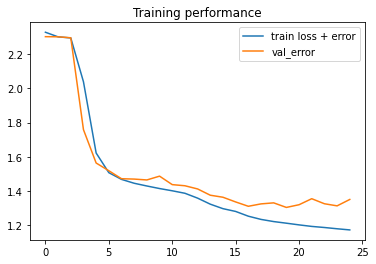

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

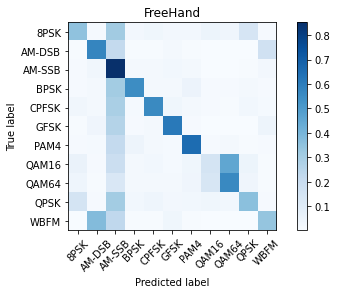

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08469539375928678


Overall Accuracy:  0.10277264325323475


Overall Accuracy:  0.09826793920113114


Overall Accuracy:  0.12122276879831342


Overall Accuracy:  0.13403179190751446


Overall Accuracy:  0.20766201217329036


Overall Accuracy:  0.29702615549982087


Overall Accuracy:  0.4117005813953488


Overall Accuracy:  0.4891728789492368


Overall Accuracy:  0.6229331416247305


Overall Accuracy:  0.6815541031227306


Overall Accuracy:  0.7407140281283808


Overall Accuracy:  0.7620493358633776


Overall Accuracy:  0.7761194029850746


Overall Accuracy:  0.7636887608069164


Overall Accuracy:  0.7761574917973022


Overall Accuracy:  0.7708256201406887


Overall Accuracy:  0.7728469349379467


Overall Accuracy:  0.7733971997052321


Overall Accuracy:  0.7637992831541218


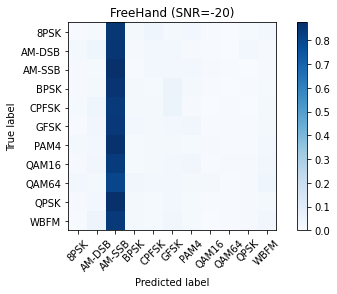

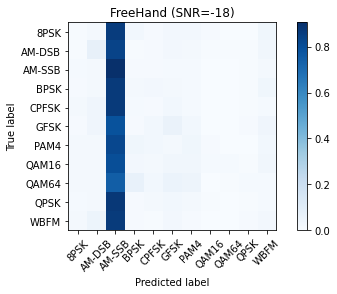

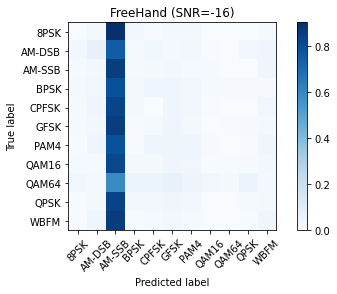

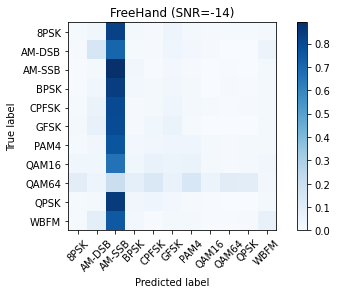

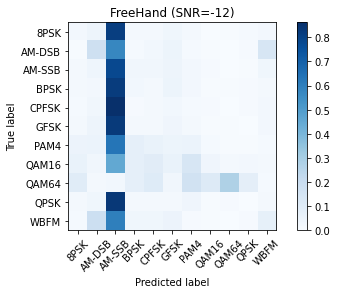

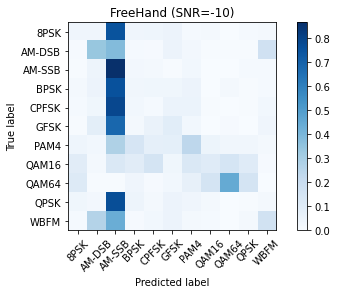

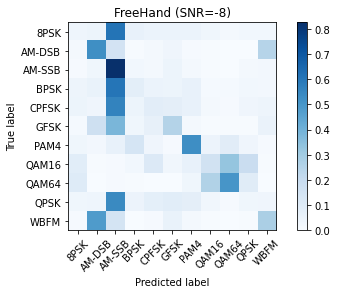

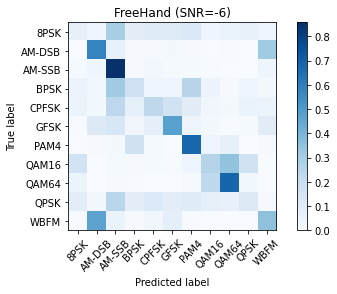

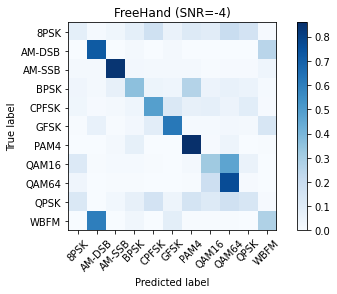

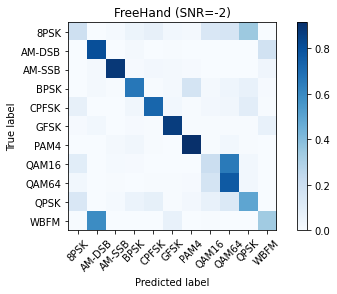

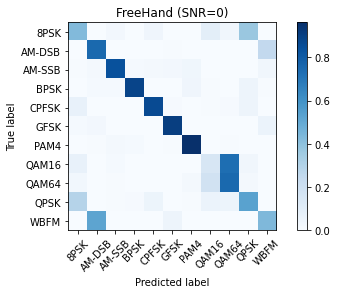

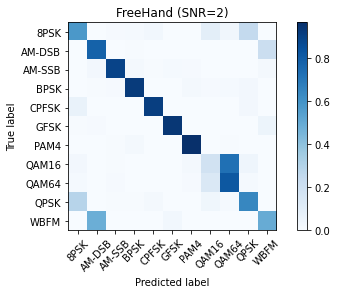

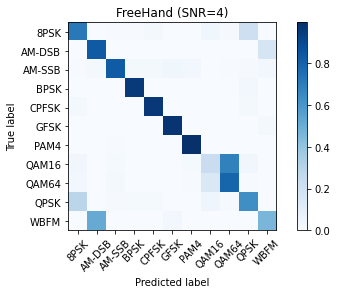

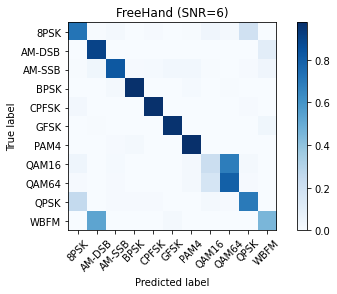

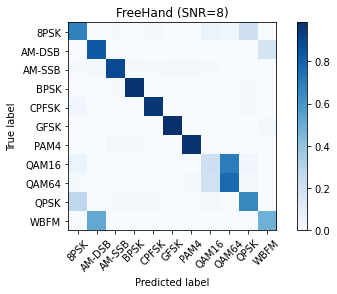

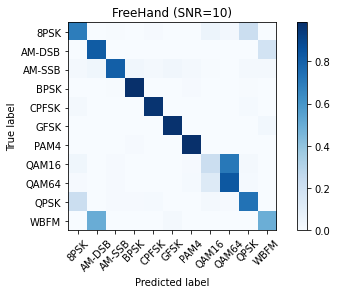

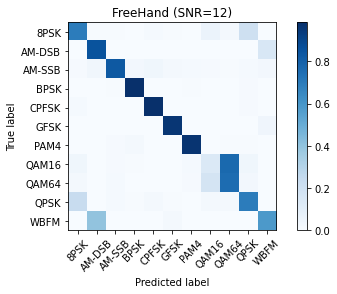

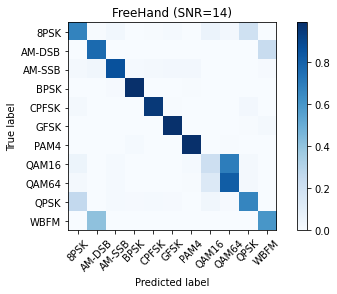

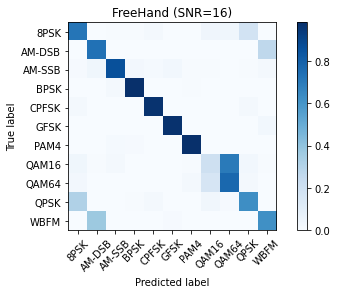

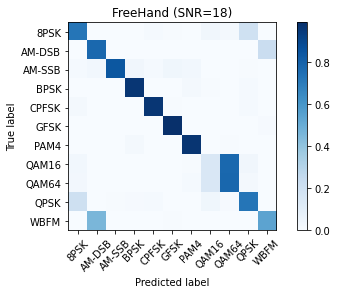

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,10,9,12,13,20,29,41,48,62,68,74,76,77,76,77,77,77,77,76


In [18]:
import statistics

statistics.mean(acc.values())

0.507531873360184

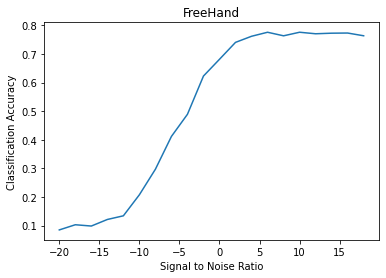

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)